<a href="https://colab.research.google.com/github/simon19891101/ML_experiments/blob/main/sc_reliability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# sc reliability
let's evaluate how robust SC is via synthetic data

In [ ]:
!rm -rf timeseries-generator

In [1]:
!git clone https://github.com/simon19891101/timeseries-generator.git

Cloning into 'timeseries-generator'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 83 (delta 21), reused 50 (delta 6), pack-reused 0
Receiving objects: 100% (83/83), 785.12 KiB | 12.87 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
!pip install ./timeseries-generator causalimpact

Processing ./timeseries-generator
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for timeseries_generator: filename=timeseries_generator-0.1.0-py2.py3-none-any.whl size=105523 sha256=3f378a1e666ad3231681ad3a4cb157751cb36018c73a96dca54a2882cdf1ca2d
  Stored in directory: /root/.cache/pip/wheels/ec/dd/48/6047a12a9465bd1762d50b0bf80f9c818b63ecf6798631e2b3
  Created wheel for matplotlib: filename=matplotlib-3.3

## Generate synthetic time series

In [1]:
from pandas._libs.tslibs.timestamps import Timestamp
from timeseries_generator.external_factors import CountryGdpFactor, EUIndustryProductFactor
from timeseries_generator import LinearTrend, Generator, HolidayFactor, RandomFeatureFactor, SinusoidalFactor, WeekdayFactor, WhiteNoise

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta

from scipy import stats
from causalimpact import CausalImpact
from datetime import datetime, timedelta

import itertools

In [2]:
#https://github.com/Nike-Inc/timeseries-generator/blob/master/examples/use_external_factors.ipynb

N_groups = 500
df = pd.DataFrame()
start_date = Timestamp("01-01-2019")
end_date = Timestamp("31-12-2019")

for i in range(N_groups):

  np.random.seed(i)
  lt_rand = np.random.uniform(-0.5,2)
  white_noise_rand = np.random.uniform(0.03,0.05)
  store_factor_rand = np.random.uniform(1,10)
  holiday_factor_rand = np.random.uniform(1,1.5)
  weekday_factor_rand = {4: np.random.uniform(1,1.2),
                     5: np.random.uniform(1,1.5),
                     6: np.random.uniform(1,1.5)}
  base_value_rand = np.random.uniform(0,1)
  sin_wavelength_rand = np.random.choice([365, 365/2, 365/4])
  sin_phase_rand = np.random.uniform(0,10)
  sin_mean_rand = np.random.uniform(1,2)

  lt = LinearTrend(coef=lt_rand, offset=1, col_name="linear_trend")

  white_noise = WhiteNoise(stdev_factor=white_noise_rand)

  country_list = ["New Zealand"]

  c_gdp_factor = CountryGdpFactor(country_list=country_list)

  holiday_factor = HolidayFactor(holiday_factor=holiday_factor_rand)

  feature_store_random_components = RandomFeatureFactor(
      feature_values=["store"+str(i+1)],
      feature="store",
      min_factor_value=store_factor_rand,
      max_factor_value=store_factor_rand,
      col_name="random_store_factor"
  )

  product_seasonal_components = SinusoidalFactor(wavelength=sin_wavelength_rand,
                                                 amplitude=0.2,
                                                 phase=sin_phase_rand,
                                                 mean=sin_mean_rand)

  weekday_factor = WeekdayFactor(
      col_name="weekend_boost_factor",
      factor_values=weekday_factor_rand
  )

  features_dict = {
        "country": country_list,
        "store": ["store"+str(i+1)]
    }


  g: Generator = Generator(
    factors={
        lt,
        c_gdp_factor,
        holiday_factor,
        weekday_factor,
        feature_store_random_components,
        product_seasonal_components,
        white_noise
    },
    features=features_dict,
    date_range=pd.date_range(start=start_date, end=end_date),
    base_value=1000*base_value_rand
  )

  df = pd.concat([df, g.generate()])

df = df.set_index('date')
df = df[['store', 'value']]

<ipython-input-2-ce76688a88a4>:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  end_date = Timestamp("31-12-2019")


In [3]:
df[df['store'].isin(['store1'])].head()

store         value
date                            
2019-01-01  store1  15774.348245
2019-01-02  store1  16853.777745
2019-01-03  store1  16742.090402
2019-01-04  store1  17082.526825
2019-01-05  store1  22393.209846

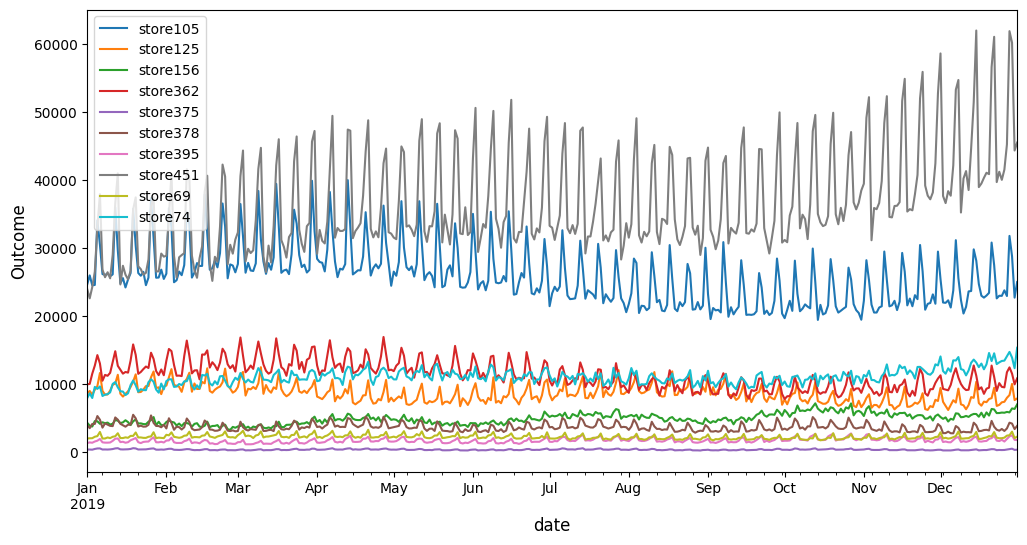

In [4]:
plt.rc('axes', labelsize=12)
np.random.seed(42)
stores	= ['store'+str(i) for i in np.random.choice(list(range(1, N_groups+1)),10, replace=False)]
df[df['store'].isin(stores)][['store', 'value']].pivot(columns=['store'], values='value').plot(figsize=(12,6))
plt.legend(loc='upper left')
_ = plt.ylabel('Outcome')

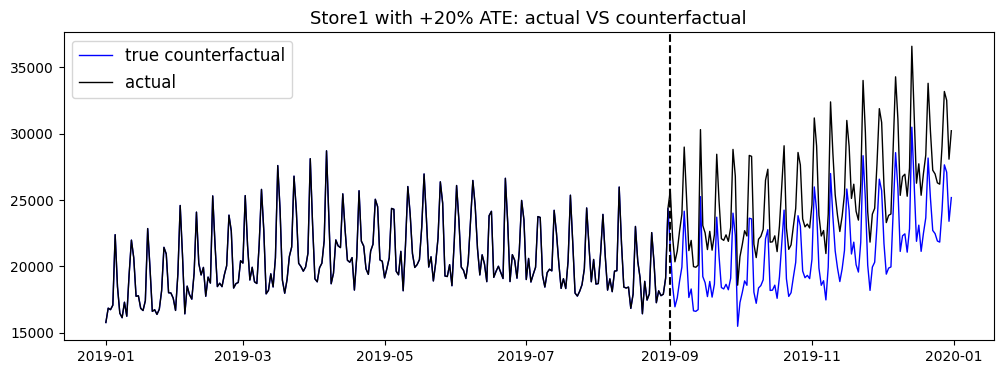

In [5]:
start_date_sc = '2019-01-01'
cutoff_date_sc = '2019-09-01'
end_date_sc = '2019-12-31'

df_sc = df[['store', 'value']].pivot(columns=['store'], values='value')['store1']
df_sc = df_sc.loc[start_date_sc:end_date_sc]
true_cf = df_sc.copy()
df_sc.loc[cutoff_date_sc:] = df_sc.loc[cutoff_date_sc:]*1.2

data_inter = pd.to_datetime(cutoff_date_sc)

plt.rc('axes', titlesize=13)
plt.rc('axes', labelsize=13)
plt.figure(figsize=(12,4))

plt.plot(true_cf, "b", alpha=1, linewidth=1, label="true counterfactual")
plt.plot(df_sc, "k", linewidth=1, label="actual")

plt.axvline(data_inter, c="k", linestyle="--")
plt.legend(loc="upper left", prop={'size': 12})
_ = plt.title(f"Store1 with +20% ATE: actual VS counterfactual")

## SC: impact of covariate correlation

In [6]:
# Function to calculate correlation
import numpy as np

def correlation(x, y):
    shortest = min(x.shape[0], y.shape[0])
    return np.corrcoef(x.iloc[:shortest].values, y.iloc[:shortest].values)[0, 1]

In [7]:
pre_cutoff_date_sc = (pd.to_datetime(cutoff_date_sc) - timedelta(days=1)).strftime('%Y-%m-%d')

corr = []
for i in range(2, N_groups+1):
  x = df[df['store']=='store1'].loc[start_date_sc:pre_cutoff_date_sc]['value']
  y = df[df['store']=='store'+str(i)].loc[start_date_sc:pre_cutoff_date_sc]['value']
  corr.append(correlation(x, y))
corr_dict = dict(zip(['store'+str(i) for i in list(range(2,N_groups+1))], corr))

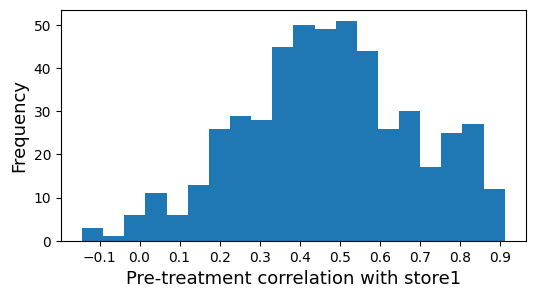

In [9]:
plt.figure(figsize=(6,3))
plt.xticks(np.unique(np.round(list(corr_dict.values()),1)))
_ = plt.hist(list(corr_dict.values()), bins=20)
_ = plt.xlabel("Pre-treatment correlation with store1")
_ = plt.ylabel("Frequency")

In [24]:
start_date_sc = '2019-06-01'
cutoff_date_sc = '2019-09-01'
end_date_sc = '2019-12-31'
pre_period = [pd.to_datetime(i) for i in [start_date_sc, pd.to_datetime(cutoff_date_sc) - timedelta(days=1)]]
post_period = [pd.to_datetime(i) for i in [cutoff_date_sc, end_date_sc]]

tre_id = 'store'+str(1)
df_sc = df[['store', 'value']].pivot(columns=['store'], values='value')
df_sc = df_sc.loc[start_date_sc:end_date_sc]
df_sc.loc[cutoff_date_sc:, tre_id] = df_sc.loc[cutoff_date_sc:, tre_id]*1.2
pre_tre_actual = df_sc[tre_id].loc[start_date_sc:pre_cutoff_date_sc].values
pre_cutoff_date_sc = (pd.to_datetime(cutoff_date_sc) - timedelta(days=1)).strftime('%Y-%m-%d')

pre_tre_acc_arr = []
rel_effect_arr = []
corr_arr = []
ci_dict_corr = dict({})

for ctr_id in range(2,N_groups+1):

  print(f"ctr_id: {ctr_id}")
  ctr_id = 'store'+str(ctr_id)
  corr = corr_dict.get(ctr_id)
  cols = [tre_id, ctr_id]

  ci = CausalImpact(df_sc[cols], pre_period, post_period)
  ci.run()
  ci_dict_corr.update({ctr_id: ci})

  summary_path = 'summary_'+ctr_id
  ci.summary(path=summary_path)
  summary = pd.read_csv(summary_path)
  est = summary.loc[7][1].replace('%', '')


  pre_tre_pred = ci.inferences.point_pred.loc[start_date_sc:pre_cutoff_date_sc].values
  pre_tre_acc = mean_absolute_percentage_error(pre_tre_actual, pre_tre_pred)
  rel_effect = float(est)/100

  pre_tre_acc_arr.append(pre_tre_acc)
  rel_effect_arr.append(rel_effect)
  corr_arr.append(corr)

results_corr = pd.DataFrame({'corr': corr_arr,
                             'pre_tre_acc': pre_tre_acc_arr,
                             'rel_effect': rel_effect_arr},
                            index=['store'+str(i) for i in list(range(2,N_groups+1))])

ctr_id: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22551             2751321
95% CI                   [14940, 30163]  [1822708, 3679933]
                                                           
Absolute Effect                    2871              350287
95% CI                   [10482, -4740]  [1278899, -578325]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [46.5%, -21.0%]     [46.5%, -21.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 3
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23659             2886439
95% CI                   [1504

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19793             2414800
95% CI                  [13767, 25819]  [1679629, 3149971]
                                                          
Absolute Effect                   5629              686807
95% CI                   [11655, -396]   [1421978, -48363]
                                                          
Relative Effect                  28.4%               28.4%
95% CI                  [58.9%, -2.0%]      [58.9%, -2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 6
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20033             2444068
95% CI                  [16786, 23280]  [20479

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20295             2476056
95% CI                  [13563, 27027]  [1654718, 3297393]
                                                          
Absolute Effect                   5127              625552
95% CI                  [11859, -1604]  [1446889, -195785]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                  [58.4%, -7.9%]      [58.4%, -7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 9
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21117             2576321
95% CI                  [15037, 27197]  [18345

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22579             2754691
95% CI                  [19100, 26058]  [2330256, 3179127]
                                                          
Absolute Effect                   2843              346916
95% CI                    [6322, -635]    [771351, -77518]
                                                          
Relative Effect                  12.6%               12.6%
95% CI                  [28.0%, -2.8%]      [28.0%, -2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 12
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19329             2358176
95% CI                  [15844, 22814]  [1933

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23015             2807897
95% CI                   [15903, 30127]  [1940234, 3675560]
                                                           
Absolute Effect                    2407              293711
95% CI                    [9519, -4704]  [1161374, -573951]
                                                           
Relative Effect                   10.5%               10.5%
95% CI                  [41.4%, -20.4%]     [41.4%, -20.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 15
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20921             2552403
95% CI                  [16059, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21047             2567737
95% CI                  [14813, 27280]  [1807307, 3328167]
                                                          
Absolute Effect                   4375              533870
95% CI                  [10609, -1857]  [1294301, -226559]
                                                          
Relative Effect                  20.8%               20.8%
95% CI                  [50.4%, -8.8%]      [50.4%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 18
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22837             2786149
95% CI                   [15554, 30120]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20250             2470543
95% CI                  [14619, 25881]  [1783601, 3157484]
                                                          
Absolute Effect                   5172              631064
95% CI                   [10803, -458]   [1318006, -55876]
                                                          
Relative Effect                  25.5%               25.5%
95% CI                  [53.3%, -2.3%]      [53.3%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 21
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21900             2671885
95% CI                   [15029, 28772]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16005             1952714
95% CI                   [9963, 22047]  [1215574, 2689854]
                                                          
Absolute Effect                   9417             1148893
95% CI                   [15459, 3375]   [1886033, 411753]
                                                          
Relative Effect                  58.8%               58.8%
95% CI                  [96.6%, 21.1%]      [96.6%, 21.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 24
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17759             2166691
95% CI                  [11753, 23766]  [1433

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21242             2591584
95% CI                  [16599, 25885]  [2025098, 3158071]
                                                          
Absolute Effect                   4180              510023
95% CI                    [8823, -462]   [1076509, -56462]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                  [41.5%, -2.2%]      [41.5%, -2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 27
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17926             2187008
95% CI                  [10946, 24905]  [1335

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21688             2646032
95% CI                  [18168, 25208]  [2216584, 3075480]
                                                          
Absolute Effect                   3734              455576
95% CI                     [7254, 214]     [885023, 26128]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                   [33.4%, 1.0%]       [33.4%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 30
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19550             2385103
95% CI                  [13419, 25681]  [1637

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21078             2571614
95% CI                   [14567, 27590]  [1777240, 3365987]
                                                           
Absolute Effect                    4344              529994
95% CI                   [10855, -2167]  [1324367, -264379]
                                                           
Relative Effect                   20.6%               20.6%
95% CI                  [51.5%, -10.3%]     [51.5%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21482             2620808
95% CI                  [17651, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19100             2330256
95% CI                  [16588, 21611]  [2023855, 2636658]
                                                          
Absolute Effect                   6322              771351
95% CI                    [8834, 3811]   [1077752, 464949]
                                                          
Relative Effect                  33.1%               33.1%
95% CI                  [46.3%, 20.0%]      [46.3%, 20.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 36
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21113             2575856
95% CI                  [15093, 27133]  [1841

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21263             2594131
95% CI                  [18186, 24340]  [2218739, 2969524]
                                                          
Absolute Effect                   4159              507476
95% CI                    [7236, 1082]    [882869, 132083]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                   [34.0%, 5.1%]       [34.0%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 41
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18096             2207788
95% CI                  [11550, 24643]  [1409

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21352             2604997
95% CI                   [13641, 29063]  [1664286, 3545708]
                                                           
Absolute Effect                    4070              496610
95% CI                   [11781, -3640]  [1437321, -444100]
                                                           
Relative Effect                   19.1%               19.1%
95% CI                  [55.2%, -17.0%]     [55.2%, -17.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 44
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21511             2624359
95% CI                   [143

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17127             2089598
95% CI                   [8386, 25869]  [1023139, 3156058]
                                                          
Absolute Effect                   8295             1012009
95% CI                   [17036, -446]   [2078469, -54450]
                                                          
Relative Effect                  48.4%               48.4%
95% CI                  [99.5%, -2.6%]      [99.5%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 47
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21531             2626883
95% CI                   [14648, 28414]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20704             2526006
95% CI                   [13836, 27572]  [1688108, 3363904]
                                                           
Absolute Effect                    4718              575601
95% CI                   [11586, -2149]  [1413499, -262295]
                                                           
Relative Effect                   22.8%               22.8%
95% CI                  [56.0%, -10.4%]     [56.0%, -10.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 50
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20407             2489680
95% CI                  [18088, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20569             2509539
95% CI                  [18274, 22865]  [2229445, 2789634]
                                                          
Absolute Effect                   4853              592068
95% CI                    [7148, 2557]    [872162, 311974]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [34.8%, 12.4%]      [34.8%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 52
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21765             2655436
95% CI                  [15986, 27545]  [1950

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19186             2340771
95% CI                  [13031, 25341]  [1589839, 3091702]
                                                          
Absolute Effect                   6236              760837
95% CI                     [12391, 81]     [1511768, 9905]
                                                          
Relative Effect                  32.5%               32.5%
95% CI                   [64.6%, 0.4%]       [64.6%, 0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20409             2489959
95% CI                  [18029, 22789]  [2199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18258             2227484
95% CI                  [11976, 24539]  [1461172, 2993795]
                                                          
Absolute Effect                   7164              874124
95% CI                    [13446, 883]   [1640435, 107812]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                   [73.6%, 4.8%]       [73.6%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 58
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17516             2137027
95% CI                  [12028, 23004]  [1467

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         17251             2104688
95% CI                    [8020, 26482]   [978529, 3230847]
                                                           
Absolute Effect                    8171              996920
95% CI                   [17402, -1059]  [2123078, -129238]
                                                           
Relative Effect                   47.4%               47.4%
95% CI                  [100.9%, -6.1%]     [100.9%, -6.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 61
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17356             2117492
95% CI                  [11331, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19388             2365383
95% CI                  [14758, 24018]  [1800558, 2930209]
                                                          
Absolute Effect                   6034              736224
95% CI                   [10664, 1404]   [1301050, 171398]
                                                          
Relative Effect                  31.1%               31.1%
95% CI                   [55.0%, 7.2%]       [55.0%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 64
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23783             2901567
95% CI                   [15201, 32365]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18469             2253237
95% CI                  [12522, 24415]  [1527734, 2978740]
                                                          
Absolute Effect                   6953              848370
95% CI                   [12900, 1007]   [1573873, 122868]
                                                          
Relative Effect                  37.7%               37.7%
95% CI                   [69.8%, 5.5%]       [69.8%, 5.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 67
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18266             2228510
95% CI                  [12578, 23954]  [1534

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20229             2468019
95% CI                  [16584, 23874]  [2023360, 2912677]
                                                          
Absolute Effect                   5193              633589
95% CI                    [8838, 1548]   [1078247, 188930]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                   [43.7%, 7.7%]       [43.7%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 70
                               Average         Cumulative
Actual                           25423            3101608
Predicted                        16421            2003421
95% CI                   [8020, 24822]  [978482,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18097             2207870
95% CI                  [13583, 22610]  [1657234, 2758506]
                                                          
Absolute Effect                   7325              893737
95% CI                   [11839, 2812]   [1444373, 343101]
                                                          
Relative Effect                  40.5%               40.5%
95% CI                  [65.4%, 15.5%]      [65.4%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 73
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19571             2387688
95% CI                  [16650, 22492]  [2031

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20929             2553379
95% CI                  [15334, 26524]  [1870819, 3235939]
                                                          
Absolute Effect                   4493              548228
95% CI                  [10088, -1101]  [1230789, -134331]
                                                          
Relative Effect                  21.5%               21.5%
95% CI                  [48.2%, -5.3%]      [48.2%, -5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 76
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17945             2189326
95% CI                  [10520, 25370]  [1283

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22994             2805298
95% CI                   [16756, 29232]  [2044277, 3566319]
                                                           
Absolute Effect                    2428              296309
95% CI                    [8666, -3809]  [1057331, -464711]
                                                           
Relative Effect                   10.6%               10.6%
95% CI                  [37.7%, -16.6%]     [37.7%, -16.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 79
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19217             2344555
95% CI                  [15727, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21171             2582970
95% CI                  [18330, 24013]  [2236353, 2929587]
                                                          
Absolute Effect                   4251              518637
95% CI                    [7092, 1410]    [865254, 172020]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [33.5%, 6.7%]       [33.5%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 82
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20479             2498482
95% CI                  [15834, 25123]  [1931

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20316             2478637
95% CI                  [15884, 24748]  [1937897, 3019377]
                                                          
Absolute Effect                   5106              622970
95% CI                     [9538, 674]    [1163711, 82230]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                   [46.9%, 3.3%]       [46.9%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 85
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17499             2134907
95% CI                  [11116, 23881]  [1356

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20074             2449066
95% CI                  [17136, 23012]  [2090641, 2807492]
                                                          
Absolute Effect                   5348              652541
95% CI                    [8286, 2410]   [1010966, 294116]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                  [41.3%, 12.0%]      [41.3%, 12.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 88
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20778             2534977
95% CI                  [18380, 23176]  [2242

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20967             2558078
95% CI                  [16237, 25697]  [1981004, 3135152]
                                                          
Absolute Effect                   4455              543530
95% CI                    [9185, -274]   [1120604, -33543]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [43.8%, -1.3%]      [43.8%, -1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 91
                                Average           Cumulative
Actual                            25423              3101608
Predicted                         25142              3067336
95% CI                   [13901, 36383]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17640             2152172
95% CI                  [11162, 24118]  [1361842, 2942502]
                                                          
Absolute Effect                   7782              949435
95% CI                   [14260, 1304]   [1739765, 159105]
                                                          
Relative Effect                  44.1%               44.1%
95% CI                   [80.8%, 7.4%]       [80.8%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 94
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22437             2737350
95% CI                   [15982, 28891]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19776             2412700
95% CI                  [17528, 22024]  [2138446, 2686954]
                                                          
Absolute Effect                   5646              688907
95% CI                    [7894, 3398]    [963161, 414654]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                  [39.9%, 17.2%]      [39.9%, 17.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 97
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18655             2275949
95% CI                  [12576, 24733]  [1534

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19178             2339826
95% CI                  [11757, 26600]  [1434413, 3245239]
                                                          
Absolute Effect                   6244              761781
95% CI                  [13665, -1177]  [1667194, -143631]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                  [71.3%, -6.1%]      [71.3%, -6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 100
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17618             2149507
95% CI                  [10904, 24333]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20501             2501208
95% CI                  [17155, 23847]  [2093007, 2909410]
                                                          
Absolute Effect                   4921              600399
95% CI                    [8267, 1575]   [1008600, 192197]
                                                          
Relative Effect                  24.0%               24.0%
95% CI                   [40.3%, 7.7%]       [40.3%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 103
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21156             2581137
95% CI                  [18236, 24077]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19661             2398724
95% CI                  [17042, 22281]  [2079125, 2718323]
                                                          
Absolute Effect                   5761              702883
95% CI                    [8381, 3141]   [1022483, 383284]
                                                          
Relative Effect                  29.3%               29.3%
95% CI                  [42.6%, 16.0%]      [42.6%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 106
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20048             2445915
95% CI                  [14323, 25773]  [174

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18946             2311451
95% CI                  [16116, 21775]  [1966236, 2656666]
                                                          
Absolute Effect                   6476              790156
95% CI                    [9306, 3647]   [1135371, 444941]
                                                          
Relative Effect                  34.2%               34.2%
95% CI                  [49.1%, 19.2%]      [49.1%, 19.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 108
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17727             2162792
95% CI                  [11055, 24400]  [134

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17840             2176596
95% CI                  [12453, 23228]  [1519331, 2833861]
                                                          
Absolute Effect                   7582              925011
95% CI                   [12969, 2194]   [1582276, 267746]
                                                          
Relative Effect                  42.5%               42.5%
95% CI                  [72.7%, 12.3%]      [72.7%, 12.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 110
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17752             2165748
95% CI                  [11258, 24245]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19558             2386147
95% CI                  [16526, 22590]  [2016192, 2756101]
                                                          
Absolute Effect                   5864              715461
95% CI                    [8896, 2832]   [1085415, 345506]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                  [45.5%, 14.5%]      [45.5%, 14.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 112
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18272             2229244
95% CI                   [9732, 26812]  [118

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22217             2710565
95% CI                   [14266, 30168]  [1740547, 3680583]
                                                           
Absolute Effect                    3205              391042
95% CI                   [11156, -4745]  [1361060, -578974]
                                                           
Relative Effect                   14.4%               14.4%
95% CI                  [50.2%, -21.4%]     [50.2%, -21.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 114
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21584             2633248
95% CI                  [18296,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21024             2565001
95% CI                   [13097, 28951]  [1597925, 3532076]
                                                           
Absolute Effect                    4398              536607
95% CI                   [12325, -3528]  [1503682, -430468]
                                                           
Relative Effect                   20.9%               20.9%
95% CI                  [58.6%, -16.8%]     [58.6%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 116
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20628             2516734
95% CI                  [13987,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 118
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20680             2523045
95% CI                  [14963, 26397]  [1825565, 3220525]
                                                          
Absolute Effect                   4742              578562
95% CI                   [10459, -974]  [1276042, -118917]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [50.6%, -4.7%]      [50.6%, -4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 119


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22601             2757366
95% CI                   [15643, 29559]  [1908531, 3606202]
                                                           
Absolute Effect                    2821              344241
95% CI                    [9779, -4136]  [1193077, -504594]
                                                           
Relative Effect                   12.5%               12.5%
95% CI                  [43.3%, -18.3%]     [43.3%, -18.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 120
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19820             2418070
95% CI                  [14458,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18739             2286166
95% CI                  [13250, 24227]  [1616585, 2955746]
                                                          
Absolute Effect                   6683              815442
95% CI                   [12172, 1195]   [1485022, 145861]
                                                          
Relative Effect                  35.7%               35.7%
95% CI                   [65.0%, 6.4%]       [65.0%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 122
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21145             2579700
95% CI                   [14744, 27545]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17105             2086920
95% CI                  [11721, 22490]  [1430049, 2743791]
                                                          
Absolute Effect                   8317             1014687
95% CI                   [13701, 2932]   [1671559, 357816]
                                                          
Relative Effect                  48.6%               48.6%
95% CI                  [80.1%, 17.1%]      [80.1%, 17.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 124
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21523             2625862
95% CI                   [15328, 27718]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17615             2149138
95% CI                  [12421, 22810]  [1515438, 2782837]
                                                          
Absolute Effect                   7807              952470
95% CI                   [13001, 2612]   [1586169, 318770]
                                                          
Relative Effect                  44.3%               44.3%
95% CI                  [73.8%, 14.8%]      [73.8%, 14.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 126
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22263             2716135
95% CI                   [15518, 29008]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17703             2159862
95% CI                  [12190, 23216]  [1487291, 2832433]
                                                          
Absolute Effect                   7719              941745
95% CI                   [13232, 2206]   [1614317, 269174]
                                                          
Relative Effect                  43.6%               43.6%
95% CI                  [74.7%, 12.5%]      [74.7%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 128
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21437             2615373
95% CI                   [14690, 28184]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19284             2352674
95% CI                  [13695, 24873]  [1670834, 3034515]
                                                          
Absolute Effect                   6138              748933
95% CI                    [11727, 549]    [1430774, 67092]
                                                          
Relative Effect                  31.8%               31.8%
95% CI                   [60.8%, 2.9%]       [60.8%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 130
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17647             2152952
95% CI                  [11404, 23889]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21303             2599067
95% CI                  [16508, 26098]  [2014095, 3184038]
                                                          
Absolute Effect                   4119              502540
95% CI                    [8914, -675]   [1087512, -82430]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                  [41.8%, -3.2%]      [41.8%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 133
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21286             2596997
95% CI                  [17527, 25045]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21759             2654652
95% CI                   [15274, 28244]  [1863498, 3445806]
                                                           
Absolute Effect                    3663              446955
95% CI                   [10148, -2821]  [1238109, -344198]
                                                           
Relative Effect                   16.8%               16.8%
95% CI                  [46.6%, -13.0%]     [46.6%, -13.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 136
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21544             2628486
95% CI                  [17325,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19604             2391783
95% CI                  [13974, 25235]  [1704859, 3078707]
                                                          
Absolute Effect                   5818              709825
95% CI                    [11448, 187]    [1396749, 22900]
                                                          
Relative Effect                  29.7%               29.7%
95% CI                   [58.4%, 1.0%]       [58.4%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 139
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19279             2352159
95% CI                  [12857, 25701]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23204             2830888
95% CI                  [19293, 27114]  [2353803, 3307974]
                                                          
Absolute Effect                   2219              270719
95% CI                   [6129, -1691]   [747805, -206366]
                                                          
Relative Effect                   9.6%                9.6%
95% CI                  [26.4%, -7.3%]      [26.4%, -7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 142
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22471             2741564
95% CI                   [14835, 30108]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 145
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16607             2026064
95% CI                  [10525, 22688]  [1284150, 2767978]
                                                          
Absolute Effect                   8815             1075543
95% CI                   [14897, 2734]   [1817458, 333629]
                                                          
Relative Effect                  53.1%               53.1%
95% CI                  [89.7%, 16.5%]      [89.7%, 16.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 146
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20431             2492584
95% CI                  [17642, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21197             2586077
95% CI                  [15894, 26500]  [1939075, 3233080]
                                                          
Absolute Effect                   4225              515530
95% CI                   [9528, -1077]  [1162533, -131472]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                  [45.0%, -5.1%]      [45.0%, -5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 149
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21289             2597376
95% CI                  [18737, 23842]  [228

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18688             2280024
95% CI                  [12615, 24762]  [1539039, 3021009]
                                                          
Absolute Effect                   6734              821583
95% CI                    [12807, 660]    [1562568, 80599]
                                                          
Relative Effect                  36.0%               36.0%
95% CI                   [68.5%, 3.5%]       [68.5%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 152
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19221             2344980
95% CI                  [13604, 24837]  [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20600             2513241
95% CI                  [14459, 26741]  [1764004, 3262477]
                                                          
Absolute Effect                   4822              588367
95% CI                  [10963, -1318]  [1337603, -160869]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [53.2%, -6.4%]      [53.2%, -6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 155
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20686             2523726
95% CI                  [18394, 22977]  [224

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21929             2675402
95% CI                   [15227, 28631]  [1857769, 3493035]
                                                           
Absolute Effect                    3493              426205
95% CI                   [10195, -3208]  [1243838, -391427]
                                                           
Relative Effect                   15.9%               15.9%
95% CI                  [46.5%, -14.6%]     [46.5%, -14.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 158
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22609             2758327
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16691             2036341
95% CI                  [9042, 24339]  [1103206, 2969476]
                                                         
Absolute Effect                  8731             1065266
95% CI                  [16380, 1083]   [1998402, 132131]
                                                         
Relative Effect                 52.3%               52.3%
95% CI                  [98.1%, 6.5%]       [98.1%, 6.5%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 161
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17426             2126043
95% CI                  [10317, 24536]  [1258685, 2993401

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17947             2189541
95% CI                  [12807, 23087]  [1562457, 2816625]
                                                          
Absolute Effect                   7475              912067
95% CI                   [12615, 2335]   [1539150, 284983]
                                                          
Relative Effect                  41.7%               41.7%
95% CI                  [70.3%, 13.0%]      [70.3%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 164
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18898             2305585
95% CI                  [12528, 25267]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17642             2152373
95% CI                  [10449, 24835]  [1274789, 3029957]
                                                          
Absolute Effect                   7780              949234
95% CI                    [14973, 587]    [1826818, 71650]
                                                          
Relative Effect                  44.1%               44.1%
95% CI                   [84.9%, 3.3%]       [84.9%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 167
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20015             2441890
95% CI                  [17383, 22647]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21469             2619338
95% CI                  [18439, 24500]  [2249671, 2989005]
                                                          
Absolute Effect                   3953              482269
95% CI                     [6983, 922]    [851937, 112602]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                   [32.5%, 4.3%]       [32.5%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 170
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20854             2544218
95% CI                  [17462, 24246]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21652             2641642
95% CI                   [14986, 28318]  [1828386, 3454898]
                                                           
Absolute Effect                    3770              459966
95% CI                   [10436, -2895]  [1273221, -353289]
                                                           
Relative Effect                   17.4%               17.4%
95% CI                  [48.2%, -13.4%]     [48.2%, -13.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 173
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21736             2651866
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20446             2494527
95% CI                  [15933, 24960]  [1943916, 3045137]
                                                          
Absolute Effect                   4976              607081
95% CI                     [9489, 462]    [1157691, 56470]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                   [46.4%, 2.3%]       [46.4%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 176
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18526             2260203
95% CI                  [13040, 24012]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20755             2532110
95% CI                  [18458, 23051]  [2251957, 2812263]
                                                          
Absolute Effect                   4668              569497
95% CI                    [6964, 2371]    [849651, 289344]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                  [33.6%, 11.4%]      [33.6%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 179
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21573             2631916
95% CI                  [15730, 27415]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23476             2864120
95% CI                   [15903, 31049]  [1940259, 3787980]
                                                           
Absolute Effect                    1946              237487
95% CI                    [9519, -5626]  [1161348, -686372]
                                                           
Relative Effect                    8.3%                8.3%
95% CI                  [40.5%, -24.0%]     [40.5%, -24.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 182
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17676             2156555
95% CI                   [9522,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20953             2556368
95% CI                  [17756, 24151]  [2166245, 2946491]
                                                          
Absolute Effect                   4469              545239
95% CI                    [7666, 1271]    [935362, 155116]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [36.6%, 6.1%]       [36.6%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 188
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20622             2515952
95% CI                  [18225, 23019]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17122             2088955
95% CI                  [10519, 23725]  [1283362, 2894547]
                                                          
Absolute Effect                   8300             1012653
95% CI                   [14903, 1697]   [1818245, 207060]
                                                          
Relative Effect                  48.5%               48.5%
95% CI                   [87.0%, 9.9%]       [87.0%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 191
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21432             2614799
95% CI                  [17220, 25645]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21683             2645326
95% CI                   [14174, 29191]  [1729330, 3561323]
                                                           
Absolute Effect                    3740              456281
95% CI                   [11248, -3768]  [1372277, -459714]
                                                           
Relative Effect                   17.2%               17.2%
95% CI                  [51.9%, -17.4%]     [51.9%, -17.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 193
                                Average         Cumulative
Actual                            25423            3101608
Predicted                         16193            1975609
95% CI                    [6520

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20640             2518169
95% CI                  [17743, 23538]  [2164659, 2871679]
                                                          
Absolute Effect                   4782              583438
95% CI                    [7679, 1884]    [936948, 229928]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                   [37.2%, 9.1%]       [37.2%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 195
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19047             2323834
95% CI                  [12962, 25132]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22593             2756404
95% CI                  [18930, 26256]  [2309485, 3203324]
                                                          
Absolute Effect                   2829              345203
95% CI                    [6492, -833]   [792123, -101716]
                                                          
Relative Effect                  12.5%               12.5%
95% CI                  [28.7%, -3.7%]      [28.7%, -3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 197
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20975             2559066
95% CI                  [17460, 24491]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21957             2678757
95% CI                   [15277, 28636]  [1863847, 3493668]
                                                           
Absolute Effect                    3465              422850
95% CI                   [10145, -3213]  [1237761, -392060]
                                                           
Relative Effect                   15.8%               15.8%
95% CI                  [46.2%, -14.6%]     [46.2%, -14.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19008             2319035
95% CI                  [13100,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24002             2928262
95% CI                   [16218, 31786]  [1978627, 3877898]
                                                           
Absolute Effect                    1420              173345
95% CI                    [9204, -6363]  [1122980, -776289]
                                                           
Relative Effect                    5.9%                5.9%
95% CI                  [38.3%, -26.5%]     [38.3%, -26.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 201


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21424             2613760
95% CI                  [16308, 26539]  [1989690, 3237830]
                                                          
Absolute Effect                   3998              487847
95% CI                   [9114, -1116]  [1111917, -136221]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [42.5%, -5.2%]      [42.5%, -5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 202


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19530             2382754
95% CI                  [14994, 24067]  [1829286, 2936222]
                                                          
Absolute Effect                   5892              718853
95% CI                   [10428, 1355]   [1272321, 165385]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [53.4%, 6.9%]       [53.4%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 203


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17327             2113973
95% CI                  [11563, 23091]  [1410802, 2817144]
                                                          
Absolute Effect                   8095              987634
95% CI                   [13859, 2331]   [1690805, 284463]
                                                          
Relative Effect                  46.7%               46.7%
95% CI                  [80.0%, 13.5%]      [80.0%, 13.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 204
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21646             2640843
95% CI                   [15213, 28079]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22155             2703001
95% CI                   [14880, 29431]  [1815396, 3590606]
                                                           
Absolute Effect                    3267              398607
95% CI                   [10542, -4008]  [1286212, -488997]
                                                           
Relative Effect                   14.7%               14.7%
95% CI                  [47.6%, -18.1%]     [47.6%, -18.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 206
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21844             2665028
95% CI                  [17835,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20753             2531929
95% CI                  [17549, 23957]  [2141030, 2922827]
                                                          
Absolute Effect                   4669              569679
95% CI                    [7873, 1465]    [960577, 178780]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [37.9%, 7.1%]       [37.9%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 208
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17967             2192040
95% CI                  [11421, 24513]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23958             2922894
95% CI                   [15974, 31942]  [1948863, 3896926]
                                                           
Absolute Effect                    1464              178713
95% CI                    [9448, -6519]  [1152744, -795318]
                                                           
Relative Effect                    6.1%                6.1%
95% CI                  [39.4%, -27.2%]     [39.4%, -27.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 211
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20122             2454998
95% CI                  [14118,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21472             2619615
95% CI                   [14900, 28043]  [1817866, 3421363]
                                                           
Absolute Effect                    3950              481992
95% CI                   [10522, -2620]  [1283741, -319755]
                                                           
Relative Effect                   18.4%               18.4%
95% CI                  [49.0%, -12.2%]     [49.0%, -12.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 213
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20340             2481499
95% CI                  [16668,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19076             2327296
95% CI                  [14786, 23365]  [1803964, 2850627]
                                                          
Absolute Effect                   6346              774312
95% CI                   [10636, 2057]   [1297643, 250980]
                                                          
Relative Effect                  33.3%               33.3%
95% CI                  [55.8%, 10.8%]      [55.8%, 10.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 216
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19040             2322912
95% CI                  [13643, 24437]  [166

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19888             2426388
95% CI                  [16425, 23351]  [2003851, 2848926]
                                                          
Absolute Effect                   5534              675219
95% CI                    [8998, 2071]   [1097757, 252681]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                  [45.2%, 10.4%]      [45.2%, 10.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 219
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20414             2490600
95% CI                  [16821, 24008]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20422             2491492
95% CI                  [17817, 23026]  [2173787, 2809197]
                                                          
Absolute Effect                   5000              610115
95% CI                    [7605, 2396]    [927820, 292410]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                  [37.2%, 11.7%]      [37.2%, 11.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 222
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20685             2523628
95% CI                  [16358, 25012]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20713             2526998
95% CI                  [16685, 24740]  [2035641, 3018354]
                                                          
Absolute Effect                   4709              574610
95% CI                     [8737, 682]    [1065966, 83253]
                                                          
Relative Effect                  22.7%               22.7%
95% CI                   [42.2%, 3.3%]       [42.2%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 224
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19264             2350224
95% CI                  [13597, 24930]  [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19934             2432000
95% CI                  [17681, 22187]  [2157142, 2706857]
                                                          
Absolute Effect                   5488              669608
95% CI                    [7741, 3235]    [944465, 394750]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                  [38.8%, 16.2%]      [38.8%, 16.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 227
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19071             2326780
95% CI                  [13235, 24908]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22624             2760134
95% CI                   [16027, 29220]  [1955391, 3564878]
                                                           
Absolute Effect                    2798              341473
95% CI                    [9395, -3797]  [1146216, -463270]
                                                           
Relative Effect                   12.4%               12.4%
95% CI                  [41.5%, -16.8%]     [41.5%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 230
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21264             2594211
95% CI                   [13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18922             2308529
95% CI                  [12679, 25165]  [1546884, 3070175]
                                                          
Absolute Effect                   6500              793078
95% CI                    [12743, 257]    [1554724, 31432]
                                                          
Relative Effect                  34.4%               34.4%
95% CI                   [67.3%, 1.4%]       [67.3%, 1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 233
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18469             2253307
95% CI                  [12653, 24286]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19166             2338259
95% CI                  [16248, 22083]  [1982356, 2694161]
                                                          
Absolute Effect                   6256              763349
95% CI                    [9174, 3339]   [1119251, 407447]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                  [47.9%, 17.4%]      [47.9%, 17.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 236
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21527             2626378
95% CI                  [18564, 24490]  [226

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20656             2520086
95% CI                  [15851, 25461]  [1933882, 3106289]
                                                          
Absolute Effect                   4766              581522
95% CI                     [9571, -38]    [1167726, -4681]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [46.3%, -0.2%]      [46.3%, -0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 238
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22422             2735533
95% CI                   [16057, 28787]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17585             2145452
95% CI                  [12778, 22393]  [1558916, 2731988]
                                                          
Absolute Effect                   7837              956155
95% CI                   [12645, 3029]   [1542691, 369619]
                                                          
Relative Effect                  44.6%               44.6%
95% CI                  [71.9%, 17.2%]      [71.9%, 17.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 240
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21786             2657921
95% CI                   [15386, 28186]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20045             2445516
95% CI                  [17734, 22355]  [2163628, 2727404]
                                                          
Absolute Effect                   5377              656091
95% CI                    [7688, 3067]    [937979, 374204]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [38.4%, 15.3%]      [38.4%, 15.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 242
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21114             2575964
95% CI                  [14770, 27458]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21176             2583515
95% CI                  [17092, 25260]  [2085296, 3081733]
                                                          
Absolute Effect                   4246              518093
95% CI                     [8330, 162]    [1016311, 19874]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [39.3%, 0.8%]       [39.3%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 244
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19591             2390194
95% CI                  [16428, 22754]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20632             2517175
95% CI                  [14955, 26309]  [1824533, 3209818]
                                                          
Absolute Effect                   4790              584432
95% CI                   [10467, -886]  [1277075, -108210]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                  [50.7%, -4.3%]      [50.7%, -4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 246
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21319             2600950
95% CI                  [18253, 24385]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20949             2555843
95% CI                  [18008, 23891]  [2196983, 2914703]
                                                          
Absolute Effect                   4473              545764
95% CI                    [7414, 1532]    [904624, 186904]
                                                          
Relative Effect                  21.4%               21.4%
95% CI                   [35.4%, 7.3%]       [35.4%, 7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 248


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20464             2496682
95% CI                  [16748, 24180]  [2043365, 2949999]
                                                          
Absolute Effect                   4958              604925
95% CI                    [8674, 1242]   [1058242, 151608]
                                                          
Relative Effect                  24.2%               24.2%
95% CI                   [42.4%, 6.1%]       [42.4%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 249


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21810             2660929
95% CI                   [15845, 27776]  [1933153, 3388705]
                                                           
Absolute Effect                    3612              440678
95% CI                    [9577, -2353]  [1168454, -287096]
                                                           
Relative Effect                   16.6%               16.6%
95% CI                  [43.9%, -10.8%]     [43.9%, -10.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 250


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16157             1971222
95% CI                    [8552, 23762]  [1043372, 2899071]
                                                           
Absolute Effect                    9265             1130386
95% CI                    [16870, 1660]   [2058235, 202537]
                                                           
Relative Effect                   57.3%               57.3%
95% CI                  [104.4%, 10.3%]     [104.4%, 10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 251
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21859             2666871
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 252
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21012             2563502
95% CI                  [17940, 24084]  [2188716, 2938287]
                                                          
Absolute Effect                   4410              538106
95% CI                    [7482, 1338]    [912891, 163320]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                   [35.6%, 6.4%]       [35.6%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21130             2577905
95% CI                   [13011, 29248]  [1587446, 3568365]
                                                           
Absolute Effect                    4292              523702
95% CI                   [12411, -3825]  [1514162, -466757]
                                                           
Relative Effect                   20.3%               20.3%
95% CI                  [58.7%, -18.1%]     [58.7%, -18.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 254
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17229             2101941
95% CI                  [11277,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18239             2225224
95% CI                  [12630, 23848]  [1540962, 2909487]
                                                          
Absolute Effect                   7183              876383
95% CI                   [12792, 1574]   [1560645, 192121]
                                                          
Relative Effect                  39.4%               39.4%
95% CI                   [70.1%, 8.6%]       [70.1%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 256
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21872             2668445
95% CI                   [14343, 29401]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20146             2457821
95% CI                  [12890, 27401]  [1572634, 3343009]
                                                          
Absolute Effect                   5276              643786
95% CI                  [12532, -1978]  [1528974, -241400]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                  [62.2%, -9.8%]      [62.2%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 258
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17910             2185068
95% CI                  [10115, 25705]  [123

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18021             2198636
95% CI                  [13595, 22447]  [1658679, 2738593]
                                                          
Absolute Effect                   7401              902971
95% CI                   [11827, 2975]   [1442928, 363014]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                  [65.6%, 16.5%]      [65.6%, 16.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 260
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19296             2354199
95% CI                  [13852, 24740]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19532             2382991
95% CI                  [14705, 24359]  [1794090, 2971892]
                                                          
Absolute Effect                   5890              718617
95% CI                   [10717, 1063]   [1307518, 129716]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [54.9%, 5.4%]       [54.9%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 262
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22054             2690631
95% CI                  [16753, 27355]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20523             2503905
95% CI                  [16436, 24611]  [2005219, 3002591]
                                                          
Absolute Effect                   4899              597703
95% CI                     [8986, 811]    [1096389, 99017]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                   [43.8%, 4.0%]       [43.8%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 264
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21613             2636813
95% CI                   [15188, 28037]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22190             2707215
95% CI                   [15697, 28682]  [1915129, 3499300]
                                                           
Absolute Effect                    3232              394392
95% CI                    [9725, -3259]  [1186478, -397692]
                                                           
Relative Effect                   14.6%               14.6%
95% CI                  [43.8%, -14.7%]     [43.8%, -14.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 267


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17138             2090934
95% CI                  [12031, 22246]  [1467809, 2714059]
                                                          
Absolute Effect                   8284             1010673
95% CI                   [13391, 3176]   [1633798, 387548]
                                                          
Relative Effect                  48.3%               48.3%
95% CI                  [78.1%, 18.5%]      [78.1%, 18.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 268
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16688             2036019
95% CI                   [9929, 23447]  [121

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17480             2132675
95% CI                  [11931, 23030]  [1455657, 2809693]
                                                          
Absolute Effect                   7942              968932
95% CI                   [13491, 2392]   [1645950, 291914]
                                                          
Relative Effect                  45.4%               45.4%
95% CI                  [77.2%, 13.7%]      [77.2%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 270
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17612             2148772
95% CI                  [11164, 24060]  [136

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22047             2689774
95% CI                  [17546, 26548]  [2140632, 3238915]
                                                          
Absolute Effect                   3375              411834
95% CI                   [7876, -1125]   [960975, -137307]
                                                          
Relative Effect                  15.3%               15.3%
95% CI                  [35.7%, -5.1%]      [35.7%, -5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 272
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18060             2203428
95% CI                  [11527, 24594]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average         Cumulative
Actual                           25423            3101608
Predicted                        15859            1934883
95% CI                   [7774, 23944]  [948543, 2921223]
                                                         
Absolute Effect                   9563            1166724
95% CI                   [17648, 1478]  [2153064, 180384]
                                                         
Relative Effect                  60.3%              60.3%
95% CI                  [111.3%, 9.3%]     [111.3%, 9.3%]
                                                         
P-value                           0.0%                   
Prob. of Causal Effect          100.0%                   
ctr_id: 274


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21012             2563517
95% CI                  [14598, 27426]  [1780989, 3346045]
                                                          
Absolute Effect                   4410              538090
95% CI                  [10824, -2003]  [1320619, -244437]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [51.5%, -9.5%]      [51.5%, -9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 275
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19169             2338699
95% CI                  [13404, 24934]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21274             2595532
95% CI                  [17702, 24847]  [2159663, 3031400]
                                                          
Absolute Effect                   4148              506075
95% CI                     [7720, 575]     [941944, 70207]
                                                          
Relative Effect                  19.5%               19.5%
95% CI                   [36.3%, 2.7%]       [36.3%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 277
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22169             2704660
95% CI                  [16987, 27351]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21533             2627073
95% CI                  [15903, 27163]  [1940243, 3313904]
                                                          
Absolute Effect                   3889              474534
95% CI                   [9519, -1740]  [1161364, -212296]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                  [44.2%, -8.1%]      [44.2%, -8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 279
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20559             2508219
95% CI                  [14166, 26951]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20532             2505011
95% CI                  [14801, 26264]  [1805757, 3204264]
                                                          
Absolute Effect                   4890              596597
95% CI                   [10621, -841]  [1295850, -102655]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [51.7%, -4.1%]      [51.7%, -4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 281
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19868             2424006
95% CI                  [16789, 22948]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22979             2803547
95% CI                   [15745, 30213]  [1921001, 3686092]
                                                           
Absolute Effect                    2443              298061
95% CI                    [9677, -4790]  [1180606, -584484]
                                                           
Relative Effect                   10.6%               10.6%
95% CI                  [42.1%, -20.8%]     [42.1%, -20.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 283


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21466             2618932
95% CI                   [15148, 27784]  [1848142, 3389722]
                                                           
Absolute Effect                    3956              482675
95% CI                   [10274, -2361]  [1253466, -288114]
                                                           
Relative Effect                   18.4%               18.4%
95% CI                  [47.9%, -11.0%]     [47.9%, -11.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 284


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21965             2679836
95% CI                   [15573, 28357]  [1900025, 3459647]
                                                           
Absolute Effect                    3457              421771
95% CI                    [9849, -2934]  [1201582, -358039]
                                                           
Relative Effect                   15.7%               15.7%
95% CI                  [44.8%, -13.4%]     [44.8%, -13.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 285


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22549             2750983
95% CI                   [14976, 30121]  [1827123, 3674843]
                                                           
Absolute Effect                    2873              350624
95% CI                   [10446, -4698]  [1274484, -573235]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [46.3%, -20.8%]     [46.3%, -20.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 286
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19713             2405082
95% CI                  [15613,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16199             1976306
95% CI                    [9230, 23168]  [1126060, 2826551]
                                                           
Absolute Effect                    9223             1125301
95% CI                    [16193, 2254]   [1975547, 275056]
                                                           
Relative Effect                   56.9%               56.9%
95% CI                  [100.0%, 13.9%]     [100.0%, 13.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 288
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19910             2429136
95% CI                  [15139,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18599             2269127
95% CI                  [12363, 24835]  [1508289, 3029965]
                                                          
Absolute Effect                   6823              832480
95% CI                    [13059, 587]    [1593319, 71642]
                                                          
Relative Effect                  36.7%               36.7%
95% CI                   [70.2%, 3.2%]       [70.2%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 290
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21737             2652028
95% CI                  [18830, 24645]  [229

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20194             2463761
95% CI                  [15645, 24744]  [1908697, 3018825]
                                                          
Absolute Effect                   5228              637846
95% CI                     [9777, 678]    [1192910, 82782]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                   [48.4%, 3.4%]       [48.4%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19408             2367784
95% CI                  [15670, 23146]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21414             2612519
95% CI                  [15596, 27231]  [1902802, 3322237]
                                                          
Absolute Effect                   4008              489088
95% CI                   [9826, -1808]  [1198806, -220629]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [45.9%, -8.4%]      [45.9%, -8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 294
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21014             2563794
95% CI                  [16858, 25170]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23081             2815906
95% CI                   [14863, 31298]  [1813365, 3818447]
                                                           
Absolute Effect                    2341              285701
95% CI                   [10559, -5875]  [1288242, -716839]
                                                           
Relative Effect                   10.1%               10.1%
95% CI                  [45.7%, -25.5%]     [45.7%, -25.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 296
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19167             2338397
95% CI                  [13720,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20291             2475521
95% CI                  [15571, 25011]  [1899690, 3051351]
                                                          
Absolute Effect                   5131              626087
95% CI                     [9851, 411]    [1201917, 50256]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                   [48.6%, 2.0%]       [48.6%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 298
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18259             2227603
95% CI                  [12463, 24054]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22330             2724290
95% CI                  [18905, 25755]  [2306446, 3142135]
                                                          
Absolute Effect                   3092              377317
95% CI                    [6517, -332]    [795162, -40526]
                                                          
Relative Effect                  13.9%               13.9%
95% CI                  [29.2%, -1.5%]      [29.2%, -1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 300
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17934             2188057
95% CI                  [12615, 23254]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20569             2509447
95% CI                  [17957, 23180]  [2190826, 2828068]
                                                          
Absolute Effect                   4853              592160
95% CI                    [7465, 2242]    [910782, 273539]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [36.3%, 10.9%]      [36.3%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 302
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21436             2615285
95% CI                  [15522, 27350]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18077             2205493
95% CI                  [11935, 24220]  [1456088, 2954899]
                                                          
Absolute Effect                   7345              896114
95% CI                   [13487, 1202]   [1645519, 146709]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                   [74.6%, 6.7%]       [74.6%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22226             2711661
95% CI                  [19287, 25166]  [235

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19650             2397321
95% CI                  [16452, 22847]  [2007191, 2787450]
                                                          
Absolute Effect                   5772              704287
95% CI                    [8970, 2575]   [1094416, 314158]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                  [45.7%, 13.1%]      [45.7%, 13.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 307
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21434             2615001
95% CI                  [16088, 26780]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20336             2481012
95% CI                  [15798, 24873]  [1927408, 3034617]
                                                          
Absolute Effect                   5086              620595
95% CI                     [9624, 549]    [1174199, 66991]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                   [47.3%, 2.7%]       [47.3%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 309


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21676             2644490
95% CI                  [17425, 25926]  [2125887, 3163092]
                                                          
Absolute Effect                   3746              457118
95% CI                    [7997, -503]    [975720, -61484]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                  [36.9%, -2.3%]      [36.9%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 310


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21218             2588650
95% CI                  [17694, 24741]  [2158781, 3018519]
                                                          
Absolute Effect                   4204              512957
95% CI                     [7728, 681]     [942826, 83088]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                   [36.4%, 3.2%]       [36.4%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 311


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21931             2675611
95% CI                  [17513, 26348]  [2136699, 3214522]
                                                          
Absolute Effect                   3491              425997
95% CI                    [7909, -925]   [964908, -112914]
                                                          
Relative Effect                  15.9%               15.9%
95% CI                  [36.1%, -4.2%]      [36.1%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20749             2531415
95% CI                  [18373, 23124]  [2241605, 2821224]
                                                          
Absolute Effect                   4673              570192
95% CI                    [7049, 2298]    [860002, 280383]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                  [34.0%, 11.1%]      [34.0%, 11.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 313


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19951             2434120
95% CI                  [17399, 22503]  [2122755, 2745486]
                                                          
Absolute Effect                   5471              667487
95% CI                    [8023, 2919]    [978852, 356122]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                  [40.2%, 14.6%]      [40.2%, 14.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 314


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17808             2172637
95% CI                  [11856, 23760]  [1446528, 2898746]
                                                          
Absolute Effect                   7614              928970
95% CI                   [13566, 1662]   [1655079, 202861]
                                                          
Relative Effect                  42.8%               42.8%
95% CI                   [76.2%, 9.3%]       [76.2%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 315


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21569             2631472
95% CI                  [18415, 24723]  [2246679, 3016265]
                                                          
Absolute Effect                   3853              470135
95% CI                     [7007, 699]     [854928, 85342]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                   [32.5%, 3.2%]       [32.5%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 316


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17669             2155652
95% CI                  [10276, 25061]  [1253749, 3057555]
                                                          
Absolute Effect                   7753              945955
95% CI                    [15146, 361]    [1847858, 44052]
                                                          
Relative Effect                  43.9%               43.9%
95% CI                   [85.7%, 2.0%]       [85.7%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 317


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18741             2286406
95% CI                  [13202, 24279]  [1610709, 2962103]
                                                          
Absolute Effect                   6681              815201
95% CI                   [12220, 1143]   [1490898, 139505]
                                                          
Relative Effect                  35.7%               35.7%
95% CI                   [65.2%, 6.1%]       [65.2%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 318
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17178             2095730
95% CI                  [11518, 22837]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21522             2625710
95% CI                  [16890, 26153]  [2060664, 3190755]
                                                          
Absolute Effect                   3900              475897
95% CI                    [8532, -730]   [1040943, -89147]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                  [39.6%, -3.4%]      [39.6%, -3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 320
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22277             2717895
95% CI                   [15235, 29320]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 322
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18991             2316906
95% CI                  [12974, 25007]  [1582846, 3050965]
                                                          
Absolute Effect                   6431              784701
95% CI                    [12448, 415]    [1518761, 50642]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                   [65.6%, 2.2%]       [65.6%, 2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 323
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23945             2921388
95% CI                   [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21328             2602126
95% CI                  [17524, 25133]  [2137972, 3066280]
                                                          
Absolute Effect                   4094              499481
95% CI                     [7898, 289]     [963635, 35327]
                                                          
Relative Effect                  19.2%               19.2%
95% CI                   [37.0%, 1.4%]       [37.0%, 1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 325
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20029             2443618
95% CI                  [14396, 25663]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16614             2026998
95% CI                  [9250, 23978]  [1128616, 2925381]
                                                         
Absolute Effect                  8808             1074609
95% CI                  [16172, 1444]   [1972992, 176227]
                                                         
Relative Effect                 53.0%               53.0%
95% CI                  [97.3%, 8.7%]       [97.3%, 8.7%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 328
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21201             2586529
95% CI                   [14436, 27965]  [1761233, 341

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22771             2778173
95% CI                   [16118, 29424]  [1966498, 3589847]
                                                           
Absolute Effect                    2651              323435
95% CI                    [9304, -4001]  [1135109, -488239]
                                                           
Relative Effect                   11.6%               11.6%
95% CI                  [40.9%, -17.6%]     [40.9%, -17.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 331
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20549             2507063
95% CI                  [17897,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18762             2289062
95% CI                  [11922, 25603]  [1454486, 3123638]
                                                          
Absolute Effect                   6660              812545
95% CI                   [13500, -180]   [1647121, -22029]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                  [72.0%, -1.0%]      [72.0%, -1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 334
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20639             2518076
95% CI                  [15666, 25613]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17433             2126927
95% CI                  [11222, 23645]  [1369123, 2884730]
                                                          
Absolute Effect                   7989              974681
95% CI                   [14200, 1777]   [1732484, 216877]
                                                          
Relative Effect                  45.8%               45.8%
95% CI                  [81.5%, 10.2%]      [81.5%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 337
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21554             2629636
95% CI                   [14690, 28418]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18358             2239729
95% CI                  [12342, 24373]  [1505835, 2973623]
                                                          
Absolute Effect                   7064              861878
95% CI                   [13080, 1049]   [1595773, 127984]
                                                          
Relative Effect                  38.5%               38.5%
95% CI                   [71.2%, 5.7%]       [71.2%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 340
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20442             2493969
95% CI                  [15236, 25648]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21256             2593232
95% CI                  [15043, 27468]  [1835297, 3351167]
                                                          
Absolute Effect                   4167              508375
95% CI                  [10379, -2045]  [1266310, -249558]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                  [48.8%, -9.6%]      [48.8%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 343
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20556             2507844
95% CI                   [13193, 27918]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21983             2681965
95% CI                   [15193, 28773]  [1853610, 3510321]
                                                           
Absolute Effect                    3439              419642
95% CI                   [10229, -3350]  [1247997, -408712]
                                                           
Relative Effect                   15.6%               15.6%
95% CI                  [46.5%, -15.2%]     [46.5%, -15.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20783             2535641
95% CI                  [17734,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20192             2463488
95% CI                  [17558, 22826]  [2142146, 2784830]
                                                          
Absolute Effect                   5230              638119
95% CI                    [7864, 2596]    [959462, 316777]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                  [38.9%, 12.9%]      [38.9%, 12.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 349
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16269             1984845
95% CI                  [10399, 22138]  [126

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20565             2508954
95% CI                  [14540, 26589]  [1773994, 3243913]
                                                          
Absolute Effect                   4857              592654
95% CI                  [10882, -1166]  [1327614, -142305]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [52.9%, -5.7%]      [52.9%, -5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 352
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19808             2416587
95% CI                  [13862, 25753]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22435             2737157
95% CI                   [13086, 31784]  [1596603, 3877710]
                                                           
Absolute Effect                    2987              364450
95% CI                   [12336, -6361]  [1505004, -776102]
                                                           
Relative Effect                   13.3%               13.3%
95% CI                  [55.0%, -28.4%]     [55.0%, -28.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 355
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18385             2243077
95% CI                  [11988,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16795             2049004
95% CI                  [9417, 24172]  [1148939, 2949068]
                                                         
Absolute Effect                  8627             1052604
95% CI                  [16005, 1250]   [1952668, 152539]
                                                         
Relative Effect                 51.4%               51.4%
95% CI                  [95.3%, 7.4%]       [95.3%, 7.4%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 358
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21617             2637297
95% CI                  [18501, 24733]  [2257126, 3017469

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19076             2327327
95% CI                  [13279, 24873]  [1620069, 3034585]
                                                          
Absolute Effect                   6346              774280
95% CI                    [12143, 549]    [1481539, 67022]
                                                          
Relative Effect                  33.3%               33.3%
95% CI                   [63.7%, 2.9%]       [63.7%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 361
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18794             2292931
95% CI                  [12397, 25191]  [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18391             2243795
95% CI                  [12867, 23916]  [1569790, 2917801]
                                                          
Absolute Effect                   7031              857812
95% CI                   [12555, 1506]   [1531817, 183807]
                                                          
Relative Effect                  38.2%               38.2%
95% CI                   [68.3%, 8.2%]       [68.3%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 364
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19402             2367082
95% CI                  [16959, 21844]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22415             2734720
95% CI                   [15841, 28989]  [1932691, 3536749]
                                                           
Absolute Effect                    3007              366888
95% CI                    [9581, -3566]  [1168917, -435140]
                                                           
Relative Effect                   13.4%               13.4%
95% CI                  [42.7%, -15.9%]     [42.7%, -15.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 367
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20440             2493761
95% CI                  [14929,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 373
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18301             2232738
95% CI                  [12710, 23891]  [1550653, 2914823]
                                                          
Absolute Effect                   7121              868869
95% CI                   [12712, 1531]   [1550954, 186784]
                                                          
Relative Effect                  38.9%               38.9%
95% CI                   [69.5%, 8.4%]       [69.5%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 374
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18468             2253129
95% CI                  [12537, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20574             2510096
95% CI                  [15138, 26010]  [1846865, 3173328]
                                                          
Absolute Effect                   4848              591511
95% CI                   [10284, -587]   [1254743, -71719]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [50.0%, -2.9%]      [50.0%, -2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 377
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21123             2577029
95% CI                  [14986, 27260]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20832             2541536
95% CI                  [15826, 25837]  [1930886, 3152186]
                                                          
Absolute Effect                   4590              560071
95% CI                    [9596, -414]   [1170721, -50578]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                  [46.1%, -2.0%]      [46.1%, -2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 380
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22582             2755073
95% CI                   [15079, 30085]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21017             2564133
95% CI                  [17700, 24334]  [2159466, 2968800]
                                                          
Absolute Effect                   4405              537474
95% CI                    [7722, 1088]    [942141, 132807]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                   [36.7%, 5.2%]       [36.7%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 383
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17699             2159282
95% CI                  [10331, 25066]  [126

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22393             2732037
95% CI                  [18638, 26149]  [2273867, 3190207]
                                                          
Absolute Effect                   3029              369570
95% CI                    [6784, -726]    [827740, -88599]
                                                          
Relative Effect                  13.5%               13.5%
95% CI                  [30.3%, -3.2%]      [30.3%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 386
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19747             2409217
95% CI                  [15205, 24290]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18696             2281033
95% CI                  [13595, 23798]  [1658660, 2903406]
                                                          
Absolute Effect                   6726              820574
95% CI                   [11827, 1624]   [1442947, 198201]
                                                          
Relative Effect                  36.0%               36.0%
95% CI                   [63.3%, 8.7%]       [63.3%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 389
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18276             2229703
95% CI                  [11948, 24603]  [145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22798             2781425
95% CI                   [15846, 29750]  [1933330, 3629520]
                                                           
Absolute Effect                    2624              320182
95% CI                    [9576, -4327]  [1168277, -527912]
                                                           
Relative Effect                   11.5%               11.5%
95% CI                  [42.0%, -19.0%]     [42.0%, -19.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 392
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20584             2511265
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20592             2512304
95% CI                   [13699, 27485]  [1671364, 3353244]
                                                           
Absolute Effect                    4830              589303
95% CI                   [11723, -2062]  [1430243, -251636]
                                                           
Relative Effect                   23.5%               23.5%
95% CI                  [56.9%, -10.0%]     [56.9%, -10.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 395
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21542             2628177
95% CI                  [15596,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20972             2558633
95% CI                  [14973, 26971]  [1826727, 3290540]
                                                          
Absolute Effect                   4450              542974
95% CI                  [10449, -1548]  [1274881, -188931]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [49.8%, -7.4%]      [49.8%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19855             2422362
95% CI                  [15288, 24422]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18852             2299949
95% CI                  [14118, 23585]  [1722434, 2877465]
                                                          
Absolute Effect                   6570              801658
95% CI                   [11304, 1837]   [1379174, 224142]
                                                          
Relative Effect                  34.9%               34.9%
95% CI                   [60.0%, 9.7%]       [60.0%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 401
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20506             2501745
95% CI                  [14695, 26317]  [179

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21307             2599503
95% CI                   [14081, 28532]  [1717997, 3481009]
                                                           
Absolute Effect                    4115              502104
95% CI                   [11341, -3109]  [1383611, -379401]
                                                           
Relative Effect                   19.3%               19.3%
95% CI                  [53.2%, -14.6%]     [53.2%, -14.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 404
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22469             2741238
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20734             2529669
95% CI                  [14779, 26690]  [1803133, 3256206]
                                                          
Absolute Effect                   4688              571938
95% CI                  [10643, -1267]  [1298474, -154598]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [51.3%, -6.1%]      [51.3%, -6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 407
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18732             2285331
95% CI                  [13015, 24449]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18607             2270131
95% CI                  [12287, 24928]  [1499035, 3041228]
                                                          
Absolute Effect                   6815              831476
95% CI                    [13135, 494]    [1602573, 60380]
                                                          
Relative Effect                  36.6%               36.6%
95% CI                   [70.6%, 2.7%]       [70.6%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 410
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22345             2726092
95% CI                   [11957, 32732]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23206             2831146
95% CI                   [16678, 29734]  [2034718, 3627574]
                                                           
Absolute Effect                    2216              270462
95% CI                    [8745, -4311]  [1066890, -525965]
                                                           
Relative Effect                    9.6%                9.6%
95% CI                  [37.7%, -18.6%]     [37.7%, -18.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 413
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21813             2661298
95% CI                  [18318,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19881             2425556
95% CI                  [13132, 26631]  [1602118, 3248993]
                                                          
Absolute Effect                   5541              676052
95% CI                  [12290, -1208]  [1499489, -147385]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                  [61.8%, -6.1%]      [61.8%, -6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 416
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19259             2349695
95% CI                  [15495, 23024]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17322             2113392
95% CI                  [12842, 21803]  [1566799, 2659985]
                                                          
Absolute Effect                   8100              988215
95% CI                   [12580, 3619]   [1534808, 441622]
                                                          
Relative Effect                  46.8%               46.8%
95% CI                  [72.6%, 20.9%]      [72.6%, 20.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 419
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20088             2450761
95% CI                  [16364, 23811]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20614             2515018
95% CI                  [17304, 23925]  [2111151, 2918886]
                                                          
Absolute Effect                   4808              586589
95% CI                    [8118, 1497]    [990456, 182722]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [39.4%, 7.3%]       [39.4%, 7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 422
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22871             2790361
95% CI                   [14694, 31048]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21507             2623968
95% CI                  [16240, 26775]  [1981301, 3266634]
                                                          
Absolute Effect                   3915              477640
95% CI                   [9182, -1352]  [1120307, -165026]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                  [42.7%, -6.3%]      [42.7%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 425
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21810             2660851
95% CI                  [18351, 25268]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23594             2878569
95% CI                   [14771, 32417]  [1802151, 3954987]
                                                           
Absolute Effect                    1828              223039
95% CI                   [10651, -6994]  [1299457, -853379]
                                                           
Relative Effect                    7.7%                7.7%
95% CI                  [45.1%, -29.6%]     [45.1%, -29.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 428
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17900             2183884
95% CI                  [10674,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22030             2687747
95% CI                   [15317, 28743]  [1868750, 3506744]
                                                           
Absolute Effect                    3392              413860
95% CI                   [10105, -3320]  [1232857, -405136]
                                                           
Relative Effect                   15.4%               15.4%
95% CI                  [45.9%, -15.1%]     [45.9%, -15.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 431
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21490             2621866
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21271             2595164
95% CI                  [16637, 25906]  [2029750, 3160578]
                                                          
Absolute Effect                   4151              506443
95% CI                    [8785, -483]   [1071857, -58970]
                                                          
Relative Effect                  19.5%               19.5%
95% CI                  [41.3%, -2.3%]      [41.3%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 434
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21018             2564267
95% CI                  [16796, 25240]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22320             2723071
95% CI                   [16514, 28125]  [2014779, 3431363]
                                                           
Absolute Effect                    3102              378536
95% CI                    [8908, -2702]  [1086829, -329755]
                                                           
Relative Effect                   13.9%               13.9%
95% CI                  [39.9%, -12.1%]     [39.9%, -12.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 437
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17674             2156339
95% CI                  [11875,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20205             2465065
95% CI                  [16199, 24211]  [1976379, 2953751]
                                                          
Absolute Effect                   5217              636542
95% CI                    [9223, 1211]   [1125228, 147856]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                   [45.6%, 6.0%]       [45.6%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 440
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18067             2204221
95% CI                  [11516, 24618]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22856             2788478
95% CI                   [16714, 28998]  [2039192, 3537763]
                                                           
Absolute Effect                    2566              313130
95% CI                    [8708, -3575]  [1062415, -436155]
                                                           
Relative Effect                   11.2%               11.2%
95% CI                  [38.1%, -15.6%]     [38.1%, -15.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 443
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20214             2466128
95% CI                  [16666,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22347             2726427
95% CI                   [15077, 29617]  [1839481, 3613374]
                                                           
Absolute Effect                    3075              375180
95% CI                   [10345, -4194]  [1262127, -511765]
                                                           
Relative Effect                   13.8%               13.8%
95% CI                  [46.3%, -18.8%]     [46.3%, -18.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 446
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18266             2228483
95% CI                  [11803,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18269             2228888
95% CI                  [12792, 23747]  [1560632, 2897145]
                                                          
Absolute Effect                   7153              872719
95% CI                   [12630, 1675]   [1540976, 204462]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                   [69.1%, 9.2%]       [69.1%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 448
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18182             2218254
95% CI                  [12184, 24180]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20621             2515839
95% CI                  [15814, 25428]  [1929399, 3102280]
                                                          
Absolute Effect                   4801              585768
95% CI                      [9608, -5]     [1172208, -672]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                  [46.6%, -0.0%]      [46.6%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22640             2762173
95% CI                   [16332, 28949]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21464             2618644
95% CI                  [18198, 24730]  [2220218, 3017071]
                                                          
Absolute Effect                   3958              482963
95% CI                     [7224, 692]     [881390, 84536]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                   [33.7%, 3.2%]       [33.7%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 452
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21173             2583185
95% CI                  [17350, 24997]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21154             2580892
95% CI                  [16840, 25469]  [2054493, 3107290]
                                                          
Absolute Effect                   4268              520715
95% CI                     [8582, -46]    [1047114, -5682]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [40.6%, -0.2%]      [40.6%, -0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 455


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21193             2585664
95% CI                  [14985, 27402]  [1828279, 3343050]
                                                          
Absolute Effect                   4229              515943
95% CI                  [10437, -1979]  [1273328, -241442]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                  [49.2%, -9.3%]      [49.2%, -9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 456
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18229             2224046
95% CI                  [13138, 23321]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18292             2231656
95% CI                  [12544, 24040]  [1530405, 2932908]
                                                          
Absolute Effect                   7130              869951
95% CI                   [12878, 1382]   [1571202, 168699]
                                                          
Relative Effect                  39.0%               39.0%
95% CI                   [70.4%, 7.6%]       [70.4%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 458
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18515             2258855
95% CI                  [12476, 24554]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21798             2659459
95% CI                  [18343, 25254]  [2237922, 3080996]
                                                          
Absolute Effect                   3624              442148
95% CI                     [7079, 168]     [863685, 20611]
                                                          
Relative Effect                  16.6%               16.6%
95% CI                   [32.5%, 0.8%]       [32.5%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20368             2484972
95% CI                  [15863, 24874]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21905             2672529
95% CI                  [18976, 24835]  [2315157, 3029901]
                                                          
Absolute Effect                   3517              429078
95% CI                     [6446, 587]     [786450, 71706]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                   [29.4%, 2.7%]       [29.4%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21773             2656355
95% CI                   [15004, 28542]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20374             2485718
95% CI                  [15836, 24913]  [1931994, 3039441]
                                                          
Absolute Effect                   5048              615890
95% CI                     [9586, 509]    [1169613, 62166]
                                                          
Relative Effect                  24.8%               24.8%
95% CI                   [47.1%, 2.5%]       [47.1%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 464
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18933             2309858
95% CI                  [12558, 25307]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15549             1897048
95% CI                    [4595, 26503]   [560705, 3233392]
                                                           
Absolute Effect                    9873             1204559
95% CI                   [20827, -1080]  [2540902, -131783]
                                                           
Relative Effect                   63.5%               63.5%
95% CI                  [133.9%, -6.9%]     [133.9%, -6.9%]
                                                           
P-value                            0.3%                    
Prob. of Causal Effect            99.7%                    
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19353             2361104
95% CI                  [13109,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20648             2519160
95% CI                  [18382, 22915]  [2242631, 2795689]
                                                          
Absolute Effect                   4774              582447
95% CI                    [7040, 2507]    [858976, 305918]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [34.1%, 12.1%]      [34.1%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 468
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21610             2636479
95% CI                  [18001, 25219]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21192             2585495
95% CI                  [15057, 27327]  [1837052, 3333937]
                                                          
Absolute Effect                   4230              516112
95% CI                  [10365, -1904]  [1264555, -232329]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                  [48.9%, -9.0%]      [48.9%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 470
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22162             2703819
95% CI                   [15803, 28520]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17254             2105051
95% CI                  [12602, 21906]  [1537516, 2672586]
                                                          
Absolute Effect                   8168              996556
95% CI                   [12820, 3516]   [1564092, 429021]
                                                          
Relative Effect                  47.3%               47.3%
95% CI                  [74.3%, 20.4%]      [74.3%, 20.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 472
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20611             2514606
95% CI                  [15778, 25444]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23579             2876758
95% CI                   [14652, 32507]  [1787594, 3965922]
                                                           
Absolute Effect                    1843              224850
95% CI                   [10770, -7084]  [1314014, -864313]
                                                           
Relative Effect                    7.8%                7.8%
95% CI                  [45.7%, -30.0%]     [45.7%, -30.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 474
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20311             2478038
95% CI                  [14508,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17728             2162902
95% CI                  [12764, 22692]  [1557312, 2768492]
                                                          
Absolute Effect                   7694              938705
95% CI                   [12658, 2730]   [1544295, 333116]
                                                          
Relative Effect                  43.4%               43.4%
95% CI                  [71.4%, 15.4%]      [71.4%, 15.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 477
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17346             2116253
95% CI                   [8958, 25733]  [109

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21883             2669762
95% CI                  [18498, 25267]  [2256842, 3082681]
                                                          
Absolute Effect                   3539              431846
95% CI                     [6924, 155]     [844765, 18926]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                   [31.6%, 0.7%]       [31.6%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 480
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19558             2386161
95% CI                  [14874, 24243]  [181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19332             2358517
95% CI                  [14768, 23895]  [1801741, 2915293]
                                                          
Absolute Effect                   6090              743090
95% CI                   [10654, 1527]   [1299867, 186314]
                                                          
Relative Effect                  31.5%               31.5%
95% CI                   [55.1%, 7.9%]       [55.1%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20351             2482931
95% CI                  [14397, 26306]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20954             2556426
95% CI                  [17573, 24335]  [2143970, 2968882]
                                                          
Absolute Effect                   4468              545181
95% CI                    [7849, 1087]    [957638, 132725]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [37.5%, 5.2%]       [37.5%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 486
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19032             2321960
95% CI                  [13172, 24892]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21398             2610664
95% CI                   [15094, 27703]  [1841514, 3379813]
                                                           
Absolute Effect                    4024              490943
95% CI                   [10328, -2280]  [1260093, -278205]
                                                           
Relative Effect                   18.8%               18.8%
95% CI                  [48.3%, -10.7%]     [48.3%, -10.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 489
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20827             2540929
95% CI                  [16658,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18652             2275663
95% CI                  [13434, 23871]  [1639019, 2912307]
                                                          
Absolute Effect                   6770              825945
95% CI                   [11988, 1551]   [1462589, 189301]
                                                          
Relative Effect                  36.3%               36.3%
95% CI                   [64.3%, 8.3%]       [64.3%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 492
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18965             2313749
95% CI                  [12851, 25079]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22469             2741226
95% CI                   [15644, 29293]  [1908632, 3573821]
                                                           
Absolute Effect                    2953              360381
95% CI                    [9778, -3870]  [1192976, -472213]
                                                           
Relative Effect                   13.1%               13.1%
95% CI                  [43.5%, -17.2%]     [43.5%, -17.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 495
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16958             2068946
95% CI                  [11506,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19257             2349467
95% CI                  [16201, 22314]  [1976578, 2722357]
                                                          
Absolute Effect                   6165              752140
95% CI                    [9221, 3108]   [1125030, 379250]
                                                          
Relative Effect                  32.0%               32.0%
95% CI                  [47.9%, 16.1%]      [47.9%, 16.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 498
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23524             2869945
95% CI                   [15871, 31177]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [25]:
results_corr['rel_effect_diff'] = abs(results_corr['rel_effect'] - 0.2)/0.2
results_corr['corr_agg'] = results_corr['corr'].round(1)
results_corr.groupby('corr_agg')['rel_effect_diff'].mean()

corr_agg
-0.1    1.001667
 0.0    1.720000
 0.1    0.860789
 0.2    0.735806
 0.3    0.772685
 0.4    0.688020
 0.5    0.512753
 0.6    0.331235
 0.7    0.271196
 0.8    0.187059
 0.9    0.164250
Name: rel_effect_diff, dtype: float64

Text(0, 0.5, 'MAPE of ATE')

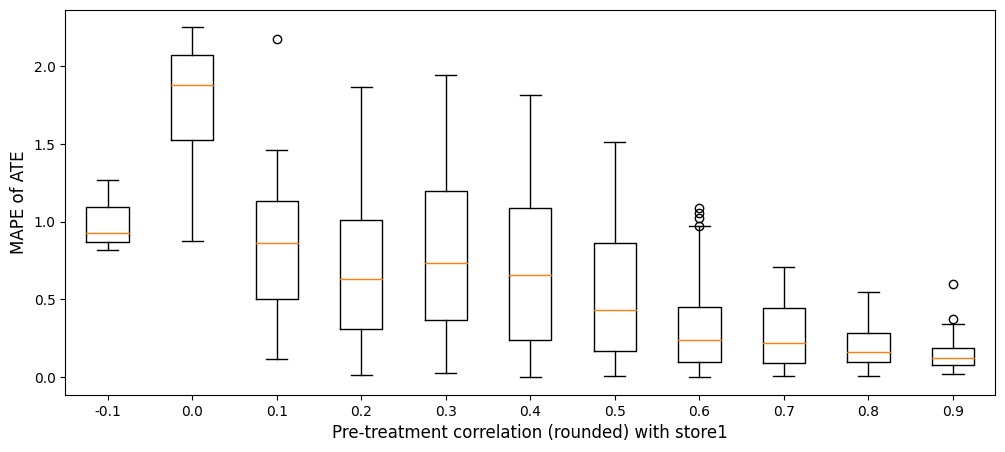

In [26]:
plt.rc('axes', labelsize=12)
plt.figure(figsize=(12,5))
result_corr_dict = results_corr.groupby(['corr_agg'])['rel_effect_diff'].apply(lambda x: list(x)).to_dict()
plt.boxplot(result_corr_dict.values(), labels=result_corr_dict.keys())
plt.xlabel('Pre-treatment correlation (rounded) with store1')
plt.ylabel('MAPE of ATE')

Text(0, 0.5, 'MAPE of ATE')

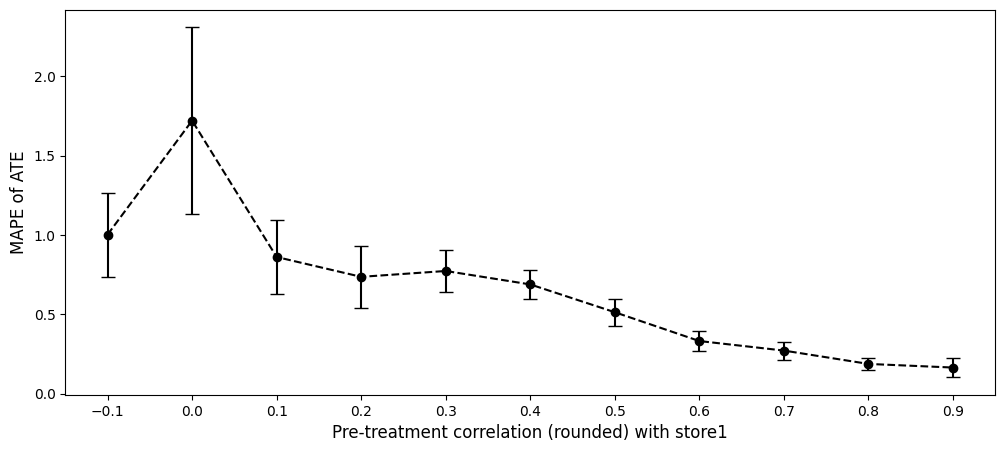

In [27]:
x = list(result_corr_dict.keys())
y = list(result_corr_dict.values())
y_mean = [np.mean(y_values) for y_values in y]
y_sem = [stats.sem(y_values) for y_values in y]
conf_interval = [1.96 * sem for sem in y_sem]

plt.rc('axes', labelsize=12)
plt.figure(figsize=(12,5))
plt.plot(x, y_mean, color='k', linestyle="--")
plt.xticks(x)
for i in range(len(x)):
    plt.errorbar([x[i]], y_mean[i], yerr=conf_interval[i], fmt='o', capsize=5, color='k')
plt.xlabel('Pre-treatment correlation (rounded) with store1')
plt.ylabel('MAPE of ATE')

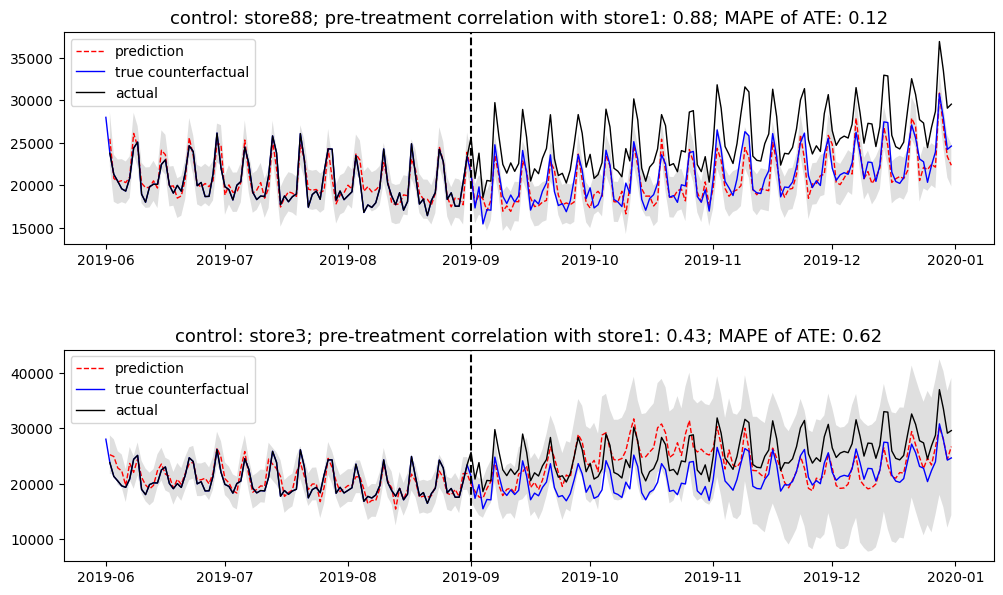

In [30]:
df_sc = df[['store', 'value']].pivot(columns=['store'], values='value')[cols]
df_sc = df_sc.loc[start_date_sc:end_date_sc]
true_cf = df_sc['store1']
ctr_ids = ['store88', 'store3']
data_inter = pd.to_datetime(cutoff_date_sc)

subplot_id = 1
plt.rc('axes', titlesize=13)
plt.figure(figsize=(12,11))
plt.subplots_adjust(hspace=0.5)
for ctr_id in ctr_ids:

  plt.subplot(3, 1, subplot_id)
  subplot_id += 1

  inferences = ci_dict_corr.get(ctr_id).inferences[1::]

  plt.plot(inferences.point_pred, "r--", linewidth=1, label="prediction")
  plt.plot(true_cf, "b", alpha=1, linewidth=1, label="true counterfactual")
  plt.plot(inferences.response, "k", linewidth=1, label="actual")

  plt.axvline(data_inter, c="k", linestyle="--")

  plt.fill_between(
      inferences.index,
      inferences.point_pred_lower,
      inferences.point_pred_upper,
      facecolor="gray",
      interpolate=True,
      alpha=0.25,
  )

  corr = round(corr_dict.get(ctr_id),2)
  rel_effect_diff = round(results_corr.loc[ctr_id]['rel_effect_diff'], 2)
  plt.legend(loc="upper left")
  plt.title(f"control: {ctr_id}; pre-treatment correlation with store1: {corr}; MAPE of ATE: {rel_effect_diff}")

## SC: impact of training window

In [31]:
from dateutil.relativedelta import relativedelta

start_date_months_pre = np.arange(1,9,1)
cutoff_date_sc = '2019-09-01'
end_date_sc = '2019-12-31'
pre_cutoff_date_sc = (pd.to_datetime(cutoff_date_sc) - timedelta(days=1)).strftime('%Y-%m-%d')
post_period = [pd.to_datetime(i) for i in [cutoff_date_sc, end_date_sc]]

tre_id = 'store'+str(1)
df_sc_full = df[['store', 'value']].pivot(columns=['store'], values='value')
df_sc_full.loc[cutoff_date_sc:, tre_id] = df_sc_full.loc[cutoff_date_sc:, tre_id]*1.2

results_window = pd.DataFrame([])
ci_dict_window = dict({})

for i in start_date_months_pre:

  start_date_sc = (pd.to_datetime(cutoff_date_sc) + relativedelta(months=-i)).strftime('%Y-%m-%d')
  pre_period = [pd.to_datetime(i) for i in [start_date_sc, pd.to_datetime(cutoff_date_sc) - timedelta(days=1)]]

  df_sc = df_sc_full.loc[start_date_sc:end_date_sc]
  pre_tre_actual = df_sc[tre_id].loc[start_date_sc:pre_cutoff_date_sc].values

  ci_dict = dict({})
  pre_tre_acc_arr = []
  rel_effect_arr = []
  for ctr_id in range(2,N_groups+1):

    print(f"ctr_id: {ctr_id}")
    ctr_id = 'store'+str(ctr_id)
    cols = [tre_id, ctr_id]

    ci = CausalImpact(df_sc[cols], pre_period, post_period)
    ci.run()
    ci_dict.update({ctr_id: ci})

    summary_path = 'summary_'+ctr_id+'_'+str(i)
    ci.summary(path=summary_path)
    summary = pd.read_csv(summary_path)
    est = summary.loc[7][1].replace('%', '')


    pre_tre_pred = ci.inferences.point_pred.loc[start_date_sc:pre_cutoff_date_sc].values
    pre_tre_acc = mean_absolute_percentage_error(pre_tre_actual, pre_tre_pred)
    rel_effect = float(est)/100

    pre_tre_acc_arr.append(pre_tre_acc)
    rel_effect_arr.append(rel_effect)

  ci_dict_window.update({i: ci_dict})
  results_window = pd.concat([results_window,
                              pd.DataFrame({'window': i,
                              'pre_tre_acc': pre_tre_acc_arr,
                              'rel_effect': rel_effect_arr,
                              'ctr_id': ['store'+str(i) for i in list(range(2,N_groups+1))]
                                            })])


ctr_id: 2
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19962             2435476
95% CI                  [15189, 24736]  [1853065, 3017888]
                                                          
Absolute Effect                   5460              666131
95% CI                    [10233, 686]    [1248543, 83719]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                   [51.3%, 3.4%]       [51.3%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 3
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23900             2915813
95% CI                   [16590, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19426             2370071
95% CI                  [15153, 23700]  [1848733, 2891408]
                                                          
Absolute Effect                   5996              731537
95% CI                   [10269, 1722]   [1252874, 210200]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                   [52.9%, 8.9%]       [52.9%, 8.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 6
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20053             2446539
95% CI                  [16317, 23789]  [19907

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19932             2431782
95% CI                  [15135, 24729]  [1846549, 3017015]
                                                          
Absolute Effect                   5490              669825
95% CI                    [10287, 693]    [1255058, 84593]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                   [51.6%, 3.5%]       [51.6%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 10
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19384             2364924
95% CI                  [14212, 24556]  [1733

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21480             2620607
95% CI                   [15248, 27712]  [1860297, 3380916]
                                                           
Absolute Effect                    3942              481001
95% CI                   [10174, -2289]  [1241311, -279308]
                                                           
Relative Effect                   18.4%               18.4%
95% CI                  [47.4%, -10.7%]     [47.4%, -10.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 14
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22317             2722730
95% CI                   [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20799             2537513
95% CI                  [14988, 26610]  [1828587, 3246438]
                                                          
Absolute Effect                   4623              564095
95% CI                  [10434, -1187]  [1273020, -144830]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                  [50.2%, -5.7%]      [50.2%, -5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 18
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23082             2816050
95% CI                   [15322, 30842]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21873             2668622
95% CI                  [17494, 26253]  [2134291, 3202953]
                                                          
Absolute Effect                   3549              432985
95% CI                    [7928, -830]   [967316, -101345]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [36.2%, -3.8%]      [36.2%, -3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 22
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19497             2378667
95% CI                  [14315, 24678]  [1746

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17698             2159248
95% CI                  [15100, 20296]  [1842285, 2476211]
                                                          
Absolute Effect                   7724              942359
95% CI                   [10322, 5126]   [1259322, 625396]
                                                          
Relative Effect                  43.6%               43.6%
95% CI                  [58.3%, 29.0%]      [58.3%, 29.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 25
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19253             2348931
95% CI                  [16300, 22206]  [1988

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21186             2584771
95% CI                  [16008, 26365]  [1953012, 3216531]
                                                          
Absolute Effect                   4236              516836
95% CI                    [9414, -941]  [1148596, -114922]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                  [44.4%, -4.4%]      [44.4%, -4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 29
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21351             2604903
95% CI                  [18441, 24262]  [2249

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21205             2587042
95% CI                   [14776, 27634]  [1802719, 3371366]
                                                           
Absolute Effect                    4217              514565
95% CI                   [10646, -2211]  [1298888, -269757]
                                                           
Relative Effect                   19.9%               19.9%
95% CI                  [50.2%, -10.4%]     [50.2%, -10.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21391             2609750
95% CI                  [18418, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20298             2476358
95% CI                  [15708, 24887]  [1916457, 3036259]
                                                          
Absolute Effect                   5124              625249
95% CI                     [9714, 535]    [1185150, 65348]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                   [47.9%, 2.6%]       [47.9%, 2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 37
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23363             2850323
95% CI                   [17248, 29478]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17844             2176987
95% CI                  [15481, 20206]  [1888747, 2465226]
                                                          
Absolute Effect                   7578              924621
95% CI                    [9941, 5216]   [1212860, 636381]
                                                          
Relative Effect                  42.5%               42.5%
95% CI                  [55.7%, 29.2%]      [55.7%, 29.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 40
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21441             2615892
95% CI                  [17309, 25573]  [2111

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 43
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19671             2399973
95% CI                  [14899, 24444]  [1817729, 2982217]
                                                          
Absolute Effect                   5751              701635
95% CI                    [10523, 978]   [1283879, 119390]
                                                          
Relative Effect                  29.2%               29.2%
95% CI                   [53.5%, 5.0%]       [53.5%, 5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 44
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21516             2625015
95% CI                   [14222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21666             2643325
95% CI                  [15948, 27385]  [1945673, 3340976]
                                                          
Absolute Effect                   3756              458283
95% CI                   [9474, -1962]  [1155934, -239368]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                  [43.7%, -9.1%]      [43.7%, -9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 48
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20701             2525573
95% CI                  [14512, 26890]  [1770

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20427             2492144
95% CI                  [18391, 22463]  [2243720, 2740567]
                                                          
Absolute Effect                   4995              609464
95% CI                    [7031, 2959]    [857887, 361040]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                  [34.4%, 14.5%]      [34.4%, 14.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 52
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21786             2657946
95% CI                  [17008, 26564]  [2075

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20138             2456871
95% CI                  [17821, 22455]  [2174188, 2739554]
                                                          
Absolute Effect                   5284              644736
95% CI                    [7601, 2967]    [927419, 362053]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                  [37.7%, 14.7%]      [37.7%, 14.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 56
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20386             2487105
95% CI                  [14631, 26140]  [1785

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22629             2760739
95% CI                   [13471, 31786]  [1643531, 3877947]
                                                           
Absolute Effect                    2794              340869
95% CI                   [11951, -6363]  [1458077, -776338]
                                                           
Relative Effect                   12.3%               12.3%
95% CI                  [52.8%, -28.1%]     [52.8%, -28.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 60
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16425             2003954
95% CI                  [13295, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19319             2356960
95% CI                  [14771, 23867]  [1802070, 2911850]
                                                          
Absolute Effect                   6103              744647
95% CI                   [10651, 1555]   [1299538, 189757]
                                                          
Relative Effect                  31.6%               31.6%
95% CI                   [55.1%, 8.1%]       [55.1%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 64
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23739             2896198
95% CI                   [15997, 31481]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18296             2232224
95% CI                  [14073, 22520]  [1716922, 2747525]
                                                          
Absolute Effect                   7126              869384
95% CI                   [11349, 2902]   [1384685, 354082]
                                                          
Relative Effect                  38.9%               38.9%
95% CI                  [62.0%, 15.9%]      [62.0%, 15.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 68
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23903             2916285
95% CI                   [14588, 33219]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20613             2514897
95% CI                  [16283, 24944]  [1986539, 3043255]
                                                          
Absolute Effect                   4809              586711
95% CI                     [9139, 478]    [1115069, 58352]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [44.3%, 2.3%]       [44.3%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 72
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17881             2181531
95% CI                  [15254, 20508]  [1861

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 75
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20752             2531826
95% CI                  [14985, 26520]  [1828208, 3235443]
                                                          
Absolute Effect                   4670              569782
95% CI                  [10437, -1097]  [1273399, -133835]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                  [50.3%, -5.3%]      [50.3%, -5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 76
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18027             2199389
95% CI                  [14932, 21

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23131             2821986
95% CI                   [17752, 28509]  [2165793, 3478179]
                                                           
Absolute Effect                    2291              279621
95% CI                    [7670, -3086]   [935814, -376571]
                                                           
Relative Effect                    9.9%                9.9%
95% CI                  [33.2%, -13.3%]     [33.2%, -13.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 79
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19505             2379701
95% CI                  [15298, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20054             2446630
95% CI                  [15341, 24767]  [1871647, 3021614]
                                                          
Absolute Effect                   5368              654977
95% CI                    [10081, 655]    [1229960, 79993]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                   [50.3%, 3.3%]       [50.3%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 83
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18347             2238446
95% CI                  [15590, 21104]  [1902

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22892             2792914
95% CI                   [16572, 29213]  [2021819, 3564008]
                                                           
Absolute Effect                    2530              308694
95% CI                    [8850, -3790]  [1079788, -462400]
                                                           
Relative Effect                   11.1%               11.1%
95% CI                  [38.7%, -16.6%]     [38.7%, -16.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 87
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20392             2487843
95% CI                  [16637, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19873             2424567
95% CI                  [15071, 24675]  [1838761, 3010372]
                                                          
Absolute Effect                   5549              677041
95% CI                    [10351, 747]    [1262846, 91235]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                   [52.1%, 3.8%]       [52.1%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 91
                                Average           Cumulative
Actual                            25423              3101608
Predicted                         25491              3109918
95% CI                   [12210, 38771]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22313             2722188
95% CI                   [16351, 28274]  [1994900, 3449475]
                                                           
Absolute Effect                    3109              379419
95% CI                    [9071, -2851]  [1106707, -347867]
                                                           
Relative Effect                   13.9%               13.9%
95% CI                  [40.7%, -12.8%]     [40.7%, -12.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 95
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22875             2790787
95% CI                   [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 101
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18104             2208714
95% CI                  [13686, 22521]  [1669777, 2747651]
                                                          
Absolute Effect                   7318              892894
95% CI                   [11736, 2901]   [1431831, 353956]
                                                          
Relative Effect                  40.4%               40.4%
95% CI                  [64.8%, 16.0%]      [64.8%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 102
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20395             2488257
95% CI                  [18583, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20355             2483393
95% CI                  [16970, 23740]  [2070426, 2896360]
                                                          
Absolute Effect                   5067              618214
95% CI                    [8452, 1682]   [1031181, 205247]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                   [41.5%, 8.3%]       [41.5%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 105
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19662             2398838
95% CI                  [17516, 21808]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19177             2339651
95% CI                  [15549, 22804]  [1897096, 2782205]
                                                          
Absolute Effect                   6245              761957
95% CI                    [9873, 2618]   [1204511, 319402]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                  [51.5%, 13.7%]      [51.5%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 108
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17617             2149377
95% CI                  [13220, 22015]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17933             2187881
95% CI                  [15815, 20051]  [1929528, 2446234]
                                                          
Absolute Effect                   7489              913726
95% CI                    [9607, 5371]   [1172079, 655374]
                                                          
Relative Effect                  41.8%               41.8%
95% CI                  [53.6%, 30.0%]      [53.6%, 30.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 111
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19655             2398000
95% CI                  [16019, 23292]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22830             2785274
95% CI                   [13834, 31825]  [1687869, 3882679]
                                                           
Absolute Effect                    2592              316333
95% CI                   [11588, -6402]  [1413738, -781071]
                                                           
Relative Effect                   11.4%               11.4%
95% CI                  [50.8%, -28.0%]     [50.8%, -28.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 114
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21332             2602625
95% CI                  [18258,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21560             2630347
95% CI                   [15251, 27869]  [1860669, 3400024]
                                                           
Absolute Effect                    3862              471261
95% CI                   [10171, -2446]  [1240938, -298416]
                                                           
Relative Effect                   17.9%               17.9%
95% CI                  [47.2%, -11.3%]     [47.2%, -11.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 118
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20641             2518259
95% CI                  [15842,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18686             2279704
95% CI                  [16130, 21241]  [1967952, 2591457]
                                                          
Absolute Effect                   6736              821903
95% CI                    [9292, 4181]   [1133655, 510150]
                                                          
Relative Effect                  36.1%               36.1%
95% CI                  [49.7%, 22.4%]      [49.7%, 22.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 122
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20967             2558081
95% CI                  [14523, 27412]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17134             2090417
95% CI                  [13613, 20655]  [1660886, 2519948]
                                                          
Absolute Effect                   8288             1011191
95% CI                   [11809, 4767]   [1440722, 581660]
                                                          
Relative Effect                  48.4%               48.4%
95% CI                  [68.9%, 27.8%]      [68.9%, 27.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 126
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22306             2721383
95% CI                   [15021, 29591]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20238             2469137
95% CI                  [15406, 25071]  [1879547, 3058727]
                                                          
Absolute Effect                   5184              632470
95% CI                    [10016, 351]    [1222060, 42880]
                                                          
Relative Effect                  25.6%               25.6%
95% CI                   [49.5%, 1.7%]       [49.5%, 1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 129
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19168             2338613
95% CI                  [16766, 21570]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19804             2416174
95% CI                  [16975, 22634]  [2070994, 2761354]
                                                          
Absolute Effect                   5618              685433
95% CI                    [8447, 2788]   [1030613, 340254]
                                                          
Relative Effect                  28.4%               28.4%
95% CI                  [42.7%, 14.1%]      [42.7%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 132
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20968             2558179
95% CI                  [16504, 25433]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 136
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20481             2498799
95% CI                  [15935, 25028]  [1944147, 3053451]
                                                          
Absolute Effect                   4941              602808
95% CI                     [9487, 394]    [1157461, 48156]
                                                          
Relative Effect                  24.1%               24.1%
95% CI                   [46.3%, 1.9%]       [46.3%, 1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 137
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15584             1901328
95% CI                  [12634, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19352             2360978
95% CI                  [16086, 22617]  [1962583, 2759373]
                                                          
Absolute Effect                   6070              740629
95% CI                    [9336, 2805]   [1139025, 342234]
                                                          
Relative Effect                  31.4%               31.4%
95% CI                  [48.2%, 14.5%]      [48.2%, 14.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 139
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19260             2349838
95% CI                  [14514, 24007]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23597             2878840
95% CI                  [20356, 26837]  [2483536, 3274144]
                                                          
Absolute Effect                   1825              222767
95% CI                   [5066, -1414]   [618072, -172536]
                                                          
Relative Effect                   7.7%                7.7%
95% CI                  [21.5%, -6.0%]      [21.5%, -6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 142
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19901             2427964
95% CI                  [15097, 24705]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20768             2533752
95% CI                  [15910, 25626]  [1941024, 3126481]
                                                          
Absolute Effect                   4654              567855
95% CI                    [9512, -203]   [1160584, -24873]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                  [45.8%, -1.0%]      [45.8%, -1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 144
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18713             2282986
95% CI                  [15875, 21550]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20543             2506316
95% CI                  [17263, 23823]  [2106203, 2906429]
                                                          
Absolute Effect                   4879              595291
95% CI                    [8159, 1599]    [995404, 195179]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                   [39.7%, 7.8%]       [39.7%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 147
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18163             2215997
95% CI                  [16340, 19987]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21703             2647798
95% CI                  [18679, 24727]  [2278897, 3016699]
                                                          
Absolute Effect                   3719              453809
95% CI                     [6743, 695]     [822710, 84909]
                                                          
Relative Effect                  17.1%               17.1%
95% CI                   [31.1%, 3.2%]       [31.1%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 150
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17998             2195863
95% CI                  [15939, 20058]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18750             2287602
95% CI                  [16026, 21475]  [1955189, 2620015]
                                                          
Absolute Effect                   6672              814005
95% CI                    [9396, 3947]   [1146418, 481592]
                                                          
Relative Effect                  35.6%               35.6%
95% CI                  [50.1%, 21.1%]      [50.1%, 21.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 153
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18358             2239770
95% CI                  [15647, 21069]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23667             2887427
95% CI                   [16063, 31271]  [1959716, 3815139]
                                                           
Absolute Effect                    1755              214180
95% CI                    [9359, -5848]  [1141891, -713530]
                                                           
Relative Effect                    7.4%                7.4%
95% CI                  [39.5%, -24.7%]     [39.5%, -24.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 157
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21923             2674626
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16968             2070199
95% CI                  [14683, 19253]  [1791415, 2348984]
                                                          
Absolute Effect                   8454             1031408
95% CI                   [10739, 6169]   [1310192, 752624]
                                                          
Relative Effect                  49.8%               49.8%
95% CI                  [63.3%, 36.4%]      [63.3%, 36.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 161
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17878             2181186
95% CI                  [15596, 20160]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18766             2289544
95% CI                  [14123, 23410]  [1723041, 2856047]
                                                          
Absolute Effect                   6656              812063
95% CI                   [11299, 2012]   [1378566, 245560]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                  [60.2%, 10.7%]      [60.2%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 165
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17142             2091435
95% CI                  [14448, 19837]  [176

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20156             2459105
95% CI                  [16791, 23521]  [2048557, 2869654]
                                                          
Absolute Effect                   5266              642502
95% CI                    [8631, 1901]   [1053050, 231954]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [42.8%, 9.4%]       [42.8%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 168
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22187             2706821
95% CI                  [18158, 26215]  [221

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17617             2149347
95% CI                  [14302, 20933]  [1744854, 2553840]
                                                          
Absolute Effect                   7805              952260
95% CI                   [11120, 4489]   [1356753, 547767]
                                                          
Relative Effect                  44.3%               44.3%
95% CI                  [63.1%, 25.5%]      [63.1%, 25.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 172
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21348             2604573
95% CI                  [15223, 27474]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 175
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19890             2426595
95% CI                  [15255, 24525]  [1861122, 2992068]
                                                          
Absolute Effect                   5532              675012
95% CI                    [10167, 897]   [1240485, 109539]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                   [51.1%, 4.5%]       [51.1%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 176
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18512             2258529
95% CI                  [16574, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21570             2631618
95% CI                  [16848, 26292]  [2055507, 3207729]
                                                          
Absolute Effect                   3852              469989
95% CI                    [8574, -869]  [1046100, -106121]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                  [39.8%, -4.0%]      [39.8%, -4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 180
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22550             2751119
95% CI                   [16804, 28295]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19113             2331851
95% CI                  [14914, 23312]  [1819555, 2844147]
                                                          
Absolute Effect                   6309              769757
95% CI                   [10508, 2110]   [1282053, 257460]
                                                          
Relative Effect                  33.0%               33.0%
95% CI                  [55.0%, 11.0%]      [55.0%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 184
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18170             2216763
95% CI                  [15844, 20495]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17045             2079573
95% CI                  [14651, 19440]  [1787440, 2371705]
                                                          
Absolute Effect                   8377             1022035
95% CI                   [10771, 5982]   [1314167, 729902]
                                                          
Relative Effect                  49.1%               49.1%
95% CI                  [63.2%, 35.1%]      [63.2%, 35.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 191
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21113             2575833
95% CI                  [18661, 23565]  [227

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20617             2515335
95% CI                  [17485, 23749]  [2133206, 2897463]
                                                          
Absolute Effect                   4805              586273
95% CI                    [7937, 1673]    [968402, 204144]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [38.5%, 8.1%]       [38.5%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 195
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19356             2361484
95% CI                  [16507, 22205]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21452             2617254
95% CI                  [15530, 27375]  [1894675, 3339833]
                                                          
Absolute Effect                   3970              484354
95% CI                   [9892, -1952]  [1206933, -238225]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                  [46.1%, -9.1%]      [46.1%, -9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18445             2250366
95% CI                  [14809, 22082]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19563             2386694
95% CI                  [14773, 24353]  [1802321, 2971068]
                                                          
Absolute Effect                   5859              714913
95% CI                   [10649, 1070]   [1299287, 130540]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                   [54.4%, 5.5%]       [54.4%, 5.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 203
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17115             2088085
95% CI                  [13858, 20372]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21605             2635844
95% CI                  [18217, 24993]  [2222491, 3049197]
                                                          
Absolute Effect                   3817              465763
95% CI                     [7205, 429]     [879116, 52410]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                   [33.4%, 2.0%]       [33.4%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 207
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20388             2487415
95% CI                  [17400, 23377]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24258             2959593
95% CI                   [16882, 31635]  [2059690, 3859495]
                                                           
Absolute Effect                    1164              142015
95% CI                    [8540, -6212]  [1041917, -757887]
                                                           
Relative Effect                    4.8%                4.8%
95% CI                  [35.2%, -25.6%]     [35.2%, -25.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 211
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19627             2394511
95% CI                  [14654,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17870             2180144
95% CI                  [14839, 20900]  [1810384, 2549904]
                                                          
Absolute Effect                   7552              921463
95% CI                   [10583, 4522]   [1291224, 551703]
                                                          
Relative Effect                  42.3%               42.3%
95% CI                  [59.2%, 25.3%]      [59.2%, 25.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 215
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19551             2385260
95% CI                  [14383, 24719]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20535             2505316
95% CI                  [15398, 25671]  [1878650, 3131982]
                                                          
Absolute Effect                   4887              596291
95% CI                   [10024, -248]   [1222958, -30374]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [48.8%, -1.2%]      [48.8%, -1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 219
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20090             2451087
95% CI                  [16339, 23842]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19992             2439092
95% CI                  [15367, 24617]  [1874859, 3003326]
                                                          
Absolute Effect                   5430              662515
95% CI                    [10055, 805]    [1226749, 98281]
                                                          
Relative Effect                  27.2%               27.2%
95% CI                   [50.3%, 4.0%]       [50.3%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 223
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20197             2464068
95% CI                  [15983, 24411]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20378             2486189
95% CI                  [17300, 23457]  [2110613, 2861765]
                                                          
Absolute Effect                   5044              615419
95% CI                    [8122, 1965]    [990995, 239843]
                                                          
Relative Effect                  24.8%               24.8%
95% CI                   [39.9%, 9.6%]       [39.9%, 9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 227
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19051             2324256
95% CI                  [16922, 21179]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21230             2590119
95% CI                   [14072, 28388]  [1716852, 3463386]
                                                           
Absolute Effect                    4192              511488
95% CI                   [11350, -2965]  [1384755, -361777]
                                                           
Relative Effect                   19.7%               19.7%
95% CI                  [53.5%, -14.0%]     [53.5%, -14.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 231
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18201             2220620
95% CI                  [14650,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20657             2520192
95% CI                  [14082, 27231]  [1718088, 3322295]
                                                          
Absolute Effect                   4765              581416
95% CI                  [11340, -1808]  [1383519, -220687]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [54.9%, -8.8%]      [54.9%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 235
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19491             2377957
95% CI                  [15419, 23563]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22307             2721547
95% CI                   [16855, 27760]  [2056329, 3386766]
                                                           
Absolute Effect                    3115              380060
95% CI                    [8567, -2337]  [1045278, -285158]
                                                           
Relative Effect                   14.0%               14.0%
95% CI                  [38.4%, -10.5%]     [38.4%, -10.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 239
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17378             2120178
95% CI                  [14833,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21148             2580161
95% CI                  [15945, 26351]  [1945385, 3214937]
                                                          
Absolute Effect                   4274              521446
95% CI                    [9477, -928]  [1156222, -113329]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [44.8%, -4.4%]      [44.8%, -4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 243
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20712             2526892
95% CI                  [16331, 25092]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20982             2559819
95% CI                  [18385, 23578]  [2243069, 2876568]
                                                          
Absolute Effect                   4440              541789
95% CI                    [7037, 1844]    [858539, 225039]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                   [33.5%, 8.8%]       [33.5%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 247
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20678             2522814
95% CI                  [17700, 23656]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16707             2038314
95% CI                  [13068, 20346]  [1594357, 2482270]
                                                          
Absolute Effect                   8715             1063294
95% CI                   [12354, 5076]   [1507250, 619337]
                                                          
Relative Effect                  52.2%               52.2%
95% CI                  [73.9%, 30.4%]      [73.9%, 30.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 251
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21910             2673067
95% CI                   [14567, 29253]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 254
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17212             2099912
95% CI                  [14439, 19985]  [1761590, 2438235]
                                                          
Absolute Effect                   8210             1001695
95% CI                   [10983, 5437]   [1340017, 663373]
                                                          
Relative Effect                  47.7%               47.7%
95% CI                  [63.8%, 31.6%]      [63.8%, 31.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 255
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18294             2231935
95% CI                  [15622, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20244             2469777
95% CI                   [12395, 28092]  [1512279, 3427274]
                                                           
Absolute Effect                    5178              631831
95% CI                   [13027, -2669]  [1589328, -325666]
                                                           
Relative Effect                   25.6%               25.6%
95% CI                  [64.4%, -13.2%]     [64.4%, -13.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 258
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18122             2210992
95% CI                  [13761,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19348             2360562
95% CI                  [15010, 23687]  [1831290, 2889835]
                                                          
Absolute Effect                   6074              741045
95% CI                   [10412, 1735]   [1270317, 211773]
                                                          
Relative Effect                  31.4%               31.4%
95% CI                   [53.8%, 9.0%]       [53.8%, 9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 262
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21684             2645474
95% CI                  [17434, 25933]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18367             2240774
95% CI                  [13905, 22828]  [1696432, 2785116]
                                                          
Absolute Effect                   7056              860834
95% CI                   [11517, 2594]   [1405176, 316491]
                                                          
Relative Effect                  38.4%               38.4%
95% CI                  [62.7%, 14.1%]      [62.7%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 266
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21989             2682706
95% CI                   [15905, 28072]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16355             1995400
95% CI                  [14003, 18708]  [1708398, 2282403]
                                                          
Absolute Effect                   9067             1106207
95% CI                   [11419, 6714]   [1393210, 819204]
                                                          
Relative Effect                  55.4%               55.4%
95% CI                  [69.8%, 41.1%]      [69.8%, 41.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 269
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17250             2104582
95% CI                  [14291, 20209]  [174

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17635             2151552
95% CI                  [13646, 21624]  [1664867, 2638236]
                                                          
Absolute Effect                   7787              950056
95% CI                   [11776, 3798]   [1436740, 463371]
                                                          
Relative Effect                  44.2%               44.2%
95% CI                  [66.8%, 21.5%]      [66.8%, 21.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 271
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21210             2587700
95% CI                  [16828, 25593]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15863             1935336
95% CI                  [11713, 20013]  [1429024, 2441648]
                                                          
Absolute Effect                   9559             1166271
95% CI                   [13709, 5409]   [1672583, 659959]
                                                          
Relative Effect                  60.3%               60.3%
95% CI                  [86.4%, 34.1%]      [86.4%, 34.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 274
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21025             2565135
95% CI                  [14578, 27472]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 275
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18979             2315522
95% CI                  [14386, 23573]  [1755096, 2875948]
                                                          
Absolute Effect                   6443              786085
95% CI                   [11036, 1849]   [1346511, 225659]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                   [58.2%, 9.7%]       [58.2%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 276


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20960             2557163
95% CI                  [17104, 24815]  [2086788, 3027539]
                                                          
Absolute Effect                   4462              544444
95% CI                     [8318, 607]    [1014820, 74068]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [39.7%, 2.9%]       [39.7%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 277
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22273             2717311
95% CI                  [17851, 26694]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21439             2615660
95% CI                  [16415, 26464]  [2002674, 3228647]
                                                          
Absolute Effect                   3983              485947
95% CI                   [9007, -1041]  [1098934, -127039]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [42.0%, -4.9%]      [42.0%, -4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 279
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20319             2478936
95% CI                  [14455, 26183]  [176

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20437             2493399
95% CI                  [15884, 24991]  [1937876, 3048923]
                                                          
Absolute Effect                   4985              608208
95% CI                     [9538, 431]    [1163731, 52685]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                   [46.7%, 2.1%]       [46.7%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 282
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23119             2820533
95% CI                   [15192, 31045]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21394             2610105
95% CI                   [14811, 27976]  [1807045, 3413166]
                                                           
Absolute Effect                    4028              491502
95% CI                   [10611, -2553]  [1294563, -311557]
                                                           
Relative Effect                   18.8%               18.8%
95% CI                  [49.6%, -11.9%]     [49.6%, -11.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 284
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22160             2703548
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22887             2792332
95% CI                   [14982, 30793]  [1827839, 3756826]
                                                           
Absolute Effect                    2535              309275
95% CI                   [10440, -5370]  [1273768, -655217]
                                                           
Relative Effect                   11.1%               11.1%
95% CI                  [45.6%, -23.5%]     [45.6%, -23.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 286
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19775             2412627
95% CI                  [15499,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15868             1935987
95% CI                  [12576, 19161]  [1534309, 2337664]
                                                          
Absolute Effect                   9554             1165620
95% CI                   [12846, 6261]   [1567298, 763943]
                                                          
Relative Effect                  60.2%               60.2%
95% CI                  [81.0%, 39.5%]      [81.0%, 39.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 288


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19566             2387122
95% CI                  [14914, 24219]  [1819508, 2954735]
                                                          
Absolute Effect                   5856              714485
95% CI                   [10509, 1203]   [1282099, 146872]
                                                          
Relative Effect                  29.9%               29.9%
95% CI                   [53.7%, 6.2%]       [53.7%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 289
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18430             2248516
95% CI                  [15220, 21640]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21616             2637201
95% CI                  [18142, 25090]  [2213328, 3061074]
                                                          
Absolute Effect                   3806              464406
95% CI                     [7280, 332]     [888280, 40533]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                   [33.7%, 1.5%]       [33.7%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 291
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19773             2412345
95% CI                  [15223, 24322]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21423             2613637
95% CI                  [15587, 27259]  [1901619, 3325656]
                                                          
Absolute Effect                   3999              487970
95% CI                   [9835, -1836]  [1199988, -224047]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [45.9%, -8.6%]      [45.9%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 294
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20887             2548278
95% CI                  [17729, 24045]  [216

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18862             2301231
95% CI                  [15959, 21765]  [1947024, 2655439]
                                                          
Absolute Effect                   6560              800376
95% CI                    [9463, 3657]   [1154584, 446168]
                                                          
Relative Effect                  34.8%               34.8%
95% CI                  [50.2%, 19.4%]      [50.2%, 19.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 297
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19785             2413808
95% CI                  [15048, 24522]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23258             2837527
95% CI                   [18182, 28334]  [2218248, 3456805]
                                                           
Absolute Effect                    2164              264080
95% CI                    [7240, -2911]   [883359, -355197]
                                                           
Relative Effect                    9.3%                9.3%
95% CI                  [31.1%, -12.5%]     [31.1%, -12.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 300
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17684             2157462
95% CI                  [15120,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21261             2593961
95% CI                  [15432, 27091]  [1882720, 3305203]
                                                          
Absolute Effect                   4161              507646
95% CI                   [9990, -1668]  [1218887, -203595]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                  [47.0%, -7.8%]      [47.0%, -7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 303
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17831             2175432
95% CI                  [15194, 20468]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22075             2693267
95% CI                   [15021, 29129]  [1832677, 3553856]
                                                           
Absolute Effect                    3347              408341
95% CI                   [10401, -3706]  [1268930, -452248]
                                                           
Relative Effect                   15.2%               15.2%
95% CI                  [47.1%, -16.8%]     [47.1%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 306
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19592             2390302
95% CI                  [16062,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21568             2631339
95% CI                  [15774, 27362]  [1924443, 3338235]
                                                          
Absolute Effect                   3854              470268
95% CI                   [9648, -1939]  [1177164, -236627]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                  [44.7%, -9.0%]      [44.7%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 308
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19838             2420276
95% CI                  [15085, 24590]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21200             2586413
95% CI                  [18348, 24051]  [2238566, 2934260]
                                                          
Absolute Effect                   4222              515194
95% CI                    [7074, 1371]    [863041, 167348]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                   [33.4%, 6.5%]       [33.4%, 6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 311
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21350             2604768
95% CI                  [17175, 25525]  [209

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19944             2433203
95% CI                  [17250, 22638]  [2104571, 2761836]
                                                          
Absolute Effect                   5478              668404
95% CI                    [8172, 2785]    [997037, 339771]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                  [41.0%, 14.0%]      [41.0%, 14.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 314
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17438             2127474
95% CI                  [13749, 21126]  [167

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17648             2153071
95% CI                  [13799, 21496]  [1683526, 2622616]
                                                          
Absolute Effect                   7774              948536
95% CI                   [11623, 3926]   [1418081, 478992]
                                                          
Relative Effect                  44.1%               44.1%
95% CI                  [65.9%, 22.2%]      [65.9%, 22.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 317
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18822             2296400
95% CI                  [16884, 20761]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21739             2652171
95% CI                  [17912, 25566]  [2185287, 3119056]
                                                          
Absolute Effect                   3683              449436
95% CI                    [7510, -143]    [916320, -17447]
                                                          
Relative Effect                  16.9%               16.9%
95% CI                  [34.5%, -0.7%]      [34.5%, -0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 320
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22257             2715407
95% CI                   [15612, 28902]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21209             2587593
95% CI                  [18271, 24148]  [2229063, 2946123]
                                                          
Absolute Effect                   4213              514014
95% CI                    [7152, 1274]    [872544, 155484]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                   [33.7%, 6.0%]       [33.7%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 322
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18617             2271393
95% CI                  [15142, 22093]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20076             2449335
95% CI                  [14248, 25904]  [1738370, 3160300]
                                                          
Absolute Effect                   5346              652272
95% CI                   [11174, -481]   [1363237, -58692]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                  [55.7%, -2.4%]      [55.7%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 326
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21333             2602636
95% CI                  [18731, 23934]  [228

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21858             2666788
95% CI                  [16156, 27561]  [1971053, 3362523]
                                                          
Absolute Effect                   3564              434820
95% CI                   [9266, -2138]  [1130555, -260915]
                                                          
Relative Effect                  16.3%               16.3%
95% CI                  [42.4%, -9.8%]      [42.4%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 330
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22327             2723928
95% CI                   [16571, 28082]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18562             2264661
95% CI                  [15162, 21962]  [1849884, 2679438]
                                                          
Absolute Effect                   6860              836946
95% CI                   [10260, 3460]   [1251723, 422169]
                                                          
Relative Effect                  37.0%               37.0%
95% CI                  [55.3%, 18.6%]      [55.3%, 18.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 334
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19416             2368859
95% CI                  [14612, 24221]  [178

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21545             2628533
95% CI                   [14192, 28898]  [1731472, 3525593]
                                                           
Absolute Effect                    3877              473075
95% CI                   [11230, -3475]  [1370135, -423985]
                                                           
Relative Effect                   18.0%               18.0%
95% CI                  [52.1%, -16.1%]     [52.1%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 338
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18576             2266290
95% CI                  [14935,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19795             2415063
95% CI                  [15636, 23955]  [1907612, 2922515]
                                                          
Absolute Effect                   5627              686544
95% CI                    [9786, 1467]   [1193996, 179093]
                                                          
Relative Effect                  28.4%               28.4%
95% CI                   [49.4%, 7.4%]       [49.4%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 342
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21314             2600407
95% CI                   [15057, 27572]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22106             2697047
95% CI                   [15465, 28748]  [1886741, 3507353]
                                                           
Absolute Effect                    3316              404560
95% CI                    [9957, -3325]  [1214866, -405745]
                                                           
Relative Effect                   15.0%               15.0%
95% CI                  [45.0%, -15.0%]     [45.0%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20397             2488540
95% CI                  [17043,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16645             2030796
95% CI                  [14501, 18790]  [1769123, 2292468]
                                                          
Absolute Effect                   8777             1070812
95% CI                   [10922, 6632]   [1332484, 809139]
                                                          
Relative Effect                  52.7%               52.7%
95% CI                  [65.6%, 39.8%]      [65.6%, 39.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 350
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18330             2236343
95% CI                  [14187, 22473]  [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21106             2574957
95% CI                  [16773, 25438]  [2046389, 3103525]
                                                          
Absolute Effect                   4316              526651
95% CI                     [8649, -15]    [1055219, -1916]
                                                          
Relative Effect                  20.5%               20.5%
95% CI                  [41.0%, -0.1%]      [41.0%, -0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 354
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22034             2688205
95% CI                   [13073, 30995]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17051             2080278
95% CI                  [13877, 20225]  [1693037, 2467519]
                                                          
Absolute Effect                   8371             1021329
95% CI                   [11545, 5197]   [1408570, 634088]
                                                          
Relative Effect                  49.1%               49.1%
95% CI                  [67.7%, 30.5%]      [67.7%, 30.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 358
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21375             2607754
95% CI                  [18119, 24630]  [221

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18265             2228420
95% CI                  [13756, 22774]  [1678291, 2778549]
                                                          
Absolute Effect                   7157              873187
95% CI                   [11666, 2648]   [1423316, 323059]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                  [63.9%, 14.5%]      [63.9%, 14.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 362
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19640             2396191
95% CI                  [15507, 23774]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20856             2544548
95% CI                  [16681, 25032]  [2035189, 3053907]
                                                          
Absolute Effect                   4566              557059
95% CI                     [8741, 390]    [1066418, 47700]
                                                          
Relative Effect                  21.9%               21.9%
95% CI                   [41.9%, 1.9%]       [41.9%, 1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 366
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21381             2608484
95% CI                  [16522, 26239]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17603             2147572
95% CI                  [15213, 19992]  [1856077, 2439066]
                                                          
Absolute Effect                   7819              954036
95% CI                   [10209, 5430]   [1245530, 662541]
                                                          
Relative Effect                  44.4%               44.4%
95% CI                  [58.0%, 30.9%]      [58.0%, 30.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 370
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20916             2551790
95% CI                  [15661, 26171]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17959             2191058
95% CI                  [14399, 21519]  [1756742, 2625374]
                                                          
Absolute Effect                   7463              910550
95% CI                   [11023, 3903]   [1344866, 476234]
                                                          
Relative Effect                  41.6%               41.6%
95% CI                  [61.4%, 21.7%]      [61.4%, 21.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 374
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18219             2222787
95% CI                  [15548, 20890]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20514             2502717
95% CI                  [15143, 25884]  [1847479, 3157955]
                                                          
Absolute Effect                   4908              598890
95% CI                   [10279, -461]   [1254128, -56347]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                  [50.1%, -2.3%]      [50.1%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 377
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20791             2536521
95% CI                  [15015, 26566]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22903             2794271
95% CI                   [16167, 29640]  [1972446, 3616096]
                                                           
Absolute Effect                    2519              307336
95% CI                    [9255, -4217]  [1129161, -514488]
                                                           
Relative Effect                   11.0%               11.0%
95% CI                  [40.4%, -18.4%]     [40.4%, -18.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 381
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17520             2137462
95% CI                  [14580,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16419             2003227
95% CI                  [13534, 19305]  [1651233, 2355221]
                                                          
Absolute Effect                   9003             1098380
95% CI                   [11888, 6117]   [1450374, 746386]
                                                          
Relative Effect                  54.8%               54.8%
95% CI                  [72.4%, 37.3%]      [72.4%, 37.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 385
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22642             2762390
95% CI                  [19805, 25479]  [241

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18335             2236985
95% CI                  [16202, 20469]  [1976718, 2497252]
                                                          
Absolute Effect                   7087              864622
95% CI                    [9220, 4953]   [1124889, 604355]
                                                          
Relative Effect                  38.7%               38.7%
95% CI                  [50.3%, 27.0%]      [50.3%, 27.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 389
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17821             2174253
95% CI                  [13779, 21864]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20878             2547144
95% CI                   [11818, 29937]  [1441867, 3652422]
                                                           
Absolute Effect                    4544              554463
95% CI                   [13604, -4514]  [1659740, -550813]
                                                           
Relative Effect                   21.8%               21.8%
95% CI                  [65.2%, -21.6%]     [65.2%, -21.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 393
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20888             2548409
95% CI                  [15328,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22522             2747705
95% CI                   [15882, 29161]  [1937706, 3557703]
                                                           
Absolute Effect                    2900              353903
95% CI                    [9540, -3738]  [1163901, -456095]
                                                           
Relative Effect                   12.9%               12.9%
95% CI                  [42.4%, -16.6%]     [42.4%, -16.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 400
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18736             2285860
95% CI                  [15970,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21100             2574205
95% CI                   [13603, 28596]  [1659631, 3488779]
                                                           
Absolute Effect                    4322              527402
95% CI                   [11819, -3173]  [1441977, -387171]
                                                           
Relative Effect                   20.5%               20.5%
95% CI                  [56.0%, -15.0%]     [56.0%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 404
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22415             2734735
95% CI                   [13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18783             2291630
95% CI                  [16487, 21079]  [2011522, 2571737]
                                                          
Absolute Effect                   6639              809978
95% CI                    [8935, 4343]   [1090085, 529870]
                                                          
Relative Effect                  35.3%               35.3%
95% CI                  [47.6%, 23.1%]      [47.6%, 23.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 408
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22649             2763200
95% CI                   [14152, 31146]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17883             2181747
95% CI                  [15297, 20468]  [1866333, 2497160]
                                                          
Absolute Effect                   7539              919861
95% CI                   [10125, 4954]   [1235274, 604447]
                                                          
Relative Effect                  42.2%               42.2%
95% CI                  [56.6%, 27.7%]      [56.6%, 27.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 412
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23035             2810277
95% CI                   [17439, 28630]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         19928             2431254
95% CI                   [12085, 27771]  [1474391, 3388118]
                                                           
Absolute Effect                    5494              670353
95% CI                   [13337, -2348]  [1627216, -286509]
                                                           
Relative Effect                   27.6%               27.6%
95% CI                  [66.9%, -11.8%]     [66.9%, -11.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 416
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19491             2377938
95% CI                  [14974,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19942             2432977
95% CI                  [16022, 23862]  [1954704, 2911250]
                                                          
Absolute Effect                   5480              668630
95% CI                    [9400, 1560]   [1146904, 190357]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                   [47.1%, 7.8%]       [47.1%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 420
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21216             2588393
95% CI                   [14863, 27569]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17415             2124650
95% CI                  [13978, 20851]  [1705413, 2543887]
                                                          
Absolute Effect                   8007              976957
95% CI                   [11444, 4571]   [1396195, 557720]
                                                          
Relative Effect                  46.0%               46.0%
95% CI                  [65.7%, 26.2%]      [65.7%, 26.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 424
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21485             2621255
95% CI                  [16178, 26792]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17696             2158948
95% CI                  [15436, 19955]  [1883280, 2434617]
                                                          
Absolute Effect                   7726              942659
95% CI                    [9986, 5467]   [1218328, 666990]
                                                          
Relative Effect                  43.7%               43.7%
95% CI                  [56.4%, 30.9%]      [56.4%, 30.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 427
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23585             2877439
95% CI                   [15113, 32057]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21591             2634216
95% CI                   [15392, 27791]  [1877852, 3390579]
                                                           
Absolute Effect                    3831              467391
95% CI                   [10030, -2368]  [1223755, -288971]
                                                           
Relative Effect                   17.7%               17.7%
95% CI                  [46.5%, -11.0%]     [46.5%, -11.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 431
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21215             2588280
95% CI                   [13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20250             2470603
95% CI                  [15785, 24716]  [1925785, 3015420]
                                                          
Absolute Effect                   5172              631004
95% CI                     [9637, 706]    [1175822, 86187]
                                                          
Relative Effect                  25.5%               25.5%
95% CI                   [47.6%, 3.5%]       [47.6%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 435
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19994             2439372
95% CI                  [16015, 23973]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18114             2209986
95% CI                  [15343, 20885]  [1871893, 2548080]
                                                          
Absolute Effect                   7308              891621
95% CI                   [10079, 4537]   [1229714, 553528]
                                                          
Relative Effect                  40.3%               40.3%
95% CI                  [55.6%, 25.0%]      [55.6%, 25.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 439
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20206             2465199
95% CI                  [16968, 23444]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22852             2788060
95% CI                   [17234, 28471]  [2102606, 3473513]
                                                           
Absolute Effect                    2570              313547
95% CI                    [8188, -3048]   [999001, -371905]
                                                           
Relative Effect                   11.2%               11.2%
95% CI                  [35.8%, -13.3%]     [35.8%, -13.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 443
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19851             2421897
95% CI                  [16213,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17844             2177017
95% CI                  [14755, 20933]  [1800155, 2553879]
                                                          
Absolute Effect                   7578              924590
95% CI                   [10667, 4489]   [1301452, 547728]
                                                          
Relative Effect                  42.5%               42.5%
95% CI                  [59.8%, 25.2%]      [59.8%, 25.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 447
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18688             2279967
95% CI                  [16618, 20758]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20142             2457432
95% CI                  [15705, 24580]  [1916088, 2998777]
                                                          
Absolute Effect                   5280              644175
95% CI                     [9717, 842]   [1185519, 102831]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                   [48.2%, 4.2%]       [48.2%, 4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22517             2747147
95% CI                   [16523, 28511]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18122             2211000
95% CI                  [15426, 20819]  [1881985, 2540015]
                                                          
Absolute Effect                   7300              890607
95% CI                    [9996, 4603]   [1219622, 561592]
                                                          
Relative Effect                  40.3%               40.3%
95% CI                  [55.2%, 25.4%]      [55.2%, 25.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20635             2517517
95% CI                  [16423, 24846]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17913             2185454
95% CI                  [14470, 21356]  [1765386, 2605522]
                                                          
Absolute Effect                   7509              916153
95% CI                   [10952, 4066]   [1336221, 496085]
                                                          
Relative Effect                  41.9%               41.9%
95% CI                  [61.1%, 22.7%]      [61.1%, 22.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 458
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18365             2240580
95% CI                  [13833, 22897]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22029             2687551
95% CI                  [17891, 26166]  [2182796, 3192305]
                                                          
Absolute Effect                   3393              414057
95% CI                    [7531, -743]    [918811, -90697]
                                                          
Relative Effect                  15.4%               15.4%
95% CI                  [34.2%, -3.4%]      [34.2%, -3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21652             2641629
95% CI                   [15075, 28230]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15818             1929833
95% CI                  [12151, 19485]  [1482457, 2377209]
                                                          
Absolute Effect                   9604             1171774
95% CI                   [13271, 5937]   [1619151, 724398]
                                                          
Relative Effect                  60.7%               60.7%
95% CI                  [83.9%, 37.5%]      [83.9%, 37.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19093             2329440
95% CI                  [14602, 23584]  [178

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21158             2581339
95% CI                   [14607, 27709]  [1782155, 3380523]
                                                           
Absolute Effect                    4264              520269
95% CI                   [10815, -2286]  [1319453, -278914]
                                                           
Relative Effect                   20.2%               20.2%
95% CI                  [51.1%, -10.8%]     [51.1%, -10.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 470
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21695             2646792
95% CI                  [16498,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average           Cumulative
Actual                            25423              3101608
Predicted                         24182              2950320
95% CI                   [14357, 34008]   [1751595, 4149046]
                                                            
Absolute Effect                    1240               151287
95% CI                   [11065, -8585]  [1350013, -1047438]
                                                            
Relative Effect                    5.1%                 5.1%
95% CI                  [45.8%, -35.5%]      [45.8%, -35.5%]
                                                            
P-value                            0.0%                     
Prob. of Causal Effect           100.0%                     
ctr_id: 474
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20487             2499473
95% CI            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17540             2139948
95% CI                  [14542, 20538]  [1774156, 2505740]
                                                          
Absolute Effect                   7882              961659
95% CI                   [10880, 4884]   [1327451, 595867]
                                                          
Relative Effect                  44.9%               44.9%
95% CI                  [62.0%, 27.8%]      [62.0%, 27.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 478
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19586             2389565
95% CI                  [15072, 24100]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21623             2638032
95% CI                  [16518, 26727]  [2015257, 3260807]
                                                          
Absolute Effect                   3799              463575
95% CI                   [8904, -1304]  [1086350, -159199]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                  [41.2%, -6.0%]      [41.2%, -6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 482
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19482             2376813
95% CI                  [14815, 24149]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22175             2705395
95% CI                   [13671, 30679]  [1667862, 3742927]
                                                           
Absolute Effect                    3247              396213
95% CI                   [11752, -5256]  [1433745, -641319]
                                                           
Relative Effect                   14.6%               14.6%
95% CI                  [53.0%, -23.7%]     [53.0%, -23.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 485
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20434             2492990
95% CI                  [16835,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18191             2219324
95% CI                  [16115, 20267]  [1966054, 2472594]
                                                          
Absolute Effect                   7231              882283
95% CI                    [9307, 5155]   [1135553, 629013]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                  [51.2%, 28.3%]      [51.2%, 28.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 488
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21165             2582212
95% CI                  [14928, 27402]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21409             2612012
95% CI                  [19144, 23675]  [2335571, 2888453]
                                                          
Absolute Effect                   4013              489596
95% CI                    [6278, 1747]    [766036, 213155]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                   [29.3%, 8.2%]       [29.3%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 491
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18278             2230033
95% CI                  [16304, 20252]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18216             2222468
95% CI                  [15725, 20708]  [1918504, 2526432]
                                                          
Absolute Effect                   7206              879139
95% CI                    [9697, 4714]   [1183104, 575175]
                                                          
Relative Effect                  39.6%               39.6%
95% CI                  [53.2%, 25.9%]      [53.2%, 25.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 494
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22017             2686139
95% CI                   [16238, 27796]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21451             2617120
95% CI                  [16052, 26851]  [1958395, 3275846]
                                                          
Absolute Effect                   3971              484487
95% CI                   [9370, -1428]  [1143213, -174238]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                  [43.7%, -6.7%]      [43.7%, -6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 497
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19544             2384442
95% CI                  [15469, 23619]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19660             2398571
95% CI                  [17780, 21540]  [2169235, 2627907]
                                                          
Absolute Effect                   5762              703036
95% CI                    [7642, 3882]    [932372, 473700]
                                                          
Relative Effect                  29.3%               29.3%
95% CI                  [38.9%, 19.7%]      [38.9%, 19.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 500
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20041             2445051
95% CI                  [15249, 24832]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23484             2865086
95% CI                   [17408, 29559]  [2123864, 3606307]
                                                           
Absolute Effect                    1938              236522
95% CI                    [8014, -4136]   [977743, -504699]
                                                           
Relative Effect                    8.3%                8.3%
95% CI                  [34.1%, -17.6%]     [34.1%, -17.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 4
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21753             2653976
95% CI                  [15930, 2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19726             2406646
95% CI                  [14375, 25077]  [1753848, 3059443]
                                                          
Absolute Effect                   5696              694962
95% CI                    [11047, 345]    [1347759, 42165]
                                                          
Relative Effect                  28.9%               28.9%
95% CI                   [56.0%, 1.8%]       [56.0%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 6
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20075             2449211
95% CI                  [16696, 23454]  [20370

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18217             2222495
95% CI                  [12967, 23466]  [1582059, 2862931]
                                                          
Absolute Effect                   7205              879112
95% CI                   [12455, 1956]   [1519549, 238676]
                                                          
Relative Effect                  39.6%               39.6%
95% CI                  [68.4%, 10.7%]      [68.4%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 8
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20289             2475278
95% CI                  [13846, 26731]  [16893

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19165             2338231
95% CI                  [14520, 23811]  [1771506, 2904957]
                                                          
Absolute Effect                   6257              763376
95% CI                   [10902, 1611]   [1330101, 196651]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                   [56.9%, 8.4%]       [56.9%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 11
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22998             2805756
95% CI                  [19387, 26608]  [2365

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21403             2611195
95% CI                  [16568, 26238]  [2021352, 3201038]
                                                          
Absolute Effect                   4019              490413
95% CI                    [8854, -814]   [1080255, -99429]
                                                          
Relative Effect                  18.8%               18.8%
95% CI                  [41.4%, -3.8%]      [41.4%, -3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 14
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22570             2753576
95% CI                   [16805, 28334]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23234             2834612
95% CI                  [21110, 25358]  [2575503, 3093721]
                                                          
Absolute Effect                   2188              266995
95% CI                      [4312, 64]      [526104, 7886]
                                                          
Relative Effect                   9.4%                9.4%
95% CI                   [18.6%, 0.3%]       [18.6%, 0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 17
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20528             2504489
95% CI                  [15974, 25083]  [1948

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19586             2389593
95% CI                  [15115, 24057]  [1844131, 2935056]
                                                          
Absolute Effect                   5836              712014
95% CI                   [10307, 1365]   [1257476, 166552]
                                                          
Relative Effect                  29.8%               29.8%
95% CI                   [52.6%, 7.0%]       [52.6%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 21
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21882             2669628
95% CI                  [17106, 26657]  [2087

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17834             2175758
95% CI                  [13290, 22377]  [1621422, 2730095]
                                                          
Absolute Effect                   7588              925849
95% CI                   [12132, 3045]   [1480185, 371512]
                                                          
Relative Effect                  42.6%               42.6%
95% CI                  [68.0%, 17.1%]      [68.0%, 17.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 25
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19510             2380237
95% CI                  [14401, 24619]  [1756

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21267             2594584
95% CI                  [16769, 25765]  [2045823, 3143345]
                                                          
Absolute Effect                   4155              507024
95% CI                    [8653, -342]   [1055785, -41737]
                                                          
Relative Effect                  19.5%               19.5%
95% CI                  [40.7%, -1.6%]      [40.7%, -1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 29
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21662             2642823
95% CI                  [18280, 25044]  [2230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20324             2479608
95% CI                  [15588, 25060]  [1901799, 3057418]
                                                          
Absolute Effect                   5098              621999
95% CI                     [9834, 362]    [1199808, 44189]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                   [48.4%, 1.8%]       [48.4%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21580             2632810
95% CI                  [18036, 25124]  [2200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20422             2491522
95% CI                  [16028, 24815]  [1955522, 3027523]
                                                          
Absolute Effect                   5000              610085
95% CI                     [9394, 607]    [1146085, 74084]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                   [46.0%, 3.0%]       [46.0%, 3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 37
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22122             2698993
95% CI                  [17442, 26802]  [2128

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21872             2668400
95% CI                  [16699, 27044]  [2037341, 3299459]
                                                          
Absolute Effect                   3550              433207
95% CI                   [8723, -1621]  [1064266, -197850]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [39.9%, -7.4%]      [39.9%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 43
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19939             2432664
95% CI                  [15282, 24597]  [1864

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23495             2866476
95% CI                   [19076, 27914]  [2327358, 3405594]
                                                           
Absolute Effect                    1927              235131
95% CI                    [6346, -2491]   [774249, -303986]
                                                           
Relative Effect                    8.2%                8.2%
95% CI                  [27.0%, -10.6%]     [27.0%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 46
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17369             2119113
95% CI                  [10531, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20669             2521677
95% CI                  [15169, 26169]  [1850629, 3192725]
                                                          
Absolute Effect                   4753              579930
95% CI                   [10253, -746]   [1250978, -91117]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [49.6%, -3.6%]      [49.6%, -3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 49
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20211             2465817
95% CI                  [14597, 25825]  [1780

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20600             2513273
95% CI                  [18405, 22796]  [2245413, 2781134]
                                                          
Absolute Effect                   4822              588334
95% CI                    [7017, 2626]    [856194, 320473]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [34.1%, 12.8%]      [34.1%, 12.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 52
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21584             2633260
95% CI                  [17918, 25249]  [2186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19116             2332154
95% CI                  [13842, 24389]  [1688839, 2975468]
                                                          
Absolute Effect                   6307              769454
95% CI                   [11580, 1033]   [1412768, 126139]
                                                          
Relative Effect                  33.0%               33.0%
95% CI                   [60.6%, 5.4%]       [60.6%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20378             2486119
95% CI                  [18111, 22644]  [2209

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18273             2229426
95% CI                  [13204, 23343]  [1610979, 2847874]
                                                          
Absolute Effect                   7149              872181
95% CI                   [12218, 2079]   [1490629, 253733]
                                                          
Relative Effect                  39.1%               39.1%
95% CI                  [66.9%, 11.4%]      [66.9%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 58
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17390             2121601
95% CI                  [12914, 21865]  [1575

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17122             2089002
95% CI                  [10192, 24053]  [1243481, 2934523]
                                                          
Absolute Effect                   8300             1012605
95% CI                   [15230, 1369]   [1858126, 167085]
                                                          
Relative Effect                  48.5%               48.5%
95% CI                   [88.9%, 8.0%]       [88.9%, 8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 61
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17413             2124422
95% CI                  [12882, 21943]  [1571

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23688             2889939
95% CI                   [17853, 29522]  [2178096, 3601782]
                                                           
Absolute Effect                    1734              211668
95% CI                    [7569, -4099]   [923511, -500174]
                                                           
Relative Effect                    7.3%                7.3%
95% CI                  [32.0%, -17.3%]     [32.0%, -17.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 65
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22812             2783155
95% CI                   [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16045             1957561
95% CI                   [9405, 22686]  [1147413, 2767708]
                                                          
Absolute Effect                   9377             1144047
95% CI                   [16017, 2736]   [1954194, 333899]
                                                          
Relative Effect                  58.4%               58.4%
95% CI                  [99.8%, 17.1%]      [99.8%, 17.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 71
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21260             2593826
95% CI                  [17030, 25491]  [2077

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 74
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21947             2677559
95% CI                  [18296, 25598]  [2232118, 3123000]
                                                          
Absolute Effect                   3475              424049
95% CI                    [7126, -175]    [869489, -21391]
                                                          
Relative Effect                  15.8%               15.8%
95% CI                  [32.5%, -0.8%]      [32.5%, -0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 75
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20792             2536628
95% CI                  [15746, 25

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19992             2439064
95% CI                  [17618, 22366]  [2149416, 2728712]
                                                          
Absolute Effect                   5430              662543
95% CI                    [7804, 3056]    [952191, 372895]
                                                          
Relative Effect                  27.2%               27.2%
95% CI                  [39.0%, 15.3%]      [39.0%, 15.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 78
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22957             2800789
95% CI                  [18257, 27657]  [2227

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18145             2213790
95% CI                  [12525, 23765]  [1528129, 2899450]
                                                          
Absolute Effect                   7277              887818
95% CI                   [12897, 1657]   [1573478, 202157]
                                                          
Relative Effect                  40.1%               40.1%
95% CI                   [71.1%, 9.1%]       [71.1%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 81
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21186             2584807
95% CI                  [18284, 24089]  [2230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18720             2283861
95% CI                  [14671, 22768]  [1789941, 2777782]
                                                          
Absolute Effect                   6702              817746
95% CI                   [10751, 2654]   [1311666, 323825]
                                                          
Relative Effect                  35.8%               35.8%
95% CI                  [57.4%, 14.2%]      [57.4%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 84
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20278             2474012
95% CI                  [15979, 24578]  [1949

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22526             2748290
95% CI                  [17679, 27374]  [2156947, 3339634]
                                                          
Absolute Effect                   2896              353317
95% CI                   [7743, -1951]   [944660, -238025]
                                                          
Relative Effect                  12.9%               12.9%
95% CI                  [34.4%, -8.7%]      [34.4%, -8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 87
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20223             2467286
95% CI                  [17244, 23203]  [2103

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21255             2593131
95% CI                  [18143, 24367]  [2213455, 2972807]
                                                          
Absolute Effect                   4167              508477
95% CI                    [7279, 1055]    [888153, 128800]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                   [34.3%, 5.0%]       [34.3%, 5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 90
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20651             2519452
95% CI                  [15846, 25456]  [1933

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17316             2112667
95% CI                  [12955, 21678]  [1580511, 2644824]
                                                          
Absolute Effect                   8106              988940
95% CI                   [12468, 3744]   [1521097, 456784]
                                                          
Relative Effect                  46.8%               46.8%
95% CI                  [72.0%, 21.6%]      [72.0%, 21.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 93
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17798             2171366
95% CI                  [12835, 22761]  [1565

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 96
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19804             2416164
95% CI                  [17662, 21946]  [2154866, 2677462]
                                                          
Absolute Effect                   5618              685444
95% CI                    [7760, 3476]    [946741, 424146]
                                                          
Relative Effect                  28.4%               28.4%
95% CI                  [39.2%, 17.6%]      [39.2%, 17.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 97
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18587             2267717
95% CI                  [13403, 23

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19523             2381827
95% CI                  [14203, 24842]  [1732843, 3030811]
                                                          
Absolute Effect                   5899              719780
95% CI                    [11219, 580]    [1368765, 70796]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [57.5%, 3.0%]       [57.5%, 3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 99
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19113             2331890
95% CI                  [12589, 25638]  [1535

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18188             2219002
95% CI                  [12655, 23721]  [1543974, 2894031]
                                                          
Absolute Effect                   7234              882605
95% CI                   [12767, 1701]   [1557634, 207576]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                   [70.2%, 9.4%]       [70.2%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 102
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20551             2507334
95% CI                  [17898, 23205]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20726             2528639
95% CI                  [17485, 23968]  [2133175, 2924102]
                                                          
Absolute Effect                   4696              572969
95% CI                    [7937, 1454]    [968432, 177505]
                                                          
Relative Effect                  22.7%               22.7%
95% CI                   [38.3%, 7.0%]       [38.3%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 105
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19656             2398102
95% CI                  [17263, 22049]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18892             2304855
95% CI                  [16106, 21677]  [1965002, 2644707]
                                                          
Absolute Effect                   6530              796752
95% CI                    [9316, 3745]   [1136605, 456900]
                                                          
Relative Effect                  34.6%               34.6%
95% CI                  [49.3%, 19.8%]      [49.3%, 19.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 108
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17798             2171403
95% CI                  [12438, 23158]  [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 111
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19418             2369010
95% CI                  [16546, 22289]  [2018663, 2719357]
                                                          
Absolute Effect                   6004              732597
95% CI                    [8876, 3133]   [1082944, 382250]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                  [45.7%, 16.1%]      [45.7%, 16.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 112
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17966             2191905
95% CI                  [10963, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21607             2636110
95% CI                  [18472, 24742]  [2253664, 3018556]
                                                          
Absolute Effect                   3815              465497
95% CI                     [6950, 680]     [847943, 83051]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                   [32.2%, 3.2%]       [32.2%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 115
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20722             2528199
95% CI                   [13951, 27494]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18759             2288704
95% CI                  [14295, 23224]  [1744022, 2833385]
                                                          
Absolute Effect                   6663              812904
95% CI                   [11127, 2198]   [1357585, 268222]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                  [59.3%, 11.7%]      [59.3%, 11.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 122
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20921             2552419
95% CI                  [15788, 26054]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 125
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17509             2136169
95% CI                  [12833, 22185]  [1565694, 2706643]
                                                          
Absolute Effect                   7913              965439
95% CI                   [12589, 3237]   [1535914, 394964]
                                                          
Relative Effect                  45.2%               45.2%
95% CI                  [71.9%, 18.5%]      [71.9%, 18.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 126
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22280             2718161
95% CI                   [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20445             2494315
95% CI                  [16036, 24853]  [1956471, 3032159]
                                                          
Absolute Effect                   4977              607292
95% CI                     [9386, 569]    [1145136, 69448]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                   [45.9%, 2.8%]       [45.9%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 129
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19269             2350840
95% CI                  [14569, 23968]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21675             2644438
95% CI                  [16300, 27051]  [1988653, 3300223]
                                                          
Absolute Effect                   3747              457169
95% CI                   [9122, -1627]  [1112955, -198615]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                  [42.1%, -7.5%]      [42.1%, -7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 136
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21310             2599875
95% CI                  [17022, 25598]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20973             2558758
95% CI                  [16292, 25654]  [1987645, 3129872]
                                                          
Absolute Effect                   4449              542849
95% CI                    [9130, -231]   [1113962, -28263]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [43.5%, -1.1%]      [43.5%, -1.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 143
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20881             2547496
95% CI                  [16566, 25195]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16608             2026290
95% CI                  [12302, 20914]  [1500954, 2551625]
                                                          
Absolute Effect                   8814             1075318
95% CI                   [13120, 4508]   [1600653, 549982]
                                                          
Relative Effect                  53.1%               53.1%
95% CI                  [79.0%, 27.1%]      [79.0%, 27.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 146
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20455             2495630
95% CI                  [17988, 22923]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21081             2571946
95% CI                  [17188, 24974]  [2097007, 3046884]
                                                          
Absolute Effect                   4341              529662
95% CI                     [8234, 448]    [1004600, 54723]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                   [39.1%, 2.1%]       [39.1%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 149
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21368             2606912
95% CI                  [19156, 23579]  [233

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18627             2272554
95% CI                  [13498, 23756]  [1646830, 2898278]
                                                          
Absolute Effect                   6795              829053
95% CI                   [11924, 1666]   [1454777, 203330]
                                                          
Relative Effect                  36.5%               36.5%
95% CI                   [64.0%, 8.9%]       [64.0%, 8.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 152
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19184             2340473
95% CI                  [14211, 24156]  [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 154
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20451             2495103
95% CI                  [15239, 25663]  [1859224, 3130981]
                                                          
Absolute Effect                   4971              606505
95% CI                   [10183, -240]   [1242384, -29373]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [49.8%, -1.2%]      [49.8%, -1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 155
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20746             2531062
95% CI                  [18397, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21685             2645663
95% CI                  [16011, 27359]  [1953431, 3337895]
                                                          
Absolute Effect                   3737              455944
95% CI                   [9411, -1936]  [1148176, -236287]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                  [43.4%, -8.9%]      [43.4%, -8.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 158
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22488             2743549
95% CI                   [17227, 27748]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16915             2063633
95% CI                  [11228, 22601]  [1369901, 2757365]
                                                          
Absolute Effect                   8507             1037974
95% CI                   [14194, 2821]   [1731706, 344242]
                                                          
Relative Effect                  50.3%               50.3%
95% CI                  [83.9%, 16.7%]      [83.9%, 16.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 161
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17617             2149373
95% CI                  [12467, 22767]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21682             2645228
95% CI                  [18423, 24940]  [2247712, 3042744]
                                                          
Absolute Effect                   3740              456379
95% CI                     [6999, 482]     [853895, 58863]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                   [32.3%, 2.2%]       [32.3%, 2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 163
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17963             2191596
95% CI                  [14243, 21684]  [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20114             2453985
95% CI                  [17357, 22871]  [2117596, 2790375]
                                                          
Absolute Effect                   5308              647622
95% CI                    [8065, 2551]    [984012, 311233]
                                                          
Relative Effect                  26.4%               26.4%
95% CI                  [40.1%, 12.7%]      [40.1%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 168
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22220             2710953
95% CI                  [18308, 26133]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17579             2144657
95% CI                  [13861, 21296]  [1691140, 2598174]
                                                          
Absolute Effect                   7843              956950
95% CI                   [11561, 4126]   [1410467, 503433]
                                                          
Relative Effect                  44.6%               44.6%
95% CI                  [65.8%, 23.5%]      [65.8%, 23.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 172
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21154             2580837
95% CI                  [16223, 26085]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21831             2663433
95% CI                  [16150, 27511]  [1970406, 3356459]
                                                          
Absolute Effect                   3591              438174
95% CI                   [9272, -2088]  [1131201, -254851]
                                                          
Relative Effect                  16.5%               16.5%
95% CI                  [42.5%, -9.6%]      [42.5%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 174
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19852             2422055
95% CI                  [16653, 23052]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20293             2475854
95% CI                  [15819, 24768]  [1929949, 3021758]
                                                          
Absolute Effect                   5129              625754
95% CI                     [9603, 654]    [1171658, 79849]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                   [47.3%, 3.2%]       [47.3%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 176
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18563             2264759
95% CI                  [13704, 23422]  [167

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20446             2494423
95% CI                  [17713, 23178]  [2161026, 2827819]
                                                          
Absolute Effect                   4976              607184
95% CI                    [7709, 2244]    [940581, 273788]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [37.7%, 11.0%]      [37.7%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 178
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21120             2576696
95% CI                  [18463, 23777]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21582             2633019
95% CI                  [17335, 25828]  [2114938, 3151100]
                                                          
Absolute Effect                   3840              468588
95% CI                    [8087, -405]    [986670, -49492]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [37.5%, -1.9%]      [37.5%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 180
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22524             2748031
95% CI                  [17928, 27121]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23141             2823226
95% CI                   [17621, 28661]  [2149776, 3496675]
                                                           
Absolute Effect                    2281              278382
95% CI                    [7801, -3238]   [951832, -395067]
                                                           
Relative Effect                    9.9%                9.9%
95% CI                  [33.7%, -14.0%]     [33.7%, -14.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 182
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17459             2130050
95% CI                  [11256,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16819             2052029
95% CI                  [11641, 21998]  [1420213, 2683844]
                                                          
Absolute Effect                   8603             1049579
95% CI                   [13781, 3424]   [1681394, 417763]
                                                          
Relative Effect                  51.1%               51.1%
95% CI                  [81.9%, 20.4%]      [81.9%, 20.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 187
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21036             2566432
95% CI                  [18205, 23866]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21669             2643661
95% CI                   [15185, 28153]  [1852615, 3434706]
                                                           
Absolute Effect                    3753              457946
95% CI                   [10237, -2730]  [1248992, -333098]
                                                           
Relative Effect                   17.3%               17.3%
95% CI                  [47.2%, -12.6%]     [47.2%, -12.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 190
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17029             2077555
95% CI                  [11930,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21680             2645063
95% CI                   [14736, 28625]  [1797875, 3492251]
                                                           
Absolute Effect                    3742              456544
95% CI                   [10686, -3201]  [1303732, -390643]
                                                           
Relative Effect                   17.3%               17.3%
95% CI                  [49.3%, -14.8%]     [49.3%, -14.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 193
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16233             1980499
95% CI                   [8275,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19121             2332880
95% CI                  [13997, 24246]  [1707745, 2958014]
                                                          
Absolute Effect                   6301              768727
95% CI                   [11425, 1176]   [1393862, 143593]
                                                          
Relative Effect                  33.0%               33.0%
95% CI                   [59.7%, 6.2%]       [59.7%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 196
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22964             2801686
95% CI                  [19652, 26276]  [239

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21587             2633645
95% CI                  [16381, 26792]  [1998559, 3268732]
                                                          
Absolute Effect                   3835              467962
95% CI                   [9041, -1369]  [1103048, -167123]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [41.9%, -6.3%]      [41.9%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18906             2306650
95% CI                  [13893, 23920]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19511             2380406
95% CI                  [14951, 24071]  [1824105, 2936708]
                                                          
Absolute Effect                   5911              721201
95% CI                   [10471, 1351]   [1277502, 164899]
                                                          
Relative Effect                  30.3%               30.3%
95% CI                   [53.7%, 6.9%]       [53.7%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 203
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17340             2115569
95% CI                  [12636, 22044]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21924             2674835
95% CI                  [18108, 25740]  [2209289, 3140380]
                                                          
Absolute Effect                   3498              426772
95% CI                    [7314, -317]    [892318, -38772]
                                                          
Relative Effect                  16.0%               16.0%
95% CI                  [33.4%, -1.4%]      [33.4%, -1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 207
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20675             2522407
95% CI                  [17365, 23984]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15570             1899617
95% CI                    [9207, 21933]  [1123366, 2675867]
                                                           
Absolute Effect                    9852             1201990
95% CI                    [16215, 3489]   [1978241, 425740]
                                                           
Relative Effect                   63.3%               63.3%
95% CI                  [104.1%, 22.4%]     [104.1%, 22.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 210
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23687             2889863
95% CI                   [17

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21109             2575321
95% CI                  [15580, 26637]  [1900832, 3249810]
                                                          
Absolute Effect                   4313              526286
95% CI                   [9842, -1214]  [1200776, -148202]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [46.6%, -5.8%]      [46.6%, -5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 213
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20521             2503627
95% CI                  [16952, 24091]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19008             2319090
95% CI                  [14248, 23769]  [1738325, 2899855]
                                                          
Absolute Effect                   6414              782517
95% CI                   [11174, 1653]   [1363282, 201752]
                                                          
Relative Effect                  33.7%               33.7%
95% CI                   [58.8%, 8.7%]       [58.8%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 217
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19420             2369257
95% CI                  [16291, 22548]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 220
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19306             2355417
95% CI                  [16191, 22422]  [1975346, 2735488]
                                                          
Absolute Effect                   6116              746190
95% CI                    [9231, 3000]   [1126262, 366119]
                                                          
Relative Effect                  31.7%               31.7%
95% CI                  [47.8%, 15.5%]      [47.8%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 221
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20308             2477674
95% CI                  [17902,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20506             2501768
95% CI                  [16156, 24856]  [1971079, 3032458]
                                                          
Absolute Effect                   4916              599839
95% CI                     [9266, 566]    [1130528, 69150]
                                                          
Relative Effect                  24.0%               24.0%
95% CI                   [45.2%, 2.8%]       [45.2%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 223
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20699             2525323
95% CI                  [16672, 24726]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 226
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20223             2467217
95% CI                  [17843, 22602]  [2176924, 2757510]
                                                          
Absolute Effect                   5199              634390
95% CI                    [7579, 2820]    [924683, 344097]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                  [37.5%, 13.9%]      [37.5%, 13.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 227
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19123             2333015
95% CI                  [14276, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 230
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21015             2563907
95% CI                  [15282, 26748]  [1864449, 3263365]
                                                          
Absolute Effect                   4407              537700
95% CI                  [10140, -1325]  [1237159, -161757]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [48.3%, -6.3%]      [48.3%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 231
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18492             2256073
95% CI                  [13072, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 233
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18415             2246634
95% CI                  [13286, 23543]  [1620943, 2872324]
                                                          
Absolute Effect                   7007              854974
95% CI                   [12136, 1879]   [1480664, 229283]
                                                          
Relative Effect                  38.1%               38.1%
95% CI                  [65.9%, 10.2%]      [65.9%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 234
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19529             2382586
95% CI                  [14919, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19048             2323934
95% CI                  [16237, 21860]  [1980945, 2666924]
                                                          
Absolute Effect                   6374              777673
95% CI                    [9185, 3562]   [1120662, 434684]
                                                          
Relative Effect                  33.5%               33.5%
95% CI                  [48.2%, 18.7%]      [48.2%, 18.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 236
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21628             2638722
95% CI                  [18855, 24401]  [230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22393             2731957
95% CI                   [16442, 28344]  [2005935, 3457979]
                                                           
Absolute Effect                    3029              369650
95% CI                    [8980, -2921]  [1095673, -356371]
                                                           
Relative Effect                   13.5%               13.5%
95% CI                  [40.1%, -13.0%]     [40.1%, -13.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 239
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17485             2133275
95% CI                  [13441,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21648             2641141
95% CI                  [15926, 27370]  [1943030, 3339252]
                                                          
Absolute Effect                   3774              460466
95% CI                   [9496, -1947]  [1158577, -237644]
                                                          
Relative Effect                  17.4%               17.4%
95% CI                  [43.9%, -9.0%]      [43.9%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 241
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19993             2439159
95% CI                  [17868, 22117]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21301             2598799
95% CI                  [18226, 24376]  [2223636, 2973962]
                                                          
Absolute Effect                   4121              502808
95% CI                    [7196, 1046]    [877971, 127646]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                   [33.8%, 4.9%]       [33.8%, 4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 247
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20880             2547424
95% CI                  [17864, 23896]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21607             2636121
95% CI                  [17329, 25886]  [2114140, 3158102]
                                                          
Absolute Effect                   3815              465486
95% CI                    [8093, -463]    [987467, -56494]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                  [37.5%, -2.1%]      [37.5%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 250
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16473             2009822
95% CI                  [10470, 22477]  [127

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21106             2575052
95% CI                  [17289, 24924]  [2109283, 3040821]
                                                          
Absolute Effect                   4316              526555
95% CI                     [8133, 498]     [992324, 60786]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                   [38.5%, 2.4%]       [38.5%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20946             2555446
95% CI                   [14300, 27591]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18226             2223589
95% CI                  [13578, 22873]  [1656578, 2790599]
                                                          
Absolute Effect                   7196              878018
95% CI                   [11844, 2549]   [1445029, 311008]
                                                          
Relative Effect                  39.5%               39.5%
95% CI                  [65.0%, 14.0%]      [65.0%, 14.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 256
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21355             2605319
95% CI                  [15266, 27444]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17988             2194584
95% CI                  [11820, 24155]  [1442139, 2947029]
                                                          
Absolute Effect                   7434              907023
95% CI                   [13602, 1267]   [1659468, 154579]
                                                          
Relative Effect                  41.3%               41.3%
95% CI                   [75.6%, 7.0%]       [75.6%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 259
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18039             2200782
95% CI                  [13897, 22181]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19343             2359856
95% CI                  [14973, 23713]  [1826725, 2892988]
                                                          
Absolute Effect                   6079              741751
95% CI                   [10449, 1710]   [1274883, 208620]
                                                          
Relative Effect                  31.4%               31.4%
95% CI                   [54.0%, 8.8%]       [54.0%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 262
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21546             2628727
95% CI                  [18115, 24978]  [221

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20852             2544020
95% CI                  [16397, 25307]  [2000516, 3087523]
                                                          
Absolute Effect                   4570              557588
95% CI                     [9025, 115]    [1101091, 14084]
                                                          
Relative Effect                  21.9%               21.9%
95% CI                   [43.3%, 0.6%]       [43.3%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 265
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18582             2267084
95% CI                  [12712, 24452]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17110             2087466
95% CI                  [12953, 21267]  [1580281, 2594650]
                                                          
Absolute Effect                   8312             1014141
95% CI                   [12469, 4155]   [1521326, 506957]
                                                          
Relative Effect                  48.6%               48.6%
95% CI                  [72.9%, 24.3%]      [72.9%, 24.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 268
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16610             2026459
95% CI                  [11399, 21820]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17610             2148503
95% CI                  [12223, 22998]  [1491241, 2805765]
                                                          
Absolute Effect                   7812              953105
95% CI                   [13199, 2424]   [1610366, 295843]
                                                          
Relative Effect                  44.4%               44.4%
95% CI                  [75.0%, 13.8%]      [75.0%, 13.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 271
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21938             2676505
95% CI                  [17619, 26258]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15528             1894442
95% CI                    [8671, 22384]  [1057927, 2730958]
                                                           
Absolute Effect                    9894             1207165
95% CI                    [16751, 3038]   [2043680, 370650]
                                                           
Relative Effect                   63.7%               63.7%
95% CI                  [107.9%, 19.6%]     [107.9%, 19.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 274
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20991             2560985
95% CI                  [15791,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21418             2613040
95% CI                  [17553, 25283]  [2141488, 3084592]
                                                          
Absolute Effect                   4004              488567
95% CI                     [7869, 139]     [960119, 17015]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                   [36.7%, 0.7%]       [36.7%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 277
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22074             2693128
95% CI                  [17959, 26190]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19428             2370222
95% CI                  [15258, 23597]  [1861582, 2878861]
                                                          
Absolute Effect                   5994              731386
95% CI                   [10164, 1825]   [1240025, 222747]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                   [52.3%, 9.4%]       [52.3%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 280
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20232             2468401
95% CI                  [15710, 24754]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23014             2807727
95% CI                   [16188, 29839]  [1975005, 3640449]
                                                           
Absolute Effect                    2408              293881
95% CI                    [9234, -4416]  [1126603, -538840]
                                                           
Relative Effect                   10.5%               10.5%
95% CI                  [40.1%, -19.2%]     [40.1%, -19.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 283
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21430             2614518
95% CI                  [16666,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22455             2739544
95% CI                   [15983, 28927]  [1949941, 3529147]
                                                           
Absolute Effect                    2967              362063
95% CI                    [9439, -3504]  [1151666, -427539]
                                                           
Relative Effect                   13.2%               13.2%
95% CI                  [42.0%, -15.6%]     [42.0%, -15.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 286
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19797             2415315
95% CI                  [15566,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19834             2419782
95% CI                  [15203, 24465]  [1854789, 2984775]
                                                          
Absolute Effect                   5588              681825
95% CI                    [10219, 957]   [1246818, 116832]
                                                          
Relative Effect                  28.2%               28.2%
95% CI                   [51.5%, 4.8%]       [51.5%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 289
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18593             2268435
95% CI                  [13177, 24009]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20131             2456068
95% CI                  [15686, 24576]  [1913766, 2998370]
                                                          
Absolute Effect                   5291              645539
95% CI                     [9736, 846]   [1187841, 103237]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                   [48.4%, 4.2%]       [48.4%, 4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19681             2401110
95% CI                  [15516, 23845]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21162             2581848
95% CI                  [17419, 24906]  [2125120, 3038576]
                                                          
Absolute Effect                   4260              519759
95% CI                     [8003, 516]     [976487, 63031]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [37.8%, 2.4%]       [37.8%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 295
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22748             2775277
95% CI                   [15538, 29957]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20083             2450197
95% CI                  [15326, 24840]  [1869851, 3030543]
                                                          
Absolute Effect                   5339              651410
95% CI                    [10096, 582]    [1231756, 71064]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                   [50.3%, 2.9%]       [50.3%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 298
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18387             2243254
95% CI                  [13603, 23171]  [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17897             2183521
95% CI                  [13303, 22491]  [1623022, 2744021]
                                                          
Absolute Effect                   7525              918086
95% CI                   [12119, 2931]   [1478585, 357587]
                                                          
Relative Effect                  42.0%               42.0%
95% CI                  [67.7%, 16.4%]      [67.7%, 16.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 301
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20694             2524710
95% CI                  [18218, 23170]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18078             2205560
95% CI                  [12419, 23737]  [1515189, 2895931]
                                                          
Absolute Effect                   7344              896047
95% CI                   [13003, 1685]   [1586418, 205676]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                   [71.9%, 9.3%]       [71.9%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22190             2707185
95% CI                  [19160, 25219]  [233

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19615             2393055
95% CI                  [16280, 22949]  [1986219, 2799891]
                                                          
Absolute Effect                   5807              708552
95% CI                    [9142, 2473]   [1115389, 301716]
                                                          
Relative Effect                  29.6%               29.6%
95% CI                  [46.6%, 12.6%]      [46.6%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 307
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21324             2601558
95% CI                  [16721, 25926]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21547             2628839
95% CI                  [17333, 25762]  [2114677, 3143001]
                                                          
Absolute Effect                   3875              472768
95% CI                    [8089, -339]    [986930, -41393]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                  [37.5%, -1.6%]      [37.5%, -1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 310
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21367             2606876
95% CI                  [18307, 24428]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20977             2559229
95% CI                  [18095, 23858]  [2207705, 2910753]
                                                          
Absolute Effect                   4445              542379
95% CI                    [7327, 1564]    [893903, 190854]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                   [34.9%, 7.5%]       [34.9%, 7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 313
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20045             2445510
95% CI                  [17634, 22455]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21605             2635913
95% CI                  [18450, 24760]  [2250997, 3020828]
                                                          
Absolute Effect                   3817              465695
95% CI                     [6972, 662]     [850610, 80779]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                   [32.3%, 3.1%]       [32.3%, 3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 316
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17714             2161187
95% CI                  [11769, 23659]  [143

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21578             2632624
95% CI                  [17117, 26039]  [2088389, 3176858]
                                                          
Absolute Effect                   3844              468984
95% CI                    [8305, -616]   [1013218, -75249]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [38.5%, -2.9%]      [38.5%, -2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 320
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22115             2698123
95% CI                   [15885, 28346]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18924             2308812
95% CI                  [13788, 24060]  [1682232, 2935393]
                                                          
Absolute Effect                   6498              792795
95% CI                   [11634, 1362]   [1419375, 166215]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                   [61.5%, 7.2%]       [61.5%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 323
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23864             2911435
95% CI                   [16241, 31487]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21378             2608196
95% CI                  [17851, 24905]  [2177902, 3038490]
                                                          
Absolute Effect                   4044              493411
95% CI                     [7571, 517]     [923705, 63117]
                                                          
Relative Effect                  18.9%               18.9%
95% CI                   [35.4%, 2.4%]       [35.4%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 325
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20002             2440285
95% CI                  [14991, 25012]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21510             2624331
95% CI                  [18276, 24745]  [2229757, 3018905]
                                                          
Absolute Effect                   3912              477277
95% CI                     [7146, 677]     [871850, 82703]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [33.2%, 3.2%]       [33.2%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 327
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16841             2054618
95% CI                  [10941, 22740]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21726             2650644
95% CI                  [16799, 26653]  [2049526, 3251761]
                                                          
Absolute Effect                   3696              450964
95% CI                   [8623, -1230]  [1052081, -150153]
                                                          
Relative Effect                  17.0%               17.0%
95% CI                  [39.7%, -5.7%]      [39.7%, -5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 330
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22489             2743684
95% CI                  [17764, 27214]  [216

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20604             2513752
95% CI                  [18173, 23035]  [2217210, 2810294]
                                                          
Absolute Effect                   4818              587856
95% CI                    [7249, 2387]    [884398, 291313]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [35.2%, 11.6%]      [35.2%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 332
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21533             2627085
95% CI                  [18054, 25012]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18790             2292477
95% CI                  [12381, 25200]  [1510487, 3074467]
                                                          
Absolute Effect                   6632              809130
95% CI                    [13041, 222]    [1591120, 27141]
                                                          
Relative Effect                  35.3%               35.3%
95% CI                   [69.4%, 1.2%]       [69.4%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 334
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20129             2455820
95% CI                  [15179, 25079]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18895             2305280
95% CI                  [12494, 25296]  [1524372, 3086188]
                                                          
Absolute Effect                   6527              796327
95% CI                    [12928, 126]    [1577235, 15419]
                                                          
Relative Effect                  34.5%               34.5%
95% CI                   [68.4%, 0.7%]       [68.4%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 339
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17746             2165093
95% CI                  [12662, 22830]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19715             2405271
95% CI                  [15747, 23682]  [1921219, 2889322]
                                                          
Absolute Effect                   5707              696337
95% CI                    [9675, 1740]   [1180388, 212285]
                                                          
Relative Effect                  29.0%               29.0%
95% CI                   [49.1%, 8.8%]       [49.1%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 342
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20893             2549007
95% CI                  [16213, 25573]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20171             2460948
95% CI                  [14380, 25962]  [1754455, 3167442]
                                                          
Absolute Effect                   5251              640659
95% CI                   [11042, -539]   [1347152, -65833]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                  [54.7%, -2.7%]      [54.7%, -2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 344
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20301             2476842
95% CI                  [15878, 24725]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21545             2628495
95% CI                  [16573, 26516]  [2022026, 3234963]
                                                          
Absolute Effect                   3877              473112
95% CI                   [8849, -1093]  [1079581, -133355]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                  [41.1%, -5.1%]      [41.1%, -5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20663             2520926
95% CI                  [17457, 23868]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18433             2248854
95% CI                  [12923, 23942]  [1576690, 2921017]
                                                          
Absolute Effect                   6989              852754
95% CI                   [12499, 1480]   [1524917, 180590]
                                                          
Relative Effect                  37.9%               37.9%
95% CI                   [67.8%, 8.0%]       [67.8%, 8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 348
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20540             2505909
95% CI                  [17271, 23808]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16435             2005120
95% CI                  [11530, 21340]  [1406756, 2603485]
                                                          
Absolute Effect                   8987             1096487
95% CI                   [13892, 4082]   [1694851, 498122]
                                                          
Relative Effect                  54.7%               54.7%
95% CI                  [84.5%, 24.8%]      [84.5%, 24.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 350
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18417             2246959
95% CI                  [13669, 23166]  [166

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19082             2328021
95% CI                  [14667, 23496]  [1789481, 2866562]
                                                          
Absolute Effect                   6340              773586
95% CI                   [10755, 1926]   [1312127, 235045]
                                                          
Relative Effect                  33.2%               33.2%
95% CI                  [56.4%, 10.1%]      [56.4%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 353
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21406             2611629
95% CI                  [16885, 25927]  [20

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21839             2664467
95% CI                   [14386, 29293]  [1755135, 3573799]
                                                           
Absolute Effect                    3583              437140
95% CI                   [11036, -3870]  [1346472, -472191]
                                                           
Relative Effect                   16.4%               16.4%
95% CI                  [50.5%, -17.7%]     [50.5%, -17.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 355
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18390             2243610
95% CI                  [12924,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16761             2044934
95% CI                  [10796, 22726]  [1317176, 2772691]
                                                          
Absolute Effect                   8661             1056674
95% CI                   [14626, 2696]   [1784431, 328916]
                                                          
Relative Effect                  51.7%               51.7%
95% CI                  [87.3%, 16.1%]      [87.3%, 16.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 358
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21546             2628616
95% CI                  [18527, 24564]  [226

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19048             2323958
95% CI                  [14574, 23522]  [1778125, 2869791]
                                                          
Absolute Effect                   6374              777649
95% CI                   [10848, 1900]   [1323482, 231816]
                                                          
Relative Effect                  33.5%               33.5%
95% CI                  [56.9%, 10.0%]      [56.9%, 10.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 361
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18778             2291023
95% CI                  [13337, 24220]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18226             2223607
95% CI                  [13647, 22805]  [1664982, 2782232]
                                                          
Absolute Effect                   7196              878000
95% CI                   [11775, 2617]   [1436626, 319375]
                                                          
Relative Effect                  39.5%               39.5%
95% CI                  [64.6%, 14.4%]      [64.6%, 14.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 364
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19399             2366731
95% CI                  [17047, 21751]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21132             2578146
95% CI                  [17413, 24851]  [2124416, 3031876]
                                                          
Absolute Effect                   4290              523461
95% CI                     [8009, 571]     [977191, 69732]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                   [37.9%, 2.7%]       [37.9%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 367
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20427             2492210
95% CI                  [15354, 25501]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 370
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20880             2547372
95% CI                  [16507, 25252]  [2013911, 3080834]
                                                          
Absolute Effect                   4542              554235
95% CI                     [8915, 170]    [1087696, 20774]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                   [42.7%, 0.8%]       [42.7%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 371
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20231             2468294
95% CI                  [17232, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18376             2241880
95% CI                  [13717, 23034]  [1673514, 2810245]
                                                          
Absolute Effect                   7046              859728
95% CI                   [11705, 2388]   [1428093, 291362]
                                                          
Relative Effect                  38.3%               38.3%
95% CI                  [63.7%, 13.0%]      [63.7%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 373
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18198             2220235
95% CI                  [13329, 23068]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22001             2684150
95% CI                   [16113, 27888]  [1965893, 3402407]
                                                           
Absolute Effect                    3421              417457
95% CI                    [9309, -2465]  [1135714, -300798]
                                                           
Relative Effect                   15.6%               15.6%
95% CI                  [42.3%, -11.2%]     [42.3%, -11.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 376
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20110             2453434
95% CI                  [16003,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20700             2525416
95% CI                  [16061, 25339]  [1959449, 3091383]
                                                          
Absolute Effect                   4722              576191
95% CI                      [9361, 83]    [1142158, 10224]
                                                          
Relative Effect                  22.8%               22.8%
95% CI                   [45.2%, 0.4%]       [45.2%, 0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 379
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20334             2480858
95% CI                  [15394, 25275]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17425             2125862
95% CI                  [13085, 21765]  [1596378, 2655346]
                                                          
Absolute Effect                   7997              975745
95% CI                   [12337, 3657]   [1505229, 446262]
                                                          
Relative Effect                  45.9%               45.9%
95% CI                  [70.8%, 21.0%]      [70.8%, 21.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 382
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21286             2596917
95% CI                  [18059, 24512]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17063             2081796
95% CI                  [11269, 22858]  [1374881, 2788712]
                                                          
Absolute Effect                   8359             1019811
95% CI                   [14153, 2564]   [1726727, 312895]
                                                          
Relative Effect                  49.0%               49.0%
95% CI                  [82.9%, 15.0%]      [82.9%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 385
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22531             2748851
95% CI                  [18952, 26110]  [231

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18042             2201193
95% CI                  [13088, 22996]  [1596814, 2805572]
                                                          
Absolute Effect                   7380              900415
95% CI                   [12334, 2426]   [1504793, 296036]
                                                          
Relative Effect                  40.9%               40.9%
95% CI                  [68.4%, 13.4%]      [68.4%, 13.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 388
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18688             2280040
95% CI                  [14468, 22908]  [176

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18190             2219265
95% CI                  [13271, 23109]  [1619150, 2819380]
                                                          
Absolute Effect                   7232              882342
95% CI                   [12151, 2313]   [1482457, 282228]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                  [66.8%, 12.7%]      [66.8%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 391
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22702             2769665
95% CI                   [17492, 27912]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20755             2532186
95% CI                  [15515, 25995]  [1892896, 3171476]
                                                          
Absolute Effect                   4667              569421
95% CI                    [9907, -572]   [1208711, -69867]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                  [47.7%, -2.8%]      [47.7%, -2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19760             2410793
95% CI                  [15139, 24381]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20291             2475518
95% CI                  [15550, 25031]  [1897140, 3053895]
                                                          
Absolute Effect                   5131              626090
95% CI                     [9872, 391]    [1204467, 47712]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                   [48.7%, 1.9%]       [48.7%, 1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 402
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18111             2209613
95% CI                  [11869, 24353]  [144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 405
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17669             2155672
95% CI                  [12430, 22908]  [1516482, 2794863]
                                                          
Absolute Effect                   7753              945935
95% CI                   [12992, 2514]   [1585125, 306745]
                                                          
Relative Effect                  43.9%               43.9%
95% CI                  [73.5%, 14.2%]      [73.5%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 406
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20478             2498337
95% CI                  [16084, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20914             2551536
95% CI                  [15399, 26429]  [1878694, 3224377]
                                                          
Absolute Effect                   4508              550072
95% CI                  [10023, -1006]  [1222914, -122769]
                                                          
Relative Effect                  21.6%               21.6%
95% CI                  [47.9%, -4.8%]      [47.9%, -4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 409
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18409             2245911
95% CI                  [13394, 23424]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17680             2156989
95% CI                  [12462, 22897]  [1520465, 2793513]
                                                          
Absolute Effect                   7742              944618
95% CI                   [12960, 2525]   [1581142, 308094]
                                                          
Relative Effect                  43.8%               43.8%
95% CI                  [73.3%, 14.3%]      [73.3%, 14.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 412
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23011             2807366
95% CI                  [18342, 27679]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22149             2702239
95% CI                   [15990, 28308]  [1950870, 3453609]
                                                           
Absolute Effect                    3273              399368
95% CI                    [9432, -2885]  [1150737, -352001]
                                                           
Relative Effect                   14.8%               14.8%
95% CI                  [42.6%, -13.0%]     [42.6%, -13.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 415
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19795             2415104
95% CI                  [13872,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20085             2450412
95% CI                  [15490, 24680]  [1889855, 3010970]
                                                          
Absolute Effect                   5337              651195
95% CI                     [9932, 742]    [1211752, 90638]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                   [49.5%, 3.7%]       [49.5%, 3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 418
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17180             2096036
95% CI                  [13704, 20657]  [167

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu


ctr_id: 421
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20747             2531167
95% CI                  [17341, 24153]  [2115646, 2946688]
                                                          
Absolute Effect                   4675              570440
95% CI                    [8081, 1269]    [985962, 154919]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [39.0%, 6.1%]       [39.0%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 422
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22145             2701719
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21410             2612132
95% CI                  [16997, 25824]  [2073692, 3150571]
                                                          
Absolute Effect                   4012              489476
95% CI                    [8425, -401]   [1027915, -48963]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [39.4%, -1.9%]      [39.4%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 425
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21742             2652635
95% CI                  [18365, 25120]  [224

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 428
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17991             2194980
95% CI                  [11956, 24026]  [1458694, 2931265]
                                                          
Absolute Effect                   7431              906628
95% CI                   [13466, 1396]   [1642913, 170342]
                                                          
Relative Effect                  41.3%               41.3%
95% CI                   [74.8%, 7.8%]       [74.8%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 429
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21029             2565574
95% CI                  [16694, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21279             2596142
95% CI                   [14945, 27614]  [1823319, 3368965]
                                                           
Absolute Effect                    4143              505465
95% CI                   [10477, -2191]  [1278288, -267357]
                                                           
Relative Effect                   19.5%               19.5%
95% CI                  [49.2%, -10.3%]     [49.2%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 432
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19186             2340699
95% CI                  [13896,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20229             2468051
95% CI                  [16612, 23847]  [2026726, 2909377]
                                                          
Absolute Effect                   5193              633556
95% CI                    [8810, 1575]   [1074881, 192231]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                   [43.6%, 7.8%]       [43.6%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 436
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21843             2664892
95% CI                  [17590, 26095]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19739             2408187
95% CI                  [17491, 21986]  [2134011, 2682363]
                                                          
Absolute Effect                   5683              693420
95% CI                    [7931, 3436]    [967597, 419244]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                  [40.2%, 17.4%]      [40.2%, 17.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 440
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18203             2220840
95% CI                  [12851, 23556]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 443
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20228             2467887
95% CI                  [16877, 23579]  [2059023, 2876750]
                                                          
Absolute Effect                   5194              633721
95% CI                    [8545, 1843]   [1042584, 224857]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                   [42.2%, 9.1%]       [42.2%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 444
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19305             2355317
95% CI                  [13972, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21345             2604186
95% CI                  [16900, 25791]  [2061834, 3146537]
                                                          
Absolute Effect                   4077              497422
95% CI                    [8522, -368]   [1039773, -44929]
                                                          
Relative Effect                  19.1%               19.1%
95% CI                  [39.9%, -1.7%]      [39.9%, -1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 446
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18153             2214701
95% CI                  [13309, 22997]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18139             2213033
95% CI                  [12882, 23397]  [1571622, 2854444]
                                                          
Absolute Effect                   7283              888575
95% CI                   [12540, 2025]   [1529985, 247164]
                                                          
Relative Effect                  40.2%               40.2%
95% CI                  [69.1%, 11.2%]      [69.1%, 11.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 449
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20605             2513884
95% CI                  [16245, 24965]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21566             2631126
95% CI                  [18380, 24752]  [2242478, 3019774]
                                                          
Absolute Effect                   3856              470481
95% CI                     [7042, 670]     [859130, 81833]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                   [32.7%, 3.1%]       [32.7%, 3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 452
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21056             2568936
95% CI                  [17124, 24989]  [208

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20599             2513165
95% CI                  [15889, 25310]  [1938499, 3087831]
                                                          
Absolute Effect                   4823              588442
95% CI                     [9533, 112]    [1163108, 13776]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                   [46.3%, 0.5%]       [46.3%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 456
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18302             2232883
95% CI                  [14128, 22476]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21754             2654049
95% CI                  [18230, 25278]  [2224100, 3083998]
                                                          
Absolute Effect                   3668              447558
95% CI                     [7192, 144]     [877508, 17609]
                                                          
Relative Effect                  16.9%               16.9%
95% CI                   [33.1%, 0.7%]       [33.1%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20386             2487213
95% CI                  [16154, 24619]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21488             2621566
95% CI                  [15910, 27066]  [1941028, 3302104]
                                                          
Absolute Effect                   3934              480041
95% CI                   [9512, -1643]  [1160579, -200496]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [44.3%, -7.6%]      [44.3%, -7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 463
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20396             2488399
95% CI                  [16065, 24727]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21083             2572181
95% CI                  [15598, 26568]  [1902976, 3241387]
                                                          
Absolute Effect                   4339              529426
95% CI                   [9824, -1145]  [1198632, -139779]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                  [46.6%, -5.4%]      [46.6%, -5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 470
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20928             2553333
95% CI                  [16961, 24896]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23352             2849065
95% CI                   [17079, 29626]  [2083684, 3614445]
                                                           
Absolute Effect                    2070              252543
95% CI                    [8343, -4203]  [1017923, -512837]
                                                           
Relative Effect                    8.9%                8.9%
95% CI                  [35.7%, -18.0%]     [35.7%, -18.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 474
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20337             2481133
95% CI                  [14808,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17762             2166969
95% CI                  [12969, 22554]  [1582248, 2751690]
                                                          
Absolute Effect                   7660              934638
95% CI                   [12453, 2868]   [1519359, 349918]
                                                          
Relative Effect                  43.1%               43.1%
95% CI                  [70.1%, 16.1%]      [70.1%, 16.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 477
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17500             2135068
95% CI                  [11097, 23903]  [135

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21962             2679391
95% CI                  [18518, 25406]  [2259204, 3099578]
                                                          
Absolute Effect                   3460              422216
95% CI                      [6904, 16]      [842404, 2029]
                                                          
Relative Effect                  15.8%               15.8%
95% CI                   [31.4%, 0.1%]       [31.4%, 0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 480
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19534             2383201
95% CI                  [14802, 24266]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19391             2365775
95% CI                  [14713, 24070]  [1795002, 2936549]
                                                          
Absolute Effect                   6031              735832
95% CI                   [10709, 1352]   [1306606, 165058]
                                                          
Relative Effect                  31.1%               31.1%
95% CI                   [55.2%, 7.0%]       [55.2%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20331             2480423
95% CI                  [15456, 25205]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20877             2547092
95% CI                  [17587, 24167]  [2145712, 2948471]
                                                          
Absolute Effect                   4545              554516
95% CI                    [7835, 1255]    [955896, 153136]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                   [37.5%, 6.0%]       [37.5%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 486
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19074             2327147
95% CI                  [14110, 24039]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21258             2593559
95% CI                  [15530, 26986]  [1894745, 3292373]
                                                          
Absolute Effect                   4164              508048
95% CI                   [9892, -1563]  [1206862, -190765]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                  [46.5%, -7.4%]      [46.5%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 489
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20702             2525704
95% CI                  [16527, 24877]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18637             2273747
95% CI                  [14330, 22944]  [1748274, 2799221]
                                                          
Absolute Effect                   6785              827860
95% CI                   [11092, 2478]   [1353333, 302387]
                                                          
Relative Effect                  36.4%               36.4%
95% CI                  [59.5%, 13.3%]      [59.5%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 492
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18763             2289102
95% CI                  [13507, 24018]  [164

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22145             2701806
95% CI                  [16825, 27466]  [2052698, 3350913]
                                                          
Absolute Effect                   3277              399802
95% CI                   [8597, -2043]  [1048909, -249305]
                                                          
Relative Effect                  14.8%               14.8%
95% CI                  [38.8%, -9.2%]      [38.8%, -9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 495
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16838             2054311
95% CI                  [12462, 21215]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19165             2338229
95% CI                  [16131, 22199]  [1968102, 2708356]
                                                          
Absolute Effect                   6257              763378
95% CI                    [9291, 3223]   [1133505, 393252]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                  [48.5%, 16.8%]      [48.5%, 16.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 498
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23136             2822619
95% CI                   [17253, 29018]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19820             2418073
95% CI                  [17555, 22084]  [2141824, 2694323]
                                                          
Absolute Effect                   5602              683534
95% CI                    [7867, 3338]    [959784, 407284]
                                                          
Relative Effect                  28.3%               28.3%
95% CI                  [39.7%, 16.8%]      [39.7%, 16.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 500
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20486             2499389
95% CI                  [15751, 25222]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22551             2751321
95% CI                   [14940, 30163]  [1822708, 3679933]
                                                           
Absolute Effect                    2871              350287
95% CI                   [10482, -4740]  [1278899, -578325]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [46.5%, -21.0%]     [46.5%, -21.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 3
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23659             2886439
95% CI                   [1504

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22065             2692002
95% CI                   [14302, 29828]  [1744881, 3639123]
                                                           
Absolute Effect                    3357              409605
95% CI                   [11120, -4405]  [1356726, -537515]
                                                           
Relative Effect                   15.2%               15.2%
95% CI                  [50.4%, -20.0%]     [50.4%, -20.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 5
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19793             2414800
95% CI                  [13767, 2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20033             2444068
95% CI                  [16786, 23280]  [2047935, 2840201]
                                                          
Absolute Effect                   5389              657540
95% CI                    [8636, 2142]   [1053672, 261407]
                                                          
Relative Effect                  26.9%               26.9%
95% CI                  [43.1%, 10.7%]      [43.1%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 7
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18009             2197204
95% CI                  [11470, 24549]  [13994

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20295             2476056
95% CI                  [13563, 27027]  [1654718, 3297393]
                                                          
Absolute Effect                   5127              625552
95% CI                  [11859, -1604]  [1446889, -195785]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                  [58.4%, -7.9%]      [58.4%, -7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 9
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21117             2576321
95% CI                  [15037, 27197]  [18345

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19164             2338014
95% CI                  [14763, 23565]  [1801086, 2874942]
                                                          
Absolute Effect                   6258              763593
95% CI                   [10660, 1857]   [1300521, 226665]
                                                          
Relative Effect                  32.7%               32.7%
95% CI                   [55.6%, 9.7%]       [55.6%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 11
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22579             2754691
95% CI                  [19100, 26058]  [2330

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19329             2358176
95% CI                  [15844, 22814]  [1933013, 2783339]
                                                          
Absolute Effect                   6093              743431
95% CI                    [9578, 2608]   [1168595, 318268]
                                                          
Relative Effect                  31.5%               31.5%
95% CI                  [49.6%, 13.5%]      [49.6%, 13.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 13
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21531             2626880
95% CI                  [15847, 27216]  [1933

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23538             2871686
95% CI                  [20073, 27002]  [2449009, 3294363]
                                                          
Absolute Effect                   1884              229921
95% CI                   [5349, -1579]   [652599, -192755]
                                                          
Relative Effect                   8.0%                8.0%
95% CI                  [22.7%, -6.7%]      [22.7%, -6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 17
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21047             2567737
95% CI                  [14813, 27280]  [1807

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22837             2786149
95% CI                   [15554, 30120]  [1897614, 3674684]
                                                           
Absolute Effect                    2585              315458
95% CI                    [9868, -4697]  [1203994, -573076]
                                                           
Relative Effect                   11.3%               11.3%
95% CI                  [43.2%, -20.6%]     [43.2%, -20.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 19
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22556             2751952
95% CI                   [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20250             2470543
95% CI                  [14619, 25881]  [1783601, 3157484]
                                                          
Absolute Effect                   5172              631064
95% CI                   [10803, -458]   [1318006, -55876]
                                                          
Relative Effect                  25.5%               25.5%
95% CI                  [53.3%, -2.3%]      [53.3%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 21
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21900             2671885
95% CI                   [15029, 28772]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19124             2333233
95% CI                  [14593, 23656]  [1780420, 2886046]
                                                          
Absolute Effect                   6298              768374
95% CI                   [10829, 1766]   [1321187, 215561]
                                                          
Relative Effect                  32.9%               32.9%
95% CI                   [56.6%, 9.2%]       [56.6%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 23
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16005             1952714
95% CI                   [9963, 22047]  [1215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17759             2166691
95% CI                  [11753, 23766]  [1433871, 2899512]
                                                          
Absolute Effect                   7663              934916
95% CI                   [13669, 1656]   [1667737, 202095]
                                                          
Relative Effect                  43.1%               43.1%
95% CI                   [77.0%, 9.3%]       [77.0%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19526             2382175
95% CI                  [14027, 25024]  [1711380, 3052970]
                                                          
Absolute Effect                   5896              719432
95% CI                    [11395, 398]    [1390227, 48638]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [58.4%, 2.0%]       [58.4%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21242             2591584
95% CI                  [16599, 25885]  [2025098, 3158071]
                                                          
Absolute Effect                   4180              510023
95% CI                    [8823, -462]   [1076509, -56462]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                  [41.5%, -2.2%]      [41.5%, -2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17926             2187008
95% CI                  [10946, 24905]  [1335512, 3038504]
                                                          
Absolute Effect                   7496              914599
95% CI                    [14476, 517]    [1766095, 63103]
                                                          
Relative Effect                  41.8%               41.8%
95% CI                   [80.8%, 2.9%]       [80.8%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 28
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21412             2612363
95% CI                  [16038, 26787]  [1956

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 29
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21688             2646032
95% CI                  [18168, 25208]  [2216584, 3075480]
                                                          
Absolute Effect                   3734              455576
95% CI                     [7254, 214]     [885023, 26128]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                   [33.4%, 1.0%]       [33.4%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 30
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19550             2385103
95% CI                  [13419, 25

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21078             2571614
95% CI                   [14567, 27590]  [1777240, 3365987]
                                                           
Absolute Effect                    4344              529994
95% CI                   [10855, -2167]  [1324367, -264379]
                                                           
Relative Effect                   20.6%               20.6%
95% CI                  [51.5%, -10.3%]     [51.5%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21482             2620808
95% CI                  [17651, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19100             2330256
95% CI                  [16588, 21611]  [2023855, 2636658]
                                                          
Absolute Effect                   6322              771351
95% CI                    [8834, 3811]   [1077752, 464949]
                                                          
Relative Effect                  33.1%               33.1%
95% CI                  [46.3%, 20.0%]      [46.3%, 20.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 36
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21113             2575856
95% CI                  [15093, 27133]  [1841

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22924             2796801
95% CI                   [16325, 29523]  [1991762, 3601841]
                                                           
Absolute Effect                    2498              304806
95% CI                    [9097, -4100]  [1109845, -500232]
                                                           
Relative Effect                   10.9%               10.9%
95% CI                  [39.7%, -17.9%]     [39.7%, -17.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 39
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17462             2130414
95% CI                  [11115, 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18096             2207788
95% CI                  [11550, 24643]  [1409119, 3006457]
                                                          
Absolute Effect                   7326              893819
95% CI                    [13872, 779]    [1692488, 95150]
                                                          
Relative Effect                  40.5%               40.5%
95% CI                   [76.7%, 4.3%]       [76.7%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 42
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21951             2678063
95% CI                   [15452, 28450]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21511             2624359
95% CI                   [14310, 28712]  [1745820, 3502897]
                                                           
Absolute Effect                    3911              477248
95% CI                   [11113, -3289]  [1355787, -401289]
                                                           
Relative Effect                   18.2%               18.2%
95% CI                  [51.7%, -15.3%]     [51.7%, -15.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 45
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23463             2862539
95% CI                   [170

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21531             2626883
95% CI                   [14648, 28414]  [1787174, 3466593]
                                                           
Absolute Effect                    3891              474724
95% CI                   [10774, -2991]  [1314433, -364985]
                                                           
Relative Effect                   18.1%               18.1%
95% CI                  [50.0%, -13.9%]     [50.0%, -13.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 48
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20714             2527160
95% CI                  [14543, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20407             2489680
95% CI                  [18088, 22726]  [2206769, 2772591]
                                                          
Absolute Effect                   5015              611927
95% CI                    [7334, 2696]    [894838, 329016]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                  [35.9%, 13.2%]      [35.9%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 51
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20569             2509539
95% CI                  [18274, 22865]  [2229

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21765             2655436
95% CI                  [15986, 27545]  [1950323, 3360549]
                                                          
Absolute Effect                   3657              446171
95% CI                   [9436, -2122]  [1151284, -258941]
                                                          
Relative Effect                  16.8%               16.8%
95% CI                  [43.4%, -9.8%]      [43.4%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 53
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17478             2132398
95% CI                  [10462, 24494]  [1276

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20409             2489959
95% CI                  [18029, 22789]  [2199615, 2780303]
                                                          
Absolute Effect                   5013              611648
95% CI                    [7393, 2633]    [901992, 321304]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                  [36.2%, 12.9%]      [36.2%, 12.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 56
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20727             2528745
95% CI                  [14534, 26920]  [1773

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17516             2137027
95% CI                  [12028, 23004]  [1467482, 2806571]
                                                          
Absolute Effect                   7906              964581
95% CI                   [13394, 2418]   [1634125, 295036]
                                                          
Relative Effect                  45.1%               45.1%
95% CI                  [76.5%, 13.8%]      [76.5%, 13.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 59
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22808             2782589
95% CI                   [13677, 31938]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17356             2117492
95% CI                  [11331, 23381]  [1382478, 2852506]
                                                          
Absolute Effect                   8066              984115
95% CI                   [14091, 2041]   [1719130, 249101]
                                                          
Relative Effect                  46.5%               46.5%
95% CI                  [81.2%, 11.8%]      [81.2%, 11.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 62
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20625             2516282
95% CI                  [15825, 25425]  [1930

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23783             2901567
95% CI                   [15201, 32365]  [1854565, 3948570]
                                                           
Absolute Effect                    1639              200040
95% CI                   [10221, -6942]  [1247043, -846962]
                                                           
Relative Effect                    6.9%                6.9%
95% CI                  [43.0%, -29.2%]     [43.0%, -29.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 65
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23340             2847524
95% CI                   [150

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18266             2228510
95% CI                  [12578, 23954]  [1534550, 2922470]
                                                          
Absolute Effect                   7156              873097
95% CI                   [12844, 1468]   [1567057, 179138]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                   [70.3%, 8.0%]       [70.3%, 8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 68
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23152             2824603
95% CI                   [15275, 31029]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average         Cumulative
Actual                           25423            3101608
Predicted                        16421            2003421
95% CI                   [8020, 24822]  [978482, 3028361]
                                                         
Absolute Effect                   9001            1098186
95% CI                    [17402, 600]   [2123126, 73247]
                                                         
Relative Effect                  54.8%              54.8%
95% CI                  [106.0%, 3.7%]     [106.0%, 3.7%]
                                                         
P-value                           0.0%                   
Prob. of Causal Effect          100.0%                   
ctr_id: 71
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21081             2571983
95% CI                  [16525, 25637]  [2016165, 3127801]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19571             2387688
95% CI                  [16650, 22492]  [2031316, 2744060]
                                                          
Absolute Effect                   5851              713919
95% CI                    [8772, 2930]   [1070291, 357547]
                                                          
Relative Effect                  29.9%               29.9%
95% CI                  [44.8%, 15.0%]      [44.8%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 74
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21712             2648951
95% CI                  [17998, 25427]  [2195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17945             2189326
95% CI                  [10520, 25370]  [1283455, 3095197]
                                                          
Absolute Effect                   7477              912281
95% CI                     [14902, 52]     [1818152, 6410]
                                                          
Relative Effect                  41.7%               41.7%
95% CI                   [83.0%, 0.3%]       [83.0%, 0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 77
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19914             2429579
95% CI                  [17575, 22253]  [2144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19217             2344555
95% CI                  [15727, 22707]  [1918782, 2770329]
                                                          
Absolute Effect                   6205              757052
95% CI                    [9695, 2715]   [1182826, 331278]
                                                          
Relative Effect                  32.3%               32.3%
95% CI                  [50.4%, 14.1%]      [50.4%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 80
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18107             2209101
95% CI                  [11476, 24738]  [1400

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20479             2498482
95% CI                  [15834, 25123]  [1931869, 3065095]
                                                          
Absolute Effect                   4943              603126
95% CI                     [9588, 299]    [1169738, 36513]
                                                          
Relative Effect                  24.1%               24.1%
95% CI                   [46.8%, 1.5%]       [46.8%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 83
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18759             2288679
95% CI                  [14233, 23286]  [1736

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20074             2449066
95% CI                  [17136, 23012]  [2090641, 2807492]
                                                          
Absolute Effect                   5348              652541
95% CI                    [8286, 2410]   [1010966, 294116]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                  [41.3%, 12.0%]      [41.3%, 12.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 88
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20778             2534977
95% CI                  [18380, 23176]  [2242

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20967             2558078
95% CI                  [16237, 25697]  [1981004, 3135152]
                                                          
Absolute Effect                   4455              543530
95% CI                    [9185, -274]   [1120604, -33543]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [43.8%, -1.3%]      [43.8%, -1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 91
                                Average           Cumulative
Actual                            25423              3101608
Predicted                         25142              3067336
95% CI                   [13901, 36383]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17640             2152172
95% CI                  [11162, 24118]  [1361842, 2942502]
                                                          
Absolute Effect                   7782              949435
95% CI                   [14260, 1304]   [1739765, 159105]
                                                          
Relative Effect                  44.1%               44.1%
95% CI                   [80.8%, 7.4%]       [80.8%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 94
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22437             2737350
95% CI                   [15982, 28891]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19776             2412700
95% CI                  [17528, 22024]  [2138446, 2686954]
                                                          
Absolute Effect                   5646              688907
95% CI                    [7894, 3398]    [963161, 414654]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                  [39.9%, 17.2%]      [39.9%, 17.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 97
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18655             2275949
95% CI                  [12576, 24733]  [1534

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19178             2339826
95% CI                  [11757, 26600]  [1434413, 3245239]
                                                          
Absolute Effect                   6244              761781
95% CI                  [13665, -1177]  [1667194, -143631]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                  [71.3%, -6.1%]      [71.3%, -6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 100
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17618             2149507
95% CI                  [10904, 24333]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20501             2501208
95% CI                  [17155, 23847]  [2093007, 2909410]
                                                          
Absolute Effect                   4921              600399
95% CI                    [8267, 1575]   [1008600, 192197]
                                                          
Relative Effect                  24.0%               24.0%
95% CI                   [40.3%, 7.7%]       [40.3%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 103
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21156             2581137
95% CI                  [18236, 24077]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19661             2398724
95% CI                  [17042, 22281]  [2079125, 2718323]
                                                          
Absolute Effect                   5761              702883
95% CI                    [8381, 3141]   [1022483, 383284]
                                                          
Relative Effect                  29.3%               29.3%
95% CI                  [42.6%, 16.0%]      [42.6%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 106
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20048             2445915
95% CI                  [14323, 25773]  [174

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18946             2311451
95% CI                  [16116, 21775]  [1966236, 2656666]
                                                          
Absolute Effect                   6476              790156
95% CI                    [9306, 3647]   [1135371, 444941]
                                                          
Relative Effect                  34.2%               34.2%
95% CI                  [49.1%, 19.2%]      [49.1%, 19.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 108
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17727             2162792
95% CI                  [11055, 24400]  [134

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17752             2165748
95% CI                  [11258, 24245]  [1373567, 2957930]
                                                          
Absolute Effect                   7670              935859
95% CI                   [14164, 1177]   [1728041, 143677]
                                                          
Relative Effect                  43.2%               43.2%
95% CI                   [79.8%, 6.6%]       [79.8%, 6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 111
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19558             2386147
95% CI                  [16526, 22590]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 114
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21584             2633248
95% CI                  [18296, 24871]  [2232202, 3034294]
                                                          
Absolute Effect                   3839              468359
95% CI                     [7126, 551]     [869405, 67313]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                   [33.0%, 2.6%]       [33.0%, 2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 115
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21024             2565001
95% CI                   [130

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21452             2617147
95% CI                   [15076, 27827]  [1839331, 3394963]
                                                           
Absolute Effect                    3970              484460
95% CI                   [10346, -2404]  [1262276, -293355]
                                                           
Relative Effect                   18.5%               18.5%
95% CI                  [48.2%, -11.2%]     [48.2%, -11.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 118
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20680             2523045
95% CI                  [14963,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19820             2418070
95% CI                  [14458, 25182]  [1763896, 3072243]
                                                          
Absolute Effect                   5602              683538
95% CI                    [10964, 240]    [1337711, 29364]
                                                          
Relative Effect                  28.3%               28.3%
95% CI                   [55.3%, 1.2%]       [55.3%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 121
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18739             2286166
95% CI                  [13250, 24227]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17105             2086920
95% CI                  [11721, 22490]  [1430049, 2743791]
                                                          
Absolute Effect                   8317             1014687
95% CI                   [13701, 2932]   [1671559, 357816]
                                                          
Relative Effect                  48.6%               48.6%
95% CI                  [80.1%, 17.1%]      [80.1%, 17.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 124
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21523             2625862
95% CI                   [15328, 27718]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22263             2716135
95% CI                   [15518, 29008]  [1893217, 3539052]
                                                           
Absolute Effect                    3159              385473
95% CI                    [9904, -3585]  [1208390, -437444]
                                                           
Relative Effect                   14.2%               14.2%
95% CI                  [44.5%, -16.1%]     [44.5%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 127
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17703             2159862
95% CI                  [12190,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19284             2352674
95% CI                  [13695, 24873]  [1670834, 3034515]
                                                          
Absolute Effect                   6138              748933
95% CI                    [11727, 549]    [1430774, 67092]
                                                          
Relative Effect                  31.8%               31.8%
95% CI                   [60.8%, 2.9%]       [60.8%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 130
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17647             2152952
95% CI                  [11404, 23889]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21303             2599067
95% CI                  [16508, 26098]  [2014095, 3184038]
                                                          
Absolute Effect                   4119              502540
95% CI                    [8914, -675]   [1087512, -82430]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                  [41.8%, -3.2%]      [41.8%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 133
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21286             2596997
95% CI                  [17527, 25045]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21544             2628486
95% CI                  [17325, 25764]  [2113662, 3143310]
                                                          
Absolute Effect                   3878              473121
95% CI                    [8097, -341]    [987945, -41702]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                  [37.6%, -1.6%]      [37.6%, -1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 137
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16089             1962970
95% CI                  [10191, 21988]  [124

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19604             2391783
95% CI                  [13974, 25235]  [1704859, 3078707]
                                                          
Absolute Effect                   5818              709825
95% CI                    [11448, 187]    [1396749, 22900]
                                                          
Relative Effect                  29.7%               29.7%
95% CI                   [58.4%, 1.0%]       [58.4%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 139
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19279             2352159
95% CI                  [12857, 25701]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20477             2498213
95% CI                  [16359, 24595]  [1995809, 3000617]
                                                          
Absolute Effect                   4945              603394
95% CI                     [9063, 827]   [1105798, 100990]
                                                          
Relative Effect                  24.2%               24.2%
95% CI                   [44.3%, 4.0%]       [44.3%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 141
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23204             2830888
95% CI                  [19293, 27114]  [235

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22471             2741564
95% CI                   [14835, 30108]  [1809946, 3673182]
                                                           
Absolute Effect                    2951              360043
95% CI                   [10587, -4685]  [1291662, -571574]
                                                           
Relative Effect                   13.1%               13.1%
95% CI                  [47.1%, -20.8%]     [47.1%, -20.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 143
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21662             2642820
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16607             2026064
95% CI                  [10525, 22688]  [1284150, 2767978]
                                                          
Absolute Effect                   8815             1075543
95% CI                   [14897, 2734]   [1817458, 333629]
                                                          
Relative Effect                  53.1%               53.1%
95% CI                  [89.7%, 16.5%]      [89.7%, 16.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 146
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20431             2492584
95% CI                  [17642, 23219]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18146             2213909
95% CI                  [12887, 23406]  [1572256, 2855561]
                                                          
Absolute Effect                   7276              887699
95% CI                   [12535, 2016]   [1529351, 246047]
                                                          
Relative Effect                  40.1%               40.1%
95% CI                  [69.1%, 11.1%]      [69.1%, 11.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 148
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21197             2586077
95% CI                  [15894, 26500]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21289             2597376
95% CI                  [18737, 23842]  [2285920, 2908832]
                                                          
Absolute Effect                   4133              504231
95% CI                    [6685, 1580]    [815687, 192775]
                                                          
Relative Effect                  19.4%               19.4%
95% CI                   [31.4%, 7.4%]       [31.4%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 150
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17915             2185707
95% CI                  [11506, 24325]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 152
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19221             2344980
95% CI                  [13604, 24837]  [1659797, 3030164]
                                                          
Absolute Effect                   6201              756627
95% CI                    [11818, 585]    [1441810, 71444]
                                                          
Relative Effect                  32.3%               32.3%
95% CI                   [61.5%, 3.0%]       [61.5%, 3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18340             2237596
95% CI                   [9748, 26932]  [1189377, 3285815]
                                                          
Absolute Effect                   7082              864011
95% CI                  [15674, -1509]  [1912231, -184207]
                                                          
Relative Effect                  38.6%               38.6%
95% CI                  [85.5%, -8.2%]      [85.5%, -8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 154
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20600             2513241
95% CI                  [14459, 26741]  [176

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20686             2523726
95% CI                  [18394, 22977]  [2244187, 2803266]
                                                          
Absolute Effect                   4736              577881
95% CI                    [7028, 2445]    [857420, 298341]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [34.0%, 11.8%]      [34.0%, 11.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 156
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24357             2971652
95% CI                   [15257, 33457]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21929             2675402
95% CI                   [15227, 28631]  [1857769, 3493035]
                                                           
Absolute Effect                    3493              426205
95% CI                   [10195, -3208]  [1243838, -391427]
                                                           
Relative Effect                   15.9%               15.9%
95% CI                  [46.5%, -14.6%]     [46.5%, -14.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 158
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22609             2758327
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16912             2063338
95% CI                  [11831, 21993]  [1443466, 2683210]
                                                          
Absolute Effect                   8510             1038269
95% CI                   [13591, 3429]   [1658141, 418398]
                                                          
Relative Effect                  50.3%               50.3%
95% CI                  [80.4%, 20.3%]      [80.4%, 20.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 160
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16691             2036341
95% CI                  [9042, 24339]  [1103206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17426             2126043
95% CI                  [10317, 24536]  [1258685, 2993401]
                                                          
Absolute Effect                   7996              975565
95% CI                    [15105, 886]   [1842923, 108207]
                                                          
Relative Effect                  45.9%               45.9%
95% CI                   [86.7%, 5.1%]       [86.7%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 162
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21609             2636381
95% CI                  [18228, 24991]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17947             2189541
95% CI                  [12807, 23087]  [1562457, 2816625]
                                                          
Absolute Effect                   7475              912067
95% CI                   [12615, 2335]   [1539150, 284983]
                                                          
Relative Effect                  41.7%               41.7%
95% CI                  [70.3%, 13.0%]      [70.3%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 164
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18898             2305585
95% CI                  [12528, 25267]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16996             2073599
95% CI                  [10297, 23695]  [1256311, 2890888]
                                                          
Absolute Effect                   8426             1028008
95% CI                   [15125, 1727]   [1845296, 210719]
                                                          
Relative Effect                  49.6%               49.6%
95% CI                  [89.0%, 10.2%]      [89.0%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 166
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17642             2152373
95% CI                  [10449, 24835]  [127

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20015             2441890
95% CI                  [17383, 22647]  [2120805, 2762975]
                                                          
Absolute Effect                   5407              659717
95% CI                    [8039, 2775]    [980802, 338632]
                                                          
Relative Effect                  27.0%               27.0%
95% CI                  [40.2%, 13.9%]      [40.2%, 13.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 168
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22256             2715294
95% CI                   [16716, 27796]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21469             2619338
95% CI                  [18439, 24500]  [2249671, 2989005]
                                                          
Absolute Effect                   3953              482269
95% CI                     [6983, 922]    [851937, 112602]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                   [32.5%, 4.3%]       [32.5%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 170
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20854             2544218
95% CI                  [17462, 24246]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21652             2641642
95% CI                   [14986, 28318]  [1828386, 3454898]
                                                           
Absolute Effect                    3770              459966
95% CI                   [10436, -2895]  [1273221, -353289]
                                                           
Relative Effect                   17.4%               17.4%
95% CI                  [48.2%, -13.4%]     [48.2%, -13.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 173
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21736             2651866
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20446             2494527
95% CI                  [15933, 24960]  [1943916, 3045137]
                                                          
Absolute Effect                   4976              607081
95% CI                     [9489, 462]    [1157691, 56470]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                   [46.4%, 2.3%]       [46.4%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 176
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18526             2260203
95% CI                  [13040, 24012]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20755             2532110
95% CI                  [18458, 23051]  [2251957, 2812263]
                                                          
Absolute Effect                   4668              569497
95% CI                    [6964, 2371]    [849651, 289344]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                  [33.6%, 11.4%]      [33.6%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 179
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21573             2631916
95% CI                  [15730, 27415]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23476             2864120
95% CI                   [15903, 31049]  [1940259, 3787980]
                                                           
Absolute Effect                    1946              237487
95% CI                    [9519, -5626]  [1161348, -686372]
                                                           
Relative Effect                    8.3%                8.3%
95% CI                  [40.5%, -24.0%]     [40.5%, -24.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 182
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17676             2156555
95% CI                   [9522,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18115             2210065
95% CI                  [10813, 25416]  [1319258, 3100871]
                                                          
Absolute Effect                   7307              891543
95% CI                      [14609, 6]      [1782349, 736]
                                                          
Relative Effect                  40.3%               40.3%
95% CI                   [80.6%, 0.0%]       [80.6%, 0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 185
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20141             2457301
95% CI                  [13823, 26459]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20953             2556368
95% CI                  [17756, 24151]  [2166245, 2946491]
                                                          
Absolute Effect                   4469              545239
95% CI                    [7666, 1271]    [935362, 155116]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [36.6%, 6.1%]       [36.6%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 188
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20622             2515952
95% CI                  [18225, 23019]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17122             2088955
95% CI                  [10519, 23725]  [1283362, 2894547]
                                                          
Absolute Effect                   8300             1012653
95% CI                   [14903, 1697]   [1818245, 207060]
                                                          
Relative Effect                  48.5%               48.5%
95% CI                   [87.0%, 9.9%]       [87.0%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 191
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21432             2614799
95% CI                  [17220, 25645]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average         Cumulative
Actual                            25423            3101608
Predicted                         16193            1975609
95% CI                    [6520, 25866]  [795462, 3155756]
                                                          
Absolute Effect                    9229            1125998
95% CI                    [18902, -443]  [2306145, -54148]
                                                          
Relative Effect                   57.0%              57.0%
95% CI                  [116.7%, -2.7%]    [116.7%, -2.7%]
                                                          
P-value                            0.1%                   
Prob. of Causal Effect            99.9%                   
ctr_id: 194
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20640             2518169
95% CI                  [17743, 23538]  [216

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22593             2756404
95% CI                  [18930, 26256]  [2309485, 3203324]
                                                          
Absolute Effect                   2829              345203
95% CI                    [6492, -833]   [792123, -101716]
                                                          
Relative Effect                  12.5%               12.5%
95% CI                  [28.7%, -3.7%]      [28.7%, -3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 197
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20975             2559066
95% CI                  [17460, 24491]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19008             2319035
95% CI                  [13100, 24916]  [1598248, 3039821]
                                                          
Absolute Effect                   6414              782573
95% CI                    [12322, 506]    [1503359, 61786]
                                                          
Relative Effect                  33.7%               33.7%
95% CI                   [64.8%, 2.7%]       [64.8%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 200
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24002             2928262
95% CI                   [16218, 31786]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21424             2613760
95% CI                  [16308, 26539]  [1989690, 3237830]
                                                          
Absolute Effect                   3998              487847
95% CI                   [9114, -1116]  [1111917, -136221]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [42.5%, -5.2%]      [42.5%, -5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 202
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19530             2382754
95% CI                  [14994, 24067]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21646             2640843
95% CI                   [15213, 28079]  [1855994, 3425693]
                                                           
Absolute Effect                    3776              460764
95% CI                   [10209, -2656]  [1245614, -324084]
                                                           
Relative Effect                   17.4%               17.4%
95% CI                  [47.2%, -12.3%]     [47.2%, -12.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 205
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22155             2703001
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20753             2531929
95% CI                  [17549, 23957]  [2141030, 2922827]
                                                          
Absolute Effect                   4669              569679
95% CI                    [7873, 1465]    [960577, 178780]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [37.9%, 7.1%]       [37.9%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 208
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17967             2192040
95% CI                  [11421, 24513]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23958             2922894
95% CI                   [15974, 31942]  [1948863, 3896926]
                                                           
Absolute Effect                    1464              178713
95% CI                    [9448, -6519]  [1152744, -795318]
                                                           
Relative Effect                    6.1%                6.1%
95% CI                  [39.4%, -27.2%]     [39.4%, -27.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 211
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20122             2454998
95% CI                  [14118,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20340             2481499
95% CI                  [16668, 24012]  [2033534, 2929464]
                                                          
Absolute Effect                   5082              620108
95% CI                    [8754, 1411]   [1068073, 172143]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                   [43.0%, 6.9%]       [43.0%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 214
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18071             2204751
95% CI                  [12852, 23291]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19040             2322912
95% CI                  [13643, 24437]  [1664504, 2981321]
                                                          
Absolute Effect                   6382              778695
95% CI                    [11779, 985]   [1437103, 120287]
                                                          
Relative Effect                  33.5%               33.5%
95% CI                   [61.9%, 5.2%]       [61.9%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 217
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19478             2376389
95% CI                  [16084, 22872]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20414             2490600
95% CI                  [16821, 24008]  [2052176, 2929023]
                                                          
Absolute Effect                   5008              611008
95% CI                    [8601, 1414]   [1049431, 172584]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                   [42.1%, 6.9%]       [42.1%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 220
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19401             2366987
95% CI                  [15890, 22912]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20685             2523628
95% CI                  [16358, 25012]  [1995677, 3051579]
                                                          
Absolute Effect                   4737              577979
95% CI                     [9065, 410]    [1105930, 50028]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                   [43.8%, 2.0%]       [43.8%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 223
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20713             2526998
95% CI                  [16685, 24740]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20521             2503572
95% CI                  [16684, 24358]  [2035460, 2971685]
                                                          
Absolute Effect                   4901              598035
95% CI                    [8738, 1064]   [1066148, 129922]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                   [42.6%, 5.2%]       [42.6%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 226
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19934             2432000
95% CI                  [17681, 22187]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19918             2430117
95% CI                  [16916, 22921]  [2063818, 2796416]
                                                          
Absolute Effect                   5504              671490
95% CI                    [8506, 2501]   [1037789, 305191]
                                                          
Relative Effect                  27.6%               27.6%
95% CI                  [42.7%, 12.6%]      [42.7%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 229
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22624             2760134
95% CI                   [16027, 29220]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18488             2255581
95% CI                  [12246, 24730]  [1494081, 3017081]
                                                          
Absolute Effect                   6934              846026
95% CI                    [13176, 692]    [1607526, 84526]
                                                          
Relative Effect                  37.5%               37.5%
95% CI                   [71.3%, 3.7%]       [71.3%, 3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 232
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18922             2308529
95% CI                  [12679, 25165]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20667             2521394
95% CI                   [13791, 27542]  [1682594, 3360194]
                                                           
Absolute Effect                    4755              580214
95% CI                   [11631, -2119]  [1419014, -258586]
                                                           
Relative Effect                   23.0%               23.0%
95% CI                  [56.3%, -10.3%]     [56.3%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 235
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19166             2338259
95% CI                  [16248,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20656             2520086
95% CI                  [15851, 25461]  [1933882, 3106289]
                                                          
Absolute Effect                   4766              581522
95% CI                     [9571, -38]    [1167726, -4681]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [46.3%, -0.2%]      [46.3%, -0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 238
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22422             2735533
95% CI                   [16057, 28787]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21786             2657921
95% CI                   [15386, 28186]  [1877115, 3438727]
                                                           
Absolute Effect                    3636              443686
95% CI                   [10036, -2763]  [1224492, -337118]
                                                           
Relative Effect                   16.7%               16.7%
95% CI                  [46.1%, -12.7%]     [46.1%, -12.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 241
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20045             2445516
95% CI                  [17734,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21176             2583515
95% CI                  [17092, 25260]  [2085296, 3081733]
                                                          
Absolute Effect                   4246              518093
95% CI                     [8330, 162]    [1016311, 19874]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [39.3%, 0.8%]       [39.3%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 244
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19591             2390194
95% CI                  [16428, 22754]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21319             2600950
95% CI                  [18253, 24385]  [2226898, 2975001]
                                                          
Absolute Effect                   4103              500657
95% CI                    [7169, 1037]    [874709, 126606]
                                                          
Relative Effect                  19.2%               19.2%
95% CI                   [33.6%, 4.9%]       [33.6%, 4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 247
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20949             2555843
95% CI                  [18008, 23891]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21810             2660929
95% CI                   [15845, 27776]  [1933153, 3388705]
                                                           
Absolute Effect                    3612              440678
95% CI                    [9577, -2353]  [1168454, -287096]
                                                           
Relative Effect                   16.6%               16.6%
95% CI                  [43.9%, -10.8%]     [43.9%, -10.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 250
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16157             1971222
95% CI                    [8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21012             2563502
95% CI                  [17940, 24084]  [2188716, 2938287]
                                                          
Absolute Effect                   4410              538106
95% CI                    [7482, 1338]    [912891, 163320]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                   [35.6%, 6.4%]       [35.6%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21130             2577905
95% CI                   [13011, 29248]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18239             2225224
95% CI                  [12630, 23848]  [1540962, 2909487]
                                                          
Absolute Effect                   7183              876383
95% CI                   [12792, 1574]   [1560645, 192121]
                                                          
Relative Effect                  39.4%               39.4%
95% CI                   [70.1%, 8.6%]       [70.1%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 256
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21872             2668445
95% CI                   [14343, 29401]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17910             2185068
95% CI                  [10115, 25705]  [1234074, 3136063]
                                                          
Absolute Effect                   7512              916539
95% CI                   [15307, -282]   [1867534, -34455]
                                                          
Relative Effect                  41.9%               41.9%
95% CI                  [85.5%, -1.6%]      [85.5%, -1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 259
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18021             2198636
95% CI                  [13595, 22447]  [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19296             2354199
95% CI                  [13852, 24740]  [1690053, 3018344]
                                                          
Absolute Effect                   6126              747409
95% CI                    [11570, 682]    [1411555, 83263]
                                                          
Relative Effect                  31.7%               31.7%
95% CI                   [60.0%, 3.5%]       [60.0%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 261
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19532             2382991
95% CI                  [14705, 24359]  [179

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20523             2503905
95% CI                  [16436, 24611]  [2005219, 3002591]
                                                          
Absolute Effect                   4899              597703
95% CI                     [8986, 811]    [1096389, 99017]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                   [43.8%, 4.0%]       [43.8%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 264
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21613             2636813
95% CI                   [15188, 28037]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22190             2707215
95% CI                   [15697, 28682]  [1915129, 3499300]
                                                           
Absolute Effect                    3232              394392
95% CI                    [9725, -3259]  [1186478, -397692]
                                                           
Relative Effect                   14.6%               14.6%
95% CI                  [43.8%, -14.7%]     [43.8%, -14.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 267
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17138             2090934
95% CI                  [12031,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17480             2132675
95% CI                  [11931, 23030]  [1455657, 2809693]
                                                          
Absolute Effect                   7942              968932
95% CI                   [13491, 2392]   [1645950, 291914]
                                                          
Relative Effect                  45.4%               45.4%
95% CI                  [77.2%, 13.7%]      [77.2%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 270
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17612             2148772
95% CI                  [11164, 24060]  [136

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18060             2203428
95% CI                  [11527, 24594]  [1406377, 3000478]
                                                          
Absolute Effect                   7362              898180
95% CI                    [13895, 828]   [1695230, 101129]
                                                          
Relative Effect                  40.8%               40.8%
95% CI                   [76.9%, 4.6%]       [76.9%, 4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 273
                               Average         Cumulative
Actual                           25423            3101608
Predicted                        15859            1934883
95% CI                   [7774, 23944]  [948543

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19169             2338699
95% CI                  [13404, 24934]  [1635369, 3042030]
                                                          
Absolute Effect                   6253              762908
95% CI                    [12018, 488]    [1466238, 59578]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                   [62.7%, 2.5%]       [62.7%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 276
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21274             2595532
95% CI                  [17702, 24847]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21533             2627073
95% CI                  [15903, 27163]  [1940243, 3313904]
                                                          
Absolute Effect                   3889              474534
95% CI                   [9519, -1740]  [1161364, -212296]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                  [44.2%, -8.1%]      [44.2%, -8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 279
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20559             2508219
95% CI                  [14166, 26951]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19868             2424006
95% CI                  [16789, 22948]  [2048351, 2799661]
                                                          
Absolute Effect                   5554              677601
95% CI                    [8633, 2474]   [1053256, 301946]
                                                          
Relative Effect                  28.0%               28.0%
95% CI                  [43.5%, 12.5%]      [43.5%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 282
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22979             2803547
95% CI                   [15745, 30213]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21466             2618932
95% CI                   [15148, 27784]  [1848142, 3389722]
                                                           
Absolute Effect                    3956              482675
95% CI                   [10274, -2361]  [1253466, -288114]
                                                           
Relative Effect                   18.4%               18.4%
95% CI                  [47.9%, -11.0%]     [47.9%, -11.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 284
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21965             2679836
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22549             2750983
95% CI                   [14976, 30121]  [1827123, 3674843]
                                                           
Absolute Effect                    2873              350624
95% CI                   [10446, -4698]  [1274484, -573235]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [46.3%, -20.8%]     [46.3%, -20.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 286
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19713             2405082
95% CI                  [15613,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16199             1976306
95% CI                    [9230, 23168]  [1126060, 2826551]
                                                           
Absolute Effect                    9223             1125301
95% CI                    [16193, 2254]   [1975547, 275056]
                                                           
Relative Effect                   56.9%               56.9%
95% CI                  [100.0%, 13.9%]     [100.0%, 13.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 288
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19910             2429136
95% CI                  [15139,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18599             2269127
95% CI                  [12363, 24835]  [1508289, 3029965]
                                                          
Absolute Effect                   6823              832480
95% CI                    [13059, 587]    [1593319, 71642]
                                                          
Relative Effect                  36.7%               36.7%
95% CI                   [70.2%, 3.2%]       [70.2%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 290
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21737             2652028
95% CI                  [18830, 24645]  [229

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20194             2463761
95% CI                  [15645, 24744]  [1908697, 3018825]
                                                          
Absolute Effect                   5228              637846
95% CI                     [9777, 678]    [1192910, 82782]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                   [48.4%, 3.4%]       [48.4%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19408             2367784
95% CI                  [15670, 23146]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21414             2612519
95% CI                  [15596, 27231]  [1902802, 3322237]
                                                          
Absolute Effect                   4008              489088
95% CI                   [9826, -1808]  [1198806, -220629]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [45.9%, -8.4%]      [45.9%, -8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 294
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21014             2563794
95% CI                  [16858, 25170]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23081             2815906
95% CI                   [14863, 31298]  [1813365, 3818447]
                                                           
Absolute Effect                    2341              285701
95% CI                   [10559, -5875]  [1288242, -716839]
                                                           
Relative Effect                   10.1%               10.1%
95% CI                  [45.7%, -25.5%]     [45.7%, -25.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 296
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19167             2338397
95% CI                  [13720,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20291             2475521
95% CI                  [15571, 25011]  [1899690, 3051351]
                                                          
Absolute Effect                   5131              626087
95% CI                     [9851, 411]    [1201917, 50256]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                   [48.6%, 2.0%]       [48.6%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 298
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18259             2227603
95% CI                  [12463, 24054]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22330             2724290
95% CI                  [18905, 25755]  [2306446, 3142135]
                                                          
Absolute Effect                   3092              377317
95% CI                    [6517, -332]    [795162, -40526]
                                                          
Relative Effect                  13.9%               13.9%
95% CI                  [29.2%, -1.5%]      [29.2%, -1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 300
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17934             2188057
95% CI                  [12615, 23254]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20569             2509447
95% CI                  [17957, 23180]  [2190826, 2828068]
                                                          
Absolute Effect                   4853              592160
95% CI                    [7465, 2242]    [910782, 273539]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [36.3%, 10.9%]      [36.3%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 302
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21436             2615285
95% CI                  [15522, 27350]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18077             2205493
95% CI                  [11935, 24220]  [1456088, 2954899]
                                                          
Absolute Effect                   7345              896114
95% CI                   [13487, 1202]   [1645519, 146709]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                   [74.6%, 6.7%]       [74.6%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22226             2711661
95% CI                  [19287, 25166]  [235

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21434             2615001
95% CI                  [16088, 26780]  [1962811, 3267192]
                                                          
Absolute Effect                   3988              486606
95% CI                   [9334, -1357]  [1138796, -165584]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [43.5%, -6.3%]      [43.5%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 308
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20336             2481012
95% CI                  [15798, 24873]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21676             2644490
95% CI                  [17425, 25926]  [2125887, 3163092]
                                                          
Absolute Effect                   3746              457118
95% CI                    [7997, -503]    [975720, -61484]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                  [36.9%, -2.3%]      [36.9%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 310
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21218             2588650
95% CI                  [17694, 24741]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21931             2675611
95% CI                  [17513, 26348]  [2136699, 3214522]
                                                          
Absolute Effect                   3491              425997
95% CI                    [7909, -925]   [964908, -112914]
                                                          
Relative Effect                  15.9%               15.9%
95% CI                  [36.1%, -4.2%]      [36.1%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20749             2531415
95% CI                  [18373, 23124]  [224

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19951             2434120
95% CI                  [17399, 22503]  [2122755, 2745486]
                                                          
Absolute Effect                   5471              667487
95% CI                    [8023, 2919]    [978852, 356122]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                  [40.2%, 14.6%]      [40.2%, 14.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 314
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17808             2172637
95% CI                  [11856, 23760]  [144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21569             2631472
95% CI                  [18415, 24723]  [2246679, 3016265]
                                                          
Absolute Effect                   3853              470135
95% CI                     [7007, 699]     [854928, 85342]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                   [32.5%, 3.2%]       [32.5%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 316
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17669             2155652
95% CI                  [10276, 25061]  [125

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17178             2095730
95% CI                  [11518, 22837]  [1405317, 2786144]
                                                          
Absolute Effect                   8244             1005877
95% CI                   [13904, 2585]   [1696290, 315464]
                                                          
Relative Effect                  48.0%               48.0%
95% CI                  [80.9%, 15.1%]      [80.9%, 15.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 319
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21522             2625710
95% CI                  [16890, 26153]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21446             2616508
95% CI                  [17731, 25162]  [2163186, 3069830]
                                                          
Absolute Effect                   3976              485100
95% CI                     [7691, 260]     [938422, 31778]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                   [35.9%, 1.2%]       [35.9%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 322
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18991             2316906
95% CI                  [12974, 25007]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21328             2602126
95% CI                  [17524, 25133]  [2137972, 3066280]
                                                          
Absolute Effect                   4094              499481
95% CI                     [7898, 289]     [963635, 35327]
                                                          
Relative Effect                  19.2%               19.2%
95% CI                   [37.0%, 1.4%]       [37.0%, 1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 325
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20029             2443618
95% CI                  [14396, 25663]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16614             2026998
95% CI                  [9250, 23978]  [1128616, 2925381]
                                                         
Absolute Effect                  8808             1074609
95% CI                  [16172, 1444]   [1972992, 176227]
                                                         
Relative Effect                 53.0%               53.0%
95% CI                  [97.3%, 8.7%]       [97.3%, 8.7%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 328
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21201             2586529
95% CI                   [14436, 27965]  [1761233, 341

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22771             2778173
95% CI                   [16118, 29424]  [1966498, 3589847]
                                                           
Absolute Effect                    2651              323435
95% CI                    [9304, -4001]  [1135109, -488239]
                                                           
Relative Effect                   11.6%               11.6%
95% CI                  [40.9%, -17.6%]     [40.9%, -17.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 331
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20549             2507063
95% CI                  [17897,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21470             2619362
95% CI                  [17760, 25180]  [2166723, 3072000]
                                                          
Absolute Effect                   3952              482246
95% CI                     [7662, 242]     [934884, 29607]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                   [35.7%, 1.1%]       [35.7%, 1.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 333
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18762             2289062
95% CI                  [11922, 25603]  [145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18354             2239256
95% CI                  [13249, 23459]  [1616450, 2862063]
                                                          
Absolute Effect                   7068              862351
95% CI                   [12173, 1963]   [1485157, 239544]
                                                          
Relative Effect                  38.5%               38.5%
95% CI                  [66.3%, 10.7%]      [66.3%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 336
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17433             2126927
95% CI                  [11222, 23645]  [136

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18995             2317454
95% CI                  [11512, 26479]  [1404464, 3230443]
                                                          
Absolute Effect                   6427              784153
95% CI                  [13911, -1056]  [1697143, -128835]
                                                          
Relative Effect                  33.8%               33.8%
95% CI                  [73.2%, -5.6%]      [73.2%, -5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 339
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18358             2239729
95% CI                  [12342, 24373]  [150

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19889             2426524
95% CI                  [15744, 24034]  [1920785, 2932263]
                                                          
Absolute Effect                   5533              675084
95% CI                    [9678, 1388]   [1180823, 169345]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                   [48.7%, 7.0%]       [48.7%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 342
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21256             2593232
95% CI                  [15043, 27468]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20406             2489535
95% CI                  [15538, 25273]  [1895711, 3083358]
                                                          
Absolute Effect                   5016              612073
95% CI                     [9884, 149]    [1205896, 18249]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                   [48.4%, 0.7%]       [48.4%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 345
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21983             2681965
95% CI                   [15193, 28773]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18440             2249704
95% CI                  [12193, 24686]  [1487654, 3011753]
                                                          
Absolute Effect                   6982              851904
95% CI                    [13229, 736]    [1613953, 89854]
                                                          
Relative Effect                  37.9%               37.9%
95% CI                   [71.7%, 4.0%]       [71.7%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 348
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20192             2463488
95% CI                  [17558, 22826]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16269             1984845
95% CI                  [10399, 22138]  [1268744, 2700946]
                                                          
Absolute Effect                   9153             1116762
95% CI                   [15023, 3284]   [1832863, 400662]
                                                          
Relative Effect                  56.3%               56.3%
95% CI                  [92.3%, 20.2%]      [92.3%, 20.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 350
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18482             2254903
95% CI                  [13045, 23920]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19808             2416587
95% CI                  [13862, 25753]  [1691278, 3141896]
                                                          
Absolute Effect                   5614              685021
95% CI                   [11560, -330]   [1410330, -40287]
                                                          
Relative Effect                  28.3%               28.3%
95% CI                  [58.4%, -1.7%]      [58.4%, -1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 353
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21286             2596929
95% CI                  [16370, 26202]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18385             2243077
95% CI                  [11988, 24783]  [1462579, 3023575]
                                                          
Absolute Effect                   7037              858530
95% CI                    [13434, 639]    [1639028, 78033]
                                                          
Relative Effect                  38.3%               38.3%
95% CI                   [73.1%, 3.5%]       [73.1%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 356
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20991             2560942
95% CI                  [15067, 26915]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21617             2637297
95% CI                  [18501, 24733]  [2257126, 3017469]
                                                          
Absolute Effect                   3805              464310
95% CI                     [6921, 689]     [844481, 84139]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                   [32.0%, 3.2%]       [32.0%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 359
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21771             2656124
95% CI                  [18983, 24559]  [231

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18794             2292931
95% CI                  [12397, 25191]  [1512448, 3073414]
                                                          
Absolute Effect                   6628              808676
95% CI                    [13025, 231]    [1589159, 28193]
                                                          
Relative Effect                  35.3%               35.3%
95% CI                   [69.3%, 1.2%]       [69.3%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 362
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19622             2393909
95% CI                  [16074, 23169]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19402             2367082
95% CI                  [16959, 21844]  [2069118, 2665045]
                                                          
Absolute Effect                   6020              734526
95% CI                    [8463, 3578]   [1032489, 436563]
                                                          
Relative Effect                  31.0%               31.0%
95% CI                  [43.6%, 18.4%]      [43.6%, 18.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 365
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21107             2575112
95% CI                  [16659, 25555]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20440             2493761
95% CI                  [14929, 25951]  [1821398, 3166123]
                                                          
Absolute Effect                   4982              607847
95% CI                   [10493, -528]   [1280209, -64514]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                  [51.3%, -2.6%]      [51.3%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 368
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20717             2527494
95% CI                  [14260, 27173]  [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22040             2688971
95% CI                   [14843, 29238]  [1810874, 3567068]
                                                           
Absolute Effect                    3382              412636
95% CI                   [10579, -3815]  [1290734, -465460]
                                                           
Relative Effect                   15.3%               15.3%
95% CI                  [48.0%, -17.3%]     [48.0%, -17.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 371
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20229             2468039
95% CI                  [17143,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18301             2232738
95% CI                  [12710, 23891]  [1550653, 2914823]
                                                          
Absolute Effect                   7121              868869
95% CI                   [12712, 1531]   [1550954, 186784]
                                                          
Relative Effect                  38.9%               38.9%
95% CI                   [69.5%, 8.4%]       [69.5%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 374
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18468             2253129
95% CI                  [12537, 24399]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20574             2510096
95% CI                  [15138, 26010]  [1846865, 3173328]
                                                          
Absolute Effect                   4848              591511
95% CI                   [10284, -587]   [1254743, -71719]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [50.0%, -2.9%]      [50.0%, -2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 377
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21123             2577029
95% CI                  [14986, 27260]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20832             2541536
95% CI                  [15826, 25837]  [1930886, 3152186]
                                                          
Absolute Effect                   4590              560071
95% CI                    [9596, -414]   [1170721, -50578]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                  [46.1%, -2.0%]      [46.1%, -2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 380
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22582             2755073
95% CI                   [15079, 30085]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21017             2564133
95% CI                  [17700, 24334]  [2159466, 2968800]
                                                          
Absolute Effect                   4405              537474
95% CI                    [7722, 1088]    [942141, 132807]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                   [36.7%, 5.2%]       [36.7%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 383
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17699             2159282
95% CI                  [10331, 25066]  [126

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22393             2732037
95% CI                  [18638, 26149]  [2273867, 3190207]
                                                          
Absolute Effect                   3029              369570
95% CI                    [6784, -726]    [827740, -88599]
                                                          
Relative Effect                  13.5%               13.5%
95% CI                  [30.3%, -3.2%]      [30.3%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 386
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19747             2409217
95% CI                  [15205, 24290]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18696             2281033
95% CI                  [13595, 23798]  [1658660, 2903406]
                                                          
Absolute Effect                   6726              820574
95% CI                   [11827, 1624]   [1442947, 198201]
                                                          
Relative Effect                  36.0%               36.0%
95% CI                   [63.3%, 8.7%]       [63.3%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 389
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18276             2229703
95% CI                  [11948, 24603]  [145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22798             2781425
95% CI                   [15846, 29750]  [1933330, 3629520]
                                                           
Absolute Effect                    2624              320182
95% CI                    [9576, -4327]  [1168277, -527912]
                                                           
Relative Effect                   11.5%               11.5%
95% CI                  [42.0%, -19.0%]     [42.0%, -19.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 392
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20584             2511265
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20592             2512304
95% CI                   [13699, 27485]  [1671364, 3353244]
                                                           
Absolute Effect                    4830              589303
95% CI                   [11723, -2062]  [1430243, -251636]
                                                           
Relative Effect                   23.5%               23.5%
95% CI                  [56.9%, -10.0%]     [56.9%, -10.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 395
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21542             2628177
95% CI                  [15596,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20972             2558633
95% CI                  [14973, 26971]  [1826727, 3290540]
                                                          
Absolute Effect                   4450              542974
95% CI                  [10449, -1548]  [1274881, -188931]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [49.8%, -7.4%]      [49.8%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19855             2422362
95% CI                  [15288, 24422]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18852             2299949
95% CI                  [14118, 23585]  [1722434, 2877465]
                                                          
Absolute Effect                   6570              801658
95% CI                   [11304, 1837]   [1379174, 224142]
                                                          
Relative Effect                  34.9%               34.9%
95% CI                   [60.0%, 9.7%]       [60.0%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 401
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20506             2501745
95% CI                  [14695, 26317]  [179

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21307             2599503
95% CI                   [14081, 28532]  [1717997, 3481009]
                                                           
Absolute Effect                    4115              502104
95% CI                   [11341, -3109]  [1383611, -379401]
                                                           
Relative Effect                   19.3%               19.3%
95% CI                  [53.2%, -14.6%]     [53.2%, -14.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 404
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22469             2741238
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20734             2529669
95% CI                  [14779, 26690]  [1803133, 3256206]
                                                          
Absolute Effect                   4688              571938
95% CI                  [10643, -1267]  [1298474, -154598]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [51.3%, -6.1%]      [51.3%, -6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 407
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18732             2285331
95% CI                  [13015, 24449]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18607             2270131
95% CI                  [12287, 24928]  [1499035, 3041228]
                                                          
Absolute Effect                   6815              831476
95% CI                    [13135, 494]    [1602573, 60380]
                                                          
Relative Effect                  36.6%               36.6%
95% CI                   [70.6%, 2.7%]       [70.6%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 410
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22345             2726092
95% CI                   [11957, 32732]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23206             2831146
95% CI                   [16678, 29734]  [2034718, 3627574]
                                                           
Absolute Effect                    2216              270462
95% CI                    [8745, -4311]  [1066890, -525965]
                                                           
Relative Effect                    9.6%                9.6%
95% CI                  [37.7%, -18.6%]     [37.7%, -18.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 413
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21813             2661298
95% CI                  [18318,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19881             2425556
95% CI                  [13132, 26631]  [1602118, 3248993]
                                                          
Absolute Effect                   5541              676052
95% CI                  [12290, -1208]  [1499489, -147385]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                  [61.8%, -6.1%]      [61.8%, -6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 416
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19259             2349695
95% CI                  [15495, 23024]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17322             2113392
95% CI                  [12842, 21803]  [1566799, 2659985]
                                                          
Absolute Effect                   8100              988215
95% CI                   [12580, 3619]   [1534808, 441622]
                                                          
Relative Effect                  46.8%               46.8%
95% CI                  [72.6%, 20.9%]      [72.6%, 20.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 419
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20088             2450761
95% CI                  [16364, 23811]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20614             2515018
95% CI                  [17304, 23925]  [2111151, 2918886]
                                                          
Absolute Effect                   4808              586589
95% CI                    [8118, 1497]    [990456, 182722]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [39.4%, 7.3%]       [39.4%, 7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 422
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22871             2790361
95% CI                   [14694, 31048]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21507             2623968
95% CI                  [16240, 26775]  [1981301, 3266634]
                                                          
Absolute Effect                   3915              477640
95% CI                   [9182, -1352]  [1120307, -165026]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                  [42.7%, -6.3%]      [42.7%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 425
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21810             2660851
95% CI                  [18351, 25268]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23594             2878569
95% CI                   [14771, 32417]  [1802151, 3954987]
                                                           
Absolute Effect                    1828              223039
95% CI                   [10651, -6994]  [1299457, -853379]
                                                           
Relative Effect                    7.7%                7.7%
95% CI                  [45.1%, -29.6%]     [45.1%, -29.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 428
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17900             2183884
95% CI                  [10674,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22030             2687747
95% CI                   [15317, 28743]  [1868750, 3506744]
                                                           
Absolute Effect                    3392              413860
95% CI                   [10105, -3320]  [1232857, -405136]
                                                           
Relative Effect                   15.4%               15.4%
95% CI                  [45.9%, -15.1%]     [45.9%, -15.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 431
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21490             2621866
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21271             2595164
95% CI                  [16637, 25906]  [2029750, 3160578]
                                                          
Absolute Effect                   4151              506443
95% CI                    [8785, -483]   [1071857, -58970]
                                                          
Relative Effect                  19.5%               19.5%
95% CI                  [41.3%, -2.3%]      [41.3%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 434
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21018             2564267
95% CI                  [16796, 25240]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20273             2473326
95% CI                  [16792, 23754]  [2048656, 2897995]
                                                          
Absolute Effect                   5149              628282
95% CI                    [8630, 1668]   [1052951, 203612]
                                                          
Relative Effect                  25.4%               25.4%
95% CI                   [42.6%, 8.2%]       [42.6%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 436
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22320             2723071
95% CI                   [16514, 28125]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17674             2156339
95% CI                  [11875, 23473]  [1448860, 2863819]
                                                          
Absolute Effect                   7748              945268
95% CI                   [13547, 1949]   [1652747, 237789]
                                                          
Relative Effect                  43.8%               43.8%
95% CI                  [76.6%, 11.0%]      [76.6%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 438
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18227             2223791
95% CI                  [12091, 24364]  [147

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20205             2465065
95% CI                  [16199, 24211]  [1976379, 2953751]
                                                          
Absolute Effect                   5217              636542
95% CI                    [9223, 1211]   [1125228, 147856]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                   [45.6%, 6.0%]       [45.6%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 440
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18067             2204221
95% CI                  [11516, 24618]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19780             2413229
95% CI                  [16420, 23140]  [2003320, 2823138]
                                                          
Absolute Effect                   5642              688379
95% CI                    [9002, 2282]   [1098287, 278470]
                                                          
Relative Effect                  28.5%               28.5%
95% CI                  [45.5%, 11.5%]      [45.5%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 442
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22856             2788478
95% CI                   [16714, 28998]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20214             2466128
95% CI                  [16666, 23762]  [2033255, 2899002]
                                                          
Absolute Effect                   5208              635479
95% CI                    [8756, 1660]   [1068352, 202606]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                   [43.3%, 8.2%]       [43.3%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 444
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19381             2364551
95% CI                  [13096, 25666]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22347             2726427
95% CI                   [15077, 29617]  [1839481, 3613374]
                                                           
Absolute Effect                    3075              375180
95% CI                   [10345, -4194]  [1262127, -511765]
                                                           
Relative Effect                   13.8%               13.8%
95% CI                  [46.3%, -18.8%]     [46.3%, -18.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 446
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18266             2228483
95% CI                  [11803,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18269             2228888
95% CI                  [12792, 23747]  [1560632, 2897145]
                                                          
Absolute Effect                   7153              872719
95% CI                   [12630, 1675]   [1540976, 204462]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                   [69.1%, 9.2%]       [69.1%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 448
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18182             2218254
95% CI                  [12184, 24180]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20621             2515839
95% CI                  [15814, 25428]  [1929399, 3102280]
                                                          
Absolute Effect                   4801              585768
95% CI                      [9608, -5]     [1172208, -672]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                  [46.6%, -0.0%]      [46.6%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22640             2762173
95% CI                   [16332, 28949]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21464             2618644
95% CI                  [18198, 24730]  [2220218, 3017071]
                                                          
Absolute Effect                   3958              482963
95% CI                     [7224, 692]     [881390, 84536]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                   [33.7%, 3.2%]       [33.7%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 452
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21173             2583185
95% CI                  [17350, 24997]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18476             2254088
95% CI                  [10307, 26645]  [1257471, 3250706]
                                                          
Absolute Effect                   6946              847519
95% CI                  [15115, -1222]  [1844137, -149097]
                                                          
Relative Effect                  37.6%               37.6%
95% CI                  [81.8%, -6.6%]      [81.8%, -6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21154             2580892
95% CI                  [16840, 25469]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21193             2585664
95% CI                  [14985, 27402]  [1828279, 3343050]
                                                          
Absolute Effect                   4229              515943
95% CI                  [10437, -1979]  [1273328, -241442]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                  [49.2%, -9.3%]      [49.2%, -9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 456
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18229             2224046
95% CI                  [13138, 23321]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18292             2231656
95% CI                  [12544, 24040]  [1530405, 2932908]
                                                          
Absolute Effect                   7130              869951
95% CI                   [12878, 1382]   [1571202, 168699]
                                                          
Relative Effect                  39.0%               39.0%
95% CI                   [70.4%, 7.6%]       [70.4%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 458
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18515             2258855
95% CI                  [12476, 24554]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21798             2659459
95% CI                  [18343, 25254]  [2237922, 3080996]
                                                          
Absolute Effect                   3624              442148
95% CI                     [7079, 168]     [863685, 20611]
                                                          
Relative Effect                  16.6%               16.6%
95% CI                   [32.5%, 0.8%]       [32.5%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20368             2484972
95% CI                  [15863, 24874]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21905             2672529
95% CI                  [18976, 24835]  [2315157, 3029901]
                                                          
Absolute Effect                   3517              429078
95% CI                     [6446, 587]     [786450, 71706]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                   [29.4%, 2.7%]       [29.4%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21773             2656355
95% CI                   [15004, 28542]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20374             2485718
95% CI                  [15836, 24913]  [1931994, 3039441]
                                                          
Absolute Effect                   5048              615890
95% CI                     [9586, 509]    [1169613, 62166]
                                                          
Relative Effect                  24.8%               24.8%
95% CI                   [47.1%, 2.5%]       [47.1%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 464
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18933             2309858
95% CI                  [12558, 25307]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15549             1897048
95% CI                    [4595, 26503]   [560705, 3233392]
                                                           
Absolute Effect                    9873             1204559
95% CI                   [20827, -1080]  [2540902, -131783]
                                                           
Relative Effect                   63.5%               63.5%
95% CI                  [133.9%, -6.9%]     [133.9%, -6.9%]
                                                           
P-value                            0.3%                    
Prob. of Causal Effect            99.7%                    
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19353             2361104
95% CI                  [13109,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20648             2519160
95% CI                  [18382, 22915]  [2242631, 2795689]
                                                          
Absolute Effect                   4774              582447
95% CI                    [7040, 2507]    [858976, 305918]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [34.1%, 12.1%]      [34.1%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 468
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21610             2636479
95% CI                  [18001, 25219]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22162             2703819
95% CI                   [15803, 28520]  [1928084, 3479555]
                                                           
Absolute Effect                    3260              397788
95% CI                    [9619, -3097]  [1173523, -377947]
                                                           
Relative Effect                   14.7%               14.7%
95% CI                  [43.4%, -14.0%]     [43.4%, -14.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 471
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17254             2105051
95% CI                  [12602,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23579             2876758
95% CI                   [14652, 32507]  [1787594, 3965922]
                                                           
Absolute Effect                    1843              224850
95% CI                   [10770, -7084]  [1314014, -864313]
                                                           
Relative Effect                    7.8%                7.8%
95% CI                  [45.7%, -30.0%]     [45.7%, -30.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 474
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20311             2478038
95% CI                  [14508,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17728             2162902
95% CI                  [12764, 22692]  [1557312, 2768492]
                                                          
Absolute Effect                   7694              938705
95% CI                   [12658, 2730]   [1544295, 333116]
                                                          
Relative Effect                  43.4%               43.4%
95% CI                  [71.4%, 15.4%]      [71.4%, 15.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 477
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17346             2116253
95% CI                   [8958, 25733]  [109

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21883             2669762
95% CI                  [18498, 25267]  [2256842, 3082681]
                                                          
Absolute Effect                   3539              431846
95% CI                     [6924, 155]     [844765, 18926]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                   [31.6%, 0.7%]       [31.6%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 480
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19558             2386161
95% CI                  [14874, 24243]  [181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19332             2358517
95% CI                  [14768, 23895]  [1801741, 2915293]
                                                          
Absolute Effect                   6090              743090
95% CI                   [10654, 1527]   [1299867, 186314]
                                                          
Relative Effect                  31.5%               31.5%
95% CI                   [55.1%, 7.9%]       [55.1%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20351             2482931
95% CI                  [14397, 26306]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20954             2556426
95% CI                  [17573, 24335]  [2143970, 2968882]
                                                          
Absolute Effect                   4468              545181
95% CI                    [7849, 1087]    [957638, 132725]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [37.5%, 5.2%]       [37.5%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 486
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19032             2321960
95% CI                  [13172, 24892]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21398             2610664
95% CI                   [15094, 27703]  [1841514, 3379813]
                                                           
Absolute Effect                    4024              490943
95% CI                   [10328, -2280]  [1260093, -278205]
                                                           
Relative Effect                   18.8%               18.8%
95% CI                  [48.3%, -10.7%]     [48.3%, -10.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 489
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20827             2540929
95% CI                  [16658,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18652             2275663
95% CI                  [13434, 23871]  [1639019, 2912307]
                                                          
Absolute Effect                   6770              825945
95% CI                   [11988, 1551]   [1462589, 189301]
                                                          
Relative Effect                  36.3%               36.3%
95% CI                   [64.3%, 8.3%]       [64.3%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 492
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18965             2313749
95% CI                  [12851, 25079]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22469             2741226
95% CI                   [15644, 29293]  [1908632, 3573821]
                                                           
Absolute Effect                    2953              360381
95% CI                    [9778, -3870]  [1192976, -472213]
                                                           
Relative Effect                   13.1%               13.1%
95% CI                  [43.5%, -17.2%]     [43.5%, -17.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 495
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16958             2068946
95% CI                  [11506,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19257             2349467
95% CI                  [16201, 22314]  [1976578, 2722357]
                                                          
Absolute Effect                   6165              752140
95% CI                    [9221, 3108]   [1125030, 379250]
                                                          
Relative Effect                  32.0%               32.0%
95% CI                  [47.9%, 16.1%]      [47.9%, 16.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 498
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23524             2869945
95% CI                   [15871, 31177]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20790             2536446
95% CI                  [14565, 27015]  [1776985, 3295907]
                                                          
Absolute Effect                   4632              565161
95% CI                  [10857, -1592]  [1324622, -194298]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                  [52.2%, -7.7%]      [52.2%, -7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 2
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22480             2742612
95% CI                   [15407, 29553]  [1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19973             2436805
95% CI                  [16875, 23071]  [2058839, 2814770]
                                                          
Absolute Effect                   5449              664803
95% CI                    [8547, 2351]   [1042768, 286837]
                                                          
Relative Effect                  27.3%               27.3%
95% CI                  [42.8%, 11.8%]      [42.8%, 11.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 7
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17917             2185933
95% CI                  [11744, 24090]  [14328

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21139             2578974
95% CI                  [15310, 26967]  [1867934, 3290013]
                                                          
Absolute Effect                   4283              522633
95% CI                  [10112, -1544]  [1233673, -188405]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                  [47.8%, -7.3%]      [47.8%, -7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 10
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19274             2351532
95% CI                  [14765, 23784]  [1801

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19409             2367959
95% CI                  [15804, 23014]  [1928209, 2807710]
                                                          
Absolute Effect                   6013              733648
95% CI                    [9618, 2409]   [1173399, 293898]
                                                          
Relative Effect                  31.0%               31.0%
95% CI                  [49.6%, 12.4%]      [49.6%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 13
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21587             2633688
95% CI                   [15519, 27655]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20908             2550858
95% CI                  [15775, 26041]  [1924659, 3177057]
                                                          
Absolute Effect                   4514              550749
95% CI                    [9647, -618]   [1176948, -75449]
                                                          
Relative Effect                  21.6%               21.6%
95% CI                  [46.1%, -3.0%]      [46.1%, -3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 16
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23231             2834246
95% CI                  [20001, 26461]  [2440

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22946             2799485
95% CI                   [15539, 30353]  [1895827, 3703143]
                                                           
Absolute Effect                    2476              302123
95% CI                    [9883, -4930]  [1205781, -601534]
                                                           
Relative Effect                   10.8%               10.8%
95% CI                  [43.1%, -21.5%]     [43.1%, -21.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 19
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22551             2751224
95% CI                   [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19223             2345254
95% CI                  [14732, 23713]  [1797402, 2893106]
                                                          
Absolute Effect                   6199              756353
95% CI                   [10690, 1709]   [1304206, 208501]
                                                          
Relative Effect                  32.3%               32.3%
95% CI                   [55.6%, 8.9%]       [55.6%, 8.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 23
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15858             1934679
95% CI                   [9979, 21736]  [1217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17633             2151315
95% CI                  [11910, 23357]  [1453040, 2849591]
                                                          
Absolute Effect                   7789              950292
95% CI                   [13512, 2065]   [1648568, 252016]
                                                          
Relative Effect                  44.2%               44.2%
95% CI                  [76.6%, 11.7%]      [76.6%, 11.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 25
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19483             2376998
95% CI                  [14236, 24730]  [1736

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17763             2167122
95% CI                  [11329, 24197]  [1382153, 2952090]
                                                          
Absolute Effect                   7659              934486
95% CI                   [14093, 1225]   [1719454, 149517]
                                                          
Relative Effect                  43.1%               43.1%
95% CI                   [79.3%, 6.9%]       [79.3%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 28
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21434             2615047
95% CI                  [15927, 26942]  [1943

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21699             2647373
95% CI                  [18230, 25169]  [2224090, 3070656]
                                                          
Absolute Effect                   3723              454235
95% CI                     [7192, 253]     [877518, 30952]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                   [33.1%, 1.2%]       [33.1%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 30
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19484             2377121
95% CI                  [13865, 25103]  [1691

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21009             2563180
95% CI                  [14887, 27131]  [1816312, 3310047]
                                                          
Absolute Effect                   4413              538428
95% CI                  [10535, -1708]  [1285295, -208439]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [50.1%, -8.1%]      [50.1%, -8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21469             2619331
95% CI                  [17676, 25263]  [2156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18572             2265904
95% CI                  [12699, 24446]  [1549337, 2982471]
                                                          
Absolute Effect                   6850              835703
95% CI                    [12723, 976]   [1552270, 119136]
                                                          
Relative Effect                  36.9%               36.9%
95% CI                   [68.5%, 5.3%]       [68.5%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 35
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19263             2350149
95% CI                  [16611, 21916]  [2026

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22885             2792070
95% CI                   [16042, 29729]  [1957177, 3626963]
                                                           
Absolute Effect                    2537              309538
95% CI                    [9380, -4306]  [1144431, -525355]
                                                           
Relative Effect                   11.1%               11.1%
95% CI                  [41.0%, -18.8%]     [41.0%, -18.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 38
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22942             2798974
95% CI                   [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21227             2589791
95% CI                  [18037, 24417]  [2200611, 2978970]
                                                          
Absolute Effect                   4195              511817
95% CI                    [7385, 1005]    [900996, 122638]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                   [34.8%, 4.7%]       [34.8%, 4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 41
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17948             2189660
95% CI                  [11745, 24150]  [1432

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23598             2879065
95% CI                   [17203, 29994]  [2098845, 3659285]
                                                           
Absolute Effect                    1824              222542
95% CI                    [8219, -4571]  [1002763, -557677]
                                                           
Relative Effect                    7.7%                7.7%
95% CI                  [34.8%, -19.4%]     [34.8%, -19.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 46
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16976             2071146
95% CI                  [9277, 2467

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20714             2527161
95% CI                  [14178, 27250]  [1729765, 3324557]
                                                          
Absolute Effect                   4708              574446
95% CI                  [11244, -1827]  [1371843, -222949]
                                                          
Relative Effect                  22.7%               22.7%
95% CI                  [54.3%, -8.8%]      [54.3%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 49
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20778             2534938
95% CI                   [13998, 27557]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20557             2507958
95% CI                  [18275, 22838]  [2229563, 2786352]
                                                          
Absolute Effect                   4865              593649
95% CI                    [7147, 2584]    [872044, 315255]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [34.8%, 12.6%]      [34.8%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 52
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21765             2655421
95% CI                  [16107, 27424]  [1965

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19086             2328582
95% CI                  [13411, 24762]  [1636167, 3020998]
                                                          
Absolute Effect                   6336              773025
95% CI                    [12011, 660]    [1465440, 80609]
                                                          
Relative Effect                  33.2%               33.2%
95% CI                   [62.9%, 3.5%]       [62.9%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20348             2482546
95% CI                  [17879, 22818]  [2181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22824             2784612
95% CI                   [13327, 32322]  [1625899, 3943325]
                                                           
Absolute Effect                    2598              316995
95% CI                   [12095, -6899]  [1475708, -841717]
                                                           
Relative Effect                   11.4%               11.4%
95% CI                  [53.0%, -30.2%]     [53.0%, -30.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 60
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17106             2087006
95% CI                   [8601, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20621             2515804
95% CI                  [15890, 25352]  [1938657, 3092951]
                                                          
Absolute Effect                   4801              585803
95% CI                      [9532, 70]     [1162950, 8656]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [46.2%, 0.3%]       [46.2%, 0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 63
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19423             2369687
95% CI                  [14806, 24040]  [1806

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23483             2864928
95% CI                   [15041, 31924]  [1835111, 3894744]
                                                           
Absolute Effect                    1940              236680
95% CI                   [10381, -6501]  [1266496, -793136]
                                                           
Relative Effect                    8.3%                8.3%
95% CI                  [44.2%, -27.7%]     [44.2%, -27.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 66
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18360             2240001
95% CI                  [12750, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18159             2215412
95% CI                  [12774, 23543]  [1558524, 2872299]
                                                          
Absolute Effect                   7263              886196
95% CI                   [12648, 1879]   [1543083, 229309]
                                                          
Relative Effect                  40.0%               40.0%
95% CI                  [69.7%, 10.4%]      [69.7%, 10.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 68
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23168             2826566
95% CI                   [14659, 31678]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20251             2470673
95% CI                  [16656, 23846]  [2032048, 2909299]
                                                          
Absolute Effect                   5171              630934
95% CI                    [8766, 1576]   [1069560, 192309]
                                                          
Relative Effect                  25.5%               25.5%
95% CI                   [43.3%, 7.8%]       [43.3%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 70
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15936             1944239
95% CI                    [8206, 23665]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21088             2572746
95% CI                  [16649, 25526]  [2031227, 3114266]
                                                          
Absolute Effect                   4334              528861
95% CI                    [8773, -103]   [1070381, -12658]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                  [41.6%, -0.5%]      [41.6%, -0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 72
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18053             2202468
95% CI                  [13543, 22562]  [1652

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19794             2414943
95% CI                  [16697, 22891]  [2037101, 2792785]
                                                          
Absolute Effect                   5628              686664
95% CI                    [8725, 2531]   [1064506, 308822]
                                                          
Relative Effect                  28.4%               28.4%
95% CI                  [44.1%, 12.8%]      [44.1%, 12.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 74
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21744             2652825
95% CI                  [18122, 25366]  [2210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20966             2557941
95% CI                  [15294, 26639]  [1865909, 3249973]
                                                          
Absolute Effect                   4456              543666
95% CI                  [10128, -1216]  [1235698, -148365]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [48.3%, -5.8%]      [48.3%, -5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 76
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17875             2180805
95% CI                  [11293, 24457]  [1377

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19934             2431994
95% CI                  [17409, 22459]  [2123944, 2740044]
                                                          
Absolute Effect                   5488              669614
95% CI                    [8013, 2963]    [977663, 361564]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                  [40.2%, 14.9%]      [40.2%, 14.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 78
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22934             2798002
95% CI                   [16839, 29029]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19357             2361636
95% CI                  [15807, 22908]  [1928471, 2794801]
                                                          
Absolute Effect                   6065              739971
95% CI                    [9615, 2514]   [1173137, 306806]
                                                          
Relative Effect                  31.3%               31.3%
95% CI                  [49.7%, 13.0%]      [49.7%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 80
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17990             2194802
95% CI                  [11864, 24115]  [1447

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21156             2581044
95% CI                  [18107, 24204]  [2209096, 2952992]
                                                          
Absolute Effect                   4266              520563
95% CI                    [7315, 1218]    [892511, 148615]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                   [34.6%, 5.8%]       [34.6%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 82
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20497             2500662
95% CI                  [15904, 25089]  [1940

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18680             2279011
95% CI                  [14398, 22962]  [1756624, 2801398]
                                                          
Absolute Effect                   6742              822596
95% CI                   [11024, 2460]   [1344983, 300209]
                                                          
Relative Effect                  36.1%               36.1%
95% CI                  [59.0%, 13.2%]      [59.0%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 84
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20128             2455686
95% CI                  [15838, 24418]  [1932

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17265             2106422
95% CI                  [11125, 23406]  [1357253, 2855591]
                                                          
Absolute Effect                   8157              995185
95% CI                   [14297, 2016]   [1744355, 246016]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                  [82.8%, 11.7%]      [82.8%, 11.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 86
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22804             2782190
95% CI                   [16490, 29118]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20210             2465676
95% CI                  [17074, 23346]  [2083029, 2848323]
                                                          
Absolute Effect                   5212              635931
95% CI                    [8349, 2076]   [1018579, 253284]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                  [41.3%, 10.3%]      [41.3%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 88
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20703             2525794
95% CI                  [18059, 23346]  [2203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21197             2586103
95% CI                  [17928, 24466]  [2187285, 2984922]
                                                          
Absolute Effect                   4225              515504
95% CI                     [7494, 956]    [914322, 116686]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                   [35.4%, 4.5%]       [35.4%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 90
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21016             2563997
95% CI                  [16466, 25566]  [2008

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average           Cumulative
Actual                            25423              3101608
Predicted                         25031              3053903
95% CI                   [13090, 36973]   [1597053, 4510753]
                                                            
Absolute Effect                     391                47704
95% CI                  [12332, -11550]  [1504555, -1409145]
                                                            
Relative Effect                    1.6%                 1.6%
95% CI                  [49.3%, -46.1%]      [49.3%, -46.1%]
                                                            
P-value                            0.0%                     
Prob. of Causal Effect           100.0%                     
ctr_id: 92
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17224             2101374
95% CI             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17566             2143165
95% CI                  [11452, 23680]  [1397263, 2889067]
                                                          
Absolute Effect                   7856              958442
95% CI                   [13970, 1742]   [1704345, 212540]
                                                          
Relative Effect                  44.7%               44.7%
95% CI                   [79.5%, 9.9%]       [79.5%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 94
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22462             2740472
95% CI                   [16069, 28856]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23134             2822452
95% CI                   [16153, 30116]  [1970747, 3674158]
                                                           
Absolute Effect                    2288              279155
95% CI                    [9269, -4693]  [1130860, -572549]
                                                           
Relative Effect                    9.9%                9.9%
95% CI                  [40.1%, -20.3%]     [40.1%, -20.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 96
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19844             2421018
95% CI                  [17592, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18900             2305828
95% CI                  [13134, 24665]  [1602423, 3009233]
                                                          
Absolute Effect                   6522              795780
95% CI                    [12288, 757]    [1499184, 92375]
                                                          
Relative Effect                  34.5%               34.5%
95% CI                   [65.0%, 4.0%]       [65.0%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 98
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19544             2384391
95% CI                  [13814, 25274]  [1685

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19066             2326143
95% CI                  [12313, 25820]  [1502188, 3150098]
                                                          
Absolute Effect                   6356              775464
95% CI                   [13110, -397]   [1599420, -48490]
                                                          
Relative Effect                  33.3%               33.3%
95% CI                  [68.8%, -2.1%]      [68.8%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 100
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17498             2134774
95% CI                  [10959, 24036]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18194             2219698
95% CI                  [11619, 24768]  [1417637, 3021759]
                                                          
Absolute Effect                   7228              881909
95% CI                    [13803, 654]    [1683971, 79848]
                                                          
Relative Effect                  39.7%               39.7%
95% CI                   [75.9%, 3.6%]       [75.9%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 102
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20502             2501352
95% CI                  [17284, 23721]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21098             2573977
95% CI                  [18032, 24163]  [2199947, 2948007]
                                                          
Absolute Effect                   4324              527630
95% CI                    [7390, 1259]    [901661, 153600]
                                                          
Relative Effect                  20.5%               20.5%
95% CI                   [35.0%, 6.0%]       [35.0%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 104
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20711             2526832
95% CI                  [17487, 23935]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20175             2461394
95% CI                  [14450, 25900]  [1762931, 3159856]
                                                          
Absolute Effect                   5247              640214
95% CI                   [10972, -477]   [1338676, -58248]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                  [54.4%, -2.4%]      [54.4%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 107
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19010             2319267
95% CI                  [16122, 21898]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17702             2159713
95% CI                  [12562, 22842]  [1532668, 2786758]
                                                          
Absolute Effect                   7720              941895
95% CI                   [12860, 2580]   [1568939, 314850]
                                                          
Relative Effect                  43.6%               43.6%
95% CI                  [72.6%, 14.6%]      [72.6%, 14.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 110
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17688             2158012
95% CI                  [11699, 23677]  [142

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18399             2244715
95% CI                  [11010, 25788]  [1343277, 3146153]
                                                          
Absolute Effect                   7023              856892
95% CI                   [14412, -365]   [1758331, -44545]
                                                          
Relative Effect                  38.2%               38.2%
95% CI                  [78.3%, -2.0%]      [78.3%, -2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 113
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22137             2700790
95% CI                   [14534, 29740]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20964             2557713
95% CI                   [13349, 28580]  [1628612, 3486815]
                                                           
Absolute Effect                    4458              543894
95% CI                   [12073, -3157]  [1472996, -385207]
                                                           
Relative Effect                   21.3%               21.3%
95% CI                  [57.6%, -15.1%]     [57.6%, -15.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 116
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20620             2515734
95% CI                  [14213,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20666             2521329
95% CI                  [15124, 26208]  [1845234, 3197424]
                                                          
Absolute Effect                   4756              580278
95% CI                   [10298, -785]   [1256374, -95816]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [49.8%, -3.8%]      [49.8%, -3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 119
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22584             2755307
95% CI                   [15910, 29258]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18664             2277088
95% CI                  [13602, 23727]  [1659470, 2894706]
                                                          
Absolute Effect                   6758              824519
95% CI                   [11820, 1695]   [1442138, 206901]
                                                          
Relative Effect                  36.2%               36.2%
95% CI                   [63.3%, 9.1%]       [63.3%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 122
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21084             2572323
95% CI                  [15120, 27048]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21466             2618958
95% CI                  [15668, 27265]  [1911512, 3326404]
                                                          
Absolute Effect                   3956              482649
95% CI                   [9754, -1842]  [1190095, -224796]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                  [45.4%, -8.6%]      [45.4%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 125
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17549             2141077
95% CI                  [12499, 22600]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17582             2145043
95% CI                  [12496, 22668]  [1524579, 2765508]
                                                          
Absolute Effect                   7840              956564
95% CI                   [12926, 2754]   [1577028, 336099]
                                                          
Relative Effect                  44.6%               44.6%
95% CI                  [73.5%, 15.7%]      [73.5%, 15.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 128
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21345             2604113
95% CI                   [15043, 27647]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17518             2137303
95% CI                  [11629, 23408]  [1418776, 2855830]
                                                          
Absolute Effect                   7904              964304
95% CI                   [13793, 2014]   [1682831, 245777]
                                                          
Relative Effect                  45.1%               45.1%
95% CI                  [78.7%, 11.5%]      [78.7%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 131
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19589             2389947
95% CI                  [17285, 21893]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21789             2658306
95% CI                   [15363, 28214]  [1874394, 3442219]
                                                           
Absolute Effect                    3633              443301
95% CI                   [10059, -2791]  [1227213, -340610]
                                                           
Relative Effect                   16.7%               16.7%
95% CI                  [46.2%, -12.8%]     [46.2%, -12.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 136
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21582             2633082
95% CI                  [17431,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19565             2386960
95% CI                  [14207, 24922]  [1733340, 3040579]
                                                          
Absolute Effect                   5857              714648
95% CI                    [11215, 500]    [1368267, 61028]
                                                          
Relative Effect                  29.9%               29.9%
95% CI                   [57.3%, 2.6%]       [57.3%, 2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 139
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19149             2336272
95% CI                  [12913, 25385]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23064             2813828
95% CI                  [19379, 26748]  [2364287, 3263368]
                                                          
Absolute Effect                   2358              287780
95% CI                   [6043, -1325]   [737320, -161760]
                                                          
Relative Effect                  10.2%               10.2%
95% CI                  [26.2%, -5.7%]      [26.2%, -5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 142
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22170             2704815
95% CI                   [15458, 28883]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18366             2240700
95% CI                  [12817, 23915]  [1563722, 2917679]
                                                          
Absolute Effect                   7056              860907
95% CI                   [12605, 1507]   [1537886, 183928]
                                                          
Relative Effect                  38.4%               38.4%
95% CI                   [68.6%, 8.2%]       [68.6%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 145
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16609             2026351
95% CI                  [10828, 22390]  [132

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18085             2206377
95% CI                  [12944, 23225]  [1579193, 2833562]
                                                          
Absolute Effect                   7337              895230
95% CI                   [12478, 2197]   [1522414, 268045]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                  [69.0%, 12.1%]      [69.0%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 148
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21211             2587761
95% CI                  [15767, 26654]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17844             2177050
95% CI                  [11944, 23745]  [1457191, 2896909]
                                                          
Absolute Effect                   7578              924557
95% CI                   [13478, 1677]   [1644416, 204698]
                                                          
Relative Effect                  42.5%               42.5%
95% CI                   [75.5%, 9.4%]       [75.5%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 151
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18583             2267159
95% CI                  [12617, 24549]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18292             2231685
95% CI                  [10581, 26003]  [1290912, 3172458]
                                                          
Absolute Effect                   7130              869922
95% CI                   [14841, -580]   [1810695, -70850]
                                                          
Relative Effect                  39.0%               39.0%
95% CI                  [81.1%, -3.2%]      [81.1%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 154
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20591             2512170
95% CI                  [14236, 26946]  [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24058             2935125
95% CI                   [15631, 32484]  [1907091, 3963159]
                                                           
Absolute Effect                    1364              166483
95% CI                    [9791, -7061]  [1194517, -861550]
                                                           
Relative Effect                    5.7%                5.7%
95% CI                  [40.7%, -29.4%]     [40.7%, -29.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 157
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22030             2687771
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16792             2048679
95% CI                  [11951, 21633]  [1458044, 2639314]
                                                          
Absolute Effect                   8630             1052928
95% CI                   [13471, 3789]   [1643563, 462293]
                                                          
Relative Effect                  51.4%               51.4%
95% CI                  [80.2%, 22.6%]      [80.2%, 22.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 160
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16692             2036503
95% CI                  [9609, 23775]  [1172356

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21593             2634388
95% CI                  [18234, 24951]  [2224644, 3044131]
                                                          
Absolute Effect                   3829              467219
95% CI                     [7188, 471]     [876963, 57476]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                   [33.3%, 2.2%]       [33.3%, 2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 163
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17862             2179226
95% CI                  [12712, 23012]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16948             2067712
95% CI                  [10956, 22939]  [1336752, 2798673]
                                                          
Absolute Effect                   8474             1033895
95% CI                   [14466, 2483]   [1764855, 302935]
                                                          
Relative Effect                  50.0%               50.0%
95% CI                  [85.4%, 14.7%]      [85.4%, 14.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 166
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17595             2146620
95% CI                  [11003, 24187]  [134

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22282             2718476
95% CI                  [16995, 27569]  [2073461, 3363490]
                                                          
Absolute Effect                   3140              383131
95% CI                   [8427, -2146]  [1028146, -261882]
                                                          
Relative Effect                  14.1%               14.1%
95% CI                  [37.8%, -9.6%]      [37.8%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 169
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21491             2621975
95% CI                  [18488, 24495]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17631             2151083
95% CI                  [13021, 22242]  [1588562, 2713604]
                                                          
Absolute Effect                   7791              950524
95% CI                   [12402, 3180]   [1513046, 388003]
                                                          
Relative Effect                  44.2%               44.2%
95% CI                  [70.3%, 18.0%]      [70.3%, 18.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 172
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21612             2636700
95% CI                   [15329, 27895]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19786             2413945
95% CI                  [16384, 23188]  [1998931, 2828959]
                                                          
Absolute Effect                   5636              687663
95% CI                    [9038, 2234]   [1102677, 272649]
                                                          
Relative Effect                  28.5%               28.5%
95% CI                  [45.7%, 11.3%]      [45.7%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 175
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20485             2499248
95% CI                  [16008, 24962]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20314             2478360
95% CI                  [17515, 23113]  [2136898, 2819821]
                                                          
Absolute Effect                   5108              623247
95% CI                    [7907, 2309]    [964709, 281786]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                  [38.9%, 11.4%]      [38.9%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 178
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20809             2538716
95% CI                  [18211, 23407]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23132             2822207
95% CI                   [16939, 29326]  [2066561, 3577853]
                                                           
Absolute Effect                    2290              279400
95% CI                    [8483, -3903]  [1035047, -476245]
                                                           
Relative Effect                    9.9%                9.9%
95% CI                  [36.7%, -16.9%]     [36.7%, -16.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 181
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23610             2880422
95% CI                   [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19322             2357383
95% CI                  [13497, 25148]  [1646672, 3068093]
                                                          
Absolute Effect                   6100              744225
95% CI                    [11925, 274]    [1454935, 33515]
                                                          
Relative Effect                  31.6%               31.6%
95% CI                   [61.7%, 1.4%]       [61.7%, 1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 184
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18008             2197060
95% CI                  [11504, 24512]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16934             2066053
95% CI                  [10654, 23215]  [1299825, 2832280]
                                                          
Absolute Effect                   8488             1035555
95% CI                   [14768, 2207]   [1801782, 269328]
                                                          
Relative Effect                  50.1%               50.1%
95% CI                  [87.2%, 13.0%]      [87.2%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 187
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20990             2560780
95% CI                  [17798, 24181]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21719             2649779
95% CI                   [14445, 28993]  [1762325, 3537233]
                                                           
Absolute Effect                    3703              451828
95% CI                   [10977, -3570]  [1339282, -435625]
                                                           
Relative Effect                   17.1%               17.1%
95% CI                  [50.5%, -16.4%]     [50.5%, -16.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 190
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17067             2082238
95% CI                  [11130,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21705             2648032
95% CI                   [14146, 29264]  [1725835, 3570230]
                                                           
Absolute Effect                    3717              453575
95% CI                   [11276, -3841]  [1375773, -468622]
                                                           
Relative Effect                   17.1%               17.1%
95% CI                  [52.0%, -17.7%]     [52.0%, -17.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 193
                               Average         Cumulative
Actual                           25423            3101608
Predicted                        16078            1961522
95% CI                   [7671, 24

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19031             2321792
95% CI                  [13264, 24797]  [1618269, 3025314]
                                                          
Absolute Effect                   6391              779816
95% CI                    [12158, 625]    [1483338, 76293]
                                                          
Relative Effect                  33.6%               33.6%
95% CI                   [63.9%, 3.3%]       [63.9%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 196
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22577             2754503
95% CI                  [18937, 26218]  [231

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21980             2681593
95% CI                   [15678, 28282]  [1912769, 3450418]
                                                           
Absolute Effect                    3442              420014
95% CI                    [9744, -2859]  [1188839, -348810]
                                                           
Relative Effect                   15.7%               15.7%
95% CI                  [44.3%, -13.0%]     [44.3%, -13.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18925             2308859
95% CI                  [13299,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21349             2604616
95% CI                  [16289, 26409]  [1987261, 3221971]
                                                          
Absolute Effect                   4073              496992
95% CI                    [9133, -986]  [1114347, -120362]
                                                          
Relative Effect                  19.1%               19.1%
95% CI                  [42.8%, -4.6%]      [42.8%, -4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 202
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19493             2378177
95% CI                  [15089, 23897]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21635             2639523
95% CI                   [15623, 27647]  [1906031, 3373015]
                                                           
Absolute Effect                    3787              462085
95% CI                    [9799, -2224]  [1195577, -271407]
                                                           
Relative Effect                   17.5%               17.5%
95% CI                  [45.3%, -10.3%]     [45.3%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 205
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22210             2709718
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20742             2530580
95% CI                  [17593, 23891]  [2146444, 2914716]
                                                          
Absolute Effect                   4680              571028
95% CI                    [7829, 1531]    [955163, 186892]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                   [37.7%, 7.4%]       [37.7%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 208
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17816             2173638
95% CI                  [11991, 23641]  [146

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24045             2933605
95% CI                   [16429, 31662]  [2004387, 3862822]
                                                           
Absolute Effect                    1377              168003
95% CI                    [8993, -6239]  [1097220, -761214]
                                                           
Relative Effect                    5.7%                5.7%
95% CI                  [37.4%, -25.9%]     [37.4%, -25.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 211
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20050             2446220
95% CI                  [14353,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21412             2612307
95% CI                  [15334, 27490]  [1870764, 3353849]
                                                          
Absolute Effect                   4010              489300
95% CI                  [10088, -2067]  [1230843, -252241]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [47.1%, -9.7%]      [47.1%, -9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 213
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20457             2495783
95% CI                  [16491, 24422]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18020             2198522
95% CI                  [13179, 22862]  [1607858, 2789187]
                                                          
Absolute Effect                   7402              903085
95% CI                   [12243, 2560]   [1493749, 312420]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                  [67.9%, 14.2%]      [67.9%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 215


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19043             2323296
95% CI                  [14859, 23227]  [1812841, 2833751]
                                                          
Absolute Effect                   6379              778312
95% CI                   [10563, 2195]   [1288766, 267857]
                                                          
Relative Effect                  33.5%               33.5%
95% CI                  [55.5%, 11.5%]      [55.5%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 216
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19007             2318882
95% CI                  [13708, 24305]  [167

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19477             2376299
95% CI                  [16072, 22883]  [1960795, 2791802]
                                                          
Absolute Effect                   5945              725309
95% CI                    [9350, 2539]   [1140812, 309805]
                                                          
Relative Effect                  30.5%               30.5%
95% CI                  [48.0%, 13.0%]      [48.0%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 218
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20207             2465258
95% CI                  [15863, 24550]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20442             2494039
95% CI                  [16971, 23914]  [2070535, 2917544]
                                                          
Absolute Effect                   4980              607568
95% CI                    [8451, 1508]   [1031073, 184063]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                   [41.3%, 7.4%]       [41.3%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 220
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19438             2371538
95% CI                  [15701, 23175]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20399             2488712
95% CI                  [17674, 23124]  [2156294, 2821130]
                                                          
Absolute Effect                   5023              612895
95% CI                    [7748, 2298]    [945313, 280477]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                  [38.0%, 11.3%]      [38.0%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 222
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20632             2517128
95% CI                  [16314, 24949]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20630             2516919
95% CI                  [16484, 24776]  [2011093, 3022745]
                                                          
Absolute Effect                   4792              584688
95% CI                     [8938, 646]    [1090515, 78862]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                   [43.3%, 3.1%]       [43.3%, 3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 224
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19194             2341691
95% CI                  [13944, 24444]  [170

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20554             2507700
95% CI                  [16826, 24283]  [2052823, 2962577]
                                                          
Absolute Effect                   4868              593907
95% CI                    [8596, 1139]   [1048784, 139030]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                   [41.8%, 5.5%]       [41.8%, 5.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 226
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19921             2430446
95% CI                  [17677, 22165]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19057             2325031
95% CI                  [13728, 24387]  [1674830, 2975231]
                                                          
Absolute Effect                   6365              776577
95% CI                   [11694, 1035]   [1426777, 126376]
                                                          
Relative Effect                  33.4%               33.4%
95% CI                   [61.4%, 5.4%]       [61.4%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 228
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19884             2425944
95% CI                  [16802, 22967]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22614             2758916
95% CI                   [16201, 29026]  [1976585, 3541248]
                                                           
Absolute Effect                    2808              342691
95% CI                    [9221, -3603]  [1125023, -439639]
                                                           
Relative Effect                   12.4%               12.4%
95% CI                  [40.8%, -15.9%]     [40.8%, -15.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 230
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21355             2605352
95% CI                   [13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18428             2248243
95% CI                  [12423, 24432]  [1515710, 2980776]
                                                          
Absolute Effect                   6994              853364
95% CI                    [12999, 990]   [1585897, 120831]
                                                          
Relative Effect                  38.0%               38.0%
95% CI                   [70.5%, 5.4%]       [70.5%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 232
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18893             2305056
95% CI                  [13119, 24668]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18402             2245095
95% CI                  [12868, 23936]  [1569906, 2920284]
                                                          
Absolute Effect                   7020              856512
95% CI                   [12554, 1486]   [1531701, 181323]
                                                          
Relative Effect                  38.2%               38.2%
95% CI                   [68.2%, 8.1%]       [68.2%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 234
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20799             2537524
95% CI                   [13951, 27647]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19229             2345954
95% CI                  [16302, 22156]  [1988867, 2703041]
                                                          
Absolute Effect                   6193              755653
95% CI                    [9120, 3266]   [1112740, 398566]
                                                          
Relative Effect                  32.2%               32.2%
95% CI                  [47.4%, 17.0%]      [47.4%, 17.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 236
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21444             2616274
95% CI                  [18283, 24606]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20758             2532573
95% CI                  [15547, 25969]  [1896836, 3168310]
                                                          
Absolute Effect                   4664              569034
95% CI                    [9875, -546]   [1204771, -66702]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                  [47.6%, -2.6%]      [47.6%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 238
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22448             2738660
95% CI                   [16319, 28576]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17575             2144173
95% CI                  [12976, 22174]  [1583078, 2705268]
                                                          
Absolute Effect                   7847              957434
95% CI                   [12446, 3248]   [1518529, 396339]
                                                          
Relative Effect                  44.7%               44.7%
95% CI                  [70.8%, 18.5%]      [70.8%, 18.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 240
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21805             2660310
95% CI                   [15090, 28521]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20054             2446632
95% CI                  [17681, 22426]  [2157183, 2736082]
                                                          
Absolute Effect                   5368              654975
95% CI                    [7741, 2996]    [944424, 365526]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [38.6%, 14.9%]      [38.6%, 14.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 242
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21074             2571072
95% CI                  [15061, 27086]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21244             2591848
95% CI                  [17165, 25323]  [2094173, 3089523]
                                                          
Absolute Effect                   4178              509759
95% CI                      [8257, 99]    [1007435, 12084]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                   [38.9%, 0.5%]       [38.9%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 244
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19573             2387981
95% CI                  [16346, 22801]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21301             2598787
95% CI                  [18259, 24343]  [2227689, 2969886]
                                                          
Absolute Effect                   4121              502820
95% CI                    [7163, 1079]    [873918, 131722]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                   [33.6%, 5.1%]       [33.6%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 247
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20970             2558442
95% CI                  [17981, 23960]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21847             2665442
95% CI                   [16075, 27620]  [1961160, 3369724]
                                                           
Absolute Effect                    3575              436165
95% CI                    [9347, -2197]  [1140447, -268116]
                                                           
Relative Effect                   16.4%               16.4%
95% CI                  [42.8%, -10.1%]     [42.8%, -10.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 250
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16229             1979988
95% CI                   [9573,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20958             2556902
95% CI                  [18094, 23822]  [2207510, 2906293]
                                                          
Absolute Effect                   4464              544705
95% CI                    [7328, 1600]    [894097, 195314]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [35.0%, 7.6%]       [35.0%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21202             2586697
95% CI                   [13094, 29310]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18153             2214749
95% CI                  [12997, 23309]  [1585721, 2843777]
                                                          
Absolute Effect                   7269              886858
95% CI                   [12425, 2113]   [1515887, 257830]
                                                          
Relative Effect                  40.0%               40.0%
95% CI                  [68.4%, 11.6%]      [68.4%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 256
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21845             2665098
95% CI                   [14628, 29061]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 260
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19224             2345362
95% CI                  [14127, 24321]  [1723504, 2967219]
                                                          
Absolute Effect                   6198              756246
95% CI                   [11295, 1101]   [1378103, 134388]
                                                          
Relative Effect                  32.2%               32.2%
95% CI                   [58.8%, 5.7%]       [58.8%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 261
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19553             2385473
95% CI                  [14810, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20512             2502576
95% CI                  [16403, 24622]  [2001252, 3003900]
                                                          
Absolute Effect                   4910              599031
95% CI                     [9019, 800]    [1100356, 97707]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                   [44.0%, 3.9%]       [44.0%, 3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 264
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21561             2630462
95% CI                   [15534, 27588]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22151             2702481
95% CI                   [15994, 28308]  [1951364, 3453599]
                                                           
Absolute Effect                    3271              399126
95% CI                    [9428, -2885]  [1150244, -351991]
                                                           
Relative Effect                   14.8%               14.8%
95% CI                  [42.6%, -13.0%]     [42.6%, -13.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 267
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16987             2072501
95% CI                  [12226,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17396             2122410
95% CI                  [12109, 22684]  [1477348, 2767472]
                                                          
Absolute Effect                   8026              979197
95% CI                   [13313, 2738]   [1624259, 334135]
                                                          
Relative Effect                  46.1%               46.1%
95% CI                  [76.5%, 15.7%]      [76.5%, 15.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 270
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17446             2128500
95% CI                  [11381, 23512]  [138

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18021             2198673
95% CI                  [12186, 23857]  [1486792, 2910555]
                                                          
Absolute Effect                   7401              902934
95% CI                   [13236, 1566]   [1614815, 191052]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                   [73.4%, 8.7%]       [73.4%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 273
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15842             1932765
95% CI                    [8393, 23291]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19099             2330126
95% CI                  [13542, 24656]  [1652220, 3008032]
                                                          
Absolute Effect                   6323              771481
95% CI                    [11880, 767]    [1449387, 93575]
                                                          
Relative Effect                  33.1%               33.1%
95% CI                   [62.2%, 4.0%]       [62.2%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 276
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21105             2574900
95% CI                  [17321, 24889]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21507             2623924
95% CI                  [16123, 26891]  [1967094, 3280754]
                                                          
Absolute Effect                   3915              477683
95% CI                   [9299, -1468]  [1134513, -179146]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                  [43.2%, -6.8%]      [43.2%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 279
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20543             2506335
95% CI                  [14380, 26706]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20058             2447146
95% CI                  [16659, 23458]  [2032402, 2861891]
                                                          
Absolute Effect                   5364              654461
95% CI                    [8763, 1964]   [1069205, 239716]
                                                          
Relative Effect                  26.7%               26.7%
95% CI                   [43.7%, 9.8%]       [43.7%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 282
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22930             2797477
95% CI                   [15753, 30107]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 284
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21904             2672336
95% CI                   [15810, 27998]  [1928846, 3415826]
                                                           
Absolute Effect                    3518              429271
95% CI                    [9612, -2575]  [1172761, -314218]
                                                           
Relative Effect                   16.1%               16.1%
95% CI                  [43.9%, -11.8%]     [43.9%, -11.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 285
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22581             2754885
95% CI         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19685             2401610
95% CI                  [15662, 23708]  [1910800, 2892420]
                                                          
Absolute Effect                   5737              699997
95% CI                    [9760, 1714]   [1190807, 209187]
                                                          
Relative Effect                  29.1%               29.1%
95% CI                   [49.6%, 8.7%]       [49.6%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 287
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16149             1970292
95% CI                   [9954, 22345]  [121

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18540             2261928
95% CI                  [12712, 24368]  [1550894, 2972962]
                                                          
Absolute Effect                   6882              839679
95% CI                   [12710, 1054]   [1550713, 128646]
                                                          
Relative Effect                  37.1%               37.1%
95% CI                   [68.6%, 5.7%]       [68.6%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 290
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21715             2649241
95% CI                  [18726, 24704]  [228

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20179             2461927
95% CI                  [15659, 24699]  [1910467, 3013387]
                                                          
Absolute Effect                   5243              639680
95% CI                     [9763, 723]    [1191140, 88220]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                   [48.4%, 3.6%]       [48.4%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19376             2363937
95% CI                  [15707, 23045]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20986             2560393
95% CI                  [16836, 25137]  [2054027, 3066759]
                                                          
Absolute Effect                   4436              541214
95% CI                     [8586, 285]    [1047580, 34849]
                                                          
Relative Effect                  21.1%               21.1%
95% CI                   [40.9%, 1.4%]       [40.9%, 1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 295
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23027             2809320
95% CI                   [15196, 30857]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20313             2478263
95% CI                  [15664, 24962]  [1911125, 3045402]
                                                          
Absolute Effect                   5109              623344
95% CI                     [9758, 460]    [1190482, 56205]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                   [48.0%, 2.3%]       [48.0%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 298
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18139             2212989
95% CI                  [12395, 23883]  [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22169             2704694
95% CI                  [18829, 25509]  [2297173, 3112215]
                                                          
Absolute Effect                   3253              396913
95% CI                     [6593, -86]    [804434, -10607]
                                                          
Relative Effect                  14.7%               14.7%
95% CI                  [29.7%, -0.4%]      [29.7%, -0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 300
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17847             2177382
95% CI                  [12797, 22897]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21453             2617325
95% CI                  [15629, 27277]  [1906807, 3327844]
                                                          
Absolute Effect                   3969              484282
95% CI                   [9793, -1854]  [1194801, -226236]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                  [45.6%, -8.6%]      [45.6%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 303
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17938             2188556
95% CI                  [12046, 23831]  [146

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22180             2706060
95% CI                   [15285, 29075]  [1864882, 3547238]
                                                           
Absolute Effect                    3242              395547
95% CI                   [10137, -3652]  [1236725, -445630]
                                                           
Relative Effect                   14.6%               14.6%
95% CI                  [45.7%, -16.5%]     [45.7%, -16.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 306
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19638             2395866
95% CI                  [16528,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20315             2478461
95% CI                  [15893, 24736]  [1939056, 3017865]
                                                          
Absolute Effect                   5107              623147
95% CI                     [9529, 686]    [1162552, 83742]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                   [46.9%, 3.4%]       [46.9%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 309
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21528             2626478
95% CI                  [17218, 25838]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21701             2647616
95% CI                  [17207, 26195]  [2099335, 3195897]
                                                          
Absolute Effect                   3721              453991
95% CI                    [8215, -772]   [1002272, -94289]
                                                          
Relative Effect                  17.1%               17.1%
95% CI                  [37.9%, -3.6%]      [37.9%, -3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20773             2534311
95% CI                  [18035, 23510]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17609             2148346
95% CI                  [12178, 23040]  [1485808, 2810885]
                                                          
Absolute Effect                   7813              953261
95% CI                   [13244, 2382]   [1615799, 290723]
                                                          
Relative Effect                  44.4%               44.4%
95% CI                  [75.2%, 13.5%]      [75.2%, 13.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 315
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21572             2631852
95% CI                  [18432, 24712]  [224

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18708             2282413
95% CI                  [13470, 23945]  [1643446, 2921381]
                                                          
Absolute Effect                   6714              819194
95% CI                   [11952, 1477]   [1458161, 180226]
                                                          
Relative Effect                  35.9%               35.9%
95% CI                   [63.9%, 7.9%]       [63.9%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 318
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17047             2079776
95% CI                  [11525, 22569]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22235             2712670
95% CI                   [15069, 29400]  [1838482, 3586859]
                                                           
Absolute Effect                    3188              388937
95% CI                   [10353, -3977]  [1263125, -485250]
                                                           
Relative Effect                   14.3%               14.3%
95% CI                  [46.6%, -17.9%]     [46.6%, -17.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 321
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21375             2607820
95% CI                  [17453,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23912             2917301
95% CI                   [15218, 32606]  [1856636, 3977965]
                                                           
Absolute Effect                    1510              184307
95% CI                   [10204, -7183]  [1244971, -876357]
                                                           
Relative Effect                    6.3%                6.3%
95% CI                  [42.7%, -30.0%]     [42.7%, -30.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 324
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21328             2602035
95% CI                  [17646,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21515             2624837
95% CI                  [18307, 24722]  [2233540, 3016134]
                                                          
Absolute Effect                   3907              476770
95% CI                     [7115, 700]     [868068, 85473]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [33.1%, 3.3%]       [33.1%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 327
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16433             2004936
95% CI                   [9726, 23141]  [118

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21884             2669912
95% CI                  [16177, 27591]  [1973670, 3366155]
                                                          
Absolute Effect                   3538              431695
95% CI                   [9245, -2168]  [1127938, -264546]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [42.2%, -9.9%]      [42.2%, -9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 330
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22819             2784016
95% CI                   [16621, 29018]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21463             2618534
95% CI                  [17893, 25033]  [2183026, 3054043]
                                                          
Absolute Effect                   3959              483073
95% CI                     [7529, 389]     [918582, 47565]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                   [35.1%, 1.8%]       [35.1%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 333
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18649             2275225
95% CI                  [12166, 25132]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18274             2229530
95% CI                  [13554, 22994]  [1653692, 2805368]
                                                          
Absolute Effect                   7148              872077
95% CI                   [11868, 2428]   [1447916, 296239]
                                                          
Relative Effect                  39.1%               39.1%
95% CI                  [64.9%, 13.3%]      [64.9%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 336
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17254             2105014
95% CI                  [11287, 23220]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18924             2308824
95% CI                  [11882, 25967]  [1449654, 3167994]
                                                          
Absolute Effect                   6498              792783
95% CI                   [13540, -544]   [1651954, -66386]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                  [71.5%, -2.9%]      [71.5%, -2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 339
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18444             2250218
95% CI                  [12676, 24212]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19925             2430957
95% CI                  [15724, 24127]  [1918347, 2943566]
                                                          
Absolute Effect                   5497              670651
95% CI                    [9698, 1295]   [1183260, 158041]
                                                          
Relative Effect                  27.6%               27.6%
95% CI                   [48.7%, 6.5%]       [48.7%, 6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 342
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21211             2587797
95% CI                  [15351, 27071]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20417             2490881
95% CI                  [15414, 25420]  [1880511, 3101251]
                                                          
Absolute Effect                   5005              610726
95% CI                      [10008, 2]      [1221096, 356]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                   [49.0%, 0.0%]       [49.0%, 0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 345
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22077             2693406
95% CI                   [15514, 28640]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20760             2532745
95% CI                  [17672, 23847]  [2156045, 2909446]
                                                          
Absolute Effect                   4662              568862
95% CI                    [7750, 1575]    [945563, 192162]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [37.3%, 7.6%]       [37.3%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 347
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18400             2244876
95% CI                  [12532, 24268]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20304             2477117
95% CI                  [17498, 23109]  [2134838, 2819396]
                                                          
Absolute Effect                   5118              624490
95% CI                    [7924, 2313]    [966769, 282211]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                  [39.0%, 11.4%]      [39.0%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 349
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16054             1958704
95% CI                  [10639, 21470]  [129

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18416             2246814
95% CI                  [13173, 23659]  [1607120, 2886508]
                                                          
Absolute Effect                   7006              854793
95% CI                   [12249, 1763]   [1494487, 215099]
                                                          
Relative Effect                  38.0%               38.0%
95% CI                   [66.5%, 9.6%]       [66.5%, 9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 351
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20491             2499947
95% CI                  [14796, 26185]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19735             2407728
95% CI                  [14098, 25372]  [1720022, 3095433]
                                                          
Absolute Effect                   5687              693880
95% CI                     [11324, 50]     [1381585, 6174]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                   [57.4%, 0.3%]       [57.4%, 0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 353
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21269             2594909
95% CI                  [16502, 26037]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22229             2712013
95% CI                   [13475, 30983]  [1643994, 3780033]
                                                           
Absolute Effect                    3193              389594
95% CI                   [11947, -5560]  [1457613, -678425]
                                                           
Relative Effect                   14.4%               14.4%
95% CI                  [53.7%, -25.0%]     [53.7%, -25.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 355
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18209             2221583
95% CI                  [12329,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20952             2556174
95% CI                  [15063, 26841]  [1837707, 3274641]
                                                          
Absolute Effect                   4470              545433
95% CI                  [10359, -1418]  [1263900, -173032]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [49.4%, -6.8%]      [49.4%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 357
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16663             2032919
95% CI                   [9951, 23374]  [121

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21515             2624888
95% CI                  [18376, 24654]  [2241931, 3007846]
                                                          
Absolute Effect                   3907              476719
95% CI                     [7046, 768]     [859677, 93761]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [32.8%, 3.6%]       [32.8%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 359
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21745             2652972
95% CI                  [18864, 24627]  [230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19019             2320400
95% CI                  [13783, 24255]  [1681596, 2959204]
                                                          
Absolute Effect                   6403              781207
95% CI                   [11639, 1167]   [1420011, 142404]
                                                          
Relative Effect                  33.7%               33.7%
95% CI                   [61.2%, 6.1%]       [61.2%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 361
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18725             2284460
95% CI                  [12595, 24854]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19643             2396531
95% CI                  [16043, 23244]  [1957250, 2835812]
                                                          
Absolute Effect                   5779              705077
95% CI                    [9379, 2178]   [1144357, 265796]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                  [47.8%, 11.1%]      [47.8%, 11.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 363
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18300             2232639
95% CI                  [12987, 23613]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19417             2368983
95% CI                  [17013, 21822]  [2075587, 2662378]
                                                          
Absolute Effect                   6005              732625
95% CI                    [8410, 3600]   [1026020, 439229]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                  [43.3%, 18.5%]      [43.3%, 18.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 365
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20792             2536648
95% CI                  [16509, 25074]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22527             2748389
95% CI                   [16218, 28837]  [1978663, 3518116]
                                                           
Absolute Effect                    2895              353218
95% CI                    [9204, -3414]  [1122945, -416508]
                                                           
Relative Effect                   12.9%               12.9%
95% CI                  [40.9%, -15.2%]     [40.9%, -15.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 367
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20453             2495322
95% CI                  [14722,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20684             2523519
95% CI                  [14464, 26904]  [1764651, 3282387]
                                                          
Absolute Effect                   4738              578088
95% CI                  [10958, -1481]  [1336956, -180779]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [53.0%, -7.2%]      [53.0%, -7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 369
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17758             2166499
95% CI                  [12151, 23364]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21909             2672977
95% CI                   [15295, 28523]  [1866107, 3479848]
                                                           
Absolute Effect                    3513              428630
95% CI                   [10127, -3100]  [1235500, -378240]
                                                           
Relative Effect                   16.0%               16.0%
95% CI                  [46.2%, -14.2%]     [46.2%, -14.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 371
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20234             2468621
95% CI                  [17134,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18281             2230324
95% CI                  [12739, 23823]  [1554217, 2906432]
                                                          
Absolute Effect                   7141              871283
95% CI                   [12683, 1599]   [1547391, 195176]
                                                          
Relative Effect                  39.1%               39.1%
95% CI                   [69.4%, 8.8%]       [69.4%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 373
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18198             2220239
95% CI                  [12833, 23563]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18377             2241994
95% CI                  [12569, 24184]  [1533503, 2950485]
                                                          
Absolute Effect                   7046              859613
95% CI                   [12853, 1238]   [1568104, 151122]
                                                          
Relative Effect                  38.3%               38.3%
95% CI                   [69.9%, 6.7%]       [69.9%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 375
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22175             2705401
95% CI                   [15522, 28828]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20568             2509410
95% CI                  [15229, 25908]  [1857944, 3160877]
                                                          
Absolute Effect                   4854              592197
95% CI                   [10193, -485]   [1243663, -59269]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [49.6%, -2.4%]      [49.6%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 377
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21235             2590774
95% CI                  [15373, 27097]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20886             2548095
95% CI                  [15958, 25813]  [1946907, 3149284]
                                                          
Absolute Effect                   4536              553512
95% CI                    [9464, -390]   [1154700, -47675]
                                                          
Relative Effect                  21.7%               21.7%
95% CI                  [45.3%, -1.9%]      [45.3%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 380
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22668             2765514
95% CI                   [15456, 29880]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20940             2554710
95% CI                  [17644, 24236]  [2152617, 2956803]
                                                          
Absolute Effect                   4482              546897
95% CI                    [7778, 1186]    [948990, 144805]
                                                          
Relative Effect                  21.4%               21.4%
95% CI                   [37.1%, 5.7%]       [37.1%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 383
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17621             2149854
95% CI                  [10854, 24389]  [132

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22290             2719453
95% CI                  [18629, 25951]  [2272810, 3166095]
                                                          
Absolute Effect                   3132              382154
95% CI                    [6793, -528]    [828797, -64487]
                                                          
Relative Effect                  14.1%               14.1%
95% CI                  [30.5%, -2.4%]      [30.5%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 386
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19805             2416311
95% CI                  [15337, 24274]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18603             2269584
95% CI                  [13702, 23503]  [1671709, 2867460]
                                                          
Absolute Effect                   6819              832023
95% CI                   [11720, 1919]   [1429899, 234147]
                                                          
Relative Effect                  36.7%               36.7%
95% CI                  [63.0%, 10.3%]      [63.0%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 389
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18135             2212566
95% CI                  [12216, 24055]  [149

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22873             2790612
95% CI                   [16673, 29073]  [2034216, 3547008]
                                                           
Absolute Effect                    2549              310995
95% CI                    [8749, -3650]  [1067392, -445400]
                                                           
Relative Effect                   11.1%               11.1%
95% CI                  [38.2%, -16.0%]     [38.2%, -16.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 392
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20521             2503657
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20573             2509969
95% CI                   [13626, 27520]  [1662481, 3357458]
                                                           
Absolute Effect                    4849              591638
95% CI                   [11796, -2097]  [1439126, -255850]
                                                           
Relative Effect                   23.6%               23.6%
95% CI                  [57.3%, -10.2%]     [57.3%, -10.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 395
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21484             2621085
95% CI                  [16082,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20984             2560159
95% CI                  [15107, 26862]  [1843129, 3277190]
                                                          
Absolute Effect                   4438              541448
95% CI                  [10315, -1439]  [1258478, -175582]
                                                          
Relative Effect                  21.1%               21.1%
95% CI                  [49.2%, -6.9%]      [49.2%, -6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19884             2425935
95% CI                  [15403, 24365]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22319             2722920
95% CI                   [15221, 29416]  [1857029, 3588811]
                                                           
Absolute Effect                    3103              378687
95% CI                   [10201, -3993]  [1244578, -487203]
                                                           
Relative Effect                   13.9%               13.9%
95% CI                  [45.7%, -17.9%]     [45.7%, -17.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 400
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18796             2293221
95% CI                  [14229,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18019             2198377
95% CI                  [11258, 24780]  [1373566, 3023188]
                                                          
Absolute Effect                   7403              903230
95% CI                    [14164, 642]    [1728041, 78419]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                   [78.6%, 3.6%]       [78.6%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 403
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21345             2604122
95% CI                   [14146, 28543]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17426             2126082
95% CI                  [11585, 23268]  [1413391, 2838774]
                                                          
Absolute Effect                   7996              975525
95% CI                   [13837, 2154]   [1688217, 262833]
                                                          
Relative Effect                  45.9%               45.9%
95% CI                  [79.4%, 12.4%]      [79.4%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 406
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20753             2531885
95% CI                  [15145, 26361]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22312             2722126
95% CI                   [14281, 30343]  [1742355, 3701897]
                                                           
Absolute Effect                    3110              379481
95% CI                   [11141, -4920]  [1359253, -600289]
                                                           
Relative Effect                   13.9%               13.9%
95% CI                  [49.9%, -22.1%]     [49.9%, -22.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 409
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18503             2257456
95% CI                  [12460,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17457             2129855
95% CI                  [11199, 23716]  [1366299, 2893411]
                                                          
Absolute Effect                   7965              971753
95% CI                   [14223, 1706]   [1735308, 208197]
                                                          
Relative Effect                  45.6%               45.6%
95% CI                   [81.5%, 9.8%]       [81.5%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 412
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23208             2831425
95% CI                   [17214, 29202]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22339             2725384
95% CI                   [15798, 28879]  [1927465, 3523303]
                                                           
Absolute Effect                    3083              376223
95% CI                    [9624, -3456]  [1174142, -421694]
                                                           
Relative Effect                   13.8%               13.8%
95% CI                  [43.1%, -15.5%]     [43.1%, -15.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 415
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19901             2427953
95% CI                  [13029,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20955             2556587
95% CI                  [14761, 27150]  [1800868, 3312306]
                                                          
Absolute Effect                   4467              545020
95% CI                  [10661, -1727]  [1300739, -210698]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [50.9%, -8.2%]      [50.9%, -8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 418
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17246             2104062
95% CI                  [12920, 21572]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21168             2582596
95% CI                  [15018, 27319]  [1832210, 3332982]
                                                          
Absolute Effect                   4254              519011
95% CI                  [10404, -1896]  [1269397, -231374]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                  [49.2%, -9.0%]      [49.2%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 421
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20554             2507706
95% CI                  [17224, 23885]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17345             2116183
95% CI                  [11917, 22774]  [1453882, 2778484]
                                                          
Absolute Effect                   8077              985425
95% CI                   [13505, 2648]   [1647725, 323124]
                                                          
Relative Effect                  46.6%               46.6%
95% CI                  [77.9%, 15.3%]      [77.9%, 15.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 424
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21486             2621334
95% CI                  [15839, 27132]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17133             2090330
95% CI                  [10999, 23268]  [1341948, 2838712]
                                                          
Absolute Effect                   8289             1011277
95% CI                   [14423, 2154]   [1759659, 262895]
                                                          
Relative Effect                  48.4%               48.4%
95% CI                  [84.2%, 12.6%]      [84.2%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 427
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23559             2874315
95% CI                   [15121, 31998]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21158             2581347
95% CI                  [16739, 25577]  [2042185, 3120509]
                                                          
Absolute Effect                   4264              520261
95% CI                    [8683, -154]   [1059423, -18901]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [41.0%, -0.7%]      [41.0%, -0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 430
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21904             2672407
95% CI                   [15550, 28259]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19203             2342865
95% CI                  [13373, 25033]  [1631583, 3054147]
                                                          
Absolute Effect                   6219              758742
95% CI                    [12049, 389]    [1470024, 47461]
                                                          
Relative Effect                  32.4%               32.4%
95% CI                   [62.7%, 2.0%]       [62.7%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 433
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21292             2597687
95% CI                  [16726, 25858]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20281             2474354
95% CI                  [16786, 23776]  [2047926, 2900783]
                                                          
Absolute Effect                   5141              627253
95% CI                    [8636, 1646]   [1053681, 200825]
                                                          
Relative Effect                  25.4%               25.4%
95% CI                   [42.6%, 8.1%]       [42.6%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 436
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22314             2722385
95% CI                   [16911, 27717]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18168             2216612
95% CI                  [12422, 23915]  [1515571, 2917653]
                                                          
Absolute Effect                   7254              884995
95% CI                   [13000, 1507]   [1586037, 183954]
                                                          
Relative Effect                  39.9%               39.9%
95% CI                   [71.6%, 8.3%]       [71.6%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 439
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19928             2431273
95% CI                  [17061, 22795]  [208

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19748             2409351
95% CI                  [16361, 23136]  [1996076, 2822627]
                                                          
Absolute Effect                   5674              692256
95% CI                    [9061, 2286]   [1105531, 278980]
                                                          
Relative Effect                  28.7%               28.7%
95% CI                  [45.9%, 11.6%]      [45.9%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 442
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22908             2794840
95% CI                   [17072, 28744]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19338             2359340
95% CI                  [13384, 25293]  [1632890, 3085789]
                                                          
Absolute Effect                   6084              742268
95% CI                    [12038, 129]    [1468717, 15818]
                                                          
Relative Effect                  31.5%               31.5%
95% CI                   [62.3%, 0.7%]       [62.3%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 445
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22419             2735139
95% CI                   [15311, 29526]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18202             2220709
95% CI                  [12832, 23572]  [1565580, 2875838]
                                                          
Absolute Effect                   7220              880898
95% CI                   [12590, 1850]   [1536027, 225769]
                                                          
Relative Effect                  39.7%               39.7%
95% CI                  [69.2%, 10.2%]      [69.2%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 448
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18108             2209176
95% CI                  [12366, 23849]  [150

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22670             2765855
95% CI                   [16518, 28822]  [2015317, 3516393]
                                                           
Absolute Effect                    2752              335752
95% CI                    [8904, -3399]  [1086291, -414785]
                                                           
Relative Effect                   12.1%               12.1%
95% CI                  [39.3%, -15.0%]     [39.3%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 451
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21420             2613305
95% CI                  [18176,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18462             2252458
95% CI                  [10877, 26047]  [1327084, 3177831]
                                                          
Absolute Effect                   6960              849150
95% CI                   [14545, -624]   [1774523, -76223]
                                                          
Relative Effect                  37.7%               37.7%
95% CI                  [78.8%, -3.4%]      [78.8%, -3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21121             2576790
95% CI                  [16764, 25477]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18219             2222775
95% CI                  [13427, 23011]  [1638133, 2807417]
                                                          
Absolute Effect                   7203              878833
95% CI                   [11995, 2411]   [1463475, 294191]
                                                          
Relative Effect                  39.5%               39.5%
95% CI                  [65.8%, 13.2%]      [65.8%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 457
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18124             2211183
95% CI                  [12886, 23362]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21899             2671766
95% CI                  [18562, 25237]  [2264574, 3078957]
                                                          
Absolute Effect                   3523              429842
95% CI                     [6860, 185]     [837034, 22650]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                   [31.3%, 0.8%]       [31.3%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20378             2486184
95% CI                  [15999, 24757]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21657             2642214
95% CI                   [15199, 28115]  [1854378, 3430050]
                                                           
Absolute Effect                    3765              459393
95% CI                   [10223, -2692]  [1247229, -328442]
                                                           
Relative Effect                   17.4%               17.4%
95% CI                  [47.2%, -12.4%]     [47.2%, -12.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 463
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20366             2484733
95% CI                  [15876,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average         Cumulative
Actual                           25423            3101608
Predicted                        15380            1876386
95% CI                   [5580, 25180]  [680786, 3071985]
                                                         
Absolute Effect                  10042            1225222
95% CI                    [19842, 242]   [2420821, 29622]
                                                         
Relative Effect                  65.3%              65.3%
95% CI                  [129.0%, 1.6%]     [129.0%, 1.6%]
                                                         
P-value                           0.1%                   
Prob. of Causal Effect           99.9%                   
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19298             2354446
95% CI                  [13274, 25322]  [1619531, 3089362

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21536             2627463
95% CI                  [17839, 25234]  [2176377, 3078549]
                                                          
Absolute Effect                   3886              474144
95% CI                     [7583, 189]     [925230, 23058]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                   [35.2%, 0.9%]       [35.2%, 0.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 469
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21213             2588066
95% CI                  [14928, 27498]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17122             2088950
95% CI                  [12691, 21553]  [1548414, 2629485]
                                                          
Absolute Effect                   8300             1012657
95% CI                   [12731, 3869]   [1553193, 472122]
                                                          
Relative Effect                  48.5%               48.5%
95% CI                  [74.4%, 22.6%]      [74.4%, 22.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 472
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20666             2521372
95% CI                  [16013, 25320]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20318             2478907
95% CI                  [14348, 26288]  [1750569, 3207244]
                                                          
Absolute Effect                   5104              622701
95% CI                   [11074, -865]  [1351038, -105636]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                  [54.5%, -4.3%]      [54.5%, -4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 475
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21521             2625610
95% CI                  [15715, 27327]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       17239             2103189
95% CI                  [9126, 25352]  [1113410, 3092969]
                                                         
Absolute Effect                  8183              998418
95% CI                    [16296, 70]     [1988197, 8639]
                                                         
Relative Effect                 47.5%               47.5%
95% CI                  [94.5%, 0.4%]       [94.5%, 0.4%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 478
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20003             2440461
95% CI                  [15736, 24271]  [1919835, 2961087

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19598             2391075
95% CI                  [14987, 24210]  [1828517, 2953634]
                                                          
Absolute Effect                   5824              710532
95% CI                   [10435, 1212]   [1273091, 147973]
                                                          
Relative Effect                  29.7%               29.7%
95% CI                   [53.2%, 6.2%]       [53.2%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 481
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22186             2706791
95% CI                   [16644, 27729]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20240             2469355
95% CI                  [14675, 25805]  [1790411, 3148298]
                                                          
Absolute Effect                   5182              632253
95% CI                   [10747, -382]   [1311196, -46690]
                                                          
Relative Effect                  25.6%               25.6%
95% CI                  [53.1%, -1.9%]      [53.1%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 484
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23167             2826438
95% CI                   [13985, 32349]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20949             2555878
95% CI                  [17589, 24310]  [2145869, 2965888]
                                                          
Absolute Effect                   4473              545729
95% CI                    [7833, 1112]    [955738, 135720]
                                                          
Relative Effect                  21.4%               21.4%
95% CI                   [37.4%, 5.3%]       [37.4%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 486
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19026             2321245
95% CI                  [13360, 24692]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18257             2227460
95% CI                  [12859, 23656]  [1568858, 2886062]
                                                          
Absolute Effect                   7165              874147
95% CI                   [12563, 1766]   [1532749, 215545]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                   [68.8%, 9.7%]       [68.8%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 488
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21458             2617991
95% CI                   [15074, 27843]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20780             2535194
95% CI                  [16630, 24930]  [2028886, 3041503]
                                                          
Absolute Effect                   4642              566413
95% CI                     [8792, 492]    [1072722, 60105]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                   [42.3%, 2.4%]       [42.3%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 490
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21677             2644710
95% CI                  [18446, 24909]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18552             2263404
95% CI                  [13437, 23667]  [1639379, 2887429]
                                                          
Absolute Effect                   6870              838203
95% CI                   [11985, 1755]   [1462228, 214178]
                                                          
Relative Effect                  37.0%               37.0%
95% CI                   [64.6%, 9.5%]       [64.6%, 9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 492
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18952             2312201
95% CI                  [13090, 24814]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18360             2240037
95% CI                  [12739, 23982]  [1554171, 2925902]
                                                          
Absolute Effect                   7062              861571
95% CI                   [12683, 1440]   [1547436, 175705]
                                                          
Relative Effect                  38.5%               38.5%
95% CI                   [69.1%, 7.8%]       [69.1%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 494
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22482             2742810
95% CI                   [15658, 29305]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16838             2054267
95% CI                  [11709, 21967]  [1428517, 2680018]
                                                          
Absolute Effect                   8584             1047340
95% CI                   [13713, 3455]   [1673090, 421589]
                                                          
Relative Effect                  51.0%               51.0%
95% CI                  [81.4%, 20.5%]      [81.4%, 20.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 496
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21508             2624003
95% CI                  [16029, 26986]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19424             2369774
95% CI                  [16225, 22623]  [1979526, 2760022]
                                                          
Absolute Effect                   5998              731833
95% CI                    [9197, 2799]   [1122081, 341585]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                  [47.3%, 14.4%]      [47.3%, 14.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 498
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23696             2890993
95% CI                   [16357, 31036]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19907             2428678
95% CI                  [17342, 22471]  [2115811, 2741546]
                                                          
Absolute Effect                   5515              672929
95% CI                    [8080, 2951]    [985796, 360061]
                                                          
Relative Effect                  27.7%               27.7%
95% CI                  [40.6%, 14.8%]      [40.6%, 14.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 500
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21191             2585396
95% CI                  [14908, 27475]  [181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22330             2724301
95% CI                   [15463, 29197]  [1886489, 3562114]
                                                           
Absolute Effect                    3092              377306
95% CI                    [9959, -3774]  [1215119, -460506]
                                                           
Relative Effect                   13.8%               13.8%
95% CI                  [44.6%, -16.9%]     [44.6%, -16.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 3
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23740             2896380
95% CI                   [1546

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21952             2678144
95% CI                   [14800, 29103]  [1805616, 3550672]
                                                           
Absolute Effect                    3471              423463
95% CI                   [10622, -3680]  [1295991, -449064]
                                                           
Relative Effect                   15.8%               15.8%
95% CI                  [48.4%, -16.8%]     [48.4%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 5
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19741             2408496
95% CI                  [14071, 2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20015             2441877
95% CI                  [16782, 23248]  [2047456, 2836298]
                                                          
Absolute Effect                   5407              659730
95% CI                    [8640, 2174]   [1054151, 265309]
                                                          
Relative Effect                  27.0%               27.0%
95% CI                  [43.2%, 10.9%]      [43.2%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 7
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17763             2167175
95% CI                  [11555, 23971]  [14097

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20186             2462710
95% CI                  [13941, 26430]  [1700892, 3224528]
                                                          
Absolute Effect                   5236              638897
95% CI                  [11481, -1007]  [1400715, -122920]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                  [56.9%, -5.0%]      [56.9%, -5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 9
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21102             2574512
95% CI                  [15375, 26829]  [18758

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19378             2364140
95% CI                  [14592, 24164]  [1780244, 2948036]
                                                          
Absolute Effect                   6044              737467
95% CI                   [10830, 1258]   [1321363, 153572]
                                                          
Relative Effect                  31.2%               31.2%
95% CI                   [55.9%, 6.5%]       [55.9%, 6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 11
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22847             2787345
95% CI                  [19169, 26524]  [2338

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19555             2385723
95% CI                  [15522, 23587]  [1893793, 2877653]
                                                          
Absolute Effect                   5867              715884
95% CI                    [9900, 1835]   [1207814, 223955]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                   [50.6%, 9.4%]       [50.6%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 13
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21557             2630003
95% CI                   [15482, 27632]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23303             2843043
95% CI                   [16646, 29960]  [2030895, 3655192]
                                                           
Absolute Effect                    2119              258564
95% CI                    [8776, -4537]  [1070712, -553584]
                                                           
Relative Effect                    9.1%                9.1%
95% CI                  [37.7%, -19.5%]     [37.7%, -19.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 15
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20915             2551649
95% CI                  [15912, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23019             2808403
95% CI                  [20186, 25853]  [2462725, 3154082]
                                                          
Absolute Effect                   2403              293204
95% CI                    [5236, -430]    [638882, -52474]
                                                          
Relative Effect                  10.4%               10.4%
95% CI                  [22.7%, -1.9%]      [22.7%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 17
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21060             2569439
95% CI                  [15086, 27035]  [1840

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22915             2795723
95% CI                   [15707, 30123]  [1916366, 3675079]
                                                           
Absolute Effect                    2507              305885
95% CI                    [9715, -4700]  [1185241, -573471]
                                                           
Relative Effect                   10.9%               10.9%
95% CI                  [42.4%, -20.5%]     [42.4%, -20.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 19
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22658             2764300
95% CI                   [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22010             2685252
95% CI                   [15880, 28140]  [1937382, 3433122]
                                                           
Absolute Effect                    3412              416355
95% CI                    [9542, -2717]  [1164226, -331514]
                                                           
Relative Effect                   15.5%               15.5%
95% CI                  [43.4%, -12.3%]     [43.4%, -12.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 22
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19484             2377067
95% CI                  [14286, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15696             1914970
95% CI                   [9774, 21618]  [1192505, 2637435]
                                                          
Absolute Effect                   9726             1186637
95% CI                   [15648, 3804]   [1909103, 464172]
                                                          
Relative Effect                  62.0%               62.0%
95% CI                  [99.7%, 24.2%]      [99.7%, 24.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 24
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17591             2146127
95% CI                  [11752, 23429]  [1433

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21343             2603891
95% CI                  [16768, 25918]  [2045773, 3162009]
                                                          
Absolute Effect                   4079              497716
95% CI                    [8654, -495]   [1055835, -60401]
                                                          
Relative Effect                  19.1%               19.1%
95% CI                  [40.5%, -2.3%]      [40.5%, -2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 27
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17684             2157461
95% CI                  [11250, 24117]  [1372

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21775             2656641
95% CI                  [18270, 25280]  [2229012, 3084269]
                                                          
Absolute Effect                   3647              444967
95% CI                     [7152, 142]     [872595, 17339]
                                                          
Relative Effect                  16.7%               16.7%
95% CI                   [32.8%, 0.7%]       [32.8%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 30
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19423             2369645
95% CI                  [13968, 24878]  [1704

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21013             2563674
95% CI                  [14917, 27110]  [1819886, 3307462]
                                                          
Absolute Effect                   4409              537933
95% CI                  [10505, -1687]  [1281722, -205854]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [50.0%, -8.0%]      [50.0%, -8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21573             2631916
95% CI                  [17808, 25337]  [2172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18398             2244562
95% CI                  [12451, 24344]  [1519052, 2970072]
                                                          
Absolute Effect                   7024              857045
95% CI                   [12971, 1078]   [1582555, 131535]
                                                          
Relative Effect                  38.2%               38.2%
95% CI                   [70.5%, 5.9%]       [70.5%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 35
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19396             2366387
95% CI                  [16413, 22380]  [2002

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21193             2585552
95% CI                  [15418, 26967]  [1881100, 3290005]
                                                          
Absolute Effect                   4229              516055
95% CI                  [10004, -1544]  [1220507, -188396]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                  [47.2%, -7.3%]      [47.2%, -7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 37
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22928             2797233
95% CI                   [16064, 29791]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17319             2113019
95% CI                  [11738, 22901]  [1432109, 2793928]
                                                          
Absolute Effect                   8103              988589
95% CI                   [13684, 2521]   [1669498, 307679]
                                                          
Relative Effect                  46.8%               46.8%
95% CI                  [79.0%, 14.6%]      [79.0%, 14.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 40
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21259             2593645
95% CI                  [18106, 24412]  [2208

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21878             2669220
95% CI                   [15265, 28491]  [1862422, 3476019]
                                                           
Absolute Effect                    3544              432387
95% CI                   [10157, -3068]  [1239185, -374410]
                                                           
Relative Effect                   16.2%               16.2%
95% CI                  [46.4%, -14.0%]     [46.4%, -14.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 43
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20668             2521540
95% CI                  [14389, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23609             2880383
95% CI                   [17260, 29958]  [2105805, 3654961]
                                                           
Absolute Effect                    1813              221224
95% CI                    [8162, -4535]   [995802, -553353]
                                                           
Relative Effect                    7.7%                7.7%
95% CI                  [34.6%, -19.2%]     [34.6%, -19.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 46
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16719             2039762
95% CI                  [8998, 2444

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20682             2523287
95% CI                  [14520, 26844]  [1771511, 3275063]
                                                          
Absolute Effect                   4740              578320
95% CI                  [10902, -1421]  [1330096, -173455]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [52.7%, -6.9%]      [52.7%, -6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 49
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20791             2536570
95% CI                  [14169, 27413]  [1728

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20522             2503728
95% CI                  [17840, 23203]  [2176597, 2830858]
                                                          
Absolute Effect                   4900              597880
95% CI                    [7582, 2219]    [925011, 270749]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                  [36.9%, 10.8%]      [36.9%, 10.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 52
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21752             2653770
95% CI                  [16381, 27123]  [1998

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19009             2319111
95% CI                  [13355, 24662]  [1629406, 3008815]
                                                          
Absolute Effect                   6413              782497
95% CI                    [12067, 760]    [1472201, 92792]
                                                          
Relative Effect                  33.7%               33.7%
95% CI                   [63.5%, 4.0%]       [63.5%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20319             2478956
95% CI                  [17732, 22906]  [2163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18008             2197039
95% CI                  [11888, 24128]  [1450372, 2943706]
                                                          
Absolute Effect                   7414              904569
95% CI                   [13534, 1294]   [1651235, 157902]
                                                          
Relative Effect                  41.2%               41.2%
95% CI                   [75.2%, 7.2%]       [75.2%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 58
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17268             2106751
95% CI                  [12129, 22407]  [1479

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16818             2051854
95% CI                   [8336, 25300]  [1017068, 3086641]
                                                          
Absolute Effect                   8604             1049753
95% CI                    [17086, 122]    [2084540, 14967]
                                                          
Relative Effect                  51.2%               51.2%
95% CI                  [101.6%, 0.7%]      [101.6%, 0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 61
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17123             2089122
95% CI                  [11393, 22854]  [1389

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19439             2371612
95% CI                  [14652, 24226]  [1787563, 2955661]
                                                          
Absolute Effect                   5983              729995
95% CI                   [10770, 1196]   [1314045, 145946]
                                                          
Relative Effect                  30.8%               30.8%
95% CI                   [55.4%, 6.2%]       [55.4%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 64
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23930             2919533
95% CI                   [15028, 32833]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23060             2813375
95% CI                   [15044, 31076]  [1835421, 3791328]
                                                           
Absolute Effect                    2362              288233
95% CI                   [10378, -5653]  [1266186, -689720]
                                                           
Relative Effect                   10.2%               10.2%
95% CI                  [45.0%, -24.5%]     [45.0%, -24.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 69
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20151             2458447
95% CI                  [16538, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 71


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21222             2589182
95% CI                  [16828, 25617]  [2053063, 3125302]
                                                          
Absolute Effect                   4200              512425
95% CI                    [8594, -194]   [1048544, -23693]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                  [40.5%, -0.9%]      [40.5%, -0.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 72


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17952             2190188
95% CI                  [13644, 22260]  [1664607, 2715769]
                                                          
Absolute Effect                   7470              911419
95% CI                   [11778, 3162]   [1437001, 385838]
                                                          
Relative Effect                  41.6%               41.6%
95% CI                  [65.6%, 17.6%]      [65.6%, 17.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 73


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19883             2425805
95% CI                  [16610, 23156]  [2026510, 2825101]
                                                          
Absolute Effect                   5539              675802
95% CI                    [8812, 2266]   [1075098, 276506]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                  [44.3%, 11.4%]      [44.3%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 74


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21768             2655764
95% CI                  [18094, 25443]  [2207477, 3104052]
                                                          
Absolute Effect                   3654              445843
95% CI                     [7328, -20]     [894131, -2444]
                                                          
Relative Effect                  16.8%               16.8%
95% CI                  [33.7%, -0.1%]      [33.7%, -0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 75
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20959             2557059
95% CI                  [15558, 26360]  [1898

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20138             2456950
95% CI                  [17173, 23103]  [2095225, 2818676]
                                                          
Absolute Effect                   5284              644657
95% CI                    [8249, 2319]   [1006382, 282931]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                  [41.0%, 11.5%]      [41.0%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 78
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22950             2799966
95% CI                   [16909, 28991]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17806             2172451
95% CI                  [11693, 23920]  [1426592, 2918309]
                                                          
Absolute Effect                   7616              929156
95% CI                   [13729, 1502]   [1675015, 183298]
                                                          
Relative Effect                  42.8%               42.8%
95% CI                   [77.1%, 8.4%]       [77.1%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 81
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21068             2570365
95% CI                  [17890, 24246]  [2182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20383             2486787
95% CI                  [15723, 25043]  [1918283, 3055290]
                                                          
Absolute Effect                   5039              614821
95% CI                     [9699, 379]    [1183324, 46317]
                                                          
Relative Effect                  24.7%               24.7%
95% CI                   [47.6%, 1.9%]       [47.6%, 1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 83
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18594             2268517
95% CI                  [14323, 22865]  [1747

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20227             2467718
95% CI                  [15865, 24588]  [1935644, 2999792]
                                                          
Absolute Effect                   5195              633889
95% CI                     [9557, 834]   [1165964, 101815]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                   [47.2%, 4.1%]       [47.2%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 85
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17251             2104685
95% CI                  [10968, 23534]  [1338

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22886             2792183
95% CI                   [16561, 29212]  [2020444, 3563923]
                                                           
Absolute Effect                    2536              309424
95% CI                    [8861, -3789]  [1081163, -462315]
                                                           
Relative Effect                   11.1%               11.1%
95% CI                  [38.7%, -16.6%]     [38.7%, -16.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 87
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20265             2472343
95% CI                  [17035, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20704             2526008
95% CI                  [17951, 23458]  [2190140, 2861876]
                                                          
Absolute Effect                   4718              575600
95% CI                    [7471, 1965]    [911468, 239731]
                                                          
Relative Effect                  22.8%               22.8%
95% CI                   [36.1%, 9.5%]       [36.1%, 9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 89
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21191             2585392
95% CI                  [18151, 24231]  [2214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average           Cumulative
Actual                            25423              3101608
Predicted                         24777              3022865
95% CI                   [13437, 36118]   [1639324, 4406407]
                                                            
Absolute Effect                     645                78742
95% CI                  [11985, -10695]  [1462284, -1304799]
                                                            
Relative Effect                    2.6%                 2.6%
95% CI                  [48.4%, -43.2%]      [48.4%, -43.2%]
                                                            
P-value                            0.0%                     
Prob. of Causal Effect           100.0%                     
ctr_id: 92
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17059             2081234
95% CI             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22530             2748666
95% CI                   [16309, 28750]  [1989748, 3507584]
                                                           
Absolute Effect                    2892              352942
95% CI                    [9113, -3327]  [1111860, -405975]
                                                           
Relative Effect                   12.8%               12.8%
95% CI                  [40.5%, -14.8%]     [40.5%, -14.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 95
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23202             2830714
95% CI                   [164

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18759             2288718
95% CI                  [12925, 24594]  [1576945, 3000492]
                                                          
Absolute Effect                   6663              812889
95% CI                    [12497, 828]   [1524663, 101115]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                   [66.6%, 4.4%]       [66.6%, 4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 98
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19499             2378908
95% CI                  [13847, 25150]  [1689

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17380             2120403
95% CI                  [10704, 24055]  [1305992, 2934814]
                                                          
Absolute Effect                   8042              981204
95% CI                   [14718, 1367]   [1795616, 166793]
                                                          
Relative Effect                  46.3%               46.3%
95% CI                   [84.7%, 7.9%]       [84.7%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 101
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18057             2203049
95% CI                  [11498, 24617]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21225             2589538
95% CI                  [18102, 24348]  [2208515, 2970561]
                                                          
Absolute Effect                   4197              512069
95% CI                    [7320, 1074]    [893092, 131046]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                   [34.5%, 5.1%]       [34.5%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 104
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20838             2542354
95% CI                  [17672, 24005]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19736             2407813
95% CI                  [16483, 22989]  [2010962, 2804664]
                                                          
Absolute Effect                   5686              693794
95% CI                    [8939, 2433]   [1090645, 296943]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                  [45.3%, 12.3%]      [45.3%, 12.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 106
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20234             2468556
95% CI                  [14284, 26183]  [174

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19211             2343843
95% CI                  [15909, 22513]  [1941013, 2746674]
                                                          
Absolute Effect                   6211              757764
95% CI                    [9513, 2909]   [1160594, 354933]
                                                          
Relative Effect                  32.3%               32.3%
95% CI                  [49.5%, 15.1%]      [49.5%, 15.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 108
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17409             2124019
95% CI                  [11197, 23622]  [136

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17560             2142389
95% CI                  [12476, 22645]  [1522085, 2762692]
                                                          
Absolute Effect                   7862              959219
95% CI                   [12946, 2777]   [1579522, 338915]
                                                          
Relative Effect                  44.8%               44.8%
95% CI                  [73.7%, 15.8%]      [73.7%, 15.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 110
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17588             2145757
95% CI                  [11723, 23453]  [143

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19723             2406261
95% CI                  [16503, 22943]  [2013467, 2799056]
                                                          
Absolute Effect                   5699              695346
95% CI                    [8919, 2479]   [1088140, 302552]
                                                          
Relative Effect                  28.9%               28.9%
95% CI                  [45.2%, 12.6%]      [45.2%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 112
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18198             2220205
95% CI                  [10828, 25568]  [132

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22082             2694016
95% CI                   [14859, 29304]  [1812876, 3575156]
                                                           
Absolute Effect                    3340              407591
95% CI                   [10563, -3881]  [1288732, -473548]
                                                           
Relative Effect                   15.1%               15.1%
95% CI                  [47.8%, -17.6%]     [47.8%, -17.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 114
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21588             2633801
95% CI                  [18347,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20822             2540358
95% CI                   [13652, 27992]  [1665593, 3415122]
                                                           
Absolute Effect                    4600              561250
95% CI                   [11770, -2569]  [1436014, -313514]
                                                           
Relative Effect                   22.1%               22.1%
95% CI                  [56.5%, -12.3%]     [56.5%, -12.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 116
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20567             2509249
95% CI                  [14344,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21239             2591207
95% CI                  [15595, 26883]  [1902684, 3279730]
                                                          
Absolute Effect                   4183              510401
95% CI                   [9827, -1460]  [1198924, -178121]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                  [46.3%, -6.9%]      [46.3%, -6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 118
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20633             2517252
95% CI                  [15310, 25956]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22598             2756989
95% CI                   [16365, 28830]  [1996607, 3517371]
                                                           
Absolute Effect                    2824              344618
95% CI                    [9057, -3407]  [1105000, -415763]
                                                           
Relative Effect                   12.5%               12.5%
95% CI                  [40.1%, -15.1%]     [40.1%, -15.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 120
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19913             2429413
95% CI                  [14573,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18568             2265352
95% CI                  [13632, 23504]  [1663187, 2867517]
                                                          
Absolute Effect                   6854              836255
95% CI                   [11790, 1918]   [1438421, 234090]
                                                          
Relative Effect                  36.9%               36.9%
95% CI                  [63.5%, 10.3%]      [63.5%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 122
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21104             2574755
95% CI                  [15252, 26957]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16797             2049264
95% CI                  [11596, 21998]  [1414753, 2683776]
                                                          
Absolute Effect                   8625             1052343
95% CI                   [13826, 3424]   [1686854, 417832]
                                                          
Relative Effect                  51.4%               51.4%
95% CI                  [82.3%, 20.4%]      [82.3%, 20.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 124
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21481             2620688
95% CI                  [15847, 27115]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17465             2130839
95% CI                  [12300, 22630]  [1500700, 2760977]
                                                          
Absolute Effect                   7957              970769
95% CI                   [13122, 2792]   [1600907, 340630]
                                                          
Relative Effect                  45.6%               45.6%
95% CI                  [75.1%, 16.0%]      [75.1%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 126
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22339             2725479
95% CI                   [15716, 28963]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17451             2129068
95% CI                  [12454, 22448]  [1519412, 2738724]
                                                          
Absolute Effect                   7971              972540
95% CI                   [12968, 2974]   [1582195, 362884]
                                                          
Relative Effect                  45.7%               45.7%
95% CI                  [74.3%, 17.0%]      [74.3%, 17.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 128
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21479             2620451
95% CI                   [15185, 27772]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19159             2337411
95% CI                  [14034, 24283]  [1712225, 2962596]
                                                          
Absolute Effect                   6263              764197
95% CI                   [11388, 1139]   [1389382, 139011]
                                                          
Relative Effect                  32.7%               32.7%
95% CI                   [59.4%, 5.9%]       [59.4%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 130
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17321             2113273
95% CI                  [11389, 23254]  [138

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19771             2412142
95% CI                  [16829, 22714]  [2053149, 2771135]
                                                          
Absolute Effect                   5651              689466
95% CI                    [8593, 2708]   [1048458, 330473]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                  [43.5%, 13.7%]      [43.5%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 132
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21620             2637700
95% CI                  [17066, 26174]  [208

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21353             2605111
95% CI                  [17711, 24994]  [2160834, 3049388]
                                                          
Absolute Effect                   4069              496496
95% CI                     [7711, 428]     [940773, 52219]
                                                          
Relative Effect                  19.1%               19.1%
95% CI                   [36.1%, 2.0%]       [36.1%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 134
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20793             2536748
95% CI                  [15183, 26402]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21816             2661644
95% CI                   [15424, 28209]  [1881775, 3441512]
                                                           
Absolute Effect                    3606              439964
95% CI                    [9998, -2786]  [1219832, -339904]
                                                           
Relative Effect                   16.5%               16.5%
95% CI                  [45.8%, -12.8%]     [45.8%, -12.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 136
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21841             2664623
95% CI                  [17772,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15710             1916621
95% CI                    [9546, 21873]  [1164629, 2668612]
                                                           
Absolute Effect                    9713             1184987
95% CI                    [15876, 3549]   [1936978, 432995]
                                                           
Relative Effect                   61.8%               61.8%
95% CI                  [101.1%, 22.6%]     [101.1%, 22.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 138
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19520             2381552
95% CI                  [14278,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23180             2828038
95% CI                  [19467, 26893]  [2375011, 3281064]
                                                          
Absolute Effect                   2242              273570
95% CI                   [5955, -1470]   [726596, -179456]
                                                          
Relative Effect                   9.7%                9.7%
95% CI                  [25.7%, -6.3%]      [25.7%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 142
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21881             2669494
95% CI                   [15510, 28252]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21598             2634969
95% CI                  [15767, 27429]  [1923588, 3346350]
                                                          
Absolute Effect                   3824              466638
95% CI                   [9655, -2006]  [1178020, -244742]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                  [44.7%, -9.3%]      [44.7%, -9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 144
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18355             2239363
95% CI                  [12833, 23877]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20434             2493018
95% CI                  [17498, 23370]  [2134780, 2851257]
                                                          
Absolute Effect                   4988              608589
95% CI                    [7924, 2052]    [966827, 250351]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                  [38.8%, 10.0%]      [38.8%, 10.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 147
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17965             2191769
95% CI                  [12711, 23219]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21191             2585352
95% CI                  [18390, 23992]  [2243597, 2927107]
                                                          
Absolute Effect                   4231              516255
95% CI                    [7032, 1430]    [858010, 174500]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                   [33.2%, 6.7%]       [33.2%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 150
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17715             2161231
95% CI                  [11744, 23685]  [143

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19061             2325503
95% CI                  [13862, 24260]  [1691252, 2959754]
                                                          
Absolute Effect                   6361              776104
95% CI                   [11560, 1162]   [1410355, 141854]
                                                          
Relative Effect                  33.4%               33.4%
95% CI                   [60.6%, 6.1%]       [60.6%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 153
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18205             2221110
95% CI                  [10642, 25769]  [129

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20742             2530553
95% CI                  [18192, 23292]  [2219429, 2841677]
                                                          
Absolute Effect                   4680              571054
95% CI                    [7230, 2130]    [882178, 259930]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [34.9%, 10.3%]      [34.9%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 156
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24251             2958649
95% CI                   [15844, 32657]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22579             2754671
95% CI                   [15868, 29290]  [1935949, 3573393]
                                                           
Absolute Effect                    2843              346936
95% CI                    [9554, -3867]  [1165658, -471784]
                                                           
Relative Effect                   12.6%               12.6%
95% CI                  [42.3%, -17.1%]     [42.3%, -17.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 159
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16652             2031632
95% CI                  [11774,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17458             2129977
95% CI                  [11126, 23791]  [1357437, 2902517]
                                                          
Absolute Effect                   7964              971630
95% CI                   [14296, 1631]   [1744170, 199090]
                                                          
Relative Effect                  45.6%               45.6%
95% CI                   [81.9%, 9.3%]       [81.9%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 162
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21640             2640100
95% CI                  [18309, 24970]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17724             2162329
95% CI                  [12597, 22850]  [1536921, 2787736]
                                                          
Absolute Effect                   7699              939279
95% CI                   [12825, 2572]   [1564686, 313871]
                                                          
Relative Effect                  43.4%               43.4%
95% CI                  [72.4%, 14.5%]      [72.4%, 14.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 164
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18689             2280076
95% CI                  [12529, 24848]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17508             2136072
95% CI                  [10921, 24095]  [1332447, 2939697]
                                                          
Absolute Effect                   7914              965535
95% CI                   [14501, 1327]   [1769160, 161910]
                                                          
Relative Effect                  45.2%               45.2%
95% CI                   [82.8%, 7.6%]       [82.8%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 167
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20221             2467026
95% CI                  [17308, 23134]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21502             2623257
95% CI                  [18679, 24325]  [2278849, 2967665]
                                                          
Absolute Effect                   3920              478350
95% CI                    [6743, 1097]    [822759, 133942]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [31.4%, 5.1%]       [31.4%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 170
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20877             2547104
95% CI                  [17508, 24247]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 174
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19725             2406473
95% CI                  [16369, 23080]  [1997104, 2815842]
                                                          
Absolute Effect                   5697              695134
95% CI                    [9053, 2342]   [1104503, 285765]
                                                          
Relative Effect                  28.9%               28.9%
95% CI                  [45.9%, 11.9%]      [45.9%, 11.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 175
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20466             2496910
95% CI                  [15972, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18338             2237346
95% CI                  [12969, 23708]  [1582315, 2892377]
                                                          
Absolute Effect                   7084              864261
95% CI                   [12453, 1715]   [1519292, 209231]
                                                          
Relative Effect                  38.6%               38.6%
95% CI                   [67.9%, 9.4%]       [67.9%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 177
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20391             2487710
95% CI                  [17348, 23433]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20871             2546325
95% CI                  [18126, 23616]  [2211460, 2881191]
                                                          
Absolute Effect                   4551              555282
95% CI                    [7296, 1806]    [890147, 220417]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                   [35.0%, 8.7%]       [35.0%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 179
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21623             2638014
95% CI                  [16242, 27004]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 181
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23629             2882760
95% CI                   [16465, 30793]  [2008772, 3756747]
                                                           
Absolute Effect                    1793              218848
95% CI                    [8957, -5369]  [1092835, -655139]
                                                           
Relative Effect                    7.6%                7.6%
95% CI                  [37.9%, -22.7%]     [37.9%, -22.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 182


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       17419             2125139
95% CI                  [9800, 25038]  [1195634, 3054643]
                                                         
Absolute Effect                  8003              976469
95% CI                   [15622, 384]    [1905973, 46964]
                                                         
Relative Effect                 45.9%               45.9%
95% CI                  [89.7%, 2.2%]       [89.7%, 2.2%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 183
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19261             2349852
95% CI                  [13508, 25014]  [1647977, 3051726

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 185
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20103             2452647
95% CI                  [14034, 26172]  [1712249, 3193045]
                                                          
Absolute Effect                   5319              648960
95% CI                   [11388, -749]   [1389358, -91436]
                                                          
Relative Effect                  26.5%               26.5%
95% CI                  [56.6%, -3.7%]      [56.6%, -3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 186
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16833             2053664
95% CI                  [10558, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21026             2565203
95% CI                  [17727, 24325]  [2162743, 2967662]
                                                          
Absolute Effect                   4396              536405
95% CI                    [7695, 1097]    [938864, 133945]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                   [36.6%, 5.2%]       [36.6%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 188
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20544             2506380
95% CI                  [17695, 23393]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21686             2645733
95% CI                   [14654, 28717]  [1787882, 3503585]
                                                           
Absolute Effect                    3736              455874
95% CI                   [10768, -3294]  [1313725, -401976]
                                                           
Relative Effect                   17.2%               17.2%
95% CI                  [49.7%, -15.2%]     [49.7%, -15.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 190
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16906             2062594
95% CI                  [10970,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21444             2616263
95% CI                  [18182, 24707]  [2218212, 3014314]
                                                          
Absolute Effect                   3978              485344
95% CI                     [7240, 715]     [883395, 87293]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                   [33.8%, 3.3%]       [33.8%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 192
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21709             2648525
95% CI                   [14536, 28882]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 194
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20617             2515347
95% CI                  [17720, 23515]  [2161863, 2868832]
                                                          
Absolute Effect                   4805              586260
95% CI                    [7702, 1908]    [939745, 232776]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [37.4%, 9.3%]       [37.4%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 195


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19024             2320956
95% CI                  [13343, 24704]  [1627908, 3014005]
                                                          
Absolute Effect                   6398              780651
95% CI                    [12079, 718]    [1473699, 87603]
                                                          
Relative Effect                  33.6%               33.6%
95% CI                   [63.5%, 3.8%]       [63.5%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 196
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22648             2763130
95% CI                  [19008, 26288]  [231

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21982             2681819
95% CI                   [15864, 28100]  [1935425, 3428212]
                                                           
Absolute Effect                    3440              419789
95% CI                    [9558, -2677]  [1166182, -326604]
                                                           
Relative Effect                   15.7%               15.7%
95% CI                  [43.5%, -12.2%]     [43.5%, -12.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18818             2295872
95% CI                  [13309,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 201
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21480             2620650
95% CI                  [16447, 26513]  [2006623, 3234677]
                                                          
Absolute Effect                   3942              480957
95% CI                   [8975, -1090]  [1094984, -133069]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                  [41.8%, -5.1%]      [41.8%, -5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 202
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19665             2399186
95% CI                  [14861, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 204
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21868             2667967
95% CI                   [15921, 27815]  [1942483, 3393451]
                                                           
Absolute Effect                    3554              433640
95% CI                    [9501, -2392]  [1159124, -291842]
                                                           
Relative Effect                   16.3%               16.3%
95% CI                  [43.4%, -10.9%]     [43.4%, -10.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 205
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22263             2716139
95% CI          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22005             2684686
95% CI                  [18104, 25907]  [2208691, 3160682]
                                                          
Absolute Effect                   3417              416921
95% CI                    [7318, -484]    [892916, -59073]
                                                          
Relative Effect                  15.5%               15.5%
95% CI                  [33.3%, -2.2%]      [33.3%, -2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 207
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20639             2518021
95% CI                  [17404, 23874]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 209
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15626             1906420
95% CI                    [8369, 22882]  [1021124, 2791715]
                                                           
Absolute Effect                    9796             1195188
95% CI                    [17053, 2540]   [2080483, 309892]
                                                           
Relative Effect                   62.7%               62.7%
95% CI                  [109.1%, 16.3%]     [109.1%, 16.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 210
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23962             2923479
95% CI         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 211


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20067             2448189
95% CI                  [14327, 25806]  [1747934, 3148444]
                                                          
Absolute Effect                   5355              653418
95% CI                   [11095, -383]   [1353673, -46835]
                                                          
Relative Effect                  26.7%               26.7%
95% CI                  [55.3%, -1.9%]      [55.3%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 212
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21475             2620052
95% CI                  [15542, 27409]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17931             2187696
95% CI                  [12882, 22981]  [1571701, 2803692]
                                                          
Absolute Effect                   7491              913911
95% CI                   [12540, 2441]   [1529906, 297916]
                                                          
Relative Effect                  41.8%               41.8%
95% CI                  [69.9%, 13.6%]      [69.9%, 13.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 215
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19432             2370815
95% CI                  [14653, 24211]  [178

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19525             2382108
95% CI                  [15820, 23230]  [1930108, 2834108]
                                                          
Absolute Effect                   5897              719499
95% CI                    [9602, 2192]   [1171499, 267500]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                  [49.2%, 11.2%]      [49.2%, 11.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 218
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20002             2440300
95% CI                  [16076, 23928]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19469             2375309
95% CI                  [15564, 23374]  [1898883, 2851735]
                                                          
Absolute Effect                   5953              726299
95% CI                    [9858, 2048]   [1202725, 249873]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                  [50.6%, 10.5%]      [50.6%, 10.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 221
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20365             2484627
95% CI                  [17306, 23425]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20752             2531847
95% CI                  [16663, 24842]  [2032966, 3030727]
                                                          
Absolute Effect                   4670              569761
95% CI                     [8759, 580]    [1068641, 70880]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [42.2%, 2.8%]       [42.2%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 224
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19122             2332943
95% CI                  [13895, 24349]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20179             2461879
95% CI                  [17590, 22768]  [2146009, 2777748]
                                                          
Absolute Effect                   5243              639729
95% CI                    [7832, 2654]    [955598, 323859]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                  [38.8%, 13.2%]      [38.8%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 227
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18991             2317015
95% CI                  [13744, 24239]  [167

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22528             2748470
95% CI                   [16321, 28735]  [1991245, 3505696]
                                                           
Absolute Effect                    2894              353137
95% CI                    [9101, -3312]  [1110363, -404088]
                                                           
Relative Effect                   12.8%               12.8%
95% CI                  [40.4%, -14.7%]     [40.4%, -14.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 230
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21371             2607309
95% CI                   [13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18838             2298254
95% CI                  [13162, 24513]  [1605847, 2990660]
                                                          
Absolute Effect                   6584              803353
95% CI                    [12260, 909]   [1495760, 110947]
                                                          
Relative Effect                  35.0%               35.0%
95% CI                   [65.1%, 4.8%]       [65.1%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 233
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18340             2237502
95% CI                  [12823, 23856]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20598             2513064
95% CI                  [14156, 27041]  [1727058, 3299070]
                                                          
Absolute Effect                   4824              588543
95% CI                  [11266, -1618]  [1374549, -197462]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [54.7%, -7.9%]      [54.7%, -7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 235


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19413             2368443
95% CI                  [16091, 22735]  [1963168, 2773718]
                                                          
Absolute Effect                   6009              733165
95% CI                    [9331, 2687]   [1138440, 327890]
                                                          
Relative Effect                  31.0%               31.0%
95% CI                  [48.1%, 13.8%]      [48.1%, 13.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 236
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21492             2622068
95% CI                  [18457, 24527]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20675             2522388
95% CI                  [15749, 25601]  [1921392, 3123384]
                                                          
Absolute Effect                   4747              579219
95% CI                    [9673, -178]   [1180215, -21776]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [46.8%, -0.9%]      [46.8%, -0.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 238
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22512             2746582
95% CI                   [16519, 28505]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17531             2138891
95% CI                  [12791, 22272]  [1560525, 2717257]
                                                          
Absolute Effect                   7891              962716
95% CI                   [12631, 3150]   [1541083, 384350]
                                                          
Relative Effect                  45.0%               45.0%
95% CI                  [72.1%, 18.0%]      [72.1%, 18.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 240
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21832             2663547
95% CI                   [15274, 28390]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20018             2442241
95% CI                  [17464, 22572]  [2130695, 2753786]
                                                          
Absolute Effect                   5404              659367
95% CI                    [7958, 2850]    [970912, 347821]
                                                          
Relative Effect                  27.0%               27.0%
95% CI                  [39.8%, 14.2%]      [39.8%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 242
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21033             2566106
95% CI                  [15254, 26812]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21198             2586233
95% CI                  [17075, 25321]  [2083254, 3089212]
                                                          
Absolute Effect                   4224              515374
95% CI                     [8347, 101]    [1018353, 12395]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                   [39.4%, 0.5%]       [39.4%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 244
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19855             2422373
95% CI                  [16214, 23496]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20554             2507623
95% CI                  [15250, 25858]  [1860545, 3154702]
                                                          
Absolute Effect                   4868              593984
95% CI                   [10172, -435]   [1241063, -53094]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [49.5%, -2.1%]      [49.5%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 246
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21353             2605116
95% CI                  [18501, 24205]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20879             2547318
95% CI                  [17754, 24005]  [2165988, 2928647]
                                                          
Absolute Effect                   4543              554290
95% CI                    [7669, 1417]    [935619, 172960]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                   [36.7%, 6.8%]       [36.7%, 6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 248
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20406             2489635
95% CI                  [16708, 24105]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21846             2665249
95% CI                  [16253, 27439]  [1982905, 3347593]
                                                          
Absolute Effect                   3576              436359
95% CI                   [9169, -2016]  [1118703, -245984]
                                                          
Relative Effect                  16.4%               16.4%
95% CI                  [42.0%, -9.2%]      [42.0%, -9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 250
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16032             1956017
95% CI                    [9261, 22804]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21897             2671546
95% CI                   [14952, 28843]  [1824224, 3518868]
                                                           
Absolute Effect                    3525              430061
95% CI                   [10470, -3420]  [1277383, -417260]
                                                           
Relative Effect                   16.1%               16.1%
95% CI                  [47.8%, -15.6%]     [47.8%, -15.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 252


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20960             2557233
95% CI                  [18332, 23589]  [2236509, 2877957]
                                                          
Absolute Effect                   4462              544374
95% CI                    [7090, 1833]    [865098, 223650]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [33.8%, 8.7%]       [33.8%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21213             2588008
95% CI                   [13036, 29389]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17273             2107363
95% CI                  [11494, 23051]  [1402384, 2812342]
                                                          
Absolute Effect                   8149              994244
95% CI                   [13928, 2371]   [1699224, 289265]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                  [80.6%, 13.7%]      [80.6%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 255
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18061             2203492
95% CI                  [12930, 23191]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21882             2669677
95% CI                   [14812, 28952]  [1807158, 3532196]
                                                           
Absolute Effect                    3540              431930
95% CI                   [10610, -3529]  [1294449, -430588]
                                                           
Relative Effect                   16.2%               16.2%
95% CI                  [48.5%, -16.1%]     [48.5%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 257
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20219             2466791
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17568             2143370
95% CI                  [10321, 24815]  [1259256, 3027484]
                                                          
Absolute Effect                   7854              958238
95% CI                    [15101, 607]    [1842351, 74124]
                                                          
Relative Effect                  44.7%               44.7%
95% CI                   [86.0%, 3.5%]       [86.0%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 259
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17848             2177489
95% CI                  [13378, 22318]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19137             2334717
95% CI                  [14203, 24070]  [1732877, 2936557]
                                                          
Absolute Effect                   6285              766891
95% CI                   [11219, 1352]   [1368731, 165050]
                                                          
Relative Effect                  32.8%               32.8%
95% CI                   [58.6%, 7.1%]       [58.6%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 261
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19605             2391871
95% CI                  [14646, 24564]  [178

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22113             2697907
95% CI                  [17015, 27212]  [2075854, 3319960]
                                                          
Absolute Effect                   3309              403700
95% CI                   [8407, -1789]  [1025753, -218352]
                                                          
Relative Effect                  15.0%               15.0%
95% CI                  [38.0%, -8.1%]      [38.0%, -8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 263
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20435             2493178
95% CI                  [16064, 24807]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21537             2627542
95% CI                  [15537, 27536]  [1895586, 3359497]
                                                          
Absolute Effect                   3885              474066
95% CI                   [9885, -2113]  [1206021, -257889]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                  [45.9%, -9.8%]      [45.9%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 265
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18460             2252186
95% CI                  [11752, 25168]  [143

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22099             2696100
95% CI                   [16019, 28178]  [1954407, 3437794]
                                                           
Absolute Effect                    3323              405507
95% CI                    [9403, -2755]  [1147200, -336185]
                                                           
Relative Effect                   15.0%               15.0%
95% CI                  [42.6%, -12.5%]     [42.6%, -12.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 267
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16834             2053815
95% CI                  [12068,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17483             2133039
95% CI                  [12066, 22901]  [1472081, 2793998]
                                                          
Absolute Effect                   7939              968568
95% CI                   [13356, 2521]   [1629526, 307610]
                                                          
Relative Effect                  45.4%               45.4%
95% CI                  [76.4%, 14.4%]      [76.4%, 14.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 270
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17252             2104771
95% CI                  [11113, 23391]  [135

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15515            1892877
95% CI                    [7876, 23154]  [960878, 2824876]
                                                          
Absolute Effect                    9907            1208730
95% CI                    [17546, 2268]  [2140730, 276731]
                                                          
Relative Effect                   63.9%              63.9%
95% CI                  [113.1%, 14.6%]    [113.1%, 14.6%]
                                                          
P-value                            0.0%                   
Prob. of Causal Effect           100.0%                   
ctr_id: 274
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21010             2563272
95% CI                  [14841, 27179]  [181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19034             2322173
95% CI                  [13473, 24594]  [1643813, 3000533]
                                                          
Absolute Effect                   6388              779434
95% CI                    [11949, 828]   [1457794, 101074]
                                                          
Relative Effect                  33.6%               33.6%
95% CI                   [62.8%, 4.4%]       [62.8%, 4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 276
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21236             2590874
95% CI                  [16891, 25582]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22257             2715369
95% CI                  [17141, 27372]  [2091261, 3339476]
                                                          
Absolute Effect                   3165              386239
95% CI                   [8281, -1949]  [1010346, -237868]
                                                          
Relative Effect                  14.2%               14.2%
95% CI                  [37.2%, -8.8%]      [37.2%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 278
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21542             2628207
95% CI                  [16325, 26760]  [199

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20540             2505930
95% CI                  [15118, 25962]  [1844398, 3167462]
                                                          
Absolute Effect                   4882              595677
95% CI                   [10304, -539]   [1257209, -65854]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [50.2%, -2.6%]      [50.2%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 281
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20244             2469794
95% CI                  [16411, 24076]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21463             2618506
95% CI                  [15391, 27534]  [1877816, 3359197]
                                                          
Absolute Effect                   3959              483101
95% CI                  [10031, -2111]  [1223791, -257588]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                  [46.7%, -9.8%]      [46.7%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 284
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21773             2656425
95% CI                   [15927, 27620]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19924             2430757
95% CI                  [15606, 24242]  [1903959, 2957555]
                                                          
Absolute Effect                   5498              670850
95% CI                    [9816, 1180]   [1197648, 144052]
                                                          
Relative Effect                  27.6%               27.6%
95% CI                   [49.3%, 5.9%]       [49.3%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 287
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16042             1957206
95% CI                   [9501, 22583]  [115

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18472             2253642
95% CI                  [12807, 24137]  [1562537, 2944747]
                                                          
Absolute Effect                   6950              847965
95% CI                   [12615, 1285]   [1539070, 156860]
                                                          
Relative Effect                  37.6%               37.6%
95% CI                   [68.3%, 7.0%]       [68.3%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 290
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21786             2657911
95% CI                  [18819, 24752]  [229

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19546             2384661
95% CI                  [15621, 23470]  [1905876, 2863446]
                                                          
Absolute Effect                   5876              716946
95% CI                    [9801, 1952]   [1195732, 238161]
                                                          
Relative Effect                  30.1%               30.1%
95% CI                  [50.1%, 10.0%]      [50.1%, 10.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 293
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21387             2609303
95% CI                  [15527, 27247]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21048             2567974
95% CI                  [16946, 25151]  [2067431, 3068516]
                                                          
Absolute Effect                   4374              533634
95% CI                     [8476, 271]    [1034176, 33091]
                                                          
Relative Effect                  20.8%               20.8%
95% CI                   [40.3%, 1.3%]       [40.3%, 1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 295
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23129             2821837
95% CI                   [15589, 30669]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18988             2316606
95% CI                  [14140, 23836]  [1725189, 2908023]
                                                          
Absolute Effect                   6434              785001
95% CI                   [11282, 1586]   [1376418, 193584]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                   [59.4%, 8.4%]       [59.4%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 297
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20297             2476326
95% CI                  [15671, 24923]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17996             2195561
95% CI                  [12249, 23743]  [1494387, 2896736]
                                                          
Absolute Effect                   7426              906046
95% CI                   [13173, 1679]   [1607221, 204871]
                                                          
Relative Effect                  41.3%               41.3%
95% CI                   [73.2%, 9.3%]       [73.2%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 299
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22676             2766524
95% CI                  [19010, 26341]  [231

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17734             2163619
95% CI                  [12838, 22631]  [1566252, 2760986]
                                                          
Absolute Effect                   7688              937988
95% CI                   [12584, 2791]   [1535355, 340621]
                                                          
Relative Effect                  43.4%               43.4%
95% CI                  [71.0%, 15.7%]      [71.0%, 15.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 301
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20859             2544885
95% CI                  [17876, 23842]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17836             2176019
95% CI                  [12073, 23599]  [1472932, 2879107]
                                                          
Absolute Effect                   7586              925588
95% CI                   [13349, 1823]   [1628675, 222501]
                                                          
Relative Effect                  42.5%               42.5%
95% CI                  [74.8%, 10.2%]      [74.8%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22438             2737553
95% CI                  [19360, 25517]  [236

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19760             2410793
95% CI                  [16441, 23079]  [2005854, 2815731]
                                                          
Absolute Effect                   5662              690815
95% CI                    [8981, 2343]   [1095753, 285876]
                                                          
Relative Effect                  28.7%               28.7%
95% CI                  [45.5%, 11.9%]      [45.5%, 11.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 307
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21437             2615360
95% CI                  [16233, 26641]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21606             2636031
95% CI                  [17249, 25964]  [2104393, 3167670]
                                                          
Absolute Effect                   3816              465576
95% CI                    [8173, -541]    [997215, -66062]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                  [37.8%, -2.5%]      [37.8%, -2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 310
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21236             2590847
95% CI                  [17765, 24707]  [216

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21860             2667026
95% CI                  [17385, 26335]  [2121075, 3212976]
                                                          
Absolute Effect                   3562              434582
95% CI                    [8037, -912]   [980532, -111368]
                                                          
Relative Effect                  16.3%               16.3%
95% CI                  [36.8%, -4.2%]      [36.8%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20745             2530998
95% CI                  [17956, 23535]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17509             2136170
95% CI                  [11942, 23076]  [1456972, 2815369]
                                                          
Absolute Effect                   7913              965437
95% CI                   [13480, 2346]   [1644635, 286239]
                                                          
Relative Effect                  45.2%               45.2%
95% CI                  [77.0%, 13.4%]      [77.0%, 13.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 315
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21606             2635940
95% CI                  [18587, 24625]  [226

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18634             2273453
95% CI                  [13325, 23944]  [1625679, 2921227]
                                                          
Absolute Effect                   6788              828154
95% CI                   [12097, 1478]   [1475928, 180380]
                                                          
Relative Effect                  36.4%               36.4%
95% CI                   [64.9%, 7.9%]       [64.9%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 318
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16854             2056208
95% CI                  [11273, 22434]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22225             2711472
95% CI                   [15454, 28995]  [1885435, 3537509]
                                                           
Absolute Effect                    3197              390135
95% CI                    [9968, -3572]  [1216172, -435900]
                                                           
Relative Effect                   14.4%               14.4%
95% CI                  [44.9%, -16.1%]     [44.9%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 321
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21443             2616066
95% CI                  [17486,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18774             2290433
95% CI                  [13200, 24347]  [1610443, 2970423]
                                                          
Absolute Effect                   6648              811174
95% CI                   [12222, 1075]   [1491164, 131184]
                                                          
Relative Effect                  35.4%               35.4%
95% CI                   [65.1%, 5.7%]       [65.1%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 323
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23882             2913613
95% CI                   [15710, 32053]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21377             2608020
95% CI                  [17835, 24919]  [2175904, 3040135]
                                                          
Absolute Effect                   4045              493587
95% CI                     [7587, 503]     [925703, 61472]
                                                          
Relative Effect                  18.9%               18.9%
95% CI                   [35.5%, 2.4%]       [35.5%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 325
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20004             2440562
95% CI                  [14512, 25496]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21521             2625582
95% CI                  [18445, 24597]  [2250310, 3000853]
                                                          
Absolute Effect                   3901              476026
95% CI                     [6977, 825]    [851297, 100754]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                   [32.4%, 3.8%]       [32.4%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 327
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16222             1979173
95% CI                   [9337, 23107]  [113

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21879             2669284
95% CI                  [16373, 27384]  [1997620, 3340947]
                                                          
Absolute Effect                   3543              432323
95% CI                   [9049, -1961]  [1103987, -239339]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [41.4%, -9.0%]      [41.4%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 330
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22894             2793115
95% CI                   [16838, 28950]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21539             2627807
95% CI                  [18030, 25048]  [2199708, 3055906]
                                                          
Absolute Effect                   3883              473800
95% CI                     [7392, 374]     [901899, 45701]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                   [34.3%, 1.7%]       [34.3%, 1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 333
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18527             2260404
95% CI                  [12094, 24961]  [147

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21580             2632836
95% CI                   [15249, 27912]  [1860380, 3405291]
                                                           
Absolute Effect                    3842              468772
95% CI                   [10173, -2489]  [1241227, -303683]
                                                           
Relative Effect                   17.8%               17.8%
95% CI                  [47.1%, -11.5%]     [47.1%, -11.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 338
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18822             2296310
95% CI                  [11863,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20508             2502002
95% CI                  [15384, 25631]  [1876954, 3127050]
                                                          
Absolute Effect                   4914              599605
95% CI                   [10038, -208]   [1224653, -25442]
                                                          
Relative Effect                  24.0%               24.0%
95% CI                  [48.9%, -1.0%]      [48.9%, -1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 341
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19963             2435495
95% CI                  [15638, 24287]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21137             2578740
95% CI                  [15276, 26997]  [1863762, 3293718]
                                                          
Absolute Effect                   4285              522867
95% CI                  [10146, -1574]  [1237845, -192110]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                  [48.0%, -7.4%]      [48.0%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 343
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20467             2497055
95% CI                   [13413, 27521]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22089             2694975
95% CI                   [15712, 28467]  [1916956, 3472994]
                                                           
Absolute Effect                    3333              406632
95% CI                    [9710, -3044]  [1184651, -371386]
                                                           
Relative Effect                   15.1%               15.1%
95% CI                  [44.0%, -13.8%]     [44.0%, -13.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20628             2516671
95% CI                  [17253,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20374             2485639
95% CI                  [17341, 23406]  [2115688, 2855591]
                                                          
Absolute Effect                   5048              615968
95% CI                    [8081, 2016]    [985920, 246017]
                                                          
Relative Effect                  24.8%               24.8%
95% CI                   [39.7%, 9.9%]       [39.7%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 349
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15899             1939748
95% CI                  [10353, 21445]  [126

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20640             2518092
95% CI                  [14812, 26468]  [1807075, 3229109]
                                                          
Absolute Effect                   4782              583516
95% CI                  [10610, -1045]  [1294532, -127500]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                  [51.4%, -5.1%]      [51.4%, -5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 352
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19700             2403426
95% CI                  [14084, 25315]  [171

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22267             2716578
95% CI                   [13754, 30779]  [1678046, 3755111]
                                                           
Absolute Effect                    3155              385029
95% CI                   [11668, -5356]  [1423562, -653503]
                                                           
Relative Effect                   14.2%               14.2%
95% CI                  [52.4%, -24.1%]     [52.4%, -24.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 355
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18072             2204886
95% CI                  [12181,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20961             2557322
95% CI                  [15378, 26544]  [1876182, 3238462]
                                                          
Absolute Effect                   4461              544285
95% CI                  [10044, -1121]  [1225425, -136854]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [47.9%, -5.4%]      [47.9%, -5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 357
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16456             2007647
95% CI                   [9780, 23131]  [119

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21613             2636889
95% CI                  [18554, 24672]  [2263676, 3010102]
                                                          
Absolute Effect                   3809              464718
95% CI                     [6868, 750]     [837931, 91505]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                   [31.8%, 3.5%]       [31.8%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 359
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21838             2664321
95% CI                  [18938, 24738]  [231

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18953             2312288
95% CI                  [13898, 24007]  [1695601, 2928975]
                                                          
Absolute Effect                   6469              789319
95% CI                   [11524, 1415]   [1406006, 172633]
                                                          
Relative Effect                  34.1%               34.1%
95% CI                   [60.8%, 7.5%]       [60.8%, 7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 361
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18628             2272682
95% CI                  [12470, 24786]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19683             2401439
95% CI                  [16016, 23351]  [1953980, 2848897]
                                                          
Absolute Effect                   5739              700169
95% CI                    [9406, 2071]   [1147627, 252710]
                                                          
Relative Effect                  29.2%               29.2%
95% CI                  [47.8%, 10.5%]      [47.8%, 10.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 363
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18197             2220142
95% CI                  [12830, 23565]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19563             2386700
95% CI                  [16654, 22471]  [2031848, 2741553]
                                                          
Absolute Effect                   5859              714907
95% CI                    [8768, 2951]   [1069760, 360054]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                  [44.8%, 15.1%]      [44.8%, 15.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 365
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21104             2574806
95% CI                  [16438, 25771]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22592             2756282
95% CI                   [16485, 28699]  [2011250, 3501314]
                                                           
Absolute Effect                    2830              345325
95% CI                    [8937, -3276]  [1090357, -399705]
                                                           
Relative Effect                   12.5%               12.5%
95% CI                  [39.6%, -14.5%]     [39.6%, -14.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 367
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20441             2493876
95% CI                  [14874,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20713             2527085
95% CI                  [14484, 26943]  [1767109, 3287061]
                                                          
Absolute Effect                   4709              574522
95% CI                  [10938, -1520]  [1334498, -185453]
                                                          
Relative Effect                  22.7%               22.7%
95% CI                  [52.8%, -7.3%]      [52.8%, -7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 369
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17694             2158708
95% CI                  [12093, 23295]  [147

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21834             2663793
95% CI                   [15502, 28166]  [1891262, 3436325]
                                                           
Absolute Effect                    3588              437814
95% CI                    [9920, -2743]  [1210346, -334717]
                                                           
Relative Effect                   16.4%               16.4%
95% CI                  [45.4%, -12.6%]     [45.4%, -12.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 371
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20186             2462800
95% CI                  [16962,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18163             2215977
95% CI                  [12793, 23534]  [1560805, 2871150]
                                                          
Absolute Effect                   7259              885630
95% CI                   [12629, 1889]   [1540803, 230458]
                                                          
Relative Effect                  40.0%               40.0%
95% CI                  [69.5%, 10.4%]      [69.5%, 10.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 373
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18092             2207225
95% CI                  [12695, 23488]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18237             2225015
95% CI                  [12546, 23928]  [1530711, 2919319]
                                                          
Absolute Effect                   7185              876592
95% CI                   [12876, 1494]   [1570897, 182288]
                                                          
Relative Effect                  39.4%               39.4%
95% CI                   [70.6%, 8.2%]       [70.6%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 375
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22153             2702782
95% CI                   [15819, 28488]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20488             2499546
95% CI                  [15422, 25553]  [1881511, 3117581]
                                                          
Absolute Effect                   4934              602061
95% CI                   [10000, -130]   [1220097, -15973]
                                                          
Relative Effect                  24.1%               24.1%
95% CI                  [48.8%, -0.6%]      [48.8%, -0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 377
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21276             2595675
95% CI                  [15496, 27055]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20777             2534905
95% CI                  [15238, 26317]  [1859115, 3210695]
                                                          
Absolute Effect                   4645              566702
95% CI                   [10184, -894]  [1242492, -109086]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                  [49.0%, -4.3%]      [49.0%, -4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 379
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21085             2572432
95% CI                  [16162, 26008]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22699             2769372
95% CI                   [15818, 29581]  [1929833, 3608912]
                                                           
Absolute Effect                    2723              332235
95% CI                    [9604, -4158]  [1171774, -507303]
                                                           
Relative Effect                   12.0%               12.0%
95% CI                  [42.3%, -18.3%]     [42.3%, -18.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 381
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17153             2092690
95% CI                  [12135,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21115             2576089
95% CI                  [17693, 24537]  [2158601, 2993577]
                                                          
Absolute Effect                   4307              525518
95% CI                     [7729, 885]    [943006, 108030]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                   [36.6%, 4.2%]       [36.6%, 4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 383
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17479             2132546
95% CI                  [10912, 24047]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16680             2035042
95% CI                   [9880, 23480]  [1205472, 2864612]
                                                          
Absolute Effect                   8742             1066565
95% CI                   [15542, 1942]   [1896135, 236995]
                                                          
Relative Effect                  52.4%               52.4%
95% CI                  [93.2%, 11.6%]      [93.2%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 385
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22394             2732119
95% CI                  [18762, 26026]  [228

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19768             2411780
95% CI                  [15235, 24301]  [1858766, 2964794]
                                                          
Absolute Effect                   5654              689828
95% CI                   [10187, 1121]   [1242842, 136813]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                   [51.5%, 5.7%]       [51.5%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 387
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17718             2161639
95% CI                  [12138, 23298]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18492             2256078
95% CI                  [13626, 23358]  [1662393, 2849764]
                                                          
Absolute Effect                   6930              845529
95% CI                   [11796, 2064]   [1439215, 251844]
                                                          
Relative Effect                  37.5%               37.5%
95% CI                  [63.8%, 11.2%]      [63.8%, 11.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 389
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18004             2196586
95% CI                  [12048, 23960]  [146

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18134             2212400
95% CI                  [13114, 23154]  [1599964, 2824837]
                                                          
Absolute Effect                   7288              889207
95% CI                   [12308, 2268]   [1501643, 276771]
                                                          
Relative Effect                  40.2%               40.2%
95% CI                  [67.9%, 12.5%]      [67.9%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 391
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22900             2793855
95% CI                   [16935, 28865]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20388             2487457
95% CI                   [13035, 27742]  [1590391, 3384524]
                                                           
Absolute Effect                    5034              614150
95% CI                   [12387, -2318]  [1511217, -282915]
                                                           
Relative Effect                   24.7%               24.7%
95% CI                  [60.8%, -11.4%]     [60.8%, -11.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 393
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21114             2576027
95% CI                  [15678,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20529             2504651
95% CI                  [13828, 27231]  [1687108, 3322194]
                                                          
Absolute Effect                   4893              596956
95% CI                  [11594, -1808]  [1414499, -220586]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [56.5%, -8.8%]      [56.5%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 395
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21490             2621879
95% CI                  [16248, 26733]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21487             2621427
95% CI                  [17972, 25001]  [2192645, 3050208]
                                                          
Absolute Effect                   3935              480181
95% CI                     [7450, 421]     [908962, 51399]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                   [34.7%, 2.0%]       [34.7%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 397
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20989             2560711
95% CI                  [15226, 26752]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22351             2726824
95% CI                   [15475, 29226]  [1887987, 3565661]
                                                           
Absolute Effect                    3071              374783
95% CI                    [9947, -3803]  [1213620, -464052]
                                                           
Relative Effect                   13.7%               13.7%
95% CI                  [44.5%, -17.0%]     [44.5%, -17.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 400
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18731             2285189
95% CI                  [14238,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17826             2174811
95% CI                  [11015, 24637]  [1343849, 3005773]
                                                          
Absolute Effect                   7596              926796
95% CI                    [14407, 785]    [1757758, 95834]
                                                          
Relative Effect                  42.6%               42.6%
95% CI                   [80.8%, 4.4%]       [80.8%, 4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 403
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21234             2590626
95% CI                   [14434, 28035]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17266             2106480
95% CI                  [11282, 23249]  [1376503, 2836458]
                                                          
Absolute Effect                   8156              995127
95% CI                   [14140, 2173]   [1725104, 265150]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                  [81.9%, 12.6%]      [81.9%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 406
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20783             2535639
95% CI                  [15270, 26297]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22254             2715038
95% CI                   [14565, 29942]  [1777045, 3653031]
                                                           
Absolute Effect                    3168              386569
95% CI                   [10857, -4519]  [1324562, -551423]
                                                           
Relative Effect                   14.2%               14.2%
95% CI                  [48.8%, -20.3%]     [48.8%, -20.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 409
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18340             2237543
95% CI                  [12287,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17345             2116196
95% CI                  [11141, 23549]  [1359316, 2873076]
                                                          
Absolute Effect                   8077              985411
95% CI                   [14281, 1873]   [1742291, 228531]
                                                          
Relative Effect                  46.6%               46.6%
95% CI                  [82.3%, 10.8%]      [82.3%, 10.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 412
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23316             2844586
95% CI                   [17548, 29083]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19439             2371570
95% CI                  [15496, 23381]  [1890589, 2852552]
                                                          
Absolute Effect                   5983              730037
95% CI                    [9926, 2041]   [1211019, 249056]
                                                          
Relative Effect                  30.8%               30.8%
95% CI                  [51.1%, 10.5%]      [51.1%, 10.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 417
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21241             2591486
95% CI                   [14809, 27673]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20136             2456626
95% CI                  [16326, 23946]  [1991831, 2921420]
                                                          
Absolute Effect                   5286              644981
95% CI                    [9096, 1476]   [1109776, 180187]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                   [45.2%, 7.3%]       [45.2%, 7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 420
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21119             2576557
95% CI                  [15267, 26971]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23101             2818403
95% CI                   [15390, 30812]  [1877680, 3759127]
                                                           
Absolute Effect                    2321              283204
95% CI                   [10032, -5389]  [1223928, -657518]
                                                           
Relative Effect                   10.0%               10.0%
95% CI                  [43.4%, -23.3%]     [43.4%, -23.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 423
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17166             2094359
95% CI                  [11703,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21938             2676467
95% CI                  [18634, 25242]  [2273361, 3079573]
                                                          
Absolute Effect                   3484              425140
95% CI                     [6788, 180]     [828247, 22034]
                                                          
Relative Effect                  15.9%               15.9%
95% CI                   [30.9%, 0.8%]       [30.9%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 426
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16924             2064791
95% CI                  [10694, 23154]  [130

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17738             2164064
95% CI                  [11140, 24336]  [1359087, 2969041]
                                                          
Absolute Effect                   7684              937543
95% CI                   [14282, 1086]   [1742520, 132566]
                                                          
Relative Effect                  43.3%               43.3%
95% CI                   [80.5%, 6.1%]       [80.5%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 429
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21347             2604410
95% CI                  [16981, 25713]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21555             2629793
95% CI                   [14453, 28657]  [1763317, 3496269]
                                                           
Absolute Effect                    3867              471814
95% CI                   [10969, -3234]  [1338290, -394661]
                                                           
Relative Effect                   17.9%               17.9%
95% CI                  [50.9%, -15.0%]     [50.9%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 432
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19158             2337324
95% CI                  [13372,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21087             2572654
95% CI                  [16887, 25287]  [2060284, 3085024]
                                                          
Absolute Effect                   4335              528953
95% CI                     [8535, 135]    [1041323, 16583]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                   [40.5%, 0.6%]       [40.5%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 435
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20171             2460956
95% CI                  [16619, 23724]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17452             2129208
95% CI                  [12187, 22717]  [1486905, 2771511]
                                                          
Absolute Effect                   7970              972399
95% CI                   [13235, 2705]   [1614703, 330096]
                                                          
Relative Effect                  45.7%               45.7%
95% CI                  [75.8%, 15.5%]      [75.8%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 438
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18108             2209216
95% CI                  [12420, 23796]  [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17995             2195493
95% CI                  [11674, 24317]  [1424274, 2966713]
                                                          
Absolute Effect                   7427              906114
95% CI                   [13748, 1105]   [1677333, 134895]
                                                          
Relative Effect                  41.3%               41.3%
95% CI                   [76.4%, 6.1%]       [76.4%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 441
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19825             2418667
95% CI                  [16035, 23615]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20277             2473870
95% CI                  [16853, 23701]  [2056153, 2891588]
                                                          
Absolute Effect                   5145              627737
95% CI                    [8569, 1721]   [1045455, 210019]
                                                          
Relative Effect                  25.4%               25.4%
95% CI                   [42.3%, 8.5%]       [42.3%, 8.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 444
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19275             2351626
95% CI                  [13336, 25214]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18016             2197998
95% CI                  [12060, 23971]  [1471429, 2924567]
                                                          
Absolute Effect                   7406              903610
95% CI                   [13362, 1451]   [1630178, 177041]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                   [74.2%, 8.1%]       [74.2%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 447
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18149             2214230
95% CI                  [12870, 23428]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20757             2532370
95% CI                  [16179, 25334]  [1973953, 3090786]
                                                          
Absolute Effect                   4665              569238
95% CI                      [9243, 88]    [1127655, 10821]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [44.5%, 0.4%]       [44.5%, 0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22681             2767199
95% CI                   [16831, 28532]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21245             2591926
95% CI                  [17427, 25063]  [2126129, 3057724]
                                                          
Absolute Effect                   4177              509681
95% CI                     [7995, 359]     [975479, 43884]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                   [37.6%, 1.7%]       [37.6%, 1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 453
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18381             2242580
95% CI                  [11057, 25706]  [134

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18019             2198370
95% CI                  [12827, 23211]  [1564963, 2831777]
                                                          
Absolute Effect                   7403              903237
95% CI                   [12595, 2211]   [1536644, 269830]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                  [69.9%, 12.3%]      [69.9%, 12.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 458
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18280             2230205
95% CI                  [12434, 24126]  [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22000             2684111
95% CI                  [18684, 25317]  [2279515, 3088706]
                                                          
Absolute Effect                   3422              417497
95% CI                     [6738, 105]     [822092, 12901]
                                                          
Relative Effect                  15.6%               15.6%
95% CI                   [30.6%, 0.5%]       [30.6%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20464             2496707
95% CI                  [16095, 24834]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21846             2665295
95% CI                  [18918, 24775]  [2308001, 3022589]
                                                          
Absolute Effect                   3576              436312
95% CI                     [6504, 647]     [793606, 79018]
                                                          
Relative Effect                  16.4%               16.4%
95% CI                   [29.8%, 3.0%]       [29.8%, 3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21645             2640699
95% CI                   [15380, 27909]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 464
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18841             2298702
95% CI                  [13024, 24659]  [1588975, 3008429]
                                                          
Absolute Effect                   6581              802905
95% CI                    [12398, 763]    [1512632, 93178]
                                                          
Relative Effect                  34.9%               34.9%
95% CI                   [65.8%, 4.1%]       [65.8%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 465
                               Average         Cumulative
Actual                           25423            3101608
Predicted                        15021            1832614
95% CI                   [5390, 246

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19241             2347455
95% CI                  [13205, 25277]  [1611050, 3083860]
                                                          
Absolute Effect                   6181              754152
95% CI                    [12217, 145]    [1490557, 17747]
                                                          
Relative Effect                  32.1%               32.1%
95% CI                   [63.5%, 0.8%]       [63.5%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 467
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20732             2529333
95% CI                  [18008, 23455]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21658             2642296
95% CI                  [17887, 25428]  [2182267, 3102326]
                                                          
Absolute Effect                   3764              459311
95% CI                      [7535, -5]      [919341, -717]
                                                          
Relative Effect                  17.4%               17.4%
95% CI                  [34.8%, -0.0%]      [34.8%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 469
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21210             2587696
95% CI                  [15208, 27212]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16997             2073724
95% CI                  [12385, 21609]  [1511082, 2636367]
                                                          
Absolute Effect                   8425             1027883
95% CI                   [13037, 3813]   [1590525, 465241]
                                                          
Relative Effect                  49.6%               49.6%
95% CI                  [76.7%, 22.4%]      [76.7%, 22.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 472
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20731             2529190
95% CI                  [16055, 25407]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20299             2476531
95% CI                  [14582, 26016]  [1779018, 3174043]
                                                          
Absolute Effect                   5123              625077
95% CI                   [10840, -593]   [1322590, -72435]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                  [53.4%, -2.9%]      [53.4%, -2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 475
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21486             2621403
95% CI                  [15845, 27128]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19888             2426378
95% CI                  [15657, 24119]  [1910180, 2942577]
                                                          
Absolute Effect                   5534              675229
95% CI                    [9765, 1303]   [1191428, 159030]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                   [49.1%, 6.6%]       [49.1%, 6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 479
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21939             2676558
95% CI                  [18492, 25385]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19620             2393642
95% CI                  [14912, 24327]  [1819319, 2967964]
                                                          
Absolute Effect                   5803              707966
95% CI                   [10510, 1095]   [1282288, 133643]
                                                          
Relative Effect                  29.6%               29.6%
95% CI                   [53.6%, 5.6%]       [53.6%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 481
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22224             2711441
95% CI                  [16885, 27564]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19739             2408184
95% CI                  [14475, 25002]  [1766049, 3050318]
                                                          
Absolute Effect                   5683              693424
95% CI                    [10947, 420]    [1335558, 51289]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                   [55.5%, 2.1%]       [55.5%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20395             2488231
95% CI                  [14781, 26009]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21023             2564829
95% CI                  [17726, 24319]  [2162685, 2966973]
                                                          
Absolute Effect                   4399              536778
95% CI                    [7696, 1103]    [938922, 134635]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                   [36.6%, 5.2%]       [36.6%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 486
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18982             2315891
95% CI                  [13347, 24618]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21439             2615601
95% CI                  [15358, 27520]  [1873737, 3357465]
                                                          
Absolute Effect                   3983              486006
95% CI                  [10064, -2097]  [1227870, -255856]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [46.9%, -9.8%]      [46.9%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 489
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20911             2551199
95% CI                  [16882, 24940]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 491
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18452             2251213
95% CI                  [13453, 23451]  [1641289, 2861138]
                                                          
Absolute Effect                   6970              850394
95% CI                   [11969, 1971]   [1460319, 240470]
                                                          
Relative Effect                  37.8%               37.8%
95% CI                  [64.9%, 10.7%]      [64.9%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 492


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18883             2303825
95% CI                  [12966, 24801]  [1581913, 3025737]
                                                          
Absolute Effect                   6539              797782
95% CI                    [12456, 621]    [1519694, 75870]
                                                          
Relative Effect                  34.6%               34.6%
95% CI                   [66.0%, 3.3%]       [66.0%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 493
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18270             2229030
95% CI                  [12746, 23795]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16623             2028026
95% CI                  [11411, 21835]  [1392160, 2663892]
                                                          
Absolute Effect                   8799             1073582
95% CI                   [14011, 3587]   [1709448, 437716]
                                                          
Relative Effect                  52.9%               52.9%
95% CI                  [84.3%, 21.6%]      [84.3%, 21.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 496


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21488             2621597
95% CI                  [16193, 26783]  [1975621, 3267573]
                                                          
Absolute Effect                   3934              480010
95% CI                   [9229, -1360]  [1125986, -165965]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [43.0%, -6.3%]      [43.0%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 497


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19551             2385314
95% CI                  [15885, 23218]  [1938008, 2832620]
                                                          
Absolute Effect                   5871              716294
95% CI                    [9537, 2204]   [1163600, 268988]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                  [48.8%, 11.3%]      [48.8%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 498
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23904             2916390
95% CI                   [16651, 31157]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19783             2413622
95% CI                  [16821, 22746]  [2052188, 2775056]
                                                          
Absolute Effect                   5639              687985
95% CI                    [8601, 2676]   [1049419, 326551]
                                                          
Relative Effect                  28.5%               28.5%
95% CI                  [43.5%, 13.5%]      [43.5%, 13.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 500
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21789             2658378
95% CI                   [14985, 28594]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22686             2767715
95% CI                   [15528, 29844]  [1894422, 3641007]
                                                           
Absolute Effect                    2736              333893
95% CI                    [9894, -4421]  [1207185, -539399]
                                                           
Relative Effect                   12.1%               12.1%
95% CI                  [43.6%, -19.5%]     [43.6%, -19.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 3
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23799             2903558
95% CI                   [1524

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22057             2691020
95% CI                   [14591, 29523]  [1780184, 3601857]
                                                           
Absolute Effect                    3365              410587
95% CI                   [10831, -4100]  [1321424, -500249]
                                                           
Relative Effect                   15.3%               15.3%
95% CI                  [49.1%, -18.6%]     [49.1%, -18.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 5
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19722             2406090
95% CI                  [14170, 2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19962             2435467
95% CI                  [16787, 23138]  [2048064, 2822870]
                                                          
Absolute Effect                   5460              666140
95% CI                    [8635, 2284]   [1053544, 278737]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                  [43.3%, 11.4%]      [43.3%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 7
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17723             2162248
95% CI                  [11749, 23697]  [14334

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20218             2466707
95% CI                  [13643, 26794]  [1664531, 3268883]
                                                          
Absolute Effect                   5204              634900
95% CI                  [11779, -1371]  [1437077, -167275]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                  [58.3%, -6.8%]      [58.3%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 9
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20980             2559652
95% CI                  [15383, 26577]  [18768

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19354             2361242
95% CI                  [14647, 24061]  [1786988, 2935496]
                                                          
Absolute Effect                   6068              740365
95% CI                   [10775, 1361]   [1314619, 166111]
                                                          
Relative Effect                  31.4%               31.4%
95% CI                   [55.7%, 7.0%]       [55.7%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 11
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23009             2807125
95% CI                  [19119, 26899]  [2332

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19532             2382932
95% CI                  [15591, 23472]  [1902187, 2863677]
                                                          
Absolute Effect                   5890              718675
95% CI                    [9831, 1950]   [1199421, 237930]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                  [50.3%, 10.0%]      [50.3%, 10.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21493             2622211
95% CI                  [15510, 27477]  [1892220, 3352202]
                                                          
Absolute Effect                   3929              479397
95% CI                   [9913, -2054]  [1209388, -250593]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [46.1%, -9.6%]      [46.1%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 14
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23405             2855488
95% CI                   [16376, 30434]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20937             2554433
95% CI                  [15875, 26000]  [1936764, 3172101]
                                                          
Absolute Effect                   4485              547174
95% CI                    [9547, -577]   [1164843, -70493]
                                                          
Relative Effect                  21.4%               21.4%
95% CI                  [45.6%, -2.8%]      [45.6%, -2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 16
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23122             2820976
95% CI                  [20015, 26229]  [2441

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21031             2565822
95% CI                  [15049, 27013]  [1836008, 3295635]
                                                          
Absolute Effect                   4391              535786
95% CI                  [10373, -1590]  [1265599, -194027]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                  [49.3%, -7.6%]      [49.3%, -7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 18
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23025             2809171
95% CI                   [15596, 30455]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20216             2466403
95% CI                  [14744, 25688]  [1798809, 3133996]
                                                          
Absolute Effect                   5206              635205
95% CI                   [10678, -265]   [1302798, -32388]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                  [52.8%, -1.3%]      [52.8%, -1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 21
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22044             2689458
95% CI                   [15784, 28305]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19470             2375343
95% CI                  [14318, 24621]  [1746872, 3003814]
                                                          
Absolute Effect                   5952              726264
95% CI                    [11104, 801]    [1354735, 97793]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                   [57.0%, 4.1%]       [57.0%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 23
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15667             1911464
95% CI                    [9523, 21812]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17567             2143235
95% CI                  [11841, 23293]  [1444619, 2841850]
                                                          
Absolute Effect                   7855              958373
95% CI                   [13581, 2129]   [1656989, 259757]
                                                          
Relative Effect                  44.7%               44.7%
95% CI                  [77.3%, 12.1%]      [77.3%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 25
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19412             2368327
95% CI                  [14415, 24409]  [1758

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21315             2600545
95% CI                  [16703, 25928]  [2037804, 3163287]
                                                          
Absolute Effect                   4107              501062
95% CI                    [8719, -505]   [1063803, -61678]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                  [40.9%, -2.4%]      [40.9%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 27
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17734             2163583
95% CI                  [11379, 24089]  [1388

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21805             2660330
95% CI                  [18290, 25321]  [2231387, 3089273]
                                                          
Absolute Effect                   3617              441277
95% CI                     [7132, 101]     [870220, 12334]
                                                          
Relative Effect                  16.6%               16.6%
95% CI                   [32.7%, 0.5%]       [32.7%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 30
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19400             2366806
95% CI                  [14125, 24674]  [1723

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18703             2281830
95% CI                  [13131, 24275]  [1602024, 2961637]
                                                          
Absolute Effect                   6719              819777
95% CI                   [12291, 1147]   [1499584, 139970]
                                                          
Relative Effect                  35.9%               35.9%
95% CI                   [65.7%, 6.1%]       [65.7%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 32
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20850             2543718
95% CI                  [14918, 26781]  [1820

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21582             2633069
95% CI                  [17831, 25333]  [2175425, 3090714]
                                                          
Absolute Effect                   3840              468538
95% CI                      [7591, 89]     [926182, 10893]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                   [35.2%, 0.4%]       [35.2%, 0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 34
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18335             2236959
95% CI                  [12429, 24241]  [1516

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19424             2369763
95% CI                  [16241, 22606]  [1981512, 2758014]
                                                          
Absolute Effect                   5998              731845
95% CI                    [9181, 2816]   [1120095, 343594]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                  [47.3%, 14.5%]      [47.3%, 14.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 36
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21128             2577725
95% CI                  [15450, 26807]  [1884

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17243             2103690
95% CI                  [11641, 22845]  [1420288, 2787093]
                                                          
Absolute Effect                   8179              997917
95% CI                   [13781, 2577]   [1681319, 314514]
                                                          
Relative Effect                  47.4%               47.4%
95% CI                  [79.9%, 15.0%]      [79.9%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 40
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21225             2589509
95% CI                  [18023, 24427]  [2198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17853             2178173
95% CI                  [11825, 23881]  [1442762, 2913584]
                                                          
Absolute Effect                   7569              923434
95% CI                   [13597, 1541]   [1658845, 188023]
                                                          
Relative Effect                  42.4%               42.4%
95% CI                   [76.2%, 8.6%]       [76.2%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 42
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21916             2673815
95% CI                   [15202, 28631]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20917             2551931
95% CI                   [14255, 27579]  [1739150, 3364712]
                                                           
Absolute Effect                    4505              549676
95% CI                   [11167, -2156]  [1362457, -263104]
                                                           
Relative Effect                   21.5%               21.5%
95% CI                  [53.4%, -10.3%]     [53.4%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 44
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21437             2615394
95% CI                   [146

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23698             2891251
95% CI                   [17211, 30186]  [2099763, 3682739]
                                                           
Absolute Effect                    1724              210356
95% CI                    [8211, -4763]  [1001845, -581131]
                                                           
Relative Effect                    7.3%                7.3%
95% CI                  [34.7%, -20.1%]     [34.7%, -20.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 46
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16698             2037187
95% CI                  [9314, 2408

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20634             2517465
95% CI                  [14736, 26533]  [1797816, 3237113]
                                                          
Absolute Effect                   4788              584143
95% CI                  [10686, -1110]  [1303791, -135505]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                  [51.8%, -5.4%]      [51.8%, -5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 49
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20795             2537071
95% CI                   [14064, 27526]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20411             2490243
95% CI                  [17678, 23145]  [2156787, 2823699]
                                                          
Absolute Effect                   5011              611364
95% CI                    [7744, 2277]    [944820, 277908]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                  [37.9%, 11.2%]      [37.9%, 11.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 51


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20530             2504706
95% CI                  [17988, 23072]  [2194607, 2814806]
                                                          
Absolute Effect                   4892              596901
95% CI                    [7434, 2350]    [907001, 286801]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [36.2%, 11.5%]      [36.2%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 52
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21817             2661790
95% CI                  [16335, 27300]  [1992

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 54
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18961             2313267
95% CI                  [13488, 24434]  [1645540, 2980994]
                                                          
Absolute Effect                   6461              788340
95% CI                    [11934, 988]   [1456067, 120614]
                                                          
Relative Effect                  34.1%               34.1%
95% CI                   [62.9%, 5.2%]       [62.9%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20352             2483022
95% CI                  [17761, 22943]  [2166961, 2799082]
                                                          
Absolute Effect                   5070              618586
95% CI                    [7661, 2479]    [934646, 302525]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                  [37.6%, 12.2%]      [37.6%, 12.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 56
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20707             2526369
95% CI                  [14658, 26757]  [1788

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17952             2190264
95% CI                  [12126, 23779]  [1479403, 2901125]
                                                          
Absolute Effect                   7470              911344
95% CI                   [13296, 1643]   [1622205, 200482]
                                                          
Relative Effect                  41.6%               41.6%
95% CI                   [74.1%, 9.2%]       [74.1%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 58
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17337             2115141
95% CI                  [12075, 22598]  [1473

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22820             2784045
95% CI                   [13647, 31992]  [1664976, 3903113]
                                                           
Absolute Effect                    2602              317562
95% CI                   [11775, -6569]  [1436631, -801505]
                                                           
Relative Effect                   11.4%               11.4%
95% CI                  [51.6%, -28.8%]     [51.6%, -28.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 60
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16644             2030595
95% CI                   [8340, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17149             2092200
95% CI                  [11508, 22789]  [1404053, 2780347]
                                                          
Absolute Effect                   8273             1009407
95% CI                   [13914, 2633]   [1697555, 321260]
                                                          
Relative Effect                  48.2%               48.2%
95% CI                  [81.1%, 15.4%]      [81.1%, 15.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 62
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20753             2531941
95% CI                  [16052, 25454]  [1958

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23922             2918579
95% CI                   [14818, 33026]  [1807900, 4029257]
                                                           
Absolute Effect                    1500              183029
95% CI                   [10604, -7603]  [1293707, -927649]
                                                           
Relative Effect                    6.3%                6.3%
95% CI                  [44.3%, -31.8%]     [44.3%, -31.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 65
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23586             2877604
95% CI                   [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18176             2217592
95% CI                  [12772, 23581]  [1558261, 2876923]
                                                          
Absolute Effect                   7246              884016
95% CI                   [12650, 1841]   [1543347, 224684]
                                                          
Relative Effect                  39.9%               39.9%
95% CI                  [69.6%, 10.1%]      [69.6%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 68
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23174             2827250
95% CI                   [14761, 31587]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20148             2458172
95% CI                  [16372, 23925]  [1997424, 2918920]
                                                          
Absolute Effect                   5274              643435
95% CI                    [9050, 1497]   [1104183, 182687]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                   [44.9%, 7.4%]       [44.9%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 70
                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15759            1922661
95% CI                    [8154, 23364]  [994

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21222             2589124
95% CI                  [16808, 25635]  [2050688, 3127560]
                                                          
Absolute Effect                   4200              512483
95% CI                    [8614, -212]   [1050919, -25951]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                  [40.6%, -1.0%]      [40.6%, -1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 72
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18028             2199431
95% CI                  [13550, 22505]  [1653

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19888             2426457
95% CI                  [16528, 23249]  [2016468, 2836447]
                                                          
Absolute Effect                   5534              675150
95% CI                    [8894, 2173]   [1085140, 265161]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                  [44.7%, 10.9%]      [44.7%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 74
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21868             2667906
95% CI                  [18181, 25554]  [2218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17762             2167082
95% CI                  [11552, 23973]  [1409349, 2924815]
                                                          
Absolute Effect                   7660              934525
95% CI                   [13870, 1449]   [1692258, 176792]
                                                          
Relative Effect                  43.1%               43.1%
95% CI                   [78.1%, 8.2%]       [78.1%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 77
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20086             2450605
95% CI                  [17213, 22960]  [2100

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19531             2382890
95% CI                  [15513, 23550]  [1892663, 2873117]
                                                          
Absolute Effect                   5891              718718
95% CI                    [9909, 1872]   [1208945, 228491]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [50.7%, 9.6%]       [50.7%, 9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 80
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17805             2172273
95% CI                  [11778, 23832]  [1436

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20340             2481482
95% CI                  [15652, 25027]  [1909600, 3053363]
                                                          
Absolute Effect                   5083              620126
95% CI                     [9770, 395]    [1192007, 48244]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                   [48.0%, 1.9%]       [48.0%, 1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 83
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18609             2270353
95% CI                  [14266, 22952]  [1740

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17524             2137969
95% CI                  [11321, 23727]  [1381214, 2894724]
                                                          
Absolute Effect                   7898              963639
95% CI                   [14101, 1695]   [1720394, 206884]
                                                          
Relative Effect                  45.1%               45.1%
95% CI                   [80.5%, 9.7%]       [80.5%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 86
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23024             2808999
95% CI                   [16436, 29612]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20740             2530333
95% CI                  [18077, 23403]  [2205491, 2855175]
                                                          
Absolute Effect                   4682              571274
95% CI                    [7345, 2019]    [896116, 246432]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                   [35.4%, 9.7%]       [35.4%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 89
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21184             2584551
95% CI                  [18215, 24154]  [2222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20833             2541635
95% CI                  [16114, 25551]  [1965981, 3117288]
                                                          
Absolute Effect                   4589              559973
95% CI                    [9308, -128]   [1135626, -15680]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                  [44.7%, -0.6%]      [44.7%, -0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 91
                                Average           Cumulative
Actual                            25423              3101608
Predicted                         24746              3019071
95% CI                   [13548, 35944]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17160             2093569
95% CI                  [11806, 22514]  [1440375, 2746762]
                                                          
Absolute Effect                   8262             1008039
95% CI                   [13616, 2908]   [1661232, 354845]
                                                          
Relative Effect                  48.1%               48.1%
95% CI                  [79.3%, 16.9%]      [79.3%, 16.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 93
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17419             2125146
95% CI                  [11607, 23230]  [1416

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22569             2753496
95% CI                   [16177, 28961]  [1973701, 3533291]
                                                           
Absolute Effect                    2853              348111
95% CI                    [9245, -3538]  [1127906, -431683]
                                                           
Relative Effect                   12.6%               12.6%
95% CI                  [41.0%, -15.7%]     [41.0%, -15.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 95
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23272             2839194
95% CI                   [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20049             2446008
95% CI                  [17496, 22602]  [2134517, 2757499]
                                                          
Absolute Effect                   5373              655600
95% CI                    [7926, 2820]    [967091, 344108]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [39.5%, 14.1%]      [39.5%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 97
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18730             2285087
95% CI                  [12926, 24534]  [1577

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19470             2375409
95% CI                  [13966, 24974]  [1703923, 3046895]
                                                          
Absolute Effect                   5952              726199
95% CI                    [11456, 448]    [1397685, 54713]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                   [58.8%, 2.3%]       [58.8%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 99
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18929             2309360
95% CI                  [12433, 25424]  [1516

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 101
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18043             2201247
95% CI                  [11642, 24443]  [1420443, 2982052]
                                                          
Absolute Effect                   7380              900360
95% CI                    [13780, 979]   [1681164, 119556]
                                                          
Relative Effect                  40.9%               40.9%
95% CI                   [76.4%, 5.4%]       [76.4%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 102


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20584             2511365
95% CI                  [17552, 23617]  [2141359, 2881371]
                                                          
Absolute Effect                   4838              590242
95% CI                    [7870, 1805]    [960248, 220237]
                                                          
Relative Effect                  23.5%               23.5%
95% CI                   [38.2%, 8.8%]       [38.2%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 103
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21196             2586022
95% CI                  [18110, 24283]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20821             2540167
95% CI                  [17580, 24061]  [2144833, 2935502]
                                                          
Absolute Effect                   4601              561440
95% CI                    [7842, 1361]    [956774, 166105]
                                                          
Relative Effect                  22.1%               22.1%
95% CI                   [37.7%, 6.5%]       [37.7%, 6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 105
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19736             2407863
95% CI                  [16633, 22839]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19190             2341257
95% CI                  [15904, 22476]  [1940387, 2742127]
                                                          
Absolute Effect                   6232              760350
95% CI                    [9518, 2946]   [1161221, 359480]
                                                          
Relative Effect                  32.5%               32.5%
95% CI                  [49.6%, 15.4%]      [49.6%, 15.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 108
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17447             2128552
95% CI                  [11136, 23757]  [135

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17615             2149119
95% CI                  [12449, 22781]  [1518866, 2779371]
                                                          
Absolute Effect                   7807              952488
95% CI                   [12973, 2641]   [1582741, 322236]
                                                          
Relative Effect                  44.3%               44.3%
95% CI                  [73.6%, 15.0%]      [73.6%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 110
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17550             2141172
95% CI                  [11807, 23294]  [144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19741             2408438
95% CI                  [16465, 23016]  [2008850, 2808026]
                                                          
Absolute Effect                   5681              693169
95% CI                    [8957, 2406]   [1092758, 293581]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                  [45.4%, 12.2%]      [45.4%, 12.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 112
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18110             2209491
95% CI                  [10902, 25318]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22197             2708131
95% CI                   [14774, 29620]  [1802531, 3613730]
                                                           
Absolute Effect                    3225              393477
95% CI                   [10648, -4197]  [1299076, -512122]
                                                           
Relative Effect                   14.5%               14.5%
95% CI                  [48.0%, -18.9%]     [48.0%, -18.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 114
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21589             2633924
95% CI                  [18334,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20546             2506662
95% CI                  [14298, 26794]  [1744407, 3268917]
                                                          
Absolute Effect                   4876              594945
95% CI                  [11124, -1371]  [1357200, -167309]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [54.1%, -6.7%]      [54.1%, -6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 117
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21295             2598006
95% CI                  [15619, 26970]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20656             2520033
95% CI                  [15226, 26085]  [1857692, 3182375]
                                                          
Absolute Effect                   4767              581574
95% CI                   [10196, -662]   [1243916, -80766]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [49.4%, -3.2%]      [49.4%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 119
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22676             2766487
95% CI                   [16200, 29151]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19991             2438973
95% CI                  [14684, 25299]  [1791449, 3086498]
                                                          
Absolute Effect                   5431              662634
95% CI                    [10739, 123]    [1310159, 15110]
                                                          
Relative Effect                  27.2%               27.2%
95% CI                   [53.7%, 0.6%]       [53.7%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 121
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18560             2264434
95% CI                  [13860, 23261]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21098             2573998
95% CI                  [15293, 26903]  [1865783, 3282213]
                                                          
Absolute Effect                   4324              527609
95% CI                  [10129, -1480]  [1235825, -180605]
                                                          
Relative Effect                  20.5%               20.5%
95% CI                  [48.0%, -7.0%]      [48.0%, -7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 123
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16898             2061605
95% CI                  [11781, 22015]  [143

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21508             2623986
95% CI                  [15723, 27292]  [1918306, 3329667]
                                                          
Absolute Effect                   3914              477621
95% CI                   [9699, -1869]  [1183301, -228059]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                  [45.1%, -8.7%]      [45.1%, -8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 125
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17643             2152497
95% CI                  [12312, 22973]  [150

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22371             2729380
95% CI                   [15415, 29328]  [1880651, 3578110]
                                                           
Absolute Effect                    3051              372227
95% CI                   [10007, -3905]  [1220957, -476501]
                                                           
Relative Effect                   13.6%               13.6%
95% CI                  [44.7%, -17.5%]     [44.7%, -17.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 127
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17590             2145991
95% CI                  [12406,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21339             2603460
95% CI                   [15122, 27556]  [1844993, 3361927]
                                                           
Absolute Effect                    4083              498148
95% CI                   [10300, -2133]  [1256614, -260318]
                                                           
Relative Effect                   19.1%               19.1%
95% CI                  [48.3%, -10.0%]     [48.3%, -10.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 129
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19140             2335154
95% CI                  [14194,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17355             2117346
95% CI                  [11477, 23233]  [1400201, 2834492]
                                                          
Absolute Effect                   8067              984261
95% CI                   [13945, 2189]   [1701407, 267116]
                                                          
Relative Effect                  46.5%               46.5%
95% CI                  [80.4%, 12.6%]      [80.4%, 12.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 131


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19761             2410948
95% CI                  [16875, 22648]  [2058824, 2763073]
                                                          
Absolute Effect                   5661              690659
95% CI                    [8547, 2774]   [1042783, 338535]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                  [43.3%, 14.0%]      [43.3%, 14.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 132
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21505             2623664
95% CI                  [16823, 26186]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21370             2607144
95% CI                  [17582, 25157]  [2145040, 3069247]
                                                          
Absolute Effect                   4052              494464
95% CI                     [7840, 265]     [956567, 32360]
                                                          
Relative Effect                  19.0%               19.0%
95% CI                   [36.7%, 1.2%]       [36.7%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 134
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20833             2541655
95% CI                  [14969, 26696]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21868             2667948
95% CI                   [15304, 28431]  [1867195, 3468701]
                                                           
Absolute Effect                    3554              433659
95% CI                   [10118, -3008]  [1234413, -367093]
                                                           
Relative Effect                   16.3%               16.3%
95% CI                  [46.3%, -13.8%]     [46.3%, -13.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 136
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21786             2657972
95% CI                  [17632,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15833             1931729
95% CI                   [9599, 22068]  [1171105, 2692353]
                                                          
Absolute Effect                   9589             1169878
95% CI                   [15823, 3354]   [1930503, 409254]
                                                          
Relative Effect                  60.6%               60.6%
95% CI                  [99.9%, 21.2%]      [99.9%, 21.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 138
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19494             2378276
95% CI                  [14395, 24592]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18990             2316860
95% CI                  [12840, 25140]  [1566525, 3067194]
                                                          
Absolute Effect                   6432              784748
95% CI                    [12582, 282]    [1535082, 34413]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                   [66.3%, 1.5%]       [66.3%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 140
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20531             2504844
95% CI                  [16457, 24605]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23202             2830744
95% CI                  [19241, 27163]  [2347507, 3313981]
                                                          
Absolute Effect                   2220              270863
95% CI                   [6181, -1740]   [754100, -212373]
                                                          
Relative Effect                   9.6%                9.6%
95% CI                  [26.6%, -7.5%]      [26.6%, -7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 142
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21689             2646176
95% CI                   [15486, 27893]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21574             2632078
95% CI                  [15742, 27405]  [1920638, 3343519]
                                                          
Absolute Effect                   3848              469529
95% CI                   [9680, -1982]  [1180970, -241911]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [44.9%, -9.2%]      [44.9%, -9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 144
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18294             2231967
95% CI                  [12979, 23610]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16632             2029179
95% CI                  [10644, 22620]  [1298606, 2759751]
                                                          
Absolute Effect                   8790             1072429
95% CI                   [14778, 2802]   [1803002, 341856]
                                                          
Relative Effect                  52.9%               52.9%
95% CI                  [88.9%, 16.8%]      [88.9%, 16.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 146
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20360             2484031
95% CI                  [17531, 23190]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17951             2190060
95% CI                  [12860, 23042]  [1568924, 2811196]
                                                          
Absolute Effect                   7471              911547
95% CI                   [12562, 2380]   [1532684, 290411]
                                                          
Relative Effect                  41.6%               41.6%
95% CI                  [70.0%, 13.3%]      [70.0%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 148
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21247             2592140
95% CI                  [15965, 26528]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21190             2585194
95% CI                  [18471, 23908]  [2253571, 2916816]
                                                          
Absolute Effect                   4232              516414
95% CI                    [6951, 1514]    [848036, 184791]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                   [32.8%, 7.1%]       [32.8%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 150
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17685             2157584
95% CI                  [12018, 23351]  [146

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18390             2243661
95% CI                  [12582, 24198]  [1535066, 2952256]
                                                          
Absolute Effect                   7032              857946
95% CI                   [12840, 1224]   [1566541, 149352]
                                                          
Relative Effect                  38.2%               38.2%
95% CI                   [69.8%, 6.7%]       [69.8%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 152
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19025             2321098
95% CI                  [13996, 24054]  [170

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20605             2513855
95% CI                  [14374, 26836]  [1753706, 3274004]
                                                          
Absolute Effect                   4817              587752
95% CI                  [11048, -1413]  [1347901, -172396]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [53.6%, -6.9%]      [53.6%, -6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 155
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20738             2530110
95% CI                  [18238, 23238]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22638             2761932
95% CI                   [15771, 29505]  [1924134, 3599730]
                                                           
Absolute Effect                    2784              339675
95% CI                    [9651, -4082]  [1177473, -498122]
                                                           
Relative Effect                   12.3%               12.3%
95% CI                  [42.6%, -18.0%]     [42.6%, -18.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 159
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16763             2045100
95% CI                  [11935,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16425             2003879
95% CI                   [9318, 23532]  [1136825, 2870934]
                                                          
Absolute Effect                   8997             1097728
95% CI                   [16104, 1890]   [1964783, 230674]
                                                          
Relative Effect                  54.8%               54.8%
95% CI                  [98.0%, 11.5%]      [98.0%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 161
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17411             2124182
95% CI                  [11329, 23492]  [138

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21645             2640809
95% CI                  [18236, 25055]  [2224845, 3056774]
                                                          
Absolute Effect                   3777              460798
95% CI                     [7186, 367]     [876763, 44834]
                                                          
Relative Effect                  17.4%               17.4%
95% CI                   [33.2%, 1.7%]       [33.2%, 1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 163
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17713             2161041
95% CI                  [12650, 22776]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17472             2131608
95% CI                  [11123, 23820]  [1357066, 2906150]
                                                          
Absolute Effect                   7950              969999
95% CI                   [14299, 1602]   [1744541, 195457]
                                                          
Relative Effect                  45.5%               45.5%
95% CI                   [81.8%, 9.2%]       [81.8%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 167
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20202             2464748
95% CI                  [17187, 23218]  [209

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22442             2737970
95% CI                   [17030, 27853]  [2077763, 3398178]
                                                           
Absolute Effect                    2980              363637
95% CI                    [8392, -2430]  [1023845, -296570]
                                                           
Relative Effect                   13.3%               13.3%
95% CI                  [37.4%, -10.8%]     [37.4%, -10.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 169
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21460             2618166
95% CI                  [18677,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20887             2548230
95% CI                  [17534, 24240]  [2139155, 2957306]
                                                          
Absolute Effect                   4535              553377
95% CI                    [7888, 1182]    [962452, 144302]
                                                          
Relative Effect                  21.7%               21.7%
95% CI                   [37.8%, 5.7%]       [37.8%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 171
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17602             2147493
95% CI                  [12826, 22378]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

ctr_id: 173
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21721             2650007
95% CI                   [15089, 28353]  [1840911, 3459104]
                                                           
Absolute Effect                    3701              451600
95% CI                   [10333, -2930]  [1260696, -357496]
                                                           
Relative Effect                   17.0%               17.0%
95% CI                  [47.6%, -13.5%]     [47.6%, -13.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 174
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19706             2404163
95% CI             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18301             2232757
95% CI                  [13124, 23478]  [1601188, 2864327]
                                                          
Absolute Effect                   7121              868850
95% CI                   [12298, 1944]   [1500420, 237280]
                                                          
Relative Effect                  38.9%               38.9%
95% CI                  [67.2%, 10.6%]      [67.2%, 10.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 177
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20350             2482718
95% CI                  [17444, 23255]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23226             2833614
95% CI                   [17140, 29312]  [2091135, 3576092]
                                                           
Absolute Effect                    2196              267994
95% CI                    [8282, -3889]  [1010472, -474484]
                                                           
Relative Effect                    9.5%                9.5%
95% CI                  [35.7%, -16.7%]     [35.7%, -16.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 181
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23715             2893270
95% CI                   [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 183
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19249             2348417
95% CI                  [13623, 24874]  [1662092, 3034742]
                                                          
Absolute Effect                   6173              753190
95% CI                    [11799, 548]    [1439515, 66866]
                                                          
Relative Effect                  32.1%               32.1%
95% CI                   [61.3%, 2.8%]       [61.3%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 184


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17883             2181846
95% CI                  [11624, 24143]  [1418239, 2945452]
                                                          
Absolute Effect                   7539              919762
95% CI                   [13798, 1279]   [1683368, 156155]
                                                          
Relative Effect                  42.2%               42.2%
95% CI                   [77.2%, 7.2%]       [77.2%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 185
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20044             2445478
95% CI                  [14049, 26040]  [171

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17077             2083420
95% CI                  [10629, 23525]  [1296741, 2870098]
                                                          
Absolute Effect                   8345             1018188
95% CI                   [14793, 1897]   [1804866, 231509]
                                                          
Relative Effect                  48.9%               48.9%
95% CI                  [86.6%, 11.1%]      [86.6%, 11.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 187
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21199             2586381
95% CI                  [17939, 24459]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20541             2506033
95% CI                  [17818, 23263]  [2173890, 2838176]
                                                          
Absolute Effect                   4881              595574
95% CI                    [7604, 2159]    [927718, 263431]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [37.0%, 10.5%]      [37.0%, 10.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 189
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21773             2656393
95% CI                   [14596, 28951]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21461             2618331
95% CI                  [18271, 24651]  [2229178, 3007484]
                                                          
Absolute Effect                   3961              483276
95% CI                     [7151, 771]     [872430, 94123]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                   [33.3%, 3.6%]       [33.3%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 192
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21746             2653028
95% CI                   [14409, 29082]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20668             2521556
95% CI                  [17592, 23744]  [2146299, 2896812]
                                                          
Absolute Effect                   4754              580052
95% CI                    [7830, 1678]    [955308, 204795]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                   [37.9%, 8.1%]       [37.9%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 195
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18993             2317237
95% CI                  [13538, 24448]  [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22389             2731488
95% CI                  [18511, 26267]  [2258385, 3204591]
                                                          
Absolute Effect                   3033              370119
95% CI                    [6911, -844]   [843222, -102982]
                                                          
Relative Effect                  13.6%               13.6%
95% CI                  [30.9%, -3.8%]      [30.9%, -3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 197
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21043             2567333
95% CI                  [17550, 24536]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22048             2689963
95% CI                   [15833, 28264]  [1931659, 3448267]
                                                           
Absolute Effect                    3374              411644
95% CI                    [9589, -2841]  [1169948, -346658]
                                                           
Relative Effect                   15.3%               15.3%
95% CI                  [43.5%, -12.9%]     [43.5%, -12.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18789             2292293
95% CI                  [13397,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24387             2975217
95% CI                   [16242, 32532]  [1981530, 3968904]
                                                           
Absolute Effect                    1035              126390
95% CI                    [9180, -7108]  [1120077, -867296]
                                                           
Relative Effect                    4.2%                4.2%
95% CI                  [37.6%, -29.2%]     [37.6%, -29.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 201
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21399             2610681
95% CI                  [16347,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19639             2396068
95% CI                  [14878, 24400]  [1815223, 2976914]
                                                          
Absolute Effect                   5783              705539
95% CI                   [10544, 1022]   [1286384, 124694]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                   [53.7%, 5.2%]       [53.7%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 203
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16942             2066927
95% CI                  [11467, 22416]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22014             2685782
95% CI                  [18056, 25972]  [2202932, 3168633]
                                                          
Absolute Effect                   3408              415825
95% CI                    [7366, -549]    [898676, -67025]
                                                          
Relative Effect                  15.5%               15.5%
95% CI                  [33.5%, -2.5%]      [33.5%, -2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 207
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20637             2517728
95% CI                  [17376, 23897]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15704             1915940
95% CI                    [8393, 23015]  [1023974, 2807907]
                                                           
Absolute Effect                    9718             1185667
95% CI                    [17029, 2407]   [2077633, 293700]
                                                           
Relative Effect                   61.9%               61.9%
95% CI                  [108.4%, 15.3%]     [108.4%, 15.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 210
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24087             2938637
95% CI                   [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21459             2618006
95% CI                  [15452, 27466]  [1885151, 3350862]
                                                          
Absolute Effect                   3963              483601
95% CI                   [9970, -2043]  [1216456, -249254]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                  [46.5%, -9.5%]      [46.5%, -9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 213
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20574             2510061
95% CI                  [16213, 24935]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17897             2183446
95% CI                  [13002, 22791]  [1586300, 2780593]
                                                          
Absolute Effect                   7525              918161
95% CI                   [12420, 2631]   [1515308, 321014]
                                                          
Relative Effect                  42.1%               42.1%
95% CI                  [69.4%, 14.7%]      [69.4%, 14.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 215
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19398             2366613
95% CI                  [14661, 24135]  [178

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18985             2316226
95% CI                  [13735, 24235]  [1675774, 2956679]
                                                          
Absolute Effect                   6437              785381
95% CI                   [11687, 1187]   [1425834, 144928]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                   [61.6%, 6.3%]       [61.6%, 6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 217
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19518             2381239
95% CI                  [15946, 23090]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 221
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20340             2481494
95% CI                  [17460, 23219]  [2130224, 2832763]
                                                          
Absolute Effect                   5082              620114
95% CI                    [7962, 2203]    [971383, 268844]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                  [39.1%, 10.8%]      [39.1%, 10.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 222


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20839             2542390
95% CI                  [16569, 25109]  [2021456, 3063323]
                                                          
Absolute Effect                   4583              559217
95% CI                     [8853, 313]    [1080151, 38284]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                   [42.5%, 1.5%]       [42.5%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 223
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20771             2534107
95% CI                  [16618, 24924]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19092             2329274
95% CI                  [14106, 24078]  [1721013, 2937536]
                                                          
Absolute Effect                   6330              772333
95% CI                   [11316, 1344]   [1380595, 164072]
                                                          
Relative Effect                  33.2%               33.2%
95% CI                   [59.3%, 7.0%]       [59.3%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 225
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20489             2499765
95% CI                  [16618, 24360]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20110             2453532
95% CI                  [17625, 22596]  [2150251, 2756813]
                                                          
Absolute Effect                   5312              648075
95% CI                    [7798, 2826]    [951356, 344794]
                                                          
Relative Effect                  26.4%               26.4%
95% CI                  [38.8%, 14.1%]      [38.8%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 227
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18967             2314037
95% CI                  [13960, 23974]  [170

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19828             2419051
95% CI                  [16753, 22902]  [2043972, 2794130]
                                                          
Absolute Effect                   5594              682557
95% CI                    [8669, 2520]   [1057635, 307478]
                                                          
Relative Effect                  28.2%               28.2%
95% CI                  [43.7%, 12.7%]      [43.7%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 229
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22571             2753757
95% CI                   [16384, 28759]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18232             2224361
95% CI                  [12442, 24022]  [1517937, 2930784]
                                                          
Absolute Effect                   7190              877246
95% CI                   [12980, 1400]   [1583670, 170823]
                                                          
Relative Effect                  39.4%               39.4%
95% CI                   [71.2%, 7.7%]       [71.2%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 232
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18795             2293029
95% CI                  [13260, 24329]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18400             2244847
95% CI                  [12920, 23880]  [1576325, 2913369]
                                                          
Absolute Effect                   7022              856761
95% CI                   [12502, 1542]   [1525283, 188239]
                                                          
Relative Effect                  38.2%               38.2%
95% CI                   [67.9%, 8.4%]       [67.9%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 234
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20554             2507620
95% CI                  [14142, 26965]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19358             2361755
95% CI                  [16010, 22706]  [1953323, 2770187]
                                                          
Absolute Effect                   6064              739852
95% CI                    [9412, 2716]   [1148284, 331420]
                                                          
Relative Effect                  31.3%               31.3%
95% CI                  [48.6%, 14.0%]      [48.6%, 14.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 236
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21475             2620058
95% CI                  [18250, 24700]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20624             2516207
95% CI                  [15857, 25391]  [1934600, 3097814]
                                                          
Absolute Effect                   4798              585400
95% CI                      [9565, 31]     [1167007, 3793]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                   [46.4%, 0.2%]       [46.4%, 0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 238
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22609             2758397
95% CI                   [16261, 28958]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17587             2145688
95% CI                  [12823, 22351]  [1564444, 2726931]
                                                          
Absolute Effect                   7835              955920
95% CI                   [12599, 3071]   [1537163, 374677]
                                                          
Relative Effect                  44.6%               44.6%
95% CI                  [71.6%, 17.5%]      [71.6%, 17.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 240
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21849             2665601
95% CI                   [15108, 28589]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20008             2441006
95% CI                  [17435, 22581]  [2127088, 2754925]
                                                          
Absolute Effect                   5414              660601
95% CI                    [7987, 2841]    [974519, 346683]
                                                          
Relative Effect                  27.1%               27.1%
95% CI                  [39.9%, 14.2%]      [39.9%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 242
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21093             2573355
95% CI                  [15156, 27030]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21247             2592252
95% CI                  [17083, 25412]  [2084186, 3100317]
                                                          
Absolute Effect                   4175              509356
95% CI                      [8339, 10]     [1017421, 1290]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                   [39.2%, 0.0%]       [39.2%, 0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 244
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19815             2417456
95% CI                  [16188, 23442]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20506             2501793
95% CI                  [15259, 25753]  [1861674, 3141912]
                                                          
Absolute Effect                   4916              599815
95% CI                   [10163, -330]   [1239934, -40304]
                                                          
Relative Effect                  24.0%               24.0%
95% CI                  [49.6%, -1.6%]      [49.6%, -1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 246
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21374             2607686
95% CI                  [18463, 24285]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20866             2545689
95% CI                  [17631, 24100]  [2151083, 2940296]
                                                          
Absolute Effect                   4556              555918
95% CI                    [7791, 1322]    [950524, 161311]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                   [37.3%, 6.3%]       [37.3%, 6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 248
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20400             2488855
95% CI                  [16755, 24045]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21875             2668828
95% CI                  [16239, 27511]  [1981193, 3356463]
                                                          
Absolute Effect                   3547              432779
95% CI                   [9183, -2088]  [1120414, -254855]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [42.0%, -9.5%]      [42.0%, -9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 250
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16074             1961066
95% CI                    [9299, 22849]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21904             2672393
95% CI                   [15051, 28758]  [1836307, 3508479]
                                                           
Absolute Effect                    3518              429214
95% CI                   [10371, -3335]  [1265300, -406871]
                                                           
Relative Effect                   16.1%               16.1%
95% CI                  [47.3%, -15.2%]     [47.3%, -15.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 252


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20954             2556457
95% CI                  [18355, 23554]  [2239326, 2873589]
                                                          
Absolute Effect                   4468              545150
95% CI                    [7067, 1869]    [862282, 228018]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [33.7%, 8.9%]       [33.7%, 8.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21207             2587281
95% CI                   [13136, 29278]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17269             2106880
95% CI                  [11659, 22879]  [1422473, 2791287]
                                                          
Absolute Effect                   8153              994727
95% CI                   [13763, 2543]   [1679135, 310320]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                  [79.7%, 14.7%]      [79.7%, 14.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 255
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18078             2205540
95% CI                  [13159, 22996]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21917             2673943
95% CI                   [14697, 29137]  [1793058, 3554827]
                                                           
Absolute Effect                    3505              427664
95% CI                   [10725, -3714]  [1308549, -453219]
                                                           
Relative Effect                   16.0%               16.0%
95% CI                  [48.9%, -16.9%]     [48.9%, -16.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 257
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20255             2471180
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17462             2130372
95% CI                  [10336, 24587]  [1261025, 2999718]
                                                          
Absolute Effect                   7960              971235
95% CI                    [15086, 835]   [1840582, 101889]
                                                          
Relative Effect                  45.6%               45.6%
95% CI                   [86.4%, 4.8%]       [86.4%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 259
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17901             2183944
95% CI                  [13388, 22414]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19082             2328106
95% CI                  [14334, 23830]  [1748835, 2907378]
                                                          
Absolute Effect                   6340              773501
95% CI                   [11088, 1592]   [1352773, 194229]
                                                          
Relative Effect                  33.2%               33.2%
95% CI                   [58.1%, 8.3%]       [58.1%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 261
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19529             2382550
95% CI                  [14733, 24324]  [179

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22143             2701561
95% CI                  [16959, 27327]  [2069116, 3334007]
                                                          
Absolute Effect                   3279              400046
95% CI                   [8463, -1904]  [1032491, -232398]
                                                          
Relative Effect                  14.8%               14.8%
95% CI                  [38.2%, -8.6%]      [38.2%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 263
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20460             2496165
95% CI                  [16024, 24896]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21487             2621501
95% CI                  [15486, 27489]  [1889295, 3353706]
                                                          
Absolute Effect                   3935              480107
95% CI                   [9936, -2066]  [1212312, -252098]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [46.2%, -9.6%]      [46.2%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 265
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18446             2250505
95% CI                  [11917, 24975]  [145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22150             2702387
95% CI                   [15841, 28459]  [1932688, 3472087]
                                                           
Absolute Effect                    3272              399220
95% CI                    [9581, -3036]  [1168919, -370479]
                                                           
Relative Effect                   14.8%               14.8%
95% CI                  [43.3%, -13.7%]     [43.3%, -13.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 267
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16933             2065921
95% CI                  [12033,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16408             2001832
95% CI                  [10581, 22234]  [1290998, 2712665]
                                                          
Absolute Effect                   9014             1099776
95% CI                   [14841, 3188]   [1810609, 388942]
                                                          
Relative Effect                  54.9%               54.9%
95% CI                  [90.4%, 19.4%]      [90.4%, 19.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 269
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17464             2130714
95% CI                  [12135, 22794]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17310             2111873
95% CI                  [11201, 23419]  [1366590, 2857157]
                                                          
Absolute Effect                   8112              989734
95% CI                   [14221, 2003]   [1735018, 244450]
                                                          
Relative Effect                  46.9%               46.9%
95% CI                  [82.2%, 11.6%]      [82.2%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 271
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22103             2696663
95% CI                  [17809, 26398]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17857             2178612
95% CI                  [12340, 23374]  [1505508, 2851717]
                                                          
Absolute Effect                   7565              922995
95% CI                   [13082, 2048]   [1596099, 249891]
                                                          
Relative Effect                  42.4%               42.4%
95% CI                  [73.3%, 11.5%]      [73.3%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 273
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15647             1909025
95% CI                    [8228, 23067]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21012             2563497
95% CI                  [14832, 27192]  [1809547, 3317447]
                                                          
Absolute Effect                   4410              538110
95% CI                  [10590, -1769]  [1292061, -215839]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [50.4%, -8.4%]      [50.4%, -8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 275
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19078             2327583
95% CI                  [13586, 24571]  [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21242             2591569
95% CI                  [17004, 25480]  [2074489, 3108649]
                                                          
Absolute Effect                   4180              510038
95% CI                     [8419, -57]    [1027118, -7041]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                  [39.6%, -0.3%]      [39.6%, -0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 277
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22335             2724944
95% CI                   [16939, 27731]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21565             2631047
95% CI                  [16115, 27016]  [1966064, 3296029]
                                                          
Absolute Effect                   3857              470561
95% CI                   [9307, -1593]  [1135543, -194421]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                  [43.2%, -7.4%]      [43.2%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 279
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20529             2504626
95% CI                  [14537, 26522]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20158             2459353
95% CI                  [16435, 23882]  [2005088, 2913618]
                                                          
Absolute Effect                   5264              642254
95% CI                    [8987, 1540]   [1096519, 187989]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [44.6%, 7.6%]       [44.6%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 282
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22884             2791943
95% CI                   [15766, 30003]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21831             2663428
95% CI                   [15866, 27796]  [1935701, 3391155]
                                                           
Absolute Effect                    3591              438180
95% CI                    [9556, -2373]  [1165907, -289547]
                                                           
Relative Effect                   16.5%               16.5%
95% CI                  [43.8%, -10.9%]     [43.8%, -10.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 285
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22677             2766604
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19882             2425653
95% CI                  [15579, 24185]  [1900711, 2950596]
                                                          
Absolute Effect                   5540              675954
95% CI                    [9843, 1237]   [1200896, 151012]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                   [49.5%, 6.2%]       [49.5%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 287
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16093             1963434
95% CI                   [9577, 22609]  [116

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20153             2458755
95% CI                  [15581, 24725]  [1900988, 3016522]
                                                          
Absolute Effect                   5269              642852
95% CI                     [9841, 697]    [1200619, 85085]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [48.8%, 3.5%]       [48.8%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 289
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18487             2255438
95% CI                  [12962, 24011]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20428             2492277
95% CI                  [15988, 24868]  [1950653, 3033901]
                                                          
Absolute Effect                   4994              609330
95% CI                     [9434, 554]    [1150954, 67706]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                   [46.2%, 2.7%]       [46.2%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19451             2373127
95% CI                  [15511, 23391]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21078             2571568
95% CI                  [17009, 25147]  [2075099, 3068037]
                                                          
Absolute Effect                   4344              530039
95% CI                     [8414, 275]    [1026508, 33570]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                   [39.9%, 1.3%]       [39.9%, 1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 295
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23227             2833738
95% CI                   [15411, 31043]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20287             2475117
95% CI                  [15638, 24936]  [1907931, 3042304]
                                                          
Absolute Effect                   5135              626490
95% CI                     [9784, 486]    [1193677, 59304]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                   [48.2%, 2.4%]       [48.2%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 298
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17942             2188990
95% CI                  [12539, 23345]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17708             2160455
95% CI                  [12825, 22592]  [1564679, 2756232]
                                                          
Absolute Effect                   7714              941152
95% CI                   [12597, 2830]   [1536928, 345376]
                                                          
Relative Effect                  43.6%               43.6%
95% CI                  [71.1%, 16.0%]      [71.1%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 301
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20780             2535177
95% CI                  [17927, 23633]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17808             2172648
95% CI                  [12209, 23407]  [1489564, 2855732]
                                                          
Absolute Effect                   7614              928959
95% CI                   [13213, 2015]   [1612043, 245875]
                                                          
Relative Effect                  42.8%               42.8%
95% CI                  [74.2%, 11.3%]      [74.2%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22263             2716087
95% CI                  [19033, 25492]  [232

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21361             2606125
95% CI                  [16181, 26541]  [1974141, 3238109]
                                                          
Absolute Effect                   4061              495482
95% CI                   [9241, -1118]  [1127466, -136501]
                                                          
Relative Effect                  19.0%               19.0%
95% CI                  [43.3%, -5.2%]      [43.3%, -5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 308
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20226             2467671
95% CI                  [15642, 24810]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21428             2614241
95% CI                  [16929, 25927]  [2065384, 3163098]
                                                          
Absolute Effect                   3994              487366
95% CI                    [8493, -504]   [1036223, -61489]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [39.6%, -2.4%]      [39.6%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 310
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21262             2594011
95% CI                  [17816, 24708]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21827             2662961
95% CI                  [17326, 26328]  [2113883, 3212039]
                                                          
Absolute Effect                   3595              438646
95% CI                    [8096, -905]   [987724, -110431]
                                                          
Relative Effect                  16.5%               16.5%
95% CI                  [37.1%, -4.1%]      [37.1%, -4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20742             2530587
95% CI                  [18086, 23398]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17547             2140836
95% CI                  [11993, 23102]  [1463179, 2818492]
                                                          
Absolute Effect                   7875              960772
95% CI                   [13429, 2320]   [1638428, 283115]
                                                          
Relative Effect                  44.9%               44.9%
95% CI                  [76.5%, 13.2%]      [76.5%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 315
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21654             2641860
95% CI                  [18673, 24635]  [227

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16914             2063615
95% CI                  [11378, 22451]  [1388142, 2739089]
                                                          
Absolute Effect                   8508             1037992
95% CI                   [14044, 2971]   [1713465, 362519]
                                                          
Relative Effect                  50.3%               50.3%
95% CI                  [83.0%, 17.6%]      [83.0%, 17.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 319
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21655             2641942
95% CI                  [17131, 26179]  [209

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21494             2622344
95% CI                  [17574, 25414]  [2144060, 3100628]
                                                          
Absolute Effect                   3928              479263
95% CI                       [7848, 8]       [957548, 979]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                   [36.5%, 0.0%]       [36.5%, 0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 322
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18737             2286025
95% CI                  [13287, 24187]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21388             2609393
95% CI                  [17829, 24947]  [2175148, 3043637]
                                                          
Absolute Effect                   4034              492215
95% CI                     [7593, 475]     [926459, 57970]
                                                          
Relative Effect                  18.9%               18.9%
95% CI                   [35.5%, 2.2%]       [35.5%, 2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 325
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20015             2441845
95% CI                  [14305, 25724]  [174

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16055             1958710
95% CI                   [9404, 22705]  [1147359, 2770060]
                                                          
Absolute Effect                   9368             1142897
95% CI                   [16018, 2717]   [1954248, 331547]
                                                          
Relative Effect                  58.3%               58.3%
95% CI                  [99.8%, 16.9%]      [99.8%, 16.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 328
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21178             2583809
95% CI                   [14748, 27609]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22898             2793573
95% CI                   [16655, 29140]  [2032005, 3555141]
                                                           
Absolute Effect                    2524              308034
95% CI                    [8767, -3717]  [1069603, -453533]
                                                           
Relative Effect                   11.0%               11.0%
95% CI                  [38.3%, -16.2%]     [38.3%, -16.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 331
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20597             2512851
95% CI                  [18264,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18499             2256953
95% CI                  [12481, 24517]  [1522797, 2991110]
                                                          
Absolute Effect                   6923              844654
95% CI                    [12941, 905]   [1578810, 110498]
                                                          
Relative Effect                  37.4%               37.4%
95% CI                   [70.0%, 4.9%]       [70.0%, 4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 334
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21012             2563502
95% CI                  [16175, 25849]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17031             2077833
95% CI                  [11162, 22900]  [1361785, 2793881]
                                                          
Absolute Effect                   8391             1023774
95% CI                   [14260, 2522]   [1739822, 307726]
                                                          
Relative Effect                  49.3%               49.3%
95% CI                  [83.7%, 14.8%]      [83.7%, 14.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 337
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21516             2624955
95% CI                   [15137, 27894]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18028             2199469
95% CI                  [12041, 24015]  [1469027, 2929910]
                                                          
Absolute Effect                   7394              902139
95% CI                   [13381, 1407]   [1632580, 171697]
                                                          
Relative Effect                  41.0%               41.0%
95% CI                   [74.2%, 7.8%]       [74.2%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 340
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20478             2498342
95% CI                  [15343, 25612]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21113             2575867
95% CI                  [15234, 26992]  [1858594, 3293141]
                                                          
Absolute Effect                   4309              525740
95% CI                  [10188, -1569]  [1243014, -191533]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [48.3%, -7.4%]      [48.3%, -7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 343
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20496             2500626
95% CI                   [13347, 27645]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22060             2691436
95% CI                   [15641, 28480]  [1908309, 3474564]
                                                           
Absolute Effect                    3362              410171
95% CI                    [9781, -3057]  [1193298, -372956]
                                                           
Relative Effect                   15.2%               15.2%
95% CI                  [44.3%, -13.9%]     [44.3%, -13.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20653             2519760
95% CI                  [17373,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15954             1946470
95% CI                  [10129, 21779]  [1235840, 2657100]
                                                          
Absolute Effect                   9468             1155137
95% CI                   [15293, 3643]   [1865767, 444508]
                                                          
Relative Effect                  59.3%               59.3%
95% CI                  [95.9%, 22.8%]      [95.9%, 22.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 350
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18382             2242710
95% CI                  [13065, 23699]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20543             2506271
95% CI                  [14868, 26218]  [1813900, 3198642]
                                                          
Absolute Effect                   4879              595336
95% CI                   [10554, -795]   [1287708, -97034]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                  [51.4%, -3.9%]      [51.4%, -3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 352
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19612             2392758
95% CI                  [14125, 25099]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21391             2609815
95% CI                  [16609, 26174]  [2026331, 3193298]
                                                          
Absolute Effect                   4031              491793
95% CI                    [8813, -751]   [1075276, -91690]
                                                          
Relative Effect                  18.8%               18.8%
95% CI                  [41.2%, -3.5%]      [41.2%, -3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 354
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22316             2722573
95% CI                   [13552, 31080]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18032             2200021
95% CI                  [12261, 23804]  [1495889, 2904153]
                                                          
Absolute Effect                   7390              901586
95% CI                   [13161, 1618]   [1605718, 197455]
                                                          
Relative Effect                  41.0%               41.0%
95% CI                   [73.0%, 9.0%]       [73.0%, 9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 356
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20970             2558370
95% CI                  [15298, 26641]  [186

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16465             2008820
95% CI                   [9829, 23101]  [1199207, 2818432]
                                                          
Absolute Effect                   8957             1092788
95% CI                   [15593, 2321]   [1902400, 283176]
                                                          
Relative Effect                  54.4%               54.4%
95% CI                  [94.7%, 14.1%]      [94.7%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 358
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21571             2631705
95% CI                  [18454, 24688]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21832             2663561
95% CI                  [18858, 24806]  [2300693, 3026428]
                                                          
Absolute Effect                   3590              438047
95% CI                     [6564, 616]     [800914, 75179]
                                                          
Relative Effect                  16.4%               16.4%
95% CI                   [30.1%, 2.8%]       [30.1%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 360
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18921             2308465
95% CI                  [14060, 23782]  [171

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18670             2277825
95% CI                  [12680, 24660]  [1547051, 3008599]
                                                          
Absolute Effect                   6752              823782
95% CI                    [12742, 762]    [1554556, 93008]
                                                          
Relative Effect                  36.2%               36.2%
95% CI                   [68.2%, 4.1%]       [68.2%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 362
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19671             2399976
95% CI                  [16107, 23235]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18289             2231309
95% CI                  [12897, 23680]  [1573549, 2889068]
                                                          
Absolute Effect                   7133              870299
95% CI                   [12525, 1742]   [1528059, 212539]
                                                          
Relative Effect                  39.0%               39.0%
95% CI                   [68.5%, 9.5%]       [68.5%, 9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 364
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19558             2386119
95% CI                  [16693, 22423]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21014             2563794
95% CI                  [16502, 25526]  [2013342, 3114246]
                                                          
Absolute Effect                   4408              537813
95% CI                    [8920, -103]   [1088265, -12638]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [42.4%, -0.5%]      [42.4%, -0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 366
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22657             2764191
95% CI                   [16394, 28920]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20438             2493541
95% CI                  [14852, 26025]  [1812007, 3175075]
                                                          
Absolute Effect                   4984              608066
95% CI                   [10570, -602]   [1289600, -73467]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                  [51.7%, -2.9%]      [51.7%, -2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 368
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20637             2517778
95% CI                  [14491, 26783]  [176

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17710             2160698
95% CI                  [12247, 23174]  [1494161, 2827234]
                                                          
Absolute Effect                   7712              940910
95% CI                   [13175, 2248]   [1607446, 274373]
                                                          
Relative Effect                  43.5%               43.5%
95% CI                  [74.4%, 12.7%]      [74.4%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 370
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21881             2669535
95% CI                   [15462, 28300]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20184             2462536
95% CI                  [16931, 23437]  [2065678, 2859394]
                                                          
Absolute Effect                   5238              639071
95% CI                    [8491, 1985]   [1035929, 242214]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                   [42.1%, 9.8%]       [42.1%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 372
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18118             2210486
95% CI                  [12942, 23295]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18092             2207242
95% CI                  [12729, 23454]  [1553017, 2861467]
                                                          
Absolute Effect                   7330              894365
95% CI                   [12693, 1968]   [1548590, 240140]
                                                          
Relative Effect                  40.5%               40.5%
95% CI                  [70.2%, 10.9%]      [70.2%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 374
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18209             2221521
95% CI                  [12784, 23633]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22151             2702463
95% CI                   [15859, 28443]  [1934877, 3470048]
                                                           
Absolute Effect                    3271              399144
95% CI                    [9563, -3020]  [1166730, -368440]
                                                           
Relative Effect                   14.8%               14.8%
95% CI                  [43.2%, -13.6%]     [43.2%, -13.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 376
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20446             2494516
95% CI                  [15341,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21254             2592998
95% CI                  [15482, 27025]  [1888914, 3297081]
                                                          
Absolute Effect                   4168              508609
95% CI                   [9940, -1602]  [1212693, -195473]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                  [46.8%, -7.5%]      [46.8%, -7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 378
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20768             2533718
95% CI                  [15159, 26376]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21125             2577340
95% CI                  [16180, 26071]  [1973993, 3180687]
                                                          
Absolute Effect                   4297              524267
95% CI                    [9242, -648]   [1127614, -79079]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                  [43.8%, -3.1%]      [43.8%, -3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 380
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22802             2781881
95% CI                   [15642, 29961]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17111             2087657
95% CI                  [12035, 22188]  [1468352, 2706963]
                                                          
Absolute Effect                   8311             1013950
95% CI                   [13387, 3234]   [1633255, 394644]
                                                          
Relative Effect                  48.6%               48.6%
95% CI                  [78.2%, 18.9%]      [78.2%, 18.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 382
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21004             2562549
95% CI                  [17582, 24426]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17455             2129602
95% CI                  [11071, 23839]  [1350742, 2908463]
                                                          
Absolute Effect                   7967              972005
95% CI                   [14351, 1583]   [1750866, 193144]
                                                          
Relative Effect                  45.6%               45.6%
95% CI                   [82.2%, 9.1%]       [82.2%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 384
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16522             2015757
95% CI                   [9891, 23153]  [120

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22350             2726769
95% CI                  [18613, 26087]  [2270832, 3182706]
                                                          
Absolute Effect                   3072              374838
95% CI                    [6809, -664]    [830775, -81097]
                                                          
Relative Effect                  13.7%               13.7%
95% CI                  [30.5%, -3.0%]      [30.5%, -3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 386
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19815             2417470
95% CI                  [15227, 24403]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17653             2153698
95% CI                  [12089, 23217]  [1474920, 2832475]
                                                          
Absolute Effect                   7769              947910
95% CI                   [13333, 2206]   [1626687, 269133]
                                                          
Relative Effect                  44.0%               44.0%
95% CI                  [75.5%, 12.5%]      [75.5%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 388
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18485             2255173
95% CI                  [13627, 23342]  [166

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17966             2191959
95% CI                  [12111, 23821]  [1477642, 2906276]
                                                          
Absolute Effect                   7456              909648
95% CI                   [13311, 1601]   [1623965, 195331]
                                                          
Relative Effect                  41.5%               41.5%
95% CI                   [74.1%, 8.9%]       [74.1%, 8.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 390
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18125             2211362
95% CI                  [13180, 23071]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22950             2800002
95% CI                   [16926, 28975]  [2064974, 3535030]
                                                           
Absolute Effect                    2472              301605
95% CI                    [8496, -3552]  [1036633, -433421]
                                                           
Relative Effect                   10.8%               10.8%
95% CI                  [37.0%, -15.5%]     [37.0%, -15.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 392
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20436             2493283
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21099             2574089
95% CI                  [15500, 26697]  [1891116, 3257063]
                                                          
Absolute Effect                   4323              527518
95% CI                   [9922, -1274]  [1210492, -155454]
                                                          
Relative Effect                  20.5%               20.5%
95% CI                  [47.0%, -6.0%]      [47.0%, -6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 394
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20563             2508771
95% CI                  [13770, 27356]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21497             2622650
95% CI                  [16195, 26798]  [1975903, 3269398]
                                                          
Absolute Effect                   3925              478957
95% CI                   [9227, -1375]  [1125705, -167790]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [42.9%, -6.4%]      [42.9%, -6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 396
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21456             2617666
95% CI                  [18014, 24897]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21004             2562601
95% CI                  [15073, 26936]  [1838951, 3286252]
                                                          
Absolute Effect                   4418              539006
95% CI                  [10349, -1513]  [1262657, -184644]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [49.3%, -7.2%]      [49.3%, -7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19808             2416620
95% CI                  [15236, 24379]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18755             2288202
95% CI                  [14433, 23078]  [1760860, 2815543]
                                                          
Absolute Effect                   6667              813406
95% CI                   [10989, 2344]   [1340748, 286064]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                  [58.6%, 12.5%]      [58.6%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 401
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20584             2511303
95% CI                  [15133, 26035]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21197             2586079
95% CI                   [14417, 27977]  [1758960, 3413197]
                                                           
Absolute Effect                    4225              515529
95% CI                   [11005, -2554]  [1342647, -311589]
                                                           
Relative Effect                   19.9%               19.9%
95% CI                  [51.9%, -12.0%]     [51.9%, -12.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 404
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22585             2755387
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20773             2534344
95% CI                  [15283, 26263]  [1864586, 3204101]
                                                          
Absolute Effect                   4649              567263
95% CI                   [10139, -840]  [1237021, -102493]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                  [48.8%, -4.0%]      [48.8%, -4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 407
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18528             2260474
95% CI                  [13139, 23917]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18333             2236685
95% CI                  [12366, 24300]  [1508684, 2964686]
                                                          
Absolute Effect                   7089              864922
95% CI                   [13056, 1122]   [1592924, 136921]
                                                          
Relative Effect                  38.7%               38.7%
95% CI                   [71.2%, 6.1%]       [71.2%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 410
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22360             2727925
95% CI                   [12486, 32233]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17309             2111817
95% CI                  [11337, 23282]  [1383231, 2840404]
                                                          
Absolute Effect                   8113              989790
95% CI                   [14085, 2141]   [1718377, 261203]
                                                          
Relative Effect                  46.9%               46.9%
95% CI                  [81.4%, 12.4%]      [81.4%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 412
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23419             2857216
95% CI                   [17314, 29525]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21690             2646254
95% CI                  [18090, 25291]  [2206980, 3085528]
                                                          
Absolute Effect                   3732              455353
95% CI                     [7333, 131]     [894627, 16080]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                   [33.8%, 0.6%]       [33.8%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 414
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22470             2741444
95% CI                   [15936, 29005]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19431             2370653
95% CI                  [15408, 23454]  [1879864, 2861441]
                                                          
Absolute Effect                   5991              730955
95% CI                   [10014, 1968]   [1221743, 240166]
                                                          
Relative Effect                  30.8%               30.8%
95% CI                  [51.5%, 10.1%]      [51.5%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 417
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21309             2599755
95% CI                   [14789, 27829]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20122             2454979
95% CI                  [16274, 23971]  [1985442, 2924516]
                                                          
Absolute Effect                   5300              646628
95% CI                    [9148, 1451]   [1116165, 177091]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                   [45.5%, 7.2%]       [45.5%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 420
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21164             2582021
95% CI                  [15147, 27180]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23038             2810671
95% CI                   [15201, 30875]  [1854554, 3766789]
                                                           
Absolute Effect                    2384              290936
95% CI                   [10221, -5452]  [1247053, -665180]
                                                           
Relative Effect                   10.4%               10.4%
95% CI                  [44.4%, -23.7%]     [44.4%, -23.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 423
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17167             2094434
95% CI                  [11576,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21679             2644933
95% CI                  [18055, 25303]  [2202804, 3087063]
                                                          
Absolute Effect                   3743              456674
95% CI                     [7367, 119]     [898803, 14545]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                   [34.0%, 0.5%]       [34.0%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 426
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16887             2060271
95% CI                  [10863, 22911]  [132

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17675             2156379
95% CI                  [11273, 24077]  [1375359, 2937400]
                                                          
Absolute Effect                   7747              945228
95% CI                   [14149, 1345]   [1726249, 164207]
                                                          
Relative Effect                  43.8%               43.8%
95% CI                   [80.1%, 7.6%]       [80.1%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 429
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21325             2601659
95% CI                  [16894, 25756]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21949             2677821
95% CI                   [15616, 28282]  [1905208, 3450434]
                                                           
Absolute Effect                    3473              423786
95% CI                    [9806, -2859]  [1196399, -348825]
                                                           
Relative Effect                   15.8%               15.8%
95% CI                  [44.7%, -13.0%]     [44.7%, -13.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 431
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21524             2625954
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19142             2335432
95% CI                  [13520, 24764]  [1649544, 3021320]
                                                          
Absolute Effect                   6280              766175
95% CI                    [11902, 658]    [1452063, 80287]
                                                          
Relative Effect                  32.8%               32.8%
95% CI                   [62.2%, 3.4%]       [62.2%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 433
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21347             2604434
95% CI                  [16877, 25818]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21213             2588032
95% CI                  [17017, 25409]  [2076156, 3099908]
                                                          
Absolute Effect                   4209              513576
95% CI                      [8405, 13]     [1025452, 1700]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                   [39.6%, 0.1%]       [39.6%, 0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 435
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20192             2463507
95% CI                  [16523, 23861]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22380             2730467
95% CI                   [16975, 27786]  [2070974, 3389961]
                                                           
Absolute Effect                    3042              371140
95% CI                    [8447, -2363]  [1030634, -288352]
                                                           
Relative Effect                   13.6%               13.6%
95% CI                  [37.7%, -10.6%]     [37.7%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 437
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17463             2130488
95% CI                  [12122,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18049             2202093
95% CI                  [12472, 23627]  [1521630, 2882555]
                                                          
Absolute Effect                   7373              899515
95% CI                   [12950, 1795]   [1579977, 219052]
                                                          
Relative Effect                  40.8%               40.8%
95% CI                   [71.7%, 9.9%]       [71.7%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 439
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20016             2441986
95% CI                  [16541, 23490]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18011             2197432
95% CI                  [11836, 24186]  [1444069, 2950795]
                                                          
Absolute Effect                   7411              904175
95% CI                   [13586, 1236]   [1657538, 150813]
                                                          
Relative Effect                  41.1%               41.1%
95% CI                   [75.4%, 6.9%]       [75.4%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 441
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19841             2420647
95% CI                  [16013, 23669]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23091             2817114
95% CI                   [17254, 28927]  [2105018, 3529209]
                                                           
Absolute Effect                    2331              284494
95% CI                    [8168, -3504]   [996589, -427600]
                                                           
Relative Effect                   10.1%               10.1%
95% CI                  [35.4%, -15.2%]     [35.4%, -15.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 443
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20320             2479111
95% CI                  [16883,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19242             2347556
95% CI                  [13479, 25005]  [1644492, 3050620]
                                                          
Absolute Effect                   6180              754051
95% CI                    [11943, 417]    [1457115, 50987]
                                                          
Relative Effect                  32.1%               32.1%
95% CI                   [62.1%, 2.2%]       [62.1%, 2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 445
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22196             2708009
95% CI                   [15329, 29063]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17983             2194011
95% CI                  [12169, 23798]  [1484628, 2903393]
                                                          
Absolute Effect                   7439              907597
95% CI                   [13253, 1624]   [1616979, 198214]
                                                          
Relative Effect                  41.4%               41.4%
95% CI                   [73.7%, 9.0%]       [73.7%, 9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 447
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18109             2209321
95% CI                  [12977, 23240]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20750             2531521
95% CI                  [16172, 25327]  [1973084, 3089959]
                                                          
Absolute Effect                   4672              570086
95% CI                      [9250, 95]    [1128524, 11648]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [44.6%, 0.5%]       [44.6%, 0.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22744             2774794
95% CI                   [16700, 28787]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21429             2614381
95% CI                  [18180, 24677]  [2218057, 3010704]
                                                          
Absolute Effect                   3993              487226
95% CI                     [7242, 745]     [883550, 90903]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                   [33.8%, 3.5%]       [33.8%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 452
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21275             2595564
95% CI                  [17340, 25210]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18363             2240344
95% CI                  [11370, 25356]  [1387156, 3093533]
                                                          
Absolute Effect                   7059              861263
95% CI                     [14052, 66]     [1714451, 8074]
                                                          
Relative Effect                  38.4%               38.4%
95% CI                   [76.5%, 0.4%]       [76.5%, 0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21201             2586611
95% CI                  [16835, 25567]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18078             2205620
95% CI                  [13471, 22686]  [1643541, 2767699]
                                                          
Absolute Effect                   7344              895987
95% CI                   [11951, 2736]   [1458066, 333909]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                  [66.1%, 15.1%]      [66.1%, 15.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 457
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18046             2201689
95% CI                  [12801, 23291]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22027             2687353
95% CI                  [18649, 25405]  [2275266, 3099440]
                                                          
Absolute Effect                   3395              414254
95% CI                      [6773, 17]      [826341, 2168]
                                                          
Relative Effect                  15.4%               15.4%
95% CI                   [30.7%, 0.1%]       [30.7%, 0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20504             2501589
95% CI                  [16102, 24907]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21910             2673054
95% CI                  [18970, 24850]  [2314376, 3031731]
                                                          
Absolute Effect                   3512              428553
95% CI                     [6452, 572]     [787231, 69876]
                                                          
Relative Effect                  16.0%               16.0%
95% CI                   [29.5%, 2.6%]       [29.5%, 2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21673             2644108
95% CI                   [14862, 28483]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20465             2496803
95% CI                  [16001, 24929]  [1952190, 3041417]
                                                          
Absolute Effect                   4957              604804
95% CI                     [9421, 493]    [1149417, 60191]
                                                          
Relative Effect                  24.2%               24.2%
95% CI                   [46.0%, 2.4%]       [46.0%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 464
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18832             2297522
95% CI                  [13156, 24507]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average         Cumulative
Actual                           25423            3101608
Predicted                        14939            1822614
95% CI                   [5287, 24591]  [645098, 3000130]
                                                         
Absolute Effect                  10483            1278993
95% CI                    [20135, 831]  [2456509, 101477]
                                                         
Relative Effect                  70.2%              70.2%
95% CI                  [134.8%, 5.6%]     [134.8%, 5.6%]
                                                         
P-value                           0.1%                   
Prob. of Causal Effect           99.9%                   
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19230             2346155
95% CI                  [13360, 25101]  [1629930, 3062379

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20683             2523413
95% CI                  [17949, 23418]  [2189820, 2857005]
                                                          
Absolute Effect                   4739              578195
95% CI                    [7473, 2004]    [911787, 244602]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                   [36.1%, 9.7%]       [36.1%, 9.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 468
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21598             2635000
95% CI                  [17840, 25356]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21114             2576016
95% CI                  [15156, 27073]  [1849040, 3302993]
                                                          
Absolute Effect                   4308              525591
95% CI                  [10266, -1650]  [1252567, -201384]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [48.6%, -7.8%]      [48.6%, -7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 470
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22196             2708032
95% CI                   [16194, 28199]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20739             2530219
95% CI                  [16037, 25441]  [1956578, 3103860]
                                                          
Absolute Effect                   4683              571388
95% CI                     [9385, -18]    [1145029, -2251]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [45.3%, -0.1%]      [45.3%, -0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 473
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23602             2879514
95% CI                   [15340, 31865]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21435             2615127
95% CI                  [15793, 27077]  [1926758, 3303496]
                                                          
Absolute Effect                   3987              486481
95% CI                   [9629, -1654]  [1174849, -201887]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [44.9%, -7.7%]      [44.9%, -7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 476
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17645             2152740
95% CI                  [12784, 22506]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19874             2424649
95% CI                  [15572, 24176]  [1899801, 2949496]
                                                          
Absolute Effect                   5548              676959
95% CI                    [9850, 1246]   [1201806, 152111]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                   [49.6%, 6.3%]       [49.6%, 6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 479
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21940             2676768
95% CI                  [18477, 25404]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19642             2396327
95% CI                  [14815, 24468]  [1807513, 2985142]
                                                          
Absolute Effect                   5780              705280
95% CI                    [10607, 954]   [1294095, 116465]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                   [54.0%, 4.9%]       [54.0%, 4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 481
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22315             2722435
95% CI                   [16794, 27835]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19676             2400522
95% CI                  [14528, 24824]  [1772472, 3028573]
                                                          
Absolute Effect                   5746              701085
95% CI                    [10894, 598]    [1329135, 73035]
                                                          
Relative Effect                  29.2%               29.2%
95% CI                   [55.4%, 3.0%]       [55.4%, 3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20370             2485170
95% CI                  [14843, 25897]  [181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23294             2841922
95% CI                   [14084, 32504]  [1718338, 3965507]
                                                           
Absolute Effect                    2128              259685
95% CI                   [11338, -7081]  [1383270, -863898]
                                                           
Relative Effect                    9.1%                9.1%
95% CI                  [48.7%, -30.4%]     [48.7%, -30.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 485
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21026             2565250
95% CI                  [17680,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18971             2314490
95% CI                  [13513, 24428]  [1648685, 2980296]
                                                          
Absolute Effect                   6451              787117
95% CI                    [11909, 994]   [1452923, 121312]
                                                          
Relative Effect                  34.0%               34.0%
95% CI                   [62.8%, 5.2%]       [62.8%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 487
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18140             2213125
95% CI                  [12909, 23371]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21491             2621953
95% CI                   [15297, 27684]  [1866344, 3377561]
                                                           
Absolute Effect                    3931              479655
95% CI                   [10125, -2261]  [1235263, -275953]
                                                           
Relative Effect                   18.3%               18.3%
95% CI                  [47.1%, -10.5%]     [47.1%, -10.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 489
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20970             2558388
95% CI                  [16894,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21810             2660901
95% CI                  [18713, 24907]  [2283088, 3038714]
                                                          
Absolute Effect                   3612              440706
95% CI                     [6709, 515]     [818520, 62893]
                                                          
Relative Effect                  16.6%               16.6%
95% CI                   [30.8%, 2.4%]       [30.8%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 491
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18443             2250118
95% CI                  [13436, 23450]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18875             2302851
95% CI                  [13107, 24643]  [1599146, 3006556]
                                                          
Absolute Effect                   6547              798756
95% CI                    [12315, 779]    [1502461, 95051]
                                                          
Relative Effect                  34.7%               34.7%
95% CI                   [65.2%, 4.1%]       [65.2%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 493
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18288             2231165
95% CI                  [12959, 23617]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22716             2771450
95% CI                   [15830, 29603]  [1931325, 3611575]
                                                           
Absolute Effect                    2706              330157
95% CI                    [9592, -4180]  [1170282, -509967]
                                                           
Relative Effect                   11.9%               11.9%
95% CI                  [42.2%, -18.4%]     [42.2%, -18.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 495
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16644             2030609
95% CI                  [11242,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21322             2601373
95% CI                  [16096, 26549]  [1963758, 3238988]
                                                          
Absolute Effect                   4100              500234
95% CI                   [9326, -1126]  [1137849, -137380]
                                                          
Relative Effect                  19.2%               19.2%
95% CI                  [43.7%, -5.3%]      [43.7%, -5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 497
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19521             2381622
95% CI                  [15918, 23124]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23979             2925493
95% CI                   [16548, 31410]  [2018873, 3832113]
                                                           
Absolute Effect                    1443              176114
95% CI                    [8874, -5987]  [1082734, -730504]
                                                           
Relative Effect                    6.0%                6.0%
95% CI                  [37.0%, -25.0%]     [37.0%, -25.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 499
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19783             2413537
95% CI                  [16880,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20575             2510194
95% CI                  [14948, 26202]  [1823739, 3196650]
                                                          
Absolute Effect                   4847              591413
95% CI                   [10474, -779]   [1277869, -95041]
                                                          
Relative Effect                  23.6%               23.6%
95% CI                  [50.9%, -3.8%]      [50.9%, -3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 2
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22441             2737813
95% CI                   [15533, 29348]  [1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23878             2913233
95% CI                   [15072, 32685]  [1838862, 3987605]
                                                           
Absolute Effect                    1544              188374
95% CI                   [10350, -7262]  [1262746, -885997]
                                                           
Relative Effect                    6.5%                6.5%
95% CI                  [43.3%, -30.4%]     [43.3%, -30.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 4
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22071             2692678
95% CI                   [1449

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19714             2405165
95% CI                  [14127, 25301]  [1723602, 3086729]
                                                          
Absolute Effect                   5708              696442
95% CI                    [11295, 121]    [1378005, 14879]
                                                          
Relative Effect                  29.0%               29.0%
95% CI                   [57.3%, 0.6%]       [57.3%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19942             2432924
95% CI                  [16718, 23165]  [2039597, 2826250]
                                                          
Absolute Effect                   5481              668684
95% CI                    [8705, 2257]   [1062010, 275357]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                  [43.7%, 11.3%]      [43.7%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 7
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17671             2155906
95% CI                  [11840, 23502]  [14445

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20301             2476799
95% CI                  [13171, 27431]  [1606923, 3346675]
                                                          
Absolute Effect                   5121              624809
95% CI                  [12251, -2008]  [1494685, -245066]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                  [60.3%, -9.9%]      [60.3%, -9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 9
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21125             2577341
95% CI                  [15458, 26792]  [18859

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19335             2358964
95% CI                  [14523, 24148]  [1771838, 2946090]
                                                          
Absolute Effect                   6087              742643
95% CI                   [10899, 1274]   [1329769, 155517]
                                                          
Relative Effect                  31.5%               31.5%
95% CI                   [56.4%, 6.6%]       [56.4%, 6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 11
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22991             2804961
95% CI                  [18818, 27164]  [2295

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19536             2383486
95% CI                  [15572, 23500]  [1899856, 2867117]
                                                          
Absolute Effect                   5886              718121
95% CI                    [9850, 1922]   [1201751, 234491]
                                                          
Relative Effect                  30.1%               30.1%
95% CI                   [50.4%, 9.8%]       [50.4%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 13
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21545             2628545
95% CI                   [15379, 27711]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23517             2869116
95% CI                   [16349, 30685]  [1994655, 3743576]
                                                           
Absolute Effect                    1905              232492
95% CI                    [9073, -5262]  [1106952, -641968]
                                                           
Relative Effect                    8.1%                8.1%
95% CI                  [38.6%, -22.4%]     [38.6%, -22.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 15
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20959             2557058
95% CI                  [15746, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23196             2829916
95% CI                  [19929, 26462]  [2431412, 3228420]
                                                          
Absolute Effect                   2226              271692
95% CI                   [5493, -1039]   [670195, -126811]
                                                          
Relative Effect                   9.6%                9.6%
95% CI                  [23.7%, -4.5%]      [23.7%, -4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 17
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21031             2565860
95% CI                  [14914, 27148]  [1819

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23136             2822638
95% CI                   [15372, 30900]  [1875453, 3769822]
                                                           
Absolute Effect                    2286              278970
95% CI                   [10050, -5477]  [1226154, -668214]
                                                           
Relative Effect                    9.9%                9.9%
95% CI                  [43.4%, -23.7%]     [43.4%, -23.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 19
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22784             2779655
95% CI                   [174

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20210             2465736
95% CI                  [14652, 25768]  [1787663, 3143810]
                                                          
Absolute Effect                   5212              635871
95% CI                   [10770, -345]   [1313944, -42201]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                  [53.3%, -1.7%]      [53.3%, -1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 21
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22078             2693532
95% CI                   [15687, 28468]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19486             2377352
95% CI                  [14185, 24787]  [1730671, 3024034]
                                                          
Absolute Effect                   5936              724255
95% CI                    [11237, 635]    [1370937, 77573]
                                                          
Relative Effect                  30.5%               30.5%
95% CI                   [57.7%, 3.3%]       [57.7%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 23
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15668             1911578
95% CI                    [9538, 21799]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17540             2139909
95% CI                  [11803, 23276]  [1440027, 2839791]
                                                          
Absolute Effect                   7882              961698
95% CI                   [13619, 2146]   [1661581, 261816]
                                                          
Relative Effect                  44.9%               44.9%
95% CI                  [77.6%, 12.2%]      [77.6%, 12.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 25
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19391             2365772
95% CI                  [14426, 24357]  [1759

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21370             2607171
95% CI                  [16741, 25998]  [2042502, 3171841]
                                                          
Absolute Effect                   4052              494436
95% CI                    [8681, -575]   [1059105, -70233]
                                                          
Relative Effect                  19.0%               19.0%
95% CI                  [40.6%, -2.7%]      [40.6%, -2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 27
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17620             2149759
95% CI                  [11077, 24164]  [1351

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19364             2362462
95% CI                  [14153, 24575]  [1726747, 2998177]
                                                          
Absolute Effect                   6058              739145
95% CI                    [11269, 847]   [1374860, 103431]
                                                          
Relative Effect                  31.3%               31.3%
95% CI                   [58.2%, 4.4%]       [58.2%, 4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 31
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18667             2277398
95% CI                  [13107, 24226]  [1599

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20845             2543151
95% CI                  [14841, 26849]  [1810718, 3275584]
                                                          
Absolute Effect                   4577              558456
95% CI                  [10581, -1426]  [1290889, -173976]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                  [50.8%, -6.8%]      [50.8%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 33
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21679             2644843
95% CI                  [17952, 25405]  [2190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18188             2218978
95% CI                  [12110, 24266]  [1477491, 2960465]
                                                          
Absolute Effect                   7234              882629
95% CI                   [13312, 1156]   [1624117, 141142]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                   [73.2%, 6.4%]       [73.2%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 35
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19472             2375673
95% CI                  [16119, 22826]  [1966

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21073             2570994
95% CI                  [15396, 26750]  [1878389, 3263600]
                                                          
Absolute Effect                   4349              530613
95% CI                  [10026, -1327]  [1223218, -161991]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                  [47.6%, -6.3%]      [47.6%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 37
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23085             2816479
95% CI                   [15979, 30192]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23213             2831995
95% CI                   [16649, 29777]  [2031184, 3632806]
                                                           
Absolute Effect                    2209              269612
95% CI                    [8773, -4354]  [1070424, -531198]
                                                           
Relative Effect                    9.5%                9.5%
95% CI                  [37.8%, -18.8%]     [37.8%, -18.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 39
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17181             2096150
95% CI                  [11655, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21250             2592531
95% CI                  [18063, 24436]  [2203776, 2981287]
                                                          
Absolute Effect                   4172              509076
95% CI                     [7359, 986]    [897832, 120321]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                   [34.6%, 4.6%]       [34.6%, 4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 41
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17801             2171733
95% CI                  [11832, 23770]  [1443

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21946             2677457
95% CI                   [15134, 28758]  [1846387, 3508527]
                                                           
Absolute Effect                    3476              424150
95% CI                   [10288, -3335]  [1255220, -406918]
                                                           
Relative Effect                   15.8%               15.8%
95% CI                  [46.9%, -15.2%]     [46.9%, -15.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 43
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21352             2605035
95% CI                   [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21515             2624857
95% CI                   [14182, 28847]  [1730309, 3519404]
                                                           
Absolute Effect                    3907              476751
95% CI                   [11240, -3424]  [1371298, -417795]
                                                           
Relative Effect                   18.2%               18.2%
95% CI                  [52.2%, -15.9%]     [52.2%, -15.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 45
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23832             2907585
95% CI                   [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16663             2032958
95% CI                  [9504, 23822]  [1159598, 2906318]
                                                         
Absolute Effect                  8759             1068649
95% CI                  [15918, 1600]   [1942009, 195289]
                                                         
Relative Effect                 52.6%               52.6%
95% CI                  [95.5%, 9.6%]       [95.5%, 9.6%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 47
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21592             2634265
95% CI                   [14774, 28410]  [1802485, 3466

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 49
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20875             2546792
95% CI                   [13817, 27933]  [1685714, 3407870]
                                                           
Absolute Effect                    4547              554815
95% CI                   [11605, -2510]  [1415893, -306262]
                                                           
Relative Effect                   21.8%               21.8%
95% CI                  [55.6%, -12.0%]     [55.6%, -12.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 50


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20428             2492260
95% CI                  [17568, 23288]  [2143329, 2841190]
                                                          
Absolute Effect                   4994              609348
95% CI                    [7854, 2134]    [958278, 260417]
                                                          
Relative Effect                  24.4%               24.4%
95% CI                  [38.5%, 10.4%]      [38.5%, 10.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 51
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20545             2506544
95% CI                  [17988, 23102]  [2194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21876             2668891
95% CI                  [16411, 27340]  [2002241, 3335540]
                                                          
Absolute Effect                   3546              432716
95% CI                   [9011, -1917]  [1099366, -233932]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [41.2%, -8.8%]      [41.2%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 53
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17154             2092863
95% CI                  [10852, 23456]  [1323

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18910             2307138
95% CI                  [13495, 24326]  [1646412, 2967864]
                                                          
Absolute Effect                   6512              794470
95% CI                   [11927, 1096]   [1455196, 133744]
                                                          
Relative Effect                  34.4%               34.4%
95% CI                   [63.1%, 5.8%]       [63.1%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20314             2478413
95% CI                  [17565, 23064]  [2142

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20734             2529626
95% CI                  [14522, 26946]  [1771741, 3287512]
                                                          
Absolute Effect                   4688              571981
95% CI                  [10900, -1523]  [1329866, -185903]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [52.6%, -7.3%]      [52.6%, -7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 57
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17885             2182051
95% CI                  [12189, 23581]  [1487

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17363             2118290
95% CI                  [12049, 22676]  [1470077, 2766504]
                                                          
Absolute Effect                   8059              983317
95% CI                   [13373, 2746]   [1631530, 335104]
                                                          
Relative Effect                  46.4%               46.4%
95% CI                  [77.0%, 15.8%]      [77.0%, 15.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 59
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22767             2777679
95% CI                   [13361, 32174]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19376             2363911
95% CI                  [14832, 23919]  [1809611, 2918211]
                                                          
Absolute Effect                   6046              737696
95% CI                   [10590, 1503]   [1291996, 183397]
                                                          
Relative Effect                  31.2%               31.2%
95% CI                   [54.7%, 7.8%]       [54.7%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 64
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24068             2936373
95% CI                   [14617, 33519]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23706             2892190
95% CI                   [15159, 32253]  [1849416, 3934965]
                                                           
Absolute Effect                    1716              209417
95% CI                   [10263, -6830]  [1252191, -833356]
                                                           
Relative Effect                    7.2%                7.2%
95% CI                  [43.3%, -28.8%]     [43.3%, -28.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 66
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18302             2232929
95% CI                  [12644, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20134             2456374
95% CI                  [16139, 24129]  [1968974, 2943774]
                                                          
Absolute Effect                   5288              645233
95% CI                    [9283, 1293]   [1132633, 157834]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                   [46.1%, 6.4%]       [46.1%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 70
                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15469            1887300
95% CI                    [7607, 23331]  [928

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21293             2597850
95% CI                  [16847, 25740]  [2055372, 3140328]
                                                          
Absolute Effect                   4129              503757
95% CI                    [8575, -317]   [1046236, -38720]
                                                          
Relative Effect                  19.4%               19.4%
95% CI                  [40.3%, -1.5%]      [40.3%, -1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 72
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18011             2197375
95% CI                  [13615, 22407]  [1661

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19923             2430665
95% CI                  [16430, 23416]  [2004505, 2856825]
                                                          
Absolute Effect                   5499              670943
95% CI                    [8992, 2006]   [1097103, 244782]
                                                          
Relative Effect                  27.6%               27.6%
95% CI                  [45.1%, 10.1%]      [45.1%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 74
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21841             2664630
95% CI                  [18113, 25569]  [2209

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20973             2558715
95% CI                  [15203, 26742]  [1854784, 3262645]
                                                          
Absolute Effect                   4449              542893
95% CI                  [10219, -1319]  [1246823, -161037]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [48.7%, -6.3%]      [48.7%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 76
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17706             2160192
95% CI                  [11640, 23772]  [1420

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20106             2453052
95% CI                  [17142, 23071]  [2091341, 2814763]
                                                          
Absolute Effect                   5316              648555
95% CI                    [8280, 2351]   [1010266, 286845]
                                                          
Relative Effect                  26.4%               26.4%
95% CI                  [41.2%, 11.7%]      [41.2%, 11.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 78
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23107             2819096
95% CI                   [16776, 29437]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19577             2388415
95% CI                  [15426, 23727]  [1882020, 2894811]
                                                          
Absolute Effect                   5845              713192
95% CI                    [9996, 1695]   [1219587, 206797]
                                                          
Relative Effect                  29.9%               29.9%
95% CI                   [51.1%, 8.7%]       [51.1%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 80
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17787             2170109
95% CI                  [11793, 23782]  [1438

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21132             2578217
95% CI                  [17920, 24345]  [2186289, 2970144]
                                                          
Absolute Effect                   4290              523391
95% CI                    [7502, 1077]    [915318, 131463]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                   [35.5%, 5.1%]       [35.5%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 82
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20446             2494450
95% CI                  [15548, 25343]  [1896

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18604             2269741
95% CI                  [14186, 23022]  [1730748, 2808735]
                                                          
Absolute Effect                   6818              831866
95% CI                   [11236, 2400]   [1370859, 292873]
                                                          
Relative Effect                  36.7%               36.7%
95% CI                  [60.4%, 12.9%]      [60.4%, 12.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 84
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20189             2463127
95% CI                  [15997, 24381]  [1951

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17399             2122784
95% CI                  [10888, 23911]  [1328339, 2917230]
                                                          
Absolute Effect                   8023              978823
95% CI                   [14534, 1511]   [1773269, 184377]
                                                          
Relative Effect                  46.1%               46.1%
95% CI                   [83.5%, 8.7%]       [83.5%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 86
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23145             2823708
95% CI                   [16455, 29834]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20203             2464879
95% CI                  [17070, 23336]  [2082644, 2847113]
                                                          
Absolute Effect                   5219              636729
95% CI                    [8352, 2086]   [1018963, 254494]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                  [41.3%, 10.3%]      [41.3%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 88
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20833             2541703
95% CI                  [18227, 23439]  [2223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21232             2590336
95% CI                  [18305, 24159]  [2233217, 2947456]
                                                          
Absolute Effect                   4190              511271
95% CI                    [7117, 1263]    [868390, 154152]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                   [33.5%, 6.0%]       [33.5%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 90
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20865             2545612
95% CI                  [16026, 25704]  [1955

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 92
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17122             2088917
95% CI                  [11930, 22313]  [1455581, 2722252]
                                                          
Absolute Effect                   8300             1012691
95% CI                   [13492, 3109]   [1646026, 379355]
                                                          
Relative Effect                  48.5%               48.5%
95% CI                  [78.8%, 18.2%]      [78.8%, 18.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 93


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17407             2123756
95% CI                  [11762, 23053]  [1434979, 2812533]
                                                          
Absolute Effect                   8015              977851
95% CI                   [13660, 2369]   [1666628, 289074]
                                                          
Relative Effect                  46.0%               46.0%
95% CI                  [78.5%, 13.6%]      [78.5%, 13.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 94
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22647             2763035
95% CI                   [16170, 29125]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23423             2857643
95% CI                   [16514, 30332]  [2014738, 3700549]
                                                           
Absolute Effect                    1999              243964
95% CI                    [8908, -4909]  [1086869, -598940]
                                                           
Relative Effect                    8.5%                8.5%
95% CI                  [38.0%, -21.0%]     [38.0%, -21.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 96
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20137             2456786
95% CI                  [17335, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18602             2269456
95% CI                  [12508, 24696]  [1525990, 3012922]
                                                          
Absolute Effect                   6820              832152
95% CI                    [12914, 726]    [1575618, 88685]
                                                          
Relative Effect                  36.7%               36.7%
95% CI                   [69.4%, 3.9%]       [69.4%, 3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 98
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19450             2372923
95% CI                  [13946, 24954]  [1701

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18860             2300952
95% CI                  [12408, 25311]  [1513880, 3088025]
                                                          
Absolute Effect                   6562              800655
95% CI                    [13014, 111]    [1587728, 13583]
                                                          
Relative Effect                  34.8%               34.8%
95% CI                   [69.0%, 0.6%]       [69.0%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 100
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17215             2100268
95% CI                  [10951, 23478]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 102
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20603             2513646
95% CI                  [17556, 23650]  [2141883, 2885409]
                                                          
Absolute Effect                   4819              587961
95% CI                    [7866, 1772]    [959724, 216199]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                   [38.2%, 8.6%]       [38.2%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 103


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21324             2601592
95% CI                  [18256, 24392]  [2227280, 2975904]
                                                          
Absolute Effect                   4098              500016
95% CI                    [7166, 1030]    [874328, 125704]
                                                          
Relative Effect                  19.2%               19.2%
95% CI                   [33.6%, 4.8%]       [33.6%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 104


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20712             2526889
95% CI                  [17342, 24081]  [2115799, 2937979]
                                                          
Absolute Effect                   4710              574718
95% CI                    [8080, 1341]    [985808, 163629]
                                                          
Relative Effect                  22.7%               22.7%
95% CI                   [39.0%, 6.5%]       [39.0%, 6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 105
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19735             2407754
95% CI                  [16605, 22865]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20131             2456092
95% CI                  [14327, 25936]  [1747908, 3164276]
                                                          
Absolute Effect                   5291              645515
95% CI                   [11095, -513]   [1353700, -62668]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                  [55.1%, -2.6%]      [55.1%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 107
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19236             2346800
95% CI                  [15792, 22679]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17382             2120656
95% CI                  [10840, 23923]  [1322589, 2918723]
                                                          
Absolute Effect                   8040              980951
95% CI                   [14582, 1499]   [1779018, 182884]
                                                          
Relative Effect                  46.3%               46.3%
95% CI                   [83.9%, 8.6%]       [83.9%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 109
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17585             2145392
95% CI                  [12402, 22768]  [151

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17493             2134186
95% CI                  [11938, 23048]  [1456456, 2811915]
                                                          
Absolute Effect                   7929              967421
95% CI                   [13484, 2374]   [1645151, 289692]
                                                          
Relative Effect                  45.3%               45.3%
95% CI                  [77.1%, 13.6%]      [77.1%, 13.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 111
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19740             2408353
95% CI                  [16402, 23078]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18009             2197153
95% CI                  [10875, 25143]  [1326829, 3067477]
                                                          
Absolute Effect                   7413              904454
95% CI                    [14547, 279]    [1774778, 34131]
                                                          
Relative Effect                  41.2%               41.2%
95% CI                   [80.8%, 1.6%]       [80.8%, 1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 113
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22306             2721443
95% CI                   [14644, 29969]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21635             2639492
95% CI                  [18342, 24928]  [2237730, 3041254]
                                                          
Absolute Effect                   3787              462115
95% CI                     [7080, 494]     [863877, 60353]
                                                          
Relative Effect                  17.5%               17.5%
95% CI                   [32.7%, 2.3%]       [32.7%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 115
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20817             2539709
95% CI                   [13199, 28435]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20554             2507685
95% CI                  [14072, 27036]  [1716882, 3298488]
                                                          
Absolute Effect                   4868              593922
95% CI                  [11350, -1613]  [1384726, -196880]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [55.2%, -7.9%]      [55.2%, -7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 117
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21326             2601786
95% CI                  [15582, 27069]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20698             2525198
95% CI                  [15021, 26374]  [1832660, 3217737]
                                                          
Absolute Effect                   4724              576409
95% CI                   [10401, -951]  [1268948, -116129]
                                                          
Relative Effect                  22.8%               22.8%
95% CI                  [50.3%, -4.6%]      [50.3%, -4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 119
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22766             2777560
95% CI                   [16252, 29281]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20025             2443135
95% CI                  [14541, 25509]  [1774058, 3112211]
                                                          
Absolute Effect                   5397              658473
95% CI                    [10881, -86]   [1327549, -10603]
                                                          
Relative Effect                  27.0%               27.0%
95% CI                  [54.3%, -0.4%]      [54.3%, -0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 121
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18523             2259855
95% CI                  [13857, 23189]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21122             2576906
95% CI                  [15082, 27162]  [1840018, 3313795]
                                                          
Absolute Effect                   4300              524701
95% CI                  [10340, -1739]  [1261589, -212186]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [49.0%, -8.2%]      [49.0%, -8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 123
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16883             2059825
95% CI                  [11535, 22232]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21546             2628689
95% CI                  [15614, 27479]  [1904935, 3352443]
                                                          
Absolute Effect                   3876              472918
95% CI                   [9808, -2056]  [1196672, -250835]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                  [45.5%, -9.5%]      [45.5%, -9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 125
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17666             2155372
95% CI                  [12163, 23170]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22448             2738690
95% CI                   [14974, 29922]  [1826881, 3650500]
                                                           
Absolute Effect                    2974              362917
95% CI                   [10448, -4499]  [1274727, -548892]
                                                           
Relative Effect                   13.3%               13.3%
95% CI                  [46.5%, -20.0%]     [46.5%, -20.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 127
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17567             2143215
95% CI                  [12276,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21330             2602314
95% CI                   [15105, 27555]  [1842904, 3361723]
                                                           
Absolute Effect                    4092              499293
95% CI                   [10317, -2132]  [1258703, -260115]
                                                           
Relative Effect                   19.2%               19.2%
95% CI                  [48.4%, -10.0%]     [48.4%, -10.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 129
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19102             2330495
95% CI                  [14232,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17255             2105145
95% CI                  [11434, 23075]  [1395042, 2815248]
                                                          
Absolute Effect                   8167              996462
95% CI                   [13988, 2347]   [1706565, 286360]
                                                          
Relative Effect                  47.3%               47.3%
95% CI                  [81.1%, 13.6%]      [81.1%, 13.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 131
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19780             2413263
95% CI                  [16732, 22829]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21583             2633136
95% CI                  [16849, 26316]  [2055684, 3210589]
                                                          
Absolute Effect                   3839              468471
95% CI                    [8573, -893]  [1045923, -108980]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [39.7%, -4.1%]      [39.7%, -4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 133
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21340             2603568
95% CI                  [17490, 25190]  [213

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20867             2545852
95% CI                  [14655, 27079]  [1788001, 3303703]
                                                          
Absolute Effect                   4555              555755
95% CI                  [10767, -1656]  [1313606, -202095]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                  [51.6%, -7.9%]      [51.6%, -7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 135
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21910             2673034
95% CI                   [14891, 28929]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21858             2666708
95% CI                  [17647, 26068]  [2153049, 3180366]
                                                          
Absolute Effect                   3564              434900
95% CI                    [7775, -645]    [948558, -78758]
                                                          
Relative Effect                  16.3%               16.3%
95% CI                  [35.6%, -3.0%]      [35.6%, -3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 137
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15870             1936242
95% CI                    [9453, 22287]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19468             2375185
95% CI                  [14433, 24503]  [1760889, 2989481]
                                                          
Absolute Effect                   5954              726422
95% CI                    [10989, 919]   [1340719, 112126]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                   [56.4%, 4.7%]       [56.4%, 4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 139
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18950             2312017
95% CI                  [12781, 25120]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20402             2489128
95% CI                  [16293, 24511]  [1987817, 2990440]
                                                          
Absolute Effect                   5020              612479
95% CI                     [9129, 911]   [1113790, 111167]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                   [44.7%, 4.5%]       [44.7%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23404             2855362
95% CI                  [19252, 27556]  [2348799, 3361925]
                                                          
Absolute Effect                   2018              246245
95% CI                   [6170, -2133]   [752808, -260317]
                                                          
Relative Effect                   8.6%                8.6%
95% CI                  [26.4%, -9.1%]      [26.4%, -9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 142
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21940             2676681
95% CI                   [15643, 28236]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21626             2638375
95% CI                  [15791, 27460]  [1926552, 3350198]
                                                          
Absolute Effect                   3796              463233
95% CI                   [9631, -2037]  [1175056, -248589]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                  [44.5%, -9.4%]      [44.5%, -9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 144
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18271             2229135
95% CI                  [13035, 23507]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16609             2026369
95% CI                  [10814, 22404]  [1319346, 2733392]
                                                          
Absolute Effect                   8813             1075238
95% CI                   [14608, 3018]   [1782261, 368215]
                                                          
Relative Effect                  53.1%               53.1%
95% CI                  [88.0%, 18.2%]      [88.0%, 18.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 146
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20354             2483211
95% CI                  [17546, 23161]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17903             2184272
95% CI                  [12881, 22926]  [1571508, 2797036]
                                                          
Absolute Effect                   7519              917336
95% CI                   [12541, 2496]   [1530100, 304572]
                                                          
Relative Effect                  42.0%               42.0%
95% CI                  [70.1%, 13.9%]      [70.1%, 13.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 148
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21281             2596399
95% CI                  [15709, 26854]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21196             2586032
95% CI                  [18471, 23922]  [2253493, 2918570]
                                                          
Absolute Effect                   4226              515576
95% CI                    [6951, 1500]    [848114, 183038]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                   [32.8%, 7.1%]       [32.8%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 150
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17602             2147444
95% CI                  [12093, 23110]  [147

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18324             2235641
95% CI                  [12550, 24099]  [1531185, 2940096]
                                                          
Absolute Effect                   7098              865967
95% CI                   [12872, 1323]   [1570422, 161511]
                                                          
Relative Effect                  38.7%               38.7%
95% CI                   [70.2%, 7.2%]       [70.2%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 152
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18987             2316499
95% CI                  [14051, 23923]  [171

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18179             2217875
95% CI                  [11075, 25282]  [1351244, 3084506]
                                                          
Absolute Effect                   7243              883732
95% CI                    [14347, 140]    [1750364, 17101]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                   [78.9%, 0.8%]       [78.9%, 0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 154
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20637             2517831
95% CI                  [14144, 27131]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20777             2534802
95% CI                  [18255, 23298]  [2227162, 2842442]
                                                          
Absolute Effect                   4645              566806
95% CI                    [7167, 2124]    [874446, 259166]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                  [34.5%, 10.2%]      [34.5%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 156
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24469             2985300
95% CI                   [15943, 32995]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22117             2698306
95% CI                   [14813, 29421]  [1807246, 3589367]
                                                           
Absolute Effect                    3305              403301
95% CI                   [10609, -3998]  [1294361, -487758]
                                                           
Relative Effect                   14.9%               14.9%
95% CI                  [48.0%, -18.1%]     [48.0%, -18.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 158
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22714             2771170
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16796             2049184
95% CI                  [11897, 21696]  [1451448, 2646919]
                                                          
Absolute Effect                   8626             1052424
95% CI                   [13525, 3726]   [1650159, 454688]
                                                          
Relative Effect                  51.4%               51.4%
95% CI                  [80.5%, 22.2%]      [80.5%, 22.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 160
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16336             1993098
95% CI                   [9501, 23172]  [115

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17330             2114366
95% CI                  [11431, 23230]  [1394624, 2834109]
                                                          
Absolute Effect                   8092              987241
95% CI                   [13991, 2192]   [1706984, 267498]
                                                          
Relative Effect                  46.7%               46.7%
95% CI                  [80.7%, 12.7%]      [80.7%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 162
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21721             2650000
95% CI                  [18299, 25142]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17714             2161159
95% CI                  [12840, 22588]  [1566486, 2755832]
                                                          
Absolute Effect                   7708              940448
95% CI                   [12582, 2834]   [1535122, 345775]
                                                          
Relative Effect                  43.5%               43.5%
95% CI                  [71.0%, 16.0%]      [71.0%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 164
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18651             2275429
95% CI                  [12535, 24766]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16888             2060384
95% CI                  [11034, 22742]  [1346204, 2774565]
                                                          
Absolute Effect                   8534             1041223
95% CI                   [14388, 2680]   [1755404, 327042]
                                                          
Relative Effect                  50.5%               50.5%
95% CI                  [85.2%, 15.9%]      [85.2%, 15.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 166
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17362             2118236
95% CI                  [11110, 23614]  [135

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20263             2472183
95% CI                  [17151, 23375]  [2092541, 2851825]
                                                          
Absolute Effect                   5159              629425
95% CI                    [8271, 2047]   [1009067, 249783]
                                                          
Relative Effect                  25.5%               25.5%
95% CI                  [40.8%, 10.1%]      [40.8%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 168
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22529             2748553
95% CI                   [17036, 28021]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21515             2624865
95% CI                  [18754, 24275]  [2288072, 2961658]
                                                          
Absolute Effect                   3907              476742
95% CI                    [6668, 1147]    [813535, 139949]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [31.0%, 5.3%]       [31.0%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 170
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20951             2556022
95% CI                  [17605, 24296]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17662             2154783
95% CI                  [12691, 22632]  [1548417, 2761148]
                                                          
Absolute Effect                   7760              946825
95% CI                   [12731, 2790]   [1553191, 340459]
                                                          
Relative Effect                  43.9%               43.9%
95% CI                  [72.1%, 15.8%]      [72.1%, 15.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 172
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21566             2631053
95% CI                   [15392, 27739]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21758             2654590
95% CI                   [14829, 28688]  [1809151, 3500028]
                                                           
Absolute Effect                    3664              447018
95% CI                   [10593, -3265]  [1292457, -398420]
                                                           
Relative Effect                   16.8%               16.8%
95% CI                  [48.7%, -15.0%]     [48.7%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 174
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19717             2405553
95% CI                  [16439,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20394             2488132
95% CI                  [15730, 25058]  [1919171, 3057094]
                                                          
Absolute Effect                   5028              613475
95% CI                     [9692, 364]    [1182436, 44514]
                                                          
Relative Effect                  24.7%               24.7%
95% CI                   [47.5%, 1.8%]       [47.5%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 176
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18245             2225928
95% CI                  [13235, 23255]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20352             2482970
95% CI                  [17493, 23210]  [2134252, 2831689]
                                                          
Absolute Effect                   5070              618637
95% CI                    [7929, 2212]    [967355, 269919]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                  [39.0%, 10.9%]      [39.0%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 178
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20807             2538546
95% CI                  [18144, 23471]  [221

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21701             2647593
95% CI                  [16010, 27392]  [1953313, 3341872]
                                                          
Absolute Effect                   3721              454015
95% CI                   [9412, -1969]  [1148295, -240264]
                                                          
Relative Effect                  17.1%               17.1%
95% CI                  [43.4%, -9.1%]      [43.4%, -9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 180
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23246             2836059
95% CI                   [17180, 29312]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23817             2905792
95% CI                   [16426, 31209]  [2004049, 3807535]
                                                           
Absolute Effect                    1605              195815
95% CI                    [8996, -5786]  [1097558, -705927]
                                                           
Relative Effect                    6.7%                6.7%
95% CI                  [37.8%, -24.3%]     [37.8%, -24.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 182
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       17358             2117680
95% CI                  [9993, 247

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17786             2169953
95% CI                  [11648, 23924]  [1421167, 2918738]
                                                          
Absolute Effect                   7636              931655
95% CI                   [13774, 1498]   [1680440, 182870]
                                                          
Relative Effect                  42.9%               42.9%
95% CI                   [77.4%, 8.4%]       [77.4%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 185
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20110             2453430
95% CI                  [13778, 26441]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21234             2590608
95% CI                  [17997, 24471]  [2195687, 2985528]
                                                          
Absolute Effect                   4188              511000
95% CI                     [7425, 951]    [905920, 116079]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                   [35.0%, 4.5%]       [35.0%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 188
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20550             2507198
95% CI                  [17824, 23276]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21782             2657525
95% CI                   [14491, 29074]  [1767978, 3547071]
                                                           
Absolute Effect                    3640              444083
95% CI                   [10931, -3651]  [1333629, -445463]
                                                           
Relative Effect                   16.7%               16.7%
95% CI                  [50.2%, -16.8%]     [50.2%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 190
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16852             2055945
95% CI                  [11098,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21524             2625938
95% CI                  [18451, 24596]  [2251093, 3000784]
                                                          
Absolute Effect                   3898              475669
95% CI                     [6971, 826]    [850514, 100824]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                   [32.4%, 3.8%]       [32.4%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 192
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21789             2658366
95% CI                   [14235, 29343]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18969             2314309
95% CI                  [13559, 24380]  [1654236, 2974382]
                                                          
Absolute Effect                   6453              787298
95% CI                   [11863, 1042]   [1447371, 127225]
                                                          
Relative Effect                  34.0%               34.0%
95% CI                   [62.5%, 5.5%]       [62.5%, 5.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 196
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22436             2737212
95% CI                  [18459, 26413]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21111             2575546
95% CI                  [17600, 24621]  [2147253, 3003838]
                                                          
Absolute Effect                   4311              526062
95% CI                     [7822, 801]     [954354, 97769]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                   [37.1%, 3.8%]       [37.1%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 198
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22142             2701402
95% CI                   [15867, 28417]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18763             2289139
95% CI                  [13354, 24172]  [1629207, 2949071]
                                                          
Absolute Effect                   6659              812468
95% CI                   [12068, 1250]   [1472400, 152536]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                   [64.3%, 6.7%]       [64.3%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 200
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24595             3000599
95% CI                   [16226, 32964]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



ctr_id: 202
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19681             2401114
95% CI                  [14736, 24625]  [1797880, 3004347]
                                                          
Absolute Effect                   5741              700494
95% CI                    [10686, 797]    [1303727, 97260]
                                                          
Relative Effect                  29.2%               29.2%
95% CI                   [54.3%, 4.1%]       [54.3%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 203
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16928             2065257
95% CI                  [11423,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22040             2688925
95% CI                   [15976, 28104]  [1949160, 3428689]
                                                           
Absolute Effect                    3382              412682
95% CI                    [9446, -2680]  [1152447, -327081]
                                                           
Relative Effect                   15.3%               15.3%
95% CI                  [42.9%, -12.2%]     [42.9%, -12.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 205
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22404             2733314
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20627             2516583
95% CI                  [17271, 23984]  [2107076, 2926090]
                                                          
Absolute Effect                   4795              585024
95% CI                    [8151, 1438]    [994531, 175517]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                   [39.5%, 7.0%]       [39.5%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 208
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17584             2145346
95% CI                  [11911, 23258]  [145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21531             2626825
95% CI                   [15347, 27714]  [1872448, 3381202]
                                                           
Absolute Effect                    3891              474782
95% CI                   [10075, -2291]  [1229159, -279594]
                                                           
Relative Effect                   18.1%               18.1%
95% CI                  [46.8%, -10.6%]     [46.8%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 213
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20648             2519085
95% CI                  [16184,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17929             2187340
95% CI                  [12795, 23062]  [1561102, 2813578]
                                                          
Absolute Effect                   7493              914267
95% CI                   [12627, 2360]   [1540506, 288029]
                                                          
Relative Effect                  41.8%               41.8%
95% CI                  [70.4%, 13.2%]      [70.4%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 215
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19477             2376198
95% CI                  [14526, 24427]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18984             2316059
95% CI                  [13498, 24469]  [1646844, 2985274]
                                                          
Absolute Effect                   6438              785548
95% CI                    [11924, 953]   [1454764, 116333]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                   [62.8%, 5.0%]       [62.8%, 5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 217
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19515             2380840
95% CI                  [15974, 23055]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19901             2427969
95% CI                  [16199, 23603]  [1976330, 2879607]
                                                          
Absolute Effect                   5521              673639
95% CI                    [9223, 1819]   [1125277, 222000]
                                                          
Relative Effect                  27.7%               27.7%
95% CI                   [46.3%, 9.1%]       [46.3%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 219
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20344             2482044
95% CI                  [16620, 24068]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19480             2376621
95% CI                  [15679, 23281]  [1912854, 2840387]
                                                          
Absolute Effect                   5942              724987
95% CI                    [9743, 2141]   [1188753, 261220]
                                                          
Relative Effect                  30.5%               30.5%
95% CI                  [50.0%, 11.0%]      [50.0%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 221
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20351             2482838
95% CI                  [17420, 23281]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20793             2536798
95% CI                  [16440, 25146]  [2005734, 3067863]
                                                          
Absolute Effect                   4629              564809
95% CI                     [8982, 276]    [1095874, 33745]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                   [43.2%, 1.3%]       [43.2%, 1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 223
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20845             2543138
95% CI                  [16645, 25045]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19053             2324537
95% CI                  [14144, 23962]  [1725609, 2923464]
                                                          
Absolute Effect                   6369              777071
95% CI                   [11278, 1460]   [1375998, 178143]
                                                          
Relative Effect                  33.4%               33.4%
95% CI                   [59.2%, 7.7%]       [59.2%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 225
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20409             2489899
95% CI                  [16502, 24315]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20172             2461050
95% CI                  [17608, 22736]  [2148212, 2773887]
                                                          
Absolute Effect                   5250              640558
95% CI                    [7814, 2686]    [953395, 327720]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                  [38.7%, 13.3%]      [38.7%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 227
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18936             2310312
95% CI                  [14061, 23812]  [171

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19836             2420024
95% CI                  [16714, 22957]  [2039227, 2800821]
                                                          
Absolute Effect                   5586              681584
95% CI                    [8708, 2465]   [1062381, 300786]
                                                          
Relative Effect                  28.2%               28.2%
95% CI                  [43.9%, 12.4%]      [43.9%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 229
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22624             2760245
95% CI                   [16258, 28990]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21422             2613507
95% CI                   [13275, 29569]  [1619596, 3607419]
                                                           
Absolute Effect                    4000              488100
95% CI                   [12147, -4145]  [1482012, -505811]
                                                           
Relative Effect                   18.7%               18.7%
95% CI                  [56.7%, -19.4%]     [56.7%, -19.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 231
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18155             2214921
95% CI                  [12340,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18749             2287439
95% CI                  [13187, 24311]  [1608923, 2965955]
                                                          
Absolute Effect                   6673              814168
95% CI                   [12235, 1111]   [1492685, 135652]
                                                          
Relative Effect                  35.6%               35.6%
95% CI                   [65.3%, 5.9%]       [65.3%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 233
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18386             2243148
95% CI                  [12875, 23897]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20593             2512402
95% CI                  [13976, 27210]  [1705092, 3319712]
                                                          
Absolute Effect                   4829              589205
95% CI                  [11446, -1787]  [1396515, -218103]
                                                          
Relative Effect                  23.5%               23.5%
95% CI                  [55.6%, -8.7%]      [55.6%, -8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 235
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19407             2367717
95% CI                  [15830, 22984]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21534             2627174
95% CI                  [18340, 24728]  [2237530, 3016818]
                                                          
Absolute Effect                   3888              474433
95% CI                     [7082, 694]     [864078, 84789]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                   [32.9%, 3.2%]       [32.9%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 237
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20684             2523503
95% CI                  [15634, 25734]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22702             2769645
95% CI                   [16191, 29212]  [1975305, 3563985]
                                                           
Absolute Effect                    2721              331962
95% CI                    [9231, -3789]  [1126302, -462377]
                                                           
Relative Effect                   12.0%               12.0%
95% CI                  [40.7%, -16.7%]     [40.7%, -16.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 239
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17555             2141801
95% CI                  [12669,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21930             2675484
95% CI                   [14828, 29032]  [1809033, 3541935]
                                                           
Absolute Effect                    3492              426124
95% CI                   [10594, -3609]  [1292575, -440327]
                                                           
Relative Effect                   15.9%               15.9%
95% CI                  [48.3%, -16.5%]     [48.3%, -16.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 241
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20021             2442600
95% CI                  [17343,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21155             2581008
95% CI                  [15138, 27173]  [1846887, 3315129]
                                                          
Absolute Effect                   4267              520599
95% CI                  [10284, -1750]  [1254721, -213521]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [48.6%, -8.3%]      [48.6%, -8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 243
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21229             2589973
95% CI                  [16988, 25469]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19856             2422495
95% CI                  [16165, 23547]  [1972188, 2872802]
                                                          
Absolute Effect                   5566              679112
95% CI                    [9257, 1875]   [1129419, 228805]
                                                          
Relative Effect                  28.0%               28.0%
95% CI                   [46.6%, 9.4%]       [46.6%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 245
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20530             2504724
95% CI                  [15131, 25929]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21424             2613826
95% CI                  [18531, 24318]  [2260796, 2966857]
                                                          
Absolute Effect                   3998              487781
95% CI                    [6891, 1104]    [840812, 134751]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                   [32.2%, 5.2%]       [32.2%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 247
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20837             2542231
95% CI                  [17405, 24270]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21930             2675572
95% CI                   [16225, 27636]  [1979483, 3371661]
                                                           
Absolute Effect                    3492              426035
95% CI                    [9197, -2213]  [1122124, -270053]
                                                           
Relative Effect                   15.9%               15.9%
95% CI                  [41.9%, -10.1%]     [41.9%, -10.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 250
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         16052             1958346
95% CI                    [9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21954             2678433
95% CI                   [14818, 29090]  [1807808, 3549057]
                                                           
Absolute Effect                    3468              423175
95% CI                   [10604, -3667]  [1293799, -447449]
                                                           
Relative Effect                   15.8%               15.8%
95% CI                  [48.3%, -16.7%]     [48.3%, -16.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 252
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20991             2561013
95% CI                  [18433,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21255             2593215
95% CI                   [12810, 29701]  [1562835, 3623596]
                                                           
Absolute Effect                    4167              508392
95% CI                   [12612, -4278]  [1538773, -521988]
                                                           
Relative Effect                   19.6%               19.6%
95% CI                  [59.3%, -20.1%]     [59.3%, -20.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 254
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17156             2093107
95% CI                  [11486,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18032             2199990
95% CI                  [13197, 22867]  [1610122, 2789859]
                                                          
Absolute Effect                   7390              901617
95% CI                   [12225, 2555]   [1491486, 311749]
                                                          
Relative Effect                  41.0%               41.0%
95% CI                  [67.8%, 14.2%]      [67.8%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 256
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21995             2683432
95% CI                   [14542, 29448]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20321             2479190
95% CI                   [11666, 28975]  [1423330, 3535050]
                                                           
Absolute Effect                    5101              622418
95% CI                   [13756, -3552]  [1678278, -433442]
                                                           
Relative Effect                   25.1%               25.1%
95% CI                  [67.7%, -17.5%]     [67.7%, -17.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 258
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17324             2113595
95% CI                  [10232,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17909             2184979
95% CI                  [13320, 22498]  [1625160, 2744797]
                                                          
Absolute Effect                   7513              916629
95% CI                   [12102, 2924]   [1476447, 356810]
                                                          
Relative Effect                  42.0%               42.0%
95% CI                  [67.6%, 16.3%]      [67.6%, 16.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 260
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19041             2323007
95% CI                  [14412, 23669]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19525             2382144
95% CI                  [14657, 24393]  [1788236, 2976052]
                                                          
Absolute Effect                   5897              719463
95% CI                   [10765, 1029]   [1313371, 125556]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [55.1%, 5.3%]       [55.1%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 262
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22194             2707679
95% CI                  [17025, 27362]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20382             2486662
95% CI                  [15795, 24969]  [1927034, 3046289]
                                                          
Absolute Effect                   5040              614946
95% CI                     [9627, 453]    [1174573, 55318]
                                                          
Relative Effect                  24.7%               24.7%
95% CI                   [47.2%, 2.2%]       [47.2%, 2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 264
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21481             2620740
95% CI                  [15477, 27484]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18362             2240198
95% CI                  [11769, 24954]  [1435893, 3044503]
                                                          
Absolute Effect                   7060              861410
95% CI                    [13653, 468]    [1665715, 57105]
                                                          
Relative Effect                  38.5%               38.5%
95% CI                   [74.4%, 2.5%]       [74.4%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 266
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22201             2708558
95% CI                   [15793, 28609]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16985             2072228
95% CI                  [11985, 21985]  [1462239, 2682218]
                                                          
Absolute Effect                   8437             1029379
95% CI                   [13437, 3437]   [1639369, 419389]
                                                          
Relative Effect                  49.7%               49.7%
95% CI                  [79.1%, 20.2%]      [79.1%, 20.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 268
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16429             2004408
95% CI                  [10584, 22274]  [129

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17383             2120843
95% CI                  [11796, 22971]  [1439136, 2802551]
                                                          
Absolute Effect                   8039              980764
95% CI                   [13626, 2451]   [1662472, 299056]
                                                          
Relative Effect                  46.2%               46.2%
95% CI                  [78.4%, 14.1%]      [78.4%, 14.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 270
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17321             2113233
95% CI                  [11231, 23411]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22143             2701483
95% CI                  [17771, 26514]  [2168160, 3234805]
                                                          
Absolute Effect                   3279              400125
95% CI                   [7651, -1091]   [933447, -133197]
                                                          
Relative Effect                  14.8%               14.8%
95% CI                  [34.6%, -4.9%]      [34.6%, -4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 272
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17781             2169345
95% CI                  [12267, 23295]  [149

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15664            1911086
95% CI                    [8104, 23225]  [988711, 2833460]
                                                          
Absolute Effect                    9758            1190522
95% CI                    [17318, 2197]  [2112896, 268147]
                                                          
Relative Effect                   62.3%              62.3%
95% CI                  [110.6%, 14.0%]    [110.6%, 14.0%]
                                                          
P-value                            0.0%                   
Prob. of Causal Effect           100.0%                   
ctr_id: 274
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21024             2564942
95% CI                   [14424, 27623]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19036             2322439
95% CI                  [13376, 24696]  [1631914, 3012963]
                                                          
Absolute Effect                   6386              779169
95% CI                    [12046, 726]    [1469693, 88644]
                                                          
Relative Effect                  33.5%               33.5%
95% CI                   [63.3%, 3.8%]       [63.3%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 276
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21218             2588605
95% CI                  [17026, 25409]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22407             2733679
95% CI                   [16983, 27830]  [2072044, 3395313]
                                                           
Absolute Effect                    3015              367929
95% CI                    [8439, -2407]  [1029563, -293705]
                                                           
Relative Effect                   13.5%               13.5%
95% CI                  [37.7%, -10.7%]     [37.7%, -10.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 278
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21599             2635112
95% CI                  [15988,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20552             2507455
95% CI                  [14301, 26804]  [1744822, 3270088]
                                                          
Absolute Effect                   4870              594152
95% CI                  [11121, -1380]  [1356786, -168480]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [54.1%, -6.7%]      [54.1%, -6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 280
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20523             2503839
95% CI                  [15105, 25941]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20154             2458849
95% CI                  [16446, 23862]  [2006506, 2911193]
                                                          
Absolute Effect                   5268              642758
95% CI                    [8976, 1560]   [1095101, 190415]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [44.5%, 7.7%]       [44.5%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 282
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22961             2801320
95% CI                   [15507, 30415]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21515             2624868
95% CI                   [14970, 28059]  [1826456, 3423281]
                                                           
Absolute Effect                    3907              476739
95% CI                   [10452, -2636]  [1275152, -321672]
                                                           
Relative Effect                   18.2%               18.2%
95% CI                  [48.6%, -12.3%]     [48.6%, -12.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 284
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21896             2671384
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22774             2778465
95% CI                   [15509, 30038]  [1892175, 3664756]
                                                           
Absolute Effect                    2648              323142
95% CI                    [9913, -4615]  [1209432, -563147]
                                                           
Relative Effect                   11.6%               11.6%
95% CI                  [43.5%, -20.3%]     [43.5%, -20.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 286
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19916             2429780
95% CI                  [15463,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16144             1969664
95% CI                   [9672, 22616]  [1180102, 2759227]
                                                          
Absolute Effect                   9278             1131943
95% CI                   [15750, 2806]   [1921506, 342381]
                                                          
Relative Effect                  57.5%               57.5%
95% CI                  [97.6%, 17.4%]      [97.6%, 17.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 288
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19863             2423309
95% CI                  [14954, 24772]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18413             2246489
95% CI                  [12926, 23901]  [1577012, 2915965]
                                                          
Absolute Effect                   7009              855118
95% CI                   [12496, 1521]   [1524595, 185642]
                                                          
Relative Effect                  38.1%               38.1%
95% CI                   [67.9%, 8.3%]       [67.9%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 290
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21789             2658349
95% CI                  [18711, 24868]  [228

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20140             2457164
95% CI                  [15390, 24891]  [1877606, 3036722]
                                                          
Absolute Effect                   5282              644443
95% CI                    [10032, 531]    [1224002, 64885]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                   [49.8%, 2.6%]       [49.8%, 2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19466             2374887
95% CI                  [15480, 23451]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 294
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21151             2580437
95% CI                  [17133, 25168]  [2090341, 3070534]
                                                          
Absolute Effect                   4271              521170
95% CI                     [8289, 254]    [1011267, 31073]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                   [39.2%, 1.2%]       [39.2%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 295


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23287             2841092
95% CI                   [15440, 31135]  [1883702, 3798483]
                                                           
Absolute Effect                    2135              260515
95% CI                    [9982, -5712]  [1217906, -696875]
                                                           
Relative Effect                    9.2%                9.2%
95% CI                  [42.9%, -24.5%]     [42.9%, -24.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 296
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18938             2310497
95% CI                  [14122,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20185             2462643
95% CI                  [15347, 25023]  [1872403, 3052884]
                                                          
Absolute Effect                   5237              638964
95% CI                    [10075, 399]    [1229204, 48723]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                   [49.9%, 2.0%]       [49.9%, 2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 298
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17889             2182496
95% CI                  [12678, 23100]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22675             2766361
95% CI                  [18877, 26472]  [2303081, 3229642]
                                                          
Absolute Effect                   2747              335246
95% CI                   [6545, -1049]   [798526, -128033]
                                                          
Relative Effect                  12.1%               12.1%
95% CI                  [28.9%, -4.6%]      [28.9%, -4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 300
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17705             2160028
95% CI                  [12832, 22578]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20808             2538591
95% CI                  [17927, 23688]  [2187149, 2890033]
                                                          
Absolute Effect                   4614              563016
95% CI                    [7495, 1734]    [914458, 211574]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                   [36.0%, 8.3%]       [36.0%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 302
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21533             2627041
95% CI                  [15693, 27372]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17746             2165109
95% CI                  [12238, 23255]  [1493101, 2837116]
                                                          
Absolute Effect                   7676              936499
95% CI                   [13184, 2167]   [1608506, 264491]
                                                          
Relative Effect                  43.3%               43.3%
95% CI                  [74.3%, 12.2%]      [74.3%, 12.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22231             2712294
95% CI                  [18855, 25608]  [230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22342             2725777
95% CI                   [15413, 29271]  [1880416, 3571138]
                                                           
Absolute Effect                    3080              375830
95% CI                   [10009, -3848]  [1221191, -469530]
                                                           
Relative Effect                   13.8%               13.8%
95% CI                  [44.8%, -17.2%]     [44.8%, -17.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 306
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19792             2414744
95% CI                  [16255,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21387             2609314
95% CI                  [16099, 26675]  [1964179, 3254449]
                                                          
Absolute Effect                   4035              492293
95% CI                   [9323, -1252]  [1137428, -152841]
                                                          
Relative Effect                  18.9%               18.9%
95% CI                  [43.6%, -5.9%]      [43.6%, -5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 308
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20283             2474613
95% CI                  [15463, 25103]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21514             2624777
95% CI                  [17009, 26019]  [2075154, 3174400]
                                                          
Absolute Effect                   3908              476830
95% CI                    [8413, -596]   [1026453, -72792]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                  [39.1%, -2.8%]      [39.1%, -2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 310
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21351             2604859
95% CI                  [17992, 24710]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21931             2675600
95% CI                  [17439, 26422]  [2127616, 3223583]
                                                          
Absolute Effect                   3491              426008
95% CI                    [7983, -999]   [973991, -121975]
                                                          
Relative Effect                  15.9%               15.9%
95% CI                  [36.4%, -4.6%]      [36.4%, -4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20775             2534587
95% CI                  [18056, 23493]  [2202946, 2866229]
                                                          
Absolute Effect                   4647              567020
95% CI                    [7366, 1929]    [898662, 235378]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                   [35.5%, 9.3%]       [35.5%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 313
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20054             2446692
95% CI                  [16774, 23335]  [204

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17593             2146397
95% CI                  [12078, 23108]  [1473596, 2819198]
                                                          
Absolute Effect                   7829              955210
95% CI                   [13344, 2314]   [1628011, 282409]
                                                          
Relative Effect                  44.5%               44.5%
95% CI                  [75.8%, 13.2%]      [75.8%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 315
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21749             2653450
95% CI                  [18870, 24628]  [230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17272             2107235
95% CI                  [10767, 23777]  [1313612, 2900858]
                                                          
Absolute Effect                   8150              994372
95% CI                   [14655, 1645]   [1787995, 200750]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                   [84.9%, 9.5%]       [84.9%, 9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 317
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18591             2268152
95% CI                  [13518, 23664]  [164

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16893             2060995
95% CI                  [11348, 22437]  [1384560, 2737430]
                                                          
Absolute Effect                   8529             1040612
95% CI                   [14074, 2985]   [1717047, 364177]
                                                          
Relative Effect                  50.5%               50.5%
95% CI                  [83.3%, 17.7%]      [83.3%, 17.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 319
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21739             2652222
95% CI                  [17193, 26285]  [209

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22394             2732155
95% CI                   [15285, 29503]  [1864831, 3599479]
                                                           
Absolute Effect                    3028              369452
95% CI                   [10137, -4080]  [1236776, -497870]
                                                           
Relative Effect                   13.5%               13.5%
95% CI                  [45.3%, -18.2%]     [45.3%, -18.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 321
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21591             2634167
95% CI                  [17686,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18682             2279261
95% CI                  [13238, 24126]  [1615052, 2943470]
                                                          
Absolute Effect                   6740              822346
95% CI                   [12184, 1296]   [1486555, 158137]
                                                          
Relative Effect                  36.1%               36.1%
95% CI                   [65.2%, 6.9%]       [65.2%, 6.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 323
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24010             2929275
95% CI                   [15282, 32738]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21458             2617909
95% CI                  [17903, 25013]  [2184187, 3051630]
                                                          
Absolute Effect                   3964              483699
95% CI                     [7519, 409]     [917420, 49977]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                   [35.0%, 1.9%]       [35.0%, 1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 325
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20037             2444557
95% CI                  [13875, 26199]  [169

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21612             2636674
95% CI                  [18598, 24626]  [2268976, 3004372]
                                                          
Absolute Effect                   3810              464934
95% CI                     [6824, 797]     [832632, 97236]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                   [31.6%, 3.7%]       [31.6%, 3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 327
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15991             1951014
95% CI                    [9368, 22615]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21919             2674161
95% CI                   [16113, 27725]  [1965798, 3382524]
                                                           
Absolute Effect                    3503              427446
95% CI                    [9309, -2302]  [1135809, -280916]
                                                           
Relative Effect                   16.0%               16.0%
95% CI                  [42.5%, -10.5%]     [42.5%, -10.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 330
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22958             2800877
95% CI                   [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20618             2515490
95% CI                  [18255, 22982]  [2227149, 2803831]
                                                          
Absolute Effect                   4804              586117
95% CI                    [7167, 2440]    [874458, 297776]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                  [34.8%, 11.8%]      [34.8%, 11.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 332
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21638             2639873
95% CI                  [18155, 25120]  [221

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18425             2247922
95% CI                  [12571, 24280]  [1533678, 2962167]
                                                          
Absolute Effect                   6997              853685
95% CI                   [12851, 1142]   [1567930, 139441]
                                                          
Relative Effect                  38.0%               38.0%
95% CI                   [69.8%, 6.2%]       [69.8%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 334
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21086             2572581
95% CI                  [16209, 25963]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18191             2219409
95% CI                  [13462, 22921]  [1642378, 2796440]
                                                          
Absolute Effect                   7231              882198
95% CI                   [11960, 2501]   [1459230, 305167]
                                                          
Relative Effect                  39.7%               39.7%
95% CI                  [65.7%, 13.7%]      [65.7%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 336
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16984             2072149
95% CI                  [11289, 22680]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21504             2623595
95% CI                   [14894, 28115]  [1817160, 3430030]
                                                           
Absolute Effect                    3918              478012
95% CI                   [10528, -2691]  [1284447, -328422]
                                                           
Relative Effect                   18.2%               18.2%
95% CI                  [49.0%, -12.5%]     [49.0%, -12.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 338
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18734             2285597
95% CI                  [12197,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18074             2205090
95% CI                  [11880, 24268]  [1449369, 2960811]
                                                          
Absolute Effect                   7348              896517
95% CI                   [13542, 1154]   [1652239, 140796]
                                                          
Relative Effect                  40.7%               40.7%
95% CI                   [74.9%, 6.4%]       [74.9%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 340
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20580             2510841
95% CI                  [15406, 25754]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19956             2434730
95% CI                  [15738, 24175]  [1920079, 2949381]
                                                          
Absolute Effect                   5466              666877
95% CI                    [9684, 1247]   [1181528, 152227]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                   [48.5%, 6.3%]       [48.5%, 6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 342
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21166             2582276
95% CI                  [15113, 27218]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20530             2504692
95% CI                   [13085, 27975]  [1596411, 3412974]
                                                           
Absolute Effect                    4892              596915
95% CI                   [12337, -2552]  [1505197, -311366]
                                                           
Relative Effect                   23.8%               23.8%
95% CI                  [60.1%, -12.4%]     [60.1%, -12.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 344
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20386             2487190
95% CI                  [14975,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22018             2686283
95% CI                   [15581, 28455]  [1900994, 3471571]
                                                           
Absolute Effect                    3404              415325
95% CI                    [9841, -3032]  [1200613, -369962]
                                                           
Relative Effect                   15.5%               15.5%
95% CI                  [44.7%, -13.8%]     [44.7%, -13.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20643             2518525
95% CI                  [17210,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18174             2217291
95% CI                  [12496, 23852]  [1524531, 2910051]
                                                          
Absolute Effect                   7248              884316
95% CI                   [12926, 1570]   [1577076, 191556]
                                                          
Relative Effect                  39.9%               39.9%
95% CI                   [71.1%, 8.6%]       [71.1%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 348
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20275             2473622
95% CI                  [17339, 23211]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15858             1934681
95% CI                  [10229, 21486]  [1247960, 2621403]
                                                          
Absolute Effect                   9564             1166926
95% CI                   [15193, 3936]   [1853648, 480204]
                                                          
Relative Effect                  60.3%               60.3%
95% CI                  [95.8%, 24.8%]      [95.8%, 24.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 350
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18382             2242674
95% CI                  [12885, 23879]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20597             2512936
95% CI                  [14786, 26408]  [1803978, 3221894]
                                                          
Absolute Effect                   4825              588671
95% CI                   [10636, -985]  [1297629, -120286]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [51.6%, -4.8%]      [51.6%, -4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 352
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19722             2406171
95% CI                  [13831, 25614]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21486             2621389
95% CI                  [16721, 26251]  [2040082, 3202696]
                                                          
Absolute Effect                   3936              480218
95% CI                    [8701, -828]  [1061525, -101088]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [40.5%, -3.9%]      [40.5%, -3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 354
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22387             2731273
95% CI                   [13327, 31447]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17972             2192663
95% CI                  [12305, 23639]  [1501303, 2884022]
                                                          
Absolute Effect                   7450              908945
95% CI                   [13117, 1783]   [1600304, 217585]
                                                          
Relative Effect                  41.5%               41.5%
95% CI                   [73.0%, 9.9%]       [73.0%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 356
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20991             2560913
95% CI                  [15124, 26857]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16342             1993837
95% CI                   [9941, 22744]  [1212857, 2774818]
                                                          
Absolute Effect                   9080             1107770
95% CI                   [15481, 2678]   [1888751, 326790]
                                                          
Relative Effect                  55.6%               55.6%
95% CI                  [94.7%, 16.4%]      [94.7%, 16.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 358
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21582             2633066
95% CI                  [18432, 24732]  [224

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21914             2673593
95% CI                  [18989, 24839]  [2316713, 3030472]
                                                          
Absolute Effect                   3508              428015
95% CI                     [6433, 583]     [784894, 71136]
                                                          
Relative Effect                  16.0%               16.0%
95% CI                   [29.4%, 2.7%]       [29.4%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 360
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18881             2303525
95% CI                  [14141, 23621]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18738             2286046
95% CI                  [12644, 24831]  [1542687, 3029406]
                                                          
Absolute Effect                   6684              815561
95% CI                    [12778, 591]    [1558920, 72201]
                                                          
Relative Effect                  35.7%               35.7%
95% CI                   [68.2%, 3.2%]       [68.2%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 362
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19656             2398123
95% CI                  [16107, 23205]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18359             2239860
95% CI                  [12689, 24029]  [1548103, 2931617]
                                                          
Absolute Effect                   7063              861747
95% CI                   [12733, 1393]   [1553504, 169990]
                                                          
Relative Effect                  38.5%               38.5%
95% CI                   [69.4%, 7.6%]       [69.4%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 364
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19628             2394725
95% CI                  [16404, 22853]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20966             2557878
95% CI                  [16436, 25496]  [2005198, 3110558]
                                                          
Absolute Effect                   4456              543729
95% CI                     [8986, -73]    [1096410, -8950]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [42.9%, -0.3%]      [42.9%, -0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 366
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22719             2771741
95% CI                   [16494, 28944]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20459             2496019
95% CI                  [14383, 26534]  [1754793, 3237245]
                                                          
Absolute Effect                   4963              605589
95% CI                  [11039, -1111]  [1346815, -135637]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [54.0%, -5.4%]      [54.0%, -5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 368
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20644             2518678
95% CI                  [14377, 26912]  [175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17641             2152318
95% CI                  [12140, 23143]  [1481190, 2823447]
                                                          
Absolute Effect                   7781              949289
95% CI                   [13282, 2280]   [1620417, 278160]
                                                          
Relative Effect                  44.1%               44.1%
95% CI                  [75.3%, 12.9%]      [75.3%, 12.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 370
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21937             2676390
95% CI                   [15445, 28429]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20216             2466422
95% CI                  [16832, 23600]  [2053598, 2879246]
                                                          
Absolute Effect                   5206              635185
95% CI                    [8590, 1822]   [1048009, 222362]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                   [42.5%, 9.0%]       [42.5%, 9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 372
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18055             2202827
95% CI                  [13038, 23073]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18084             2206342
95% CI                  [12680, 23489]  [1546975, 2865709]
                                                          
Absolute Effect                   7338              895265
95% CI                   [12742, 1933]   [1554632, 235898]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                  [70.5%, 10.7%]      [70.5%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 374
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18173             2217173
95% CI                  [12819, 23527]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22242             2713580
95% CI                   [15743, 28741]  [1920735, 3506424]
                                                           
Absolute Effect                    3180              388028
95% CI                    [9679, -3318]  [1180872, -404816]
                                                           
Relative Effect                   14.3%               14.3%
95% CI                  [43.5%, -14.9%]     [43.5%, -14.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 376
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20491             2500022
95% CI                  [15147,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21335             2602901
95% CI                  [15409, 27260]  [1879985, 3325816]
                                                          
Absolute Effect                   4087              498707
95% CI                  [10013, -1837]  [1221622, -224208]
                                                          
Relative Effect                  19.2%               19.2%
95% CI                  [46.9%, -8.6%]      [46.9%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 378
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20778             2534994
95% CI                  [14948, 26608]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21074             2571047
95% CI                  [16070, 26077]  [1960636, 3181458]
                                                          
Absolute Effect                   4348              530561
95% CI                    [9352, -654]   [1140972, -79850]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                  [44.4%, -3.1%]      [44.4%, -3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 380
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22840             2786529
95% CI                   [15674, 30005]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17073             2082977
95% CI                  [11884, 22262]  [1449950, 2716004]
                                                          
Absolute Effect                   8349             1018631
95% CI                   [13538, 3160]   [1651658, 385604]
                                                          
Relative Effect                  48.9%               48.9%
95% CI                  [79.3%, 18.5%]      [79.3%, 18.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 382
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21085             2572443
95% CI                  [17605, 24565]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17400             2122845
95% CI                  [11181, 23619]  [1364085, 2881606]
                                                          
Absolute Effect                   8022              978762
95% CI                   [14241, 1803]   [1737523, 220001]
                                                          
Relative Effect                  46.1%               46.1%
95% CI                  [81.8%, 10.4%]      [81.8%, 10.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 384
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16480             2010607
95% CI                   [9773, 23187]  [119

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22406             2733606
95% CI                  [18658, 26154]  [2276350, 3190861]
                                                          
Absolute Effect                   3016              368002
95% CI                    [6764, -731]    [825257, -89253]
                                                          
Relative Effect                  13.5%               13.5%
95% CI                  [30.2%, -3.3%]      [30.2%, -3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 386
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19647             2397017
95% CI                  [14725, 24569]  [179

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17593             2146351
95% CI                  [12164, 23021]  [1484110, 2808591]
                                                          
Absolute Effect                   7829              955257
95% CI                   [13258, 2401]   [1617497, 293016]
                                                          
Relative Effect                  44.5%               44.5%
95% CI                  [75.4%, 13.7%]      [75.4%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 388
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18444             2250195
95% CI                  [13652, 23235]  [166

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17919             2186177
95% CI                  [12031, 23807]  [1467851, 2904503]
                                                          
Absolute Effect                   7503              915430
95% CI                   [13391, 1615]   [1633756, 197105]
                                                          
Relative Effect                  41.9%               41.9%
95% CI                   [74.7%, 9.0%]       [74.7%, 9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 390
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18115             2210062
95% CI                  [13225, 23005]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23031             2809867
95% CI                   [17024, 29039]  [2076952, 3542781]
                                                           
Absolute Effect                    2391              291741
95% CI                    [8398, -3616]  [1024655, -441172]
                                                           
Relative Effect                   10.4%               10.4%
95% CI                  [36.5%, -15.7%]     [36.5%, -15.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 392
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20498             2500825
95% CI                   [12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21122             2576975
95% CI                  [15190, 27055]  [1853229, 3300722]
                                                          
Absolute Effect                   4300              524632
95% CI                  [10232, -1632]  [1248379, -199114]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [48.4%, -7.7%]      [48.4%, -7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 394
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20601             2513440
95% CI                   [13365, 27838]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21033             2566125
95% CI                  [14838, 27229]  [1810279, 3321972]
                                                          
Absolute Effect                   4389              535482
95% CI                  [10584, -1806]  [1291328, -220363]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                  [50.3%, -8.6%]      [50.3%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19802             2415866
95% CI                  [14989, 24614]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 400
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18744             2286819
95% CI                  [14333, 23155]  [1748682, 2824955]
                                                          
Absolute Effect                   6678              814788
95% CI                   [11089, 2267]   [1352925, 276652]
                                                          
Relative Effect                  35.6%               35.6%
95% CI                  [59.2%, 12.1%]      [59.2%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 401


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20604             2513806
95% CI                  [15074, 26135]  [1839045, 3188567]
                                                          
Absolute Effect                   4818              587801
95% CI                   [10348, -712]   [1262562, -86958]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [50.2%, -3.5%]      [50.2%, -3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 402
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17730             2163147
95% CI                  [11140, 24320]  [135

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21268             2594707
95% CI                   [14072, 28463]  [1716838, 3472575]
                                                           
Absolute Effect                    4154              506901
95% CI                   [11350, -3040]  [1384769, -370967]
                                                           
Relative Effect                   19.5%               19.5%
95% CI                  [53.4%, -14.3%]     [53.4%, -14.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 404
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22609             2758344
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20809             2538814
95% CI                  [15244, 26375]  [1859853, 3217775]
                                                          
Absolute Effect                   4613              562793
95% CI                   [10178, -952]  [1241754, -116167]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                  [48.9%, -4.6%]      [48.9%, -4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 407
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18481             2254792
95% CI                  [13247, 23715]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22512             2746578
95% CI                   [11715, 33310]  [1429294, 4063862]
                                                           
Absolute Effect                    2910              355029
95% CI                   [13707, -7887]  [1672314, -962254]
                                                           
Relative Effect                   12.9%               12.9%
95% CI                  [60.9%, -35.0%]     [60.9%, -35.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 411
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17246             2104061
95% CI                  [11295,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23486             2865300
95% CI                   [17340, 29631]  [2115575, 3615024]
                                                           
Absolute Effect                    1936              236307
95% CI                    [8082, -4208]   [986032, -513416]
                                                           
Relative Effect                    8.2%                8.2%
95% CI                  [34.4%, -17.9%]     [34.4%, -17.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 413
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21764             2655268
95% CI                  [18176,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22557             2751996
95% CI                   [15727, 29387]  [1918771, 3585222]
                                                           
Absolute Effect                    2865              349611
95% CI                    [9695, -3964]  [1182837, -483614]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [43.0%, -17.6%]     [43.0%, -17.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 415
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19888             2426390
95% CI                  [12571,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19520             2381514
95% CI                  [15190, 23850]  [1853295, 2909733]
                                                          
Absolute Effect                   5902              720093
95% CI                   [10232, 1572]   [1248312, 191874]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                   [52.4%, 8.1%]       [52.4%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 417
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21243             2591720
95% CI                   [14734, 27752]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17302             2110959
95% CI                  [12472, 22133]  [1521682, 2700235]
                                                          
Absolute Effect                   8120              990649
95% CI                   [12950, 3289]   [1579925, 401372]
                                                          
Relative Effect                  46.9%               46.9%
95% CI                  [74.8%, 19.0%]      [74.8%, 19.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 419
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20147             2457982
95% CI                  [16180, 24114]  [197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21195             2585802
95% CI                  [15029, 27360]  [1833626, 3337979]
                                                          
Absolute Effect                   4227              515805
95% CI                  [10393, -1937]  [1267982, -236370]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                  [49.0%, -9.1%]      [49.0%, -9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 421
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20549             2507097
95% CI                  [17262, 23837]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23063             2813751
95% CI                   [15230, 30896]  [1858172, 3769331]
                                                           
Absolute Effect                    2359              287856
95% CI                   [10192, -5473]  [1243435, -667722]
                                                           
Relative Effect                   10.2%               10.2%
95% CI                  [44.2%, -23.7%]     [44.2%, -23.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 423
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17147             2091969
95% CI                  [11487,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21578             2632582
95% CI                  [15868, 27288]  [1935907, 3329257]
                                                          
Absolute Effect                   3844              469025
95% CI                   [9554, -1865]  [1165700, -227649]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [44.3%, -8.6%]      [44.3%, -8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 425
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21718             2649636
95% CI                  [18015, 25420]  [219

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16799             2049502
95% CI                  [10960, 22638]  [1337141, 2761862]
                                                          
Absolute Effect                   8623             1052106
95% CI                   [14462, 2784]   [1764466, 339745]
                                                          
Relative Effect                  51.3%               51.3%
95% CI                  [86.1%, 16.6%]      [86.1%, 16.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 427
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23761             2898849
95% CI                   [15360, 32161]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17600             2147200
95% CI                  [11303, 23896]  [1379024, 2915377]
                                                          
Absolute Effect                   7823              954407
95% CI                   [14119, 1526]   [1722583, 186231]
                                                          
Relative Effect                  44.4%               44.4%
95% CI                   [80.2%, 8.7%]       [80.2%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 429
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21459             2618022
95% CI                  [16976, 25941]  [207

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21949             2677842
95% CI                   [15555, 28343]  [1897724, 3457960]
                                                           
Absolute Effect                    3473              423765
95% CI                    [9867, -2920]  [1203883, -356352]
                                                           
Relative Effect                   15.8%               15.8%
95% CI                  [45.0%, -13.3%]     [45.0%, -13.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 431
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21698             2647175
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19113             2331860
95% CI                  [13498, 24728]  [1646867, 3016852]
                                                          
Absolute Effect                   6309              769748
95% CI                    [11924, 694]    [1454740, 84756]
                                                          
Relative Effect                  33.0%               33.0%
95% CI                   [62.4%, 3.6%]       [62.4%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 433
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21417             2612975
95% CI                  [16928, 25907]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21143             2579456
95% CI                  [16857, 25428]  [2056630, 3102282]
                                                          
Absolute Effect                   4279              522151
95% CI                      [8565, -5]     [1044978, -674]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [40.5%, -0.0%]      [40.5%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 435


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20192             2463446
95% CI                  [16386, 23997]  [1999146, 2927746]
                                                          
Absolute Effect                   5230              638162
95% CI                    [9036, 1425]   [1102461, 173862]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                   [44.8%, 7.1%]       [44.8%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 436
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22495             2744443
95% CI                   [16942, 28048]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20060             2447343
95% CI                  [16365, 23754]  [1996634, 2898052]
                                                          
Absolute Effect                   5362              654264
95% CI                    [9057, 1668]   [1104973, 203555]
                                                          
Relative Effect                  26.7%               26.7%
95% CI                   [45.1%, 8.3%]       [45.1%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 440
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17975             2192964
95% CI                  [11813, 24136]  [144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19869             2424124
95% CI                  [15968, 23771]  [1948139, 2900108]
                                                          
Absolute Effect                   5553              677484
95% CI                    [9454, 1651]   [1153469, 201499]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                   [47.6%, 8.3%]       [47.6%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 442
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23229             2834057
95% CI                   [17379, 29080]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20268             2472740
95% CI                  [16688, 23848]  [2035997, 2909484]
                                                          
Absolute Effect                   5154              628867
95% CI                    [8734, 1574]   [1065611, 192123]
                                                          
Relative Effect                  25.4%               25.4%
95% CI                   [43.1%, 7.8%]       [43.1%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 444
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19224             2345411
95% CI                  [13441, 25008]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22172             2704989
95% CI                   [15381, 28962]  [1876560, 3533417]
                                                           
Absolute Effect                    3250              396619
95% CI                   [10041, -3539]  [1225047, -431809]
                                                           
Relative Effect                   14.7%               14.7%
95% CI                  [45.3%, -16.0%]     [45.3%, -16.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 446
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17905             2184525
95% CI                  [12090,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18093             2207392
95% CI                  [13054, 23132]  [1592651, 2822134]
                                                          
Absolute Effect                   7329              894215
95% CI                   [12368, 2290]   [1508957, 279473]
                                                          
Relative Effect                  40.5%               40.5%
95% CI                  [68.4%, 12.7%]      [68.4%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 448
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17829             2175207
95% CI                  [12015, 23643]  [146

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20783             2535645
95% CI                  [16141, 25426]  [1969312, 3101979]
                                                          
Absolute Effect                   4639              565962
95% CI                      [9281, -3]     [1132296, -371]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                  [44.7%, -0.0%]      [44.7%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22806             2782390
95% CI                   [16509, 29103]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21503             2623429
95% CI                  [18286, 24720]  [2230995, 3015863]
                                                          
Absolute Effect                   3919              478178
95% CI                     [7136, 702]     [870612, 85744]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [33.2%, 3.3%]       [33.2%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 452
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21316             2600601
95% CI                  [17374, 25258]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18348             2238517
95% CI                  [11507, 25189]  [1403880, 3073153]
                                                          
Absolute Effect                   7074              863091
95% CI                    [13915, 233]    [1697727, 28454]
                                                          
Relative Effect                  38.6%               38.6%
95% CI                   [75.8%, 1.3%]       [75.8%, 1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21274             2595478
95% CI                  [16897, 25651]  [206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21472             2619621
95% CI                   [15361, 27582]  [1874159, 3365083]
                                                           
Absolute Effect                    3950              481987
95% CI                   [10061, -2159]  [1227449, -263474]
                                                           
Relative Effect                   18.4%               18.4%
95% CI                  [46.9%, -10.1%]     [46.9%, -10.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 456
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18056             2202952
95% CI                  [13437,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17997             2195637
95% CI                  [12794, 23199]  [1560961, 2830313]
                                                          
Absolute Effect                   7425              905970
95% CI                   [12628, 2223]   [1540646, 271294]
                                                          
Relative Effect                  41.3%               41.3%
95% CI                  [70.2%, 12.4%]      [70.2%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 458
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18285             2230797
95% CI                  [12255, 24314]  [149

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22097             2695895
95% CI                  [18702, 25492]  [2281688, 3110102]
                                                          
Absolute Effect                   3325              405713
95% CI                     [6720, -69]     [819920, -8494]
                                                          
Relative Effect                  15.0%               15.0%
95% CI                  [30.4%, -0.3%]      [30.4%, -0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20443             2494080
95% CI                  [15900, 24986]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21882             2669651
95% CI                  [18853, 24911]  [2300156, 3039146]
                                                          
Absolute Effect                   3540              431956
95% CI                     [6569, 511]     [801452, 62461]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                   [30.0%, 2.3%]       [30.0%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21705             2648104
95% CI                   [14790, 28620]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20492             2500051
95% CI                  [15983, 25000]  [1950029, 3050074]
                                                          
Absolute Effect                   4930              601556
95% CI                     [9439, 422]    [1151578, 51533]
                                                          
Relative Effect                  24.1%               24.1%
95% CI                   [46.1%, 2.1%]       [46.1%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 464
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18800             2293709
95% CI                  [13211, 24390]  [161

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average         Cumulative
Actual                           25423            3101608
Predicted                        14736            1797833
95% CI                   [5310, 24162]  [647898, 2947769]
                                                         
Absolute Effect                  10686            1303774
95% CI                   [20112, 1260]  [2453709, 153839]
                                                         
Relative Effect                  72.5%              72.5%
95% CI                  [136.5%, 8.6%]     [136.5%, 8.6%]
                                                         
P-value                           0.1%                   
Prob. of Causal Effect           99.9%                   
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19217             2344582
95% CI                  [13299, 25135]  [1622595, 3066570

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20713             2527053
95% CI                  [17897, 23529]  [2183484, 2870621]
                                                          
Absolute Effect                   4709              574555
95% CI                    [7525, 1893]    [918123, 230986]
                                                          
Relative Effect                  22.7%               22.7%
95% CI                   [36.3%, 9.1%]       [36.3%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 468
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21689             2646116
95% CI                  [17905, 25473]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21167             2582446
95% CI                  [14911, 27424]  [1819164, 3345729]
                                                          
Absolute Effect                   4255              519161
95% CI                  [10511, -2000]  [1282443, -244120]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                  [49.7%, -9.5%]      [49.7%, -9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 470
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22259             2715696
95% CI                   [16275, 28244]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17191             2097389
95% CI                  [12028, 22354]  [1467523, 2727255]
                                                          
Absolute Effect                   8231             1004218
95% CI                   [13394, 3068]   [1634085, 374352]
                                                          
Relative Effect                  47.9%               47.9%
95% CI                  [77.9%, 17.8%]      [77.9%, 17.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 472
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20756             2532265
95% CI                  [15966, 25545]  [194

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23461             2862265
95% CI                   [15627, 31294]  [1906609, 3817921]
                                                           
Absolute Effect                    1961              239342
95% CI                    [9795, -5871]  [1194999, -716313]
                                                           
Relative Effect                    8.4%                8.4%
95% CI                  [41.8%, -25.0%]     [41.8%, -25.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 474
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20338             2481328
95% CI                  [14181,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21430             2614508
95% CI                  [15663, 27196]  [1911003, 3318014]
                                                          
Absolute Effect                   3992              487099
95% CI                   [9759, -1773]  [1190605, -216406]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [45.5%, -8.3%]      [45.5%, -8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 476
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17725             2162503
95% CI                  [12745, 22705]  [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16868             2058003
95% CI                  [9440, 24297]  [1151731, 2964276]
                                                         
Absolute Effect                  8554             1043604
95% CI                  [15982, 1125]   [1949876, 137332]
                                                         
Relative Effect                 50.7%               50.7%
95% CI                  [94.7%, 6.7%]       [94.7%, 6.7%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 478
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19885             2426008
95% CI                  [15309, 24460]  [1867818, 2984198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21998             2683836
95% CI                  [18565, 25431]  [2265019, 3102654]
                                                          
Absolute Effect                   3424              417771
95% CI                      [6857, -8]     [836589, -1046]
                                                          
Relative Effect                  15.6%               15.6%
95% CI                  [31.2%, -0.0%]      [31.2%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 480


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19634             2395417
95% CI                  [14511, 24757]  [1770445, 3020388]
                                                          
Absolute Effect                   5788              706191
95% CI                    [10911, 665]    [1331162, 81219]
                                                          
Relative Effect                  29.5%               29.5%
95% CI                   [55.6%, 3.4%]       [55.6%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 481
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22387             2731214
95% CI                   [16752, 28021]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19697             2403152
95% CI                  [14433, 24962]  [1760871, 3045433]
                                                          
Absolute Effect                   5725              698455
95% CI                    [10989, 460]    [1340736, 56174]
                                                          
Relative Effect                  29.1%               29.1%
95% CI                   [55.8%, 2.3%]       [55.8%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20406             2489652
95% CI                  [14760, 26053]  [180

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23509             2868191
95% CI                   [13891, 33127]  [1694792, 4041589]
                                                           
Absolute Effect                    1913              233417
95% CI                   [11531, -7704]  [1406815, -939981]
                                                           
Relative Effect                    8.1%                8.1%
95% CI                  [49.0%, -32.8%]     [49.0%, -32.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 485
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21063             2569758
95% CI                  [17739,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18934             2310038
95% CI                  [13509, 24359]  [1648185, 2971892]
                                                          
Absolute Effect                   6488              791569
95% CI                   [11913, 1063]   [1453423, 129716]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                   [62.9%, 5.6%]       [62.9%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 487
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18108             2209263
95% CI                  [12998, 23219]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21540             2627938
95% CI                   [14990, 28090]  [1828816, 3427061]
                                                           
Absolute Effect                    3882              473669
95% CI                   [10432, -2667]  [1272791, -325452]
                                                           
Relative Effect                   18.0%               18.0%
95% CI                  [48.4%, -12.4%]     [48.4%, -12.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 489
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21063             2569769
95% CI                  [16952,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21889             2670546
95% CI                  [18821, 24957]  [2296270, 3044821]
                                                          
Absolute Effect                   3533              431062
95% CI                     [6601, 465]     [805338, 56786]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                   [30.2%, 2.1%]       [30.2%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 491
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18386             2243145
95% CI                  [13519, 23253]  [164

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18847             2299379
95% CI                  [12968, 24726]  [1582162, 3016596]
                                                          
Absolute Effect                   6575              802228
95% CI                    [12454, 696]    [1519445, 85012]
                                                          
Relative Effect                  34.9%               34.9%
95% CI                   [66.1%, 3.7%]       [66.1%, 3.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 493
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18252             2226810
95% CI                  [12924, 23580]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22815             2783487
95% CI                   [15772, 29858]  [1924298, 3642676]
                                                           
Absolute Effect                    2607              318121
95% CI                    [9650, -4434]  [1177310, -541067]
                                                           
Relative Effect                   11.4%               11.4%
95% CI                  [42.3%, -19.4%]     [42.3%, -19.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 495
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16599             2025133
95% CI                  [11066,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21359             2605895
95% CI                  [15926, 26793]  [1942975, 3268815]
                                                          
Absolute Effect                   4063              495712
95% CI                   [9496, -1370]  [1158632, -167207]
                                                          
Relative Effect                  19.0%               19.0%
95% CI                  [44.5%, -6.4%]      [44.5%, -6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 497
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19544             2384459
95% CI                  [15896, 23192]  [193

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24138             2944930
95% CI                   [16681, 31596]  [2035095, 3854765]
                                                           
Absolute Effect                    1284              156677
95% CI                    [8741, -6173]  [1066512, -753157]
                                                           
Relative Effect                    5.3%                5.3%
95% CI                  [36.2%, -25.6%]     [36.2%, -25.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 499
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19775             2412612
95% CI                  [16779,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20631             2517014
95% CI                  [14943, 26319]  [1823055, 3210973]
                                                          
Absolute Effect                   4791              584593
95% CI                   [10479, -896]  [1278553, -109365]
                                                          
Relative Effect                  23.2%               23.2%
95% CI                  [50.8%, -4.3%]      [50.8%, -4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 2
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22867             2789814
95% CI                   [15462, 30272]  [1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23844             2908984
95% CI                   [14999, 32688]  [1829918, 3988050]
                                                           
Absolute Effect                    1578              192623
95% CI                   [10423, -7265]  [1271689, -886442]
                                                           
Relative Effect                    6.6%                6.6%
95% CI                  [43.7%, -30.5%]     [43.7%, -30.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 4
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22065             2691995
95% CI                   [1455

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19709             2404573
95% CI                  [14195, 25223]  [1731826, 3077319]
                                                          
Absolute Effect                   5713              697035
95% CI                    [11227, 199]    [1369781, 24289]
                                                          
Relative Effect                  29.0%               29.0%
95% CI                   [57.0%, 1.0%]       [57.0%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 6
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19966             2435940
95% CI                  [16723, 23209]  [20403

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17636             2151625
95% CI                  [11960, 23311]  [1459214, 2844035]
                                                          
Absolute Effect                   7786              949983
95% CI                   [13462, 2111]   [1642393, 257572]
                                                          
Relative Effect                  44.2%               44.2%
95% CI                  [76.3%, 12.0%]      [76.3%, 12.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 8
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20301             2476819
95% CI                  [13468, 27134]  [16431

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21429             2614385
95% CI                  [15444, 27413]  [1884273, 3344496]
                                                          
Absolute Effect                   3993              487223
95% CI                   [9978, -1990]  [1217334, -242888]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                  [46.6%, -9.3%]      [46.6%, -9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 10
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19355             2361408
95% CI                  [14602, 24108]  [1781

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23140             2823165
95% CI                  [18777, 27503]  [2290912, 3355417]
                                                          
Absolute Effect                   2282              278442
95% CI                   [6645, -2080]   [810695, -253809]
                                                          
Relative Effect                   9.9%                9.9%
95% CI                  [28.7%, -9.0%]      [28.7%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 12
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19588             2389809
95% CI                  [15459, 23717]  [1886

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21541             2628026
95% CI                   [15316, 27766]  [1868569, 3387483]
                                                           
Absolute Effect                    3881              473581
95% CI                   [10106, -2343]  [1233038, -285875]
                                                           
Relative Effect                   18.0%               18.0%
95% CI                  [46.9%, -10.9%]     [46.9%, -10.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 14
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23566             2875101
95% CI                   [165

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20964             2557719
95% CI                  [15708, 26221]  [1916394, 3199045]
                                                          
Absolute Effect                   4458              543888
95% CI                    [9714, -798]   [1185213, -97436]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [46.3%, -3.8%]      [46.3%, -3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 16
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23219             2832795
95% CI                  [19809, 26629]  [2416

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21123             2577024
95% CI                   [14709, 27536]  [1794541, 3359507]
                                                           
Absolute Effect                    4299              524583
95% CI                   [10713, -2113]  [1307066, -257899]
                                                           
Relative Effect                   20.4%               20.4%
95% CI                  [50.7%, -10.0%]     [50.7%, -10.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 18
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23145             2823721
95% CI                   [155

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22066             2692110
95% CI                   [15575, 28557]  [1900195, 3484025]
                                                           
Absolute Effect                    3356              409497
95% CI                    [9847, -3134]  [1201412, -382417]
                                                           
Relative Effect                   15.2%               15.2%
95% CI                  [44.6%, -14.2%]     [44.6%, -14.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 22
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19502             2379341
95% CI                  [14237, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15718             1917634
95% CI                   [9747, 21689]  [1189141, 2646128]
                                                          
Absolute Effect                   9704             1183973
95% CI                   [15675, 3733]   [1912467, 455479]
                                                          
Relative Effect                  61.7%               61.7%
95% CI                  [99.7%, 23.8%]      [99.7%, 23.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 24
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17485             2133280
95% CI                  [11880, 23091]  [1449

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19375             2363778
95% CI                  [14562, 24187]  [1776642, 2950914]
                                                          
Absolute Effect                   6047              737829
95% CI                   [10860, 1235]   [1324965, 150694]
                                                          
Relative Effect                  31.2%               31.2%
95% CI                   [56.1%, 6.4%]       [56.1%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21479             2620518
95% CI                  [16958, 26000]  [2068970, 3172067]
                                                          
Absolute Effect                   3943              481089
95% CI                    [8464, -577]   [1032638, -70459]
                                                          
Relative Effect                  18.4%               18.4%
95% CI                  [39.4%, -2.7%]      [39.4%, -2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17484             2133138
95% CI                  [11082, 23886]  [1352097, 2914180]
                                                          
Absolute Effect                   7938              968469
95% CI                   [14340, 1536]   [1749510, 187428]
                                                          
Relative Effect                  45.4%               45.4%
95% CI                   [82.0%, 8.8%]       [82.0%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 28
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21501             2623188
95% CI                  [15931, 27071]  [1943

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21964             2679646
95% CI                  [18486, 25442]  [2255339, 3103954]
                                                          
Absolute Effect                   3458              421961
95% CI                     [6936, -19]     [846269, -2345]
                                                          
Relative Effect                  15.7%               15.7%
95% CI                  [31.6%, -0.1%]      [31.6%, -0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 30
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19347             2360344
95% CI                  [14329, 24364]  [1748

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21697             2647111
95% CI                  [17972, 25422]  [2192648, 3101574]
                                                          
Absolute Effect                   3725              454496
95% CI                       [7450, 0]        [908959, 34]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                   [34.3%, 0.0%]       [34.3%, 0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 34
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18050             2202103
95% CI                  [11994, 24105]  [1463

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19506             2379819
95% CI                  [15978, 23034]  [1949398, 2810239]
                                                          
Absolute Effect                   5916              721789
95% CI                    [9444, 2388]   [1152209, 291368]
                                                          
Relative Effect                  30.3%               30.3%
95% CI                  [48.4%, 12.2%]      [48.4%, 12.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 36
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21301             2598842
95% CI                  [15277, 27326]  [1863

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23220             2832943
95% CI                   [16029, 30412]  [1955547, 3710339]
                                                           
Absolute Effect                    2202              268665
95% CI                    [9393, -4989]  [1146061, -608731]
                                                           
Relative Effect                    9.5%                9.5%
95% CI                  [40.5%, -21.5%]     [40.5%, -21.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 38
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23204             2830907
95% CI                   [166

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17235             2102760
95% CI                  [11800, 22670]  [1439699, 2765820]
                                                          
Absolute Effect                   8187              998848
95% CI                   [13622, 2752]   [1661908, 335787]
                                                          
Relative Effect                  47.5%               47.5%
95% CI                  [79.0%, 16.0%]      [79.0%, 16.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 40
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21301             2598755
95% CI                  [18218, 24383]  [2222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17756             2166238
95% CI                  [12048, 23464]  [1469867, 2862610]
                                                          
Absolute Effect                   7666              935369
95% CI                   [13374, 1958]   [1631741, 238997]
                                                          
Relative Effect                  43.2%               43.2%
95% CI                  [75.3%, 11.0%]      [75.3%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 42
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21920             2674281
95% CI                   [15013, 28827]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21440             2615788
95% CI                   [14011, 28869]  [1709442, 3522133]
                                                           
Absolute Effect                    3982              485820
95% CI                   [11411, -3446]  [1392165, -420525]
                                                           
Relative Effect                   18.6%               18.6%
95% CI                  [53.2%, -16.1%]     [53.2%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 44
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21461             2618345
95% CI                   [145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23871             2912306
95% CI                   [17327, 30415]  [2113966, 3710645]
                                                           
Absolute Effect                    1551              189301
95% CI                    [8095, -4992]   [987641, -609037]
                                                           
Relative Effect                    6.5%                6.5%
95% CI                  [33.9%, -20.9%]     [33.9%, -20.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 46
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16689             2036098
95% CI                   [9752, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21568             2631382
95% CI                   [14841, 28295]  [1810703, 3452060]
                                                           
Absolute Effect                    3854              470226
95% CI                   [10581, -2872]  [1290904, -350452]
                                                           
Relative Effect                   17.9%               17.9%
95% CI                  [49.1%, -13.3%]     [49.1%, -13.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 48
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20665             2521153
95% CI                  [14623, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20953             2556314
95% CI                   [13841, 28064]  [1688719, 3423909]
                                                           
Absolute Effect                    4469              545293
95% CI                   [11581, -2641]  [1412889, -322301]
                                                           
Relative Effect                   21.3%               21.3%
95% CI                  [55.3%, -12.6%]     [55.3%, -12.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 50


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20457             2495838
95% CI                  [17602, 23312]  [2147545, 2844131]
                                                          
Absolute Effect                   4965              605769
95% CI                    [7820, 2110]    [954063, 257476]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [38.2%, 10.3%]      [38.2%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 51
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20547             2506790
95% CI                  [17962, 23132]  [2191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21870             2668187
95% CI                  [16255, 27485]  [1983171, 3353203]
                                                          
Absolute Effect                   3552              433421
95% CI                   [9167, -2062]  [1118437, -251594]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [41.9%, -9.4%]      [41.9%, -9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 53
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17203             2098849
95% CI                  [11023, 23383]  [1344

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18881             2303538
95% CI                  [13670, 24092]  [1667845, 2939232]
                                                          
Absolute Effect                   6541              798069
95% CI                   [11752, 1330]   [1433762, 162376]
                                                          
Relative Effect                  34.6%               34.6%
95% CI                   [62.2%, 7.0%]       [62.2%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 55
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20326             2479787
95% CI                  [17434, 23217]  [2127

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20860             2544922
95% CI                  [14315, 27404]  [1746449, 3343396]
                                                          
Absolute Effect                   4562              556685
95% CI                  [11107, -1981]  [1355158, -241787]
                                                          
Relative Effect                  21.9%               21.9%
95% CI                  [53.2%, -9.5%]      [53.2%, -9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 57
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17844             2177016
95% CI                  [12307, 23381]  [1501

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17380             2120388
95% CI                  [12260, 22499]  [1495832, 2744943]
                                                          
Absolute Effect                   8042              981219
95% CI                   [13162, 2923]   [1605775, 356664]
                                                          
Relative Effect                  46.3%               46.3%
95% CI                  [75.7%, 16.8%]      [75.7%, 16.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 59
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22788             2780198
95% CI                   [13577, 31999]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16462             2008373
95% CI                   [8483, 24440]  [1034973, 2981774]
                                                          
Absolute Effect                   8960             1093234
95% CI                    [16939, 982]   [2066634, 119833]
                                                          
Relative Effect                  54.4%               54.4%
95% CI                  [102.9%, 6.0%]      [102.9%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 61
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17122             2088908
95% CI                  [11402, 22841]  [1391

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20771             2534180
95% CI                  [16002, 25541]  [1952281, 3116079]
                                                          
Absolute Effect                   4651              567427
95% CI                    [9420, -118]   [1149327, -14471]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                  [45.4%, -0.6%]      [45.4%, -0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 63


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19370             2363151
95% CI                  [14947, 23793]  [1823541, 2902761]
                                                          
Absolute Effect                   6052              738456
95% CI                   [10475, 1629]   [1278066, 198846]
                                                          
Relative Effect                  31.2%               31.2%
95% CI                   [54.1%, 8.4%]       [54.1%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 64
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24092             2939338
95% CI                   [14858, 33327]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18251             2226714
95% CI                  [12668, 23835]  [1545547, 2907881]
                                                          
Absolute Effect                   7171              874893
95% CI                   [12754, 1587]   [1556060, 193726]
                                                          
Relative Effect                  39.3%               39.3%
95% CI                   [69.9%, 8.7%]       [69.9%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 67


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18137             2212773
95% CI                  [12734, 23540]  [1553634, 2871912]
                                                          
Absolute Effect                   7285              888834
95% CI                   [12688, 1882]   [1547973, 229695]
                                                          
Relative Effect                  40.2%               40.2%
95% CI                  [70.0%, 10.4%]      [70.0%, 10.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 68
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23269             2838840
95% CI                   [15067, 31470]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20155             2458953
95% CI                  [16051, 24258]  [1958320, 2959586]
                                                          
Absolute Effect                   5267              642655
95% CI                    [9371, 1164]   [1143288, 142022]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [46.5%, 5.8%]       [46.5%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 70
                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15609            1904347
95% CI                    [8153, 23065]  [994

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21387             2609222
95% CI                  [17049, 25725]  [2079983, 3138461]
                                                          
Absolute Effect                   4035              492386
95% CI                    [8373, -302]   [1021624, -36852]
                                                          
Relative Effect                  18.9%               18.9%
95% CI                  [39.2%, -1.4%]      [39.2%, -1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 72
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18036             2200435
95% CI                  [13754, 22317]  [1678

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19961             2435244
95% CI                  [16418, 23503]  [2003054, 2867433]
                                                          
Absolute Effect                   5462              666364
95% CI                    [9004, 1919]   [1098553, 234175]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                   [45.1%, 9.6%]       [45.1%, 9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 74
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21817             2661681
95% CI                  [18074, 25559]  [2205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20960             2557169
95% CI                  [15319, 26600]  [1869032, 3245305]
                                                          
Absolute Effect                   4462              544439
95% CI                  [10103, -1177]  [1232575, -143697]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                  [48.2%, -5.6%]      [48.2%, -5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 76
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17742             2164635
95% CI                  [11918, 23567]  [1454

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20147             2457955
95% CI                  [17134, 23160]  [2090373, 2825537]
                                                          
Absolute Effect                   5275              643652
95% CI                    [8288, 2262]   [1011234, 276070]
                                                          
Relative Effect                  26.2%               26.2%
95% CI                  [41.1%, 11.2%]      [41.1%, 11.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 78
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23117             2820379
95% CI                   [16918, 29317]  [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19617             2393375
95% CI                  [15459, 23776]  [1886003, 2900748]
                                                          
Absolute Effect                   5805              708232
95% CI                    [9963, 1646]   [1215604, 200860]
                                                          
Relative Effect                  29.6%               29.6%
95% CI                   [50.8%, 8.4%]       [50.8%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 80
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17715             2161275
95% CI                  [11922, 23508]  [1454

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21159             2581490
95% CI                  [17958, 24360]  [2190948, 2972032]
                                                          
Absolute Effect                   4263              520117
95% CI                    [7464, 1062]    [910659, 129575]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [35.3%, 5.0%]       [35.3%, 5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 82
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20525             2504147
95% CI                  [15576, 25474]  [1900

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18634             2273373
95% CI                  [14330, 22937]  [1748327, 2798418]
                                                          
Absolute Effect                   6788              828235
95% CI                   [11092, 2485]   [1353280, 303189]
                                                          
Relative Effect                  36.4%               36.4%
95% CI                  [59.5%, 13.3%]      [59.5%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 84


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20166             2460304
95% CI                  [16069, 24262]  [1960531, 2960076]
                                                          
Absolute Effect                   5256              641303
95% CI                    [9353, 1160]   [1141076, 141531]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [46.4%, 5.8%]       [46.4%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 85
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17230             2102145
95% CI                  [10766, 23694]  [1313

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23149             2824270
95% CI                   [16625, 29674]  [2028303, 3620237]
                                                           
Absolute Effect                    2273              277337
95% CI                    [8797, -4251]  [1073304, -518629]
                                                           
Relative Effect                    9.8%                9.8%
95% CI                  [38.0%, -18.4%]     [38.0%, -18.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 87
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20225             2467552
95% CI                  [17122, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 88
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20961             2557310
95% CI                  [18414, 23508]  [2246607, 2868012]
                                                          
Absolute Effect                   4461              544297
95% CI                    [7008, 1914]    [855000, 233595]
                                                          
Relative Effect                  21.3%               21.3%
95% CI                   [33.4%, 9.1%]       [33.4%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 89


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21258             2593537
95% CI                  [18351, 24165]  [2238837, 2948237]
                                                          
Absolute Effect                   4164              508070
95% CI                    [7071, 1257]    [862770, 153371]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                   [33.3%, 5.9%]       [33.3%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 90


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21030             2565772
95% CI                  [16189, 25872]  [1975072, 3156471]
                                                          
Absolute Effect                   4392              535835
95% CI                    [9233, -449]   [1126535, -54863]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                  [43.9%, -2.1%]      [43.9%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 91


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average           Cumulative
Actual                            25423              3101608
Predicted                         24748              3019256
95% CI                   [13431, 36064]   [1638690, 4399822]
                                                            
Absolute Effect                     675                82351
95% CI                  [11991, -10641]  [1462917, -1298214]
                                                            
Relative Effect                    2.7%                 2.7%
95% CI                  [48.5%, -43.0%]      [48.5%, -43.0%]
                                                            
P-value                            0.0%                     
Prob. of Causal Effect           100.0%                     
ctr_id: 92
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17163             2093924
95% CI             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22746             2775030
95% CI                   [16198, 29293]  [1976209, 3573852]
                                                           
Absolute Effect                    2676              326577
95% CI                    [9224, -3870]  [1125399, -472243]
                                                           
Relative Effect                   11.8%               11.8%
95% CI                  [40.6%, -17.0%]     [40.6%, -17.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 95
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23473             2863782
95% CI                   [167

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20161             2459698
95% CI                  [17346, 22976]  [2116254, 2803142]
                                                          
Absolute Effect                   5261              641909
95% CI                    [8076, 2446]    [985353, 298466]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                  [40.1%, 12.1%]      [40.1%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 97


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18322             2235358
95% CI                  [12112, 24532]  [1477784, 2992933]
                                                          
Absolute Effect                   7100              866249
95% CI                    [13310, 890]   [1623823, 108675]
                                                          
Relative Effect                  38.8%               38.8%
95% CI                   [72.6%, 4.9%]       [72.6%, 4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 98
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19430             2370579
95% CI                  [14013, 24848]  [1709

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18832             2297508
95% CI                  [12588, 25075]  [1535768, 3059248]
                                                          
Absolute Effect                   6590              804099
95% CI                    [12834, 347]    [1565839, 42360]
                                                          
Relative Effect                  35.0%               35.0%
95% CI                   [68.2%, 1.8%]       [68.2%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 100


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17226             2101609
95% CI                  [11303, 23148]  [1379057, 2824161]
                                                          
Absolute Effect                   8196              999998
95% CI                   [14119, 2274]   [1722551, 277446]
                                                          
Relative Effect                  47.6%               47.6%
95% CI                  [82.0%, 13.2%]      [82.0%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 101
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17902             2184150
95% CI                  [11534, 24271]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20591             2512119
95% CI                  [17466, 23716]  [2130866, 2893373]
                                                          
Absolute Effect                   4831              589488
95% CI                    [7956, 1706]    [970742, 208235]
                                                          
Relative Effect                  23.5%               23.5%
95% CI                   [38.6%, 8.3%]       [38.6%, 8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 103


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21430             2614562
95% CI                  [18366, 24494]  [2240771, 2988352]
                                                          
Absolute Effect                   3992              487046
95% CI                     [7056, 928]    [860836, 113255]
                                                          
Relative Effect                  18.6%               18.6%
95% CI                   [32.9%, 4.3%]       [32.9%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 104


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20670             2521783
95% CI                  [17273, 24066]  [2107424, 2936142]
                                                          
Absolute Effect                   4752              579824
95% CI                    [8149, 1356]    [994184, 165465]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                   [39.4%, 6.6%]       [39.4%, 6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 105
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19741             2408413
95% CI                  [16457, 23024]  [200

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20687             2523906
95% CI                   [13761, 27613]  [1678910, 3368902]
                                                           
Absolute Effect                    4735              577701
95% CI                   [11661, -2190]  [1422697, -267294]
                                                           
Relative Effect                   22.9%               22.9%
95% CI                  [56.4%, -10.6%]     [56.4%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 107
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19303             2354988
95% CI                  [15711,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17245             2103977
95% CI                  [10820, 23671]  [1320060, 2887894]
                                                          
Absolute Effect                   8177              997630
95% CI                   [14602, 1751]   [1781547, 213713]
                                                          
Relative Effect                  47.4%               47.4%
95% CI                  [84.7%, 10.2%]      [84.7%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 109
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17591             2146152
95% CI                  [12624, 22558]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17503             2135376
95% CI                  [12075, 22930]  [1473178, 2797573]
                                                          
Absolute Effect                   7919              966232
95% CI                   [13347, 2492]   [1628429, 304034]
                                                          
Relative Effect                  45.2%               45.2%
95% CI                  [76.3%, 14.2%]      [76.3%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 111
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19767             2411618
95% CI                  [16483, 23051]  [201

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17933             2187834
95% CI                  [11012, 24853]  [1343491, 3032177]
                                                          
Absolute Effect                   7489              913773
95% CI                    [14410, 569]    [1758116, 69431]
                                                          
Relative Effect                  41.8%               41.8%
95% CI                   [80.4%, 3.2%]       [80.4%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 113
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22215             2710323
95% CI                   [14574, 29857]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21688             2646052
95% CI                  [18478, 24899]  [2254406, 3037697]
                                                          
Absolute Effect                   3734              455556
95% CI                     [6944, 523]     [847201, 63910]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                   [32.0%, 2.4%]       [32.0%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 115
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20905             2550501
95% CI                   [13221, 28590]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20679             2522877
95% CI                  [13918, 27440]  [1698000, 3347755]
                                                          
Absolute Effect                   4743              578730
95% CI                  [11504, -2017]  [1403607, -246146]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [55.6%, -9.8%]      [55.6%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 117
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21354             2605203
95% CI                  [15411, 27296]  [188

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20701             2525541
95% CI                  [15016, 26385]  [1831994, 3219088]
                                                          
Absolute Effect                   4721              576066
95% CI                   [10406, -962]  [1269613, -117479]
                                                          
Relative Effect                  22.8%               22.8%
95% CI                  [50.3%, -4.7%]      [50.3%, -4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 119
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22802             2781932
95% CI                   [16305, 29300]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20083             2450169
95% CI                  [14265, 25901]  [1740349, 3159990]
                                                          
Absolute Effect                   5339              651438
95% CI                   [11157, -478]   [1361259, -58382]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                  [55.6%, -2.4%]      [55.6%, -2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 121
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18496             2256545
95% CI                  [13983, 23009]  [170

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21135             2578546
95% CI                  [14944, 27326]  [1823252, 3333840]
                                                          
Absolute Effect                   4287              523062
95% CI                  [10478, -1903]  [1278356, -232231]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                  [49.6%, -9.0%]      [49.6%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 123
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16922             2064494
95% CI                  [11715, 22128]  [142

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21645             2640803
95% CI                   [15690, 27601]  [1914219, 3367387]
                                                           
Absolute Effect                    3777              460805
95% CI                    [9732, -2178]  [1187389, -265778]
                                                           
Relative Effect                   17.4%               17.4%
95% CI                  [45.0%, -10.1%]     [45.0%, -10.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 125
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17646             2152906
95% CI                  [12308,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22431             2736622
95% CI                   [15212, 29650]  [1855927, 3617317]
                                                           
Absolute Effect                    2991              364986
95% CI                   [10210, -4227]  [1245680, -515708]
                                                           
Relative Effect                   13.3%               13.3%
95% CI                  [45.5%, -18.8%]     [45.5%, -18.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 127
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17551             2141339
95% CI                  [12422,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21622             2637909
95% CI                   [14975, 28269]  [1826986, 3448832]
                                                           
Absolute Effect                    3800              463698
95% CI                   [10447, -2846]  [1274621, -347224]
                                                           
Relative Effect                   17.6%               17.6%
95% CI                  [48.3%, -13.2%]     [48.3%, -13.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 129
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19085             2328389
95% CI                  [14336,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17212             2099868
95% CI                  [11637, 22786]  [1419784, 2779952]
                                                          
Absolute Effect                   8210             1001740
95% CI                   [13785, 2636]   [1681824, 321656]
                                                          
Relative Effect                  47.7%               47.7%
95% CI                  [80.1%, 15.3%]      [80.1%, 15.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 131
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19793             2414751
95% CI                  [16651, 22934]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21681             2645180
95% CI                  [16993, 26370]  [2073175, 3217185]
                                                          
Absolute Effect                   3741              456427
95% CI                    [8429, -947]  [1028432, -115577]
                                                          
Relative Effect                  17.3%               17.3%
95% CI                  [38.9%, -4.4%]      [38.9%, -4.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 133
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21310             2599832
95% CI                  [17562, 25058]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20820             2540082
95% CI                  [14844, 26795]  [1811070, 3269094]
                                                          
Absolute Effect                   4602              561525
95% CI                  [10578, -1372]  [1290537, -167485]
                                                          
Relative Effect                  22.1%               22.1%
95% CI                  [50.8%, -6.6%]      [50.8%, -6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 135
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21922             2674569
95% CI                   [15199, 28646]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21882             2669675
95% CI                  [17792, 25972]  [2170676, 3168673]
                                                          
Absolute Effect                   3540              431933
95% CI                    [7630, -549]    [930931, -67065]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                  [34.9%, -2.5%]      [34.9%, -2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 137
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15873             1936541
95% CI                   [9793, 21953]  [119

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19454             2373415
95% CI                  [14573, 24334]  [1778021, 2968810]
                                                          
Absolute Effect                   5968              728192
95% CI                   [10849, 1088]   [1323587, 132797]
                                                          
Relative Effect                  30.7%               30.7%
95% CI                   [55.8%, 5.6%]       [55.8%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 139
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18884             2303880
95% CI                  [12803, 24964]  [156

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20410             2490130
95% CI                  [16388, 24433]  [1999348, 2980912]
                                                          
Absolute Effect                   5012              611477
95% CI                     [9034, 989]   [1102260, 120695]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                   [44.3%, 4.8%]       [44.3%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 141
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        23434             2859069
95% CI                  [19164, 27705]  [233

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22318             2722914
95% CI                   [15645, 28992]  [1908729, 3537099]
                                                           
Absolute Effect                    3104              378693
95% CI                    [9777, -3569]  [1192878, -435490]
                                                           
Relative Effect                   13.9%               13.9%
95% CI                  [43.8%, -16.0%]     [43.8%, -16.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 143
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21912             2673384
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18292             2231660
95% CI                  [13144, 23440]  [1603627, 2859693]
                                                          
Absolute Effect                   7130              869947
95% CI                   [12278, 1982]   [1497980, 241915]
                                                          
Relative Effect                  39.0%               39.0%
95% CI                  [67.1%, 10.8%]      [67.1%, 10.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 145
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16684             2035554
95% CI                  [11197, 22172]  [136

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20334             2480851
95% CI                  [17620, 23049]  [2149647, 2812054]
                                                          
Absolute Effect                   5088              620757
95% CI                    [7802, 2373]    [951960, 289553]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                  [38.4%, 11.7%]      [38.4%, 11.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 147
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17974             2192866
95% CI                  [13111, 22836]  [159

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21255             2593194
95% CI                  [15703, 26808]  [1915782, 3270605]
                                                          
Absolute Effect                   4167              508414
95% CI                   [9719, -1385]  [1185825, -168996]
                                                          
Relative Effect                  19.6%               19.6%
95% CI                  [45.7%, -6.5%]      [45.7%, -6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 149
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21219             2588784
95% CI                  [18488, 23950]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17551             2141304
95% CI                  [12206, 22896]  [1489227, 2793381]
                                                          
Absolute Effect                   7871              960303
95% CI                   [13216, 2526]   [1612381, 308226]
                                                          
Relative Effect                  44.8%               44.8%
95% CI                  [75.3%, 14.4%]      [75.3%, 14.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 151
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18283             2230550
95% CI                  [12696, 23870]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18975             2315033
95% CI                  [14200, 23750]  [1732494, 2897573]
                                                          
Absolute Effect                   6447              786574
95% CI                   [11222, 1672]   [1369113, 204035]
                                                          
Relative Effect                  34.0%               34.0%
95% CI                   [59.1%, 8.8%]       [59.1%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 153
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18173             2217217
95% CI                  [11316, 25031]  [138

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20626             2516411
95% CI                  [14160, 27092]  [1727541, 3305281]
                                                          
Absolute Effect                   4796              585196
95% CI                  [11262, -1669]  [1374066, -203672]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                  [54.6%, -8.1%]      [54.6%, -8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 155
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20815             2539498
95% CI                  [18293, 23337]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24527             2992345
95% CI                   [15971, 33083]  [1948556, 4036134]
                                                           
Absolute Effect                     895              109262
95% CI                    [9451, -7660]  [1153051, -934526]
                                                           
Relative Effect                    3.7%                3.7%
95% CI                  [38.5%, -31.2%]     [38.5%, -31.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 157
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22073             2692917
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22702             2769728
95% CI                   [16069, 29335]  [1960526, 3578930]
                                                           
Absolute Effect                    2720              331879
95% CI                    [9353, -3912]  [1141081, -477322]
                                                           
Relative Effect                   12.0%               12.0%
95% CI                  [41.2%, -17.2%]     [41.2%, -17.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 159
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16854             2056273
95% CI                  [12164,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16392             1999840
95% CI                   [9856, 22927]  [1202468, 2797212]
                                                          
Absolute Effect                   9030             1101768
95% CI                   [15566, 2495]   [1899140, 304396]
                                                          
Relative Effect                  55.1%               55.1%
95% CI                  [95.0%, 15.2%]      [95.0%, 15.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 161
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17340             2115516
95% CI                  [11547, 23133]  [140

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21788             2658201
95% CI                  [18433, 25143]  [2248939, 3067463]
                                                          
Absolute Effect                   3634              443406
95% CI                     [6989, 279]     [852668, 34144]
                                                          
Relative Effect                  16.7%               16.7%
95% CI                   [32.1%, 1.3%]       [32.1%, 1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 163
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17700             2159438
95% CI                  [12991, 22409]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18530             2260692
95% CI                  [12466, 24594]  [1520887, 3000497]
                                                          
Absolute Effect                   6892              840916
95% CI                    [12956, 828]   [1580720, 101111]
                                                          
Relative Effect                  37.2%               37.2%
95% CI                   [69.9%, 4.5%]       [69.9%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 165
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16960             2069240
95% CI                  [11263, 22658]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17359             2117866
95% CI                  [11249, 23469]  [1372473, 2863260]
                                                          
Absolute Effect                   8063              983741
95% CI                   [14173, 1953]   [1729134, 238348]
                                                          
Relative Effect                  46.4%               46.4%
95% CI                  [81.6%, 11.3%]      [81.6%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 167
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20261             2471937
95% CI                  [17250, 23272]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21533             2627081
95% CI                  [18776, 24290]  [2290711, 2963451]
                                                          
Absolute Effect                   3889              474527
95% CI                    [6646, 1132]    [810897, 138157]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                   [30.9%, 5.3%]       [30.9%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 170
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20979             2559463
95% CI                  [17624, 24333]  [215

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 171
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17678             2156790
95% CI                  [12791, 22566]  [1560524, 2753056]
                                                          
Absolute Effect                   7744              944817
95% CI                   [12631, 2856]   [1541084, 348551]
                                                          
Relative Effect                  43.8%               43.8%
95% CI                  [71.5%, 16.2%]      [71.5%, 16.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 172


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21778             2657020
95% CI                   [15470, 28087]  [1887344, 3426696]
                                                           
Absolute Effect                    3644              444587
95% CI                    [9952, -2664]  [1214263, -325087]
                                                           
Relative Effect                   16.7%               16.7%
95% CI                  [45.7%, -12.2%]     [45.7%, -12.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 173
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21728             2650899
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19735             2407733
95% CI                  [16396, 23074]  [2000428, 2815038]
                                                          
Absolute Effect                   5687              693874
95% CI                    [9026, 2348]   [1101179, 286569]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                  [45.7%, 11.9%]      [45.7%, 11.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 175
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20353             2483162
95% CI                  [15573, 25133]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20338             2481281
95% CI                  [17502, 23174]  [2135250, 2827311]
                                                          
Absolute Effect                   5084              620327
95% CI                    [7920, 2248]    [966357, 274296]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                  [38.9%, 11.1%]      [38.9%, 11.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 178
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20840             2542578
95% CI                  [18204, 23476]  [222

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21690             2646202
95% CI                  [16054, 27326]  [1958623, 3333781]
                                                          
Absolute Effect                   3732              455405
95% CI                   [9368, -1903]  [1142985, -232173]
                                                          
Relative Effect                  17.2%               17.2%
95% CI                  [43.2%, -8.8%]      [43.2%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 180
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23409             2855936
95% CI                   [17276, 29542]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17273             2107399
95% CI                  [10080, 24467]  [1229764, 2985034]
                                                          
Absolute Effect                   8149              994208
95% CI                    [15342, 955]   [1871843, 116573]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                   [88.8%, 5.5%]       [88.8%, 5.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 183


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19193             2341578
95% CI                  [13648, 24738]  [1665091, 3018064]
                                                          
Absolute Effect                   6229              760030
95% CI                    [11774, 684]    [1436516, 83543]
                                                          
Relative Effect                  32.5%               32.5%
95% CI                   [61.3%, 3.6%]       [61.3%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 184


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17749             2165488
95% CI                  [11824, 23674]  [1442638, 2888338]
                                                          
Absolute Effect                   7673              936119
95% CI                   [13598, 1748]   [1658970, 213269]
                                                          
Relative Effect                  43.2%               43.2%
95% CI                   [76.6%, 9.8%]       [76.6%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 185


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20333             2480658
95% CI                  [13557, 27108]  [1654053, 3307263]
                                                          
Absolute Effect                   5089              620950
95% CI                  [11865, -1685]  [1447555, -205655]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                  [58.4%, -8.3%]      [58.4%, -8.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 186
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17084             2084346
95% CI                  [10729, 23439]  [130

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21174             2583243
95% CI                  [17941, 24406]  [2188833, 2977653]
                                                          
Absolute Effect                   4248              518364
95% CI                    [7481, 1016]    [912774, 123954]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [35.3%, 4.8%]       [35.3%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 188


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20550             2507148
95% CI                  [17760, 23340]  [2166764, 2847531]
                                                          
Absolute Effect                   4872              594460
95% CI                    [7662, 2082]    [934843, 254076]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [37.3%, 10.1%]      [37.3%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 189


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21847             2665433
95% CI                   [14612, 29083]  [1782734, 3548132]
                                                           
Absolute Effect                    3575              436174
95% CI                   [10810, -3660]  [1318874, -446524]
                                                           
Relative Effect                   16.4%               16.4%
95% CI                  [49.5%, -16.8%]     [49.5%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 190


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16898             2061593
95% CI                  [11358, 22438]  [1385695, 2737491]
                                                          
Absolute Effect                   8524             1040014
95% CI                   [14064, 2984]   [1715913, 364116]
                                                          
Relative Effect                  50.4%               50.4%
95% CI                  [83.2%, 17.7%]      [83.2%, 17.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 191


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21544             2628423
95% CI                  [18545, 24543]  [2262589, 2994257]
                                                          
Absolute Effect                   3878              473184
95% CI                     [6877, 879]    [839018, 107350]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                   [31.9%, 4.1%]       [31.9%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 192
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21769             2655925
95% CI                   [14421, 29117]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15724            1918402
95% CI                    [7762, 23686]  [947008, 2889797]
                                                          
Absolute Effect                    9698            1183205
95% CI                    [17660, 1736]  [2154600, 211810]
                                                          
Relative Effect                   61.7%              61.7%
95% CI                  [112.3%, 11.0%]    [112.3%, 11.0%]
                                                          
P-value                            0.0%                   
Prob. of Causal Effect           100.0%                   
ctr_id: 194


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20742             2530622
95% CI                  [17625, 23860]  [2150254, 2910990]
                                                          
Absolute Effect                   4680              570986
95% CI                    [7797, 1562]    [951353, 190618]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                   [37.6%, 7.5%]       [37.6%, 7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 195


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18976             2315182
95% CI                  [13711, 24241]  [1672852, 2957512]
                                                          
Absolute Effect                   6446              786425
95% CI                   [11711, 1181]   [1428755, 144095]
                                                          
Relative Effect                  34.0%               34.0%
95% CI                   [61.7%, 6.2%]       [61.7%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 196


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22508             2746022
95% CI                  [18544, 26472]  [2262383, 3229662]
                                                          
Absolute Effect                   2914              355585
95% CI                   [6878, -1049]   [839225, -128053]
                                                          
Relative Effect                  12.9%               12.9%
95% CI                  [30.6%, -4.7%]      [30.6%, -4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 197
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21145             2579727
95% CI                  [17725, 24564]  [216

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22313             2722252
95% CI                   [15998, 28628]  [1951809, 3492695]
                                                           
Absolute Effect                    3109              379355
95% CI                    [9424, -3205]  [1149798, -391087]
                                                           
Relative Effect                   13.9%               13.9%
95% CI                  [42.2%, -14.4%]     [42.2%, -14.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 199
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18726             2284682
95% CI                  [13467,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24692             3012509
95% CI                   [16401, 32983]  [2001038, 4023979]
                                                           
Absolute Effect                     730               89099
95% CI                    [9021, -7560]  [1100569, -922371]
                                                           
Relative Effect                    3.0%                3.0%
95% CI                  [36.5%, -30.6%]     [36.5%, -30.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 201
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21699             2647282
95% CI                  [16710,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19741             2408429
95% CI                  [14690, 24791]  [1792266, 3024592]
                                                          
Absolute Effect                   5681              693178
95% CI                    [10732, 631]    [1309341, 77015]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                   [54.4%, 3.2%]       [54.4%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 203
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16933             2065944
95% CI                  [11604, 22263]  [141

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22257             2715436
95% CI                   [16020, 28495]  [1954460, 3476411]
                                                           
Absolute Effect                    3165              386171
95% CI                    [9402, -3072]  [1147147, -374803]
                                                           
Relative Effect                   14.2%               14.2%
95% CI                  [42.2%, -13.8%]     [42.2%, -13.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 205


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22423             2735697
95% CI                   [15758, 29089]  [1922530, 3548864]
                                                           
Absolute Effect                    2999              365910
95% CI                    [9664, -3666]  [1179077, -447256]
                                                           
Relative Effect                   13.4%               13.4%
95% CI                  [43.1%, -16.3%]     [43.1%, -16.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 206
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22146             2701898
95% CI                  [18233,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20592             2512332
95% CI                  [17164, 24021]  [2094077, 2930586]
                                                          
Absolute Effect                   4830              589276
95% CI                    [8258, 1401]   [1007530, 171021]
                                                          
Relative Effect                  23.5%               23.5%
95% CI                   [40.1%, 6.8%]       [40.1%, 6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 208
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17596             2146783
95% CI                  [12114, 23079]  [147

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15618             1905410
95% CI                    [8640, 22595]  [1054126, 2756695]
                                                           
Absolute Effect                    9804             1196197
95% CI                    [16782, 2827]   [2047482, 344913]
                                                           
Relative Effect                   62.8%               62.8%
95% CI                  [107.5%, 18.1%]     [107.5%, 18.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 210
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24240             2957329
95% CI                   [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20650             2519371
95% CI                  [16235, 25065]  [1980784, 3057958]
                                                          
Absolute Effect                   4772              582236
95% CI                     [9187, 357]    [1120823, 43649]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                   [44.5%, 1.7%]       [44.5%, 1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 214
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17923             2186635
95% CI                  [12904, 22941]  [157

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19555             2385802
95% CI                  [14563, 24548]  [1776746, 2994857]
                                                          
Absolute Effect                   5867              715806
95% CI                    [10859, 875]   [1324861, 106750]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                   [55.5%, 4.5%]       [55.5%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 216
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18980             2315595
95% CI                  [13457, 24503]  [164

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19533             2383051
95% CI                  [15871, 23194]  [1936359, 2829744]
                                                          
Absolute Effect                   5889              718556
95% CI                    [9551, 2228]   [1165248, 271864]
                                                          
Relative Effect                  30.2%               30.2%
95% CI                  [48.9%, 11.4%]      [48.9%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 218
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19936             2432269
95% CI                  [16235, 23637]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20371             2485327
95% CI                  [16640, 24102]  [2030114, 2940541]
                                                          
Absolute Effect                   5051              616280
95% CI                    [8782, 1320]   [1071494, 161066]
                                                          
Relative Effect                  24.8%               24.8%
95% CI                   [43.1%, 6.5%]       [43.1%, 6.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 220
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19468             2375169
95% CI                  [15805, 23131]  [192

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20360             2483956
95% CI                  [17385, 23334]  [2121059, 2846853]
                                                          
Absolute Effect                   5062              617652
95% CI                    [8037, 2088]    [980549, 254755]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                  [39.5%, 10.3%]      [39.5%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 222
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20652             2519588
95% CI                  [16269, 25035]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20682             2523313
95% CI                  [16372, 24993]  [1997463, 3049163]
                                                          
Absolute Effect                   4740              578295
95% CI                     [9050, 429]    [1104145, 52445]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                   [43.8%, 2.1%]       [43.8%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 224
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19041             2323066
95% CI                  [14227, 23855]  [173

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20523             2503872
95% CI                  [16648, 24398]  [2031126, 2976618]
                                                          
Absolute Effect                   4899              597735
95% CI                    [8774, 1024]   [1070481, 124989]
                                                          
Relative Effect                  23.9%               23.9%
95% CI                   [42.8%, 5.0%]       [42.8%, 5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 226
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20206             2465182
95% CI                  [17590, 22822]  [214

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18929             2309372
95% CI                  [14200, 23658]  [1732436, 2886307]
                                                          
Absolute Effect                   6493              792236
95% CI                   [11222, 1764]   [1369172, 215300]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                   [59.3%, 9.3%]       [59.3%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 228
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19876             2424958
95% CI                  [16641, 23111]  [203

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22668             2765516
95% CI                   [16296, 29040]  [1988115, 3542918]
                                                           
Absolute Effect                    2754              336091
95% CI                    [9126, -3617]  [1113492, -441310]
                                                           
Relative Effect                   12.2%               12.2%
95% CI                  [40.3%, -16.0%]     [40.3%, -16.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 230
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21361             2606118
95% CI                   [13

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18151             2214456
95% CI                  [12427, 23874]  [1516208, 2912704]
                                                          
Absolute Effect                   7271              887151
95% CI                   [12995, 1548]   [1585399, 188903]
                                                          
Relative Effect                  40.1%               40.1%
95% CI                   [71.6%, 8.5%]       [71.6%, 8.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 232
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18759             2288704
95% CI                  [13309, 24210]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18378             2242187
95% CI                  [12943, 23813]  [1579163, 2905211]
                                                          
Absolute Effect                   7044              859420
95% CI                   [12479, 1609]   [1522444, 196396]
                                                          
Relative Effect                  38.3%               38.3%
95% CI                   [67.9%, 8.8%]       [67.9%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 234
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20694             2524788
95% CI                   [13601, 27788]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19463             2374594
95% CI                  [15826, 23101]  [1930815, 2818373]
                                                          
Absolute Effect                   5959              727014
95% CI                    [9596, 2321]   [1170793, 283235]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                  [49.3%, 11.9%]      [49.3%, 11.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 236
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21576             2632313
95% CI                  [18451, 24700]  [225

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20739             2530255
95% CI                  [15506, 25972]  [1891850, 3168659]
                                                          
Absolute Effect                   4683              571353
95% CI                    [9916, -549]   [1209757, -67051]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [47.8%, -2.6%]      [47.8%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 238
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22732             2773404
95% CI                   [16274, 29190]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17605             2147877
95% CI                  [12716, 22494]  [1551392, 2744362]
                                                          
Absolute Effect                   7817              953730
95% CI                   [12706, 2928]   [1550215, 357245]
                                                          
Relative Effect                  44.4%               44.4%
95% CI                  [72.2%, 16.6%]      [72.2%, 16.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 240
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21926             2675011
95% CI                   [15013, 28839]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20065             2447933
95% CI                  [17163, 22966]  [2093971, 2801895]
                                                          
Absolute Effect                   5357              653675
95% CI                    [8259, 2456]   [1007637, 299713]
                                                          
Relative Effect                  26.7%               26.7%
95% CI                  [41.2%, 12.2%]      [41.2%, 12.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 242
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21167             2582484
95% CI                  [15085, 27250]  [184

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21192             2585523
95% CI                  [17034, 25351]  [2078161, 3092886]
                                                          
Absolute Effect                   4230              516084
95% CI                      [8388, 71]     [1023447, 8721]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                   [39.6%, 0.3%]       [39.6%, 0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 244
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19884             2425885
95% CI                  [16238, 23529]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20691             2524341
95% CI                  [14932, 26450]  [1821779, 3226903]
                                                          
Absolute Effect                   4731              577266
95% CI                  [10490, -1027]  [1279828, -125295]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [50.7%, -5.0%]      [50.7%, -5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 246
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21461             2618250
95% CI                  [18646, 24275]  [227

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20846             2543308
95% CI                  [17457, 24236]  [2129787, 2956830]
                                                          
Absolute Effect                   4576              558299
95% CI                    [7965, 1186]    [971821, 144778]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                   [38.2%, 5.7%]       [38.2%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 248


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20471             2497481
95% CI                  [16634, 24308]  [2029348, 2965614]
                                                          
Absolute Effect                   4951              604126
95% CI                    [8789, 1114]   [1072259, 135993]
                                                          
Relative Effect                  24.2%               24.2%
95% CI                   [42.9%, 5.4%]       [42.9%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 249
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21925             2674860
95% CI                   [16186, 27664]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16032             1955978
95% CI                   [9587, 22477]  [1169650, 2742307]
                                                          
Absolute Effect                   9390             1145629
95% CI                   [15835, 2945]   [1931958, 359300]
                                                          
Relative Effect                  58.6%               58.6%
95% CI                  [98.8%, 18.4%]      [98.8%, 18.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 251
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21929             2675453
95% CI                   [14880, 28979]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21009             2563187
95% CI                  [18444, 23574]  [2250277, 2876096]
                                                          
Absolute Effect                   4413              538421
95% CI                    [6978, 1848]    [851330, 225511]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                   [33.2%, 8.8%]       [33.2%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 253
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21231             2590209
95% CI                   [12797, 29665]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17283             2108597
95% CI                  [11817, 22749]  [1441751, 2775443]
                                                          
Absolute Effect                   8139              993010
95% CI                   [13605, 2673]   [1659856, 326164]
                                                          
Relative Effect                  47.1%               47.1%
95% CI                  [78.7%, 15.5%]      [78.7%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 255


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18040             2200894
95% CI                  [13402, 22677]  [1635139, 2766650]
                                                          
Absolute Effect                   7382              900713
95% CI                   [12020, 2745]   [1466469, 334957]
                                                          
Relative Effect                  40.9%               40.9%
95% CI                  [66.6%, 15.2%]      [66.6%, 15.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 256
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22012             2685478
95% CI                   [14777, 29247]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20301             2476818
95% CI                   [12121, 28482]  [1478766, 3474870]
                                                           
Absolute Effect                    5121              624789
95% CI                   [13301, -3059]  [1622842, -373262]
                                                           
Relative Effect                   25.2%               25.2%
95% CI                  [65.5%, -15.1%]     [65.5%, -15.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 258
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17266             2106466
95% CI                  [10353,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17932             2187787
95% CI                  [13439, 22425]  [1639678, 2735895]
                                                          
Absolute Effect                   7490              913821
95% CI                   [11983, 2997]   [1461930, 365712]
                                                          
Relative Effect                  41.8%               41.8%
95% CI                  [66.8%, 16.7%]      [66.8%, 16.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 260
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19026             2321247
95% CI                  [14559, 23494]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22296             2720117
95% CI                  [17068, 27523]  [2082359, 3357875]
                                                          
Absolute Effect                   3126              381491
95% CI                   [8354, -2100]  [1019249, -256266]
                                                          
Relative Effect                  14.0%               14.0%
95% CI                  [37.5%, -9.4%]      [37.5%, -9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 263
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20359             2483911
95% CI                  [15703, 25016]  [191

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21611             2636618
95% CI                   [15354, 27868]  [1873302, 3399935]
                                                           
Absolute Effect                    3811              464989
95% CI                   [10068, -2445]  [1228305, -298326]
                                                           
Relative Effect                   17.6%               17.6%
95% CI                  [46.6%, -11.3%]     [46.6%, -11.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 265
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18281             2230368
95% CI                  [11845,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22198             2708207
95% CI                   [15703, 28693]  [1915823, 3500590]
                                                           
Absolute Effect                    3224              393401
95% CI                    [9719, -3270]  [1185784, -398982]
                                                           
Relative Effect                   14.5%               14.5%
95% CI                  [43.8%, -14.7%]     [43.8%, -14.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 267
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17024             2076985
95% CI                  [12241,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16545             2018516
95% CI                  [11059, 22030]  [1349318, 2687715]
                                                          
Absolute Effect                   8877             1083091
95% CI                   [14363, 3392]   [1752290, 413893]
                                                          
Relative Effect                  53.7%               53.7%
95% CI                  [86.8%, 20.5%]      [86.8%, 20.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 269
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17522             2137805
95% CI                  [12059, 22986]  [147

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17272             2107218
95% CI                  [11360, 23183]  [1386003, 2828434]
                                                          
Absolute Effect                   8150              994389
95% CI                   [14062, 2239]   [1715604, 273174]
                                                          
Relative Effect                  47.2%               47.2%
95% CI                  [81.4%, 13.0%]      [81.4%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 271
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22117             2698280
95% CI                  [17801, 26432]  [217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17791             2170579
95% CI                  [12385, 23197]  [1511090, 2830068]
                                                          
Absolute Effect                   7631              931028
95% CI                   [13037, 2225]   [1590518, 271539]
                                                          
Relative Effect                  42.9%               42.9%
95% CI                  [73.3%, 12.5%]      [73.3%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 273
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         15580             1900878
95% CI                    [8273, 22888]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21006             2562758
95% CI                  [14578, 27434]  [1778523, 3346993]
                                                          
Absolute Effect                   4416              538849
95% CI                  [10844, -2011]  [1323084, -245385]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [51.6%, -9.6%]      [51.6%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 275
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18989             2316691
95% CI                  [13331, 24647]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 276
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21222             2589151
95% CI                  [17101, 25343]  [2086410, 3091891]
                                                          
Absolute Effect                   4200              512457
95% CI                      [8321, 79]     [1015197, 9716]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                   [39.2%, 0.4%]       [39.2%, 0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 277


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22445             2738294
95% CI                   [17081, 27808]  [2083998, 3392590]
                                                           
Absolute Effect                    2977              363313
95% CI                    [8341, -2385]  [1017609, -290982]
                                                           
Relative Effect                   13.3%               13.3%
95% CI                  [37.2%, -10.6%]     [37.2%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 278
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21630             2638907
95% CI                  [16001,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20690             2524291
95% CI                  [14193, 27188]  [1731617, 3316966]
                                                          
Absolute Effect                   4732              577316
95% CI                  [11229, -1765]  [1369991, -215358]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [54.3%, -8.5%]      [54.3%, -8.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 280
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20724             2528443
95% CI                  [14923, 26525]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20174             2461249
95% CI                  [16515, 23832]  [2014932, 2907567]
                                                          
Absolute Effect                   5248              640358
95% CI                    [8907, 1590]   [1086676, 194041]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                   [44.2%, 7.9%]       [44.2%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 282
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22902             2794104
95% CI                   [15773, 30031]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21493             2622173
95% CI                   [15067, 27918]  [1838280, 3406066]
                                                           
Absolute Effect                    3929              479434
95% CI                   [10355, -2495]  [1263327, -304458]
                                                           
Relative Effect                   18.3%               18.3%
95% CI                  [48.2%, -11.6%]     [48.2%, -11.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 284
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21895             2671285
95% CI                   [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22771             2778062
95% CI                   [15715, 29826]  [1917321, 3638803]
                                                           
Absolute Effect                    2652              323545
95% CI                    [9707, -4403]  [1184286, -537194]
                                                           
Relative Effect                   11.6%               11.6%
95% CI                  [42.6%, -19.3%]     [42.6%, -19.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 286
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19967             2435976
95% CI                  [15527,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 287
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16160             1971641
95% CI                   [9930, 22391]  [1211500, 2731782]
                                                          
Absolute Effect                   9262             1129966
95% CI                   [15492, 3031]   [1890107, 369825]
                                                          
Relative Effect                  57.3%               57.3%
95% CI                  [95.9%, 18.8%]      [95.9%, 18.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 288


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19817             2417736
95% CI                  [14705, 24929]  [1794110, 3041363]
                                                          
Absolute Effect                   5605              683871
95% CI                    [10717, 493]    [1307497, 60244]
                                                          
Relative Effect                  28.3%               28.3%
95% CI                   [54.1%, 2.5%]       [54.1%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 289


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18407             2245692
95% CI                  [13083, 23730]  [1596214, 2895170]
                                                          
Absolute Effect                   7015              855915
95% CI                   [12339, 1692]   [1505394, 206437]
                                                          
Relative Effect                  38.1%               38.1%
95% CI                   [67.0%, 9.2%]       [67.0%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 290


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21801             2659730
95% CI                  [18779, 24823]  [2291053, 3028408]
                                                          
Absolute Effect                   3621              441877
95% CI                     [6643, 600]     [810554, 73200]
                                                          
Relative Effect                  16.6%               16.6%
95% CI                   [30.5%, 2.8%]       [30.5%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 291


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20116             2454204
95% CI                  [15225, 25007]  [1857488, 3050919]
                                                          
Absolute Effect                   5306              647404
95% CI                    [10197, 415]    [1244119, 50688]
                                                          
Relative Effect                  26.4%               26.4%
95% CI                   [50.7%, 2.1%]       [50.7%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 292


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19539             2383819
95% CI                  [15533, 23545]  [1895113, 2872525]
                                                          
Absolute Effect                   5883              717788
95% CI                    [9889, 1877]   [1206494, 229083]
                                                          
Relative Effect                  30.1%               30.1%
95% CI                   [50.6%, 9.6%]       [50.6%, 9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 293
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21417             2612959
95% CI                   [14965, 27869]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21160             2581593
95% CI                  [17114, 25207]  [2087919, 3075267]
                                                          
Absolute Effect                   4262              520014
95% CI                     [8308, 215]    [1013688, 26341]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                   [39.3%, 1.0%]       [39.3%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 295
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23281             2840377
95% CI                   [15709, 30853]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18922             2308499
95% CI                  [14266, 23577]  [1740497, 2876502]
                                                          
Absolute Effect                   6500              793108
95% CI                   [11156, 1845]   [1361111, 225105]
                                                          
Relative Effect                  34.4%               34.4%
95% CI                   [59.0%, 9.8%]       [59.0%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 297
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20195             2463793
95% CI                  [15244, 25145]  [185

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22729             2772950
95% CI                  [18923, 26534]  [2308647, 3237254]
                                                          
Absolute Effect                   2693              328657
95% CI                   [6499, -1111]   [792961, -135646]
                                                          
Relative Effect                  11.9%               11.9%
95% CI                  [28.6%, -4.9%]      [28.6%, -4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 300
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17760             2166838
95% CI                  [13026, 22495]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20839             2542358
95% CI                  [18001, 23676]  [2196220, 2888495]
                                                          
Absolute Effect                   4584              559250
95% CI                    [7421, 1746]    [905387, 213112]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                   [35.6%, 8.4%]       [35.6%, 8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 302
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21663             2642894
95% CI                   [15645, 27681]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17714             2161140
95% CI                  [12334, 23093]  [1504817, 2817464]
                                                          
Absolute Effect                   7708              940467
95% CI                   [13088, 2329]   [1596790, 284144]
                                                          
Relative Effect                  43.5%               43.5%
95% CI                  [73.9%, 13.1%]      [73.9%, 13.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 304


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22178             2705736
95% CI                  [18798, 25557]  [2293431, 3118040]
                                                          
Absolute Effect                   3244              395872
95% CI                    [6624, -134]    [808176, -16432]
                                                          
Relative Effect                  14.6%               14.6%
95% CI                  [29.9%, -0.6%]      [29.9%, -0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 305
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22408             2733783
95% CI                   [15456, 29359]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19853             2422074
95% CI                  [16247, 23458]  [1982222, 2861926]
                                                          
Absolute Effect                   5569              679533
95% CI                    [9175, 1964]   [1119385, 239682]
                                                          
Relative Effect                  28.1%               28.1%
95% CI                   [46.2%, 9.9%]       [46.2%, 9.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 307
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21441             2615884
95% CI                  [16022, 26860]  [195

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20354             2483202
95% CI                  [15480, 25227]  [1888641, 3077763]
                                                          
Absolute Effect                   5068              618405
95% CI                     [9942, 195]    [1212966, 23844]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                   [48.8%, 1.0%]       [48.8%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 309
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21633             2639248
95% CI                  [17251, 26014]  [210

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21406             2611603
95% CI                  [18090, 24722]  [2207042, 3016164]
                                                          
Absolute Effect                   4016              490004
95% CI                     [7332, 700]     [894565, 85443]
                                                          
Relative Effect                  18.8%               18.8%
95% CI                   [34.3%, 3.3%]       [34.3%, 3.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 311


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22058             2691187
95% CI                  [17681, 26436]  [2157105, 3225270]
                                                          
Absolute Effect                   3364              410420
95% CI                   [7741, -1013]   [944503, -123661]
                                                          
Relative Effect                  15.3%               15.3%
95% CI                  [35.1%, -4.6%]      [35.1%, -4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 312
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20764             2533317
95% CI                  [18039, 23490]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20059             2447286
95% CI                  [16746, 23372]  [2043118, 2851454]
                                                          
Absolute Effect                   5363              654321
95% CI                    [8676, 2050]   [1058490, 250153]
                                                          
Relative Effect                  26.7%               26.7%
95% CI                  [43.3%, 10.2%]      [43.3%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 314
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17594             2146537
95% CI                  [12201, 22987]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21793             2658763
95% CI                  [19010, 24575]  [2319257, 2998270]
                                                          
Absolute Effect                   3629              442844
95% CI                     [6412, 847]    [782351, 103337]
                                                          
Relative Effect                  16.7%               16.7%
95% CI                   [29.4%, 3.9%]       [29.4%, 3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 316
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17248             2104333
95% CI                  [10903, 23594]  [133

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18601             2269439
95% CI                  [13728, 23475]  [1674838, 2864041]
                                                          
Absolute Effect                   6821              832168
95% CI                   [11694, 1947]   [1426769, 237567]
                                                          
Relative Effect                  36.7%               36.7%
95% CI                  [62.9%, 10.5%]      [62.9%, 10.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 318
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16921             2064411
95% CI                  [11643, 22199]  [142

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21789             2658258
95% CI                  [17292, 26285]  [2109698, 3206819]
                                                          
Absolute Effect                   3634              443349
95% CI                    [8130, -862]   [991909, -105210]
                                                          
Relative Effect                  16.7%               16.7%
95% CI                  [37.3%, -4.0%]      [37.3%, -4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 320
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22391             2731791
95% CI                   [15451, 29331]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21592             2634250
95% CI                  [17689, 25495]  [2158062, 3110438]
                                                          
Absolute Effect                   3830              467358
95% CI                     [7733, -72]     [943546, -8830]
                                                          
Relative Effect                  17.7%               17.7%
95% CI                  [35.8%, -0.3%]      [35.8%, -0.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 322
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18646             2274876
95% CI                  [13378, 23914]  [163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23826             2906878
95% CI                   [15309, 32344]  [1867758, 3945998]
                                                           
Absolute Effect                    1596              194729
95% CI                   [10113, -6921]  [1233849, -844390]
                                                           
Relative Effect                    6.7%                6.7%
95% CI                  [42.4%, -29.0%]     [42.4%, -29.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 324
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21507             2623919
95% CI                  [18048,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20040             2444964
95% CI                  [13823, 26257]  [1686462, 3203465]
                                                          
Absolute Effect                   5382              656644
95% CI                   [11599, -834]  [1415145, -101857]
                                                          
Relative Effect                  26.9%               26.9%
95% CI                  [57.9%, -4.2%]      [57.9%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 326
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21650             2641355
95% CI                  [18767, 24533]  [228

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15936             1944236
95% CI                   [9568, 22304]  [1167359, 2721113]
                                                          
Absolute Effect                   9486             1157372
95% CI                   [15854, 3118]   [1934248, 380495]
                                                          
Relative Effect                  59.5%               59.5%
95% CI                  [99.5%, 19.6%]      [99.5%, 19.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 328
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21239             2591252
95% CI                   [14568, 27910]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21941             2676851
95% CI                   [16197, 27684]  [1976133, 3377568]
                                                           
Absolute Effect                    3481              424757
95% CI                    [9225, -2261]  [1125474, -275960]
                                                           
Relative Effect                   15.9%               15.9%
95% CI                  [42.0%, -10.3%]     [42.0%, -10.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 330
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23004             2806507
95% CI                   [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20599             2513118
95% CI                  [18113, 23084]  [2209900, 2816336]
                                                          
Absolute Effect                   4823              588489
95% CI                    [7309, 2338]    [891707, 285271]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [35.5%, 11.4%]      [35.5%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 332
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21703             2647841
95% CI                  [18335, 25072]  [223

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18382             2242644
95% CI                  [12699, 24064]  [1549384, 2935905]
                                                          
Absolute Effect                   7040              858963
95% CI                   [12723, 1358]   [1552224, 165702]
                                                          
Relative Effect                  38.3%               38.3%
95% CI                   [69.2%, 7.4%]       [69.2%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 334
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21018             2564301
95% CI                  [16133, 25903]  [196

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18207             2221268
95% CI                  [13595, 22818]  [1658692, 2783843]
                                                          
Absolute Effect                   7215              880340
95% CI                   [11827, 2604]   [1442915, 317764]
                                                          
Relative Effect                  39.6%               39.6%
95% CI                  [65.0%, 14.3%]      [65.0%, 14.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 336
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16986             2072296
95% CI                  [11432, 22539]  [139

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21562             2630650
95% CI                   [14997, 28127]  [1829691, 3431609]
                                                           
Absolute Effect                    3860              470957
95% CI                   [10425, -2704]  [1271916, -330001]
                                                           
Relative Effect                   17.9%               17.9%
95% CI                  [48.3%, -12.5%]     [48.3%, -12.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 338
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18690             2280294
95% CI                  [12352,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17921             2186449
95% CI                  [11699, 24144]  [1427293, 2945606]
                                                          
Absolute Effect                   7501              915158
95% CI                   [13723, 1278]   [1674314, 156001]
                                                          
Relative Effect                  41.9%               41.9%
95% CI                   [76.6%, 7.1%]       [76.6%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 340
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20588             2511736
95% CI                  [15355, 25820]  [187

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19953             2434282
95% CI                  [15848, 24057]  [1933554, 2935010]
                                                          
Absolute Effect                   5469              667326
95% CI                    [9574, 1365]   [1168054, 166597]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                   [48.0%, 6.8%]       [48.0%, 6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 342
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21193             2585603
95% CI                  [14921, 27465]  [182

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20552             2507356
95% CI                   [13132, 27972]  [1602122, 3412590]
                                                           
Absolute Effect                    4870              594251
95% CI                   [12290, -2549]  [1499486, -310982]
                                                           
Relative Effect                   23.7%               23.7%
95% CI                  [59.8%, -12.4%]     [59.8%, -12.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 344
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20407             2489668
95% CI                  [15058,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22157             2703255
95% CI                   [15555, 28760]  [1897723, 3508787]
                                                           
Absolute Effect                    3265              398353
95% CI                    [9867, -3337]  [1203885, -407178]
                                                           
Relative Effect                   14.7%               14.7%
95% CI                  [44.5%, -15.1%]     [44.5%, -15.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 346
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20661             2520720
95% CI                  [17192,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18181             2218092
95% CI                  [12606, 23755]  [1538039, 2898144]
                                                          
Absolute Effect                   7241              883516
95% CI                   [12816, 1667]   [1563569, 203463]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                   [70.5%, 9.2%]       [70.5%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 348


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20303             2477002
95% CI                  [17407, 23199]  [2123701, 2830302]
                                                          
Absolute Effect                   5119              624605
95% CI                    [8015, 2223]    [977906, 271305]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                  [39.5%, 11.0%]      [39.5%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 349
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        15910             1941106
95% CI                  [10502, 21318]  [128

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18359             2239823
95% CI                  [12990, 23728]  [1584803, 2894842]
                                                          
Absolute Effect                   7063              861785
95% CI                   [12432, 1694]   [1516804, 206765]
                                                          
Relative Effect                  38.5%               38.5%
95% CI                   [67.7%, 9.2%]       [67.7%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 351
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20940             2554715
95% CI                  [14583, 27297]  [177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19872             2424475
95% CI                  [13680, 26064]  [1669038, 3179912]
                                                          
Absolute Effect                   5550              677132
95% CI                   [11742, -641]   [1432570, -78304]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                  [59.1%, -3.2%]      [59.1%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 353
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21521             2625634
95% CI                  [16826, 26216]  [205

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22422             2735540
95% CI                   [13432, 31412]  [1638742, 3832339]
                                                           
Absolute Effect                    3000              366067
95% CI                   [11990, -5989]  [1462865, -730730]
                                                           
Relative Effect                   13.4%               13.4%
95% CI                  [53.5%, -26.7%]     [53.5%, -26.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 355
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17918             2186069
95% CI                  [12447,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20994             2561284
95% CI                  [15050, 26937]  [1836137, 3286430]
                                                          
Absolute Effect                   4428              540324
95% CI                  [10372, -1514]  [1265470, -184822]
                                                          
Relative Effect                  21.1%               21.1%
95% CI                  [49.4%, -7.2%]      [49.4%, -7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 357
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16427             2004186
95% CI                  [10204, 22650]  [124

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21610             2636510
95% CI                  [18565, 24655]  [2265010, 3008011]
                                                          
Absolute Effect                   3812              465097
95% CI                     [6857, 767]     [836598, 93596]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                   [31.7%, 3.6%]       [31.7%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 359
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21923             2674621
95% CI                  [19023, 24822]  [232

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18859             2300803
95% CI                  [14181, 23536]  [1730182, 2871424]
                                                          
Absolute Effect                   6563              800805
95% CI                   [11241, 1886]   [1371426, 230184]
                                                          
Relative Effect                  34.8%               34.8%
95% CI                  [59.6%, 10.0%]      [59.6%, 10.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 361
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18588             2267816
95% CI                  [12504, 24672]  [152

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19657             2398224
95% CI                  [16162, 23152]  [1971787, 2824660]
                                                          
Absolute Effect                   5765              703384
95% CI                    [9260, 2270]   [1129820, 276947]
                                                          
Relative Effect                  29.3%               29.3%
95% CI                  [47.1%, 11.5%]      [47.1%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 363
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18332             2236618
95% CI                  [12698, 23967]  [154

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19646             2396824
95% CI                  [16416, 22876]  [2002753, 2790895]
                                                          
Absolute Effect                   5776              704783
95% CI                    [9007, 2546]   [1098854, 310712]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                  [45.8%, 13.0%]      [45.8%, 13.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 365


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20991             2560986
95% CI                  [16578, 25404]  [2022619, 3099353]
                                                          
Absolute Effect                   4431              540621
95% CI                      [8844, 18]     [1078988, 2254]
                                                          
Relative Effect                  21.1%               21.1%
95% CI                   [42.1%, 0.1%]       [42.1%, 0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 366
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22868             2789911
95% CI                   [16603, 29132]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20455             2495539
95% CI                  [14502, 26408]  [1769272, 3221807]
                                                          
Absolute Effect                   4967              606068
95% CI                   [10920, -985]  [1332335, -120198]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [53.4%, -4.8%]      [53.4%, -4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 368
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20775             2534622
95% CI                  [14121, 27429]  [172

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17671             2155958
95% CI                  [12277, 23065]  [1497869, 2814046]
                                                          
Absolute Effect                   7751              945650
95% CI                   [13145, 2357]   [1603738, 287561]
                                                          
Relative Effect                  43.9%               43.9%
95% CI                  [74.4%, 13.3%]      [74.4%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 370
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22199             2708366
95% CI                   [15507, 28891]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20240             2469327
95% CI                  [16665, 23815]  [2033214, 2905440]
                                                          
Absolute Effect                   5182              632280
95% CI                    [8757, 1607]   [1068393, 196167]
                                                          
Relative Effect                  25.6%               25.6%
95% CI                   [43.3%, 7.9%]       [43.3%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 372
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18037             2200625
95% CI                  [13133, 22942]  [160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18085             2206472
95% CI                  [12820, 23350]  [1564146, 2848797]
                                                          
Absolute Effect                   7337              895136
95% CI                   [12602, 2072]   [1537461, 252810]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                  [69.7%, 11.5%]      [69.7%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 374
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18129             2211798
95% CI                  [12961, 23297]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22289             2719332
95% CI                   [15725, 28853]  [1918500, 3520163]
                                                           
Absolute Effect                    3133              382276
95% CI                    [9697, -3430]  [1183107, -418555]
                                                           
Relative Effect                   14.1%               14.1%
95% CI                  [43.5%, -15.4%]     [43.5%, -15.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 376
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20544             2506430
95% CI                  [15088,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21497             2622673
95% CI                  [15461, 27533]  [1886314, 3359032]
                                                          
Absolute Effect                   3925              478934
95% CI                   [9961, -2110]  [1215293, -257424]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [46.3%, -9.8%]      [46.3%, -9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 378
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20776             2534676
95% CI                  [14731, 26820]  [179

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21065             2569931
95% CI                  [16061, 26068]  [1959542, 3180321]
                                                          
Absolute Effect                   4358              531676
95% CI                    [9361, -645]   [1142065, -78712]
                                                          
Relative Effect                  20.7%               20.7%
95% CI                  [44.4%, -3.1%]      [44.4%, -3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 380


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22873             2790612
95% CI                   [15672, 30075]  [1911997, 3669226]
                                                           
Absolute Effect                    2549              310996
95% CI                    [9750, -4652]  [1189610, -567618]
                                                           
Relative Effect                   11.1%               11.1%
95% CI                  [42.6%, -20.3%]     [42.6%, -20.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 381


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17137             2090733
95% CI                  [12095, 22179]  [1475624, 2705843]
                                                          
Absolute Effect                   8285             1010874
95% CI                   [13327, 3243]   [1625984, 395765]
                                                          
Relative Effect                  48.4%               48.4%
95% CI                  [77.8%, 18.9%]      [77.8%, 18.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 382


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21125             2577341
95% CI                  [17733, 24517]  [2163546, 2991135]
                                                          
Absolute Effect                   4297              524267
95% CI                     [7689, 905]    [938061, 110472]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                   [36.4%, 4.3%]       [36.4%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 383
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17356             2117442
95% CI                  [11294, 23417]  [137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16485             2011219
95% CI                  [10001, 22969]  [1220174, 2802265]
                                                          
Absolute Effect                   8937             1090388
95% CI                   [15421, 2453]   [1881433, 299343]
                                                          
Relative Effect                  54.2%               54.2%
95% CI                  [93.5%, 14.9%]      [93.5%, 14.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 385


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22486             2743349
95% CI                  [18861, 26111]  [2301051, 3185647]
                                                          
Absolute Effect                   2936              358258
95% CI                    [6561, -688]    [800556, -84039]
                                                          
Relative Effect                  13.1%               13.1%
95% CI                  [29.2%, -3.1%]      [29.2%, -3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 386


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19630             2394880
95% CI                  [14516, 24744]  [1770979, 3018780]
                                                          
Absolute Effect                   5792              706728
95% CI                    [10906, 678]    [1330628, 82827]
                                                          
Relative Effect                  29.5%               29.5%
95% CI                   [55.6%, 3.5%]       [55.6%, 3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 387


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17561             2142560
95% CI                  [12189, 22934]  [1487144, 2797976]
                                                          
Absolute Effect                   7861              959047
95% CI                   [13233, 2488]   [1614463, 303632]
                                                          
Relative Effect                  44.8%               44.8%
95% CI                  [75.4%, 14.2%]      [75.4%, 14.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 388
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18422             2247604
95% CI                  [13799, 23046]  [168

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17892             2182863
95% CI                  [12245, 23538]  [1493977, 2871748]
                                                          
Absolute Effect                   7530              918744
95% CI                   [13177, 1884]   [1607630, 229859]
                                                          
Relative Effect                  42.1%               42.1%
95% CI                  [73.6%, 10.5%]      [73.6%, 10.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 390


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18141             2213289
95% CI                  [13290, 22992]  [1621438, 2805141]
                                                          
Absolute Effect                   7281              888318
95% CI                   [12132, 2430]   [1480170, 296467]
                                                          
Relative Effect                  40.1%               40.1%
95% CI                  [66.9%, 13.4%]      [66.9%, 13.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 391
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23078             2815632
95% CI                   [17032, 29125]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20525             2504090
95% CI                   [12399, 28650]  [1512795, 3495385]
                                                           
Absolute Effect                    4897              597517
95% CI                   [13023, -3227]  [1588812, -393777]
                                                           
Relative Effect                   23.9%               23.9%
95% CI                  [63.4%, -15.7%]     [63.4%, -15.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 393


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21109             2575330
95% CI                  [15328, 26890]  [1870017, 3280644]
                                                          
Absolute Effect                   4313              526277
95% CI                  [10095, -1467]  [1231591, -179035]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [47.8%, -7.0%]      [47.8%, -7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 394
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20576             2510380
95% CI                   [13460, 27693]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21581             2632964
95% CI                  [16098, 27064]  [1964076, 3301852]
                                                          
Absolute Effect                   3841              468643
95% CI                   [9324, -1641]  [1137531, -200243]
                                                          
Relative Effect                  17.8%               17.8%
95% CI                  [43.2%, -7.6%]      [43.2%, -7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 396
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21483             2621038
95% CI                  [18068, 24899]  [220

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21059             2569267
95% CI                  [14913, 27205]  [1819479, 3319055]
                                                          
Absolute Effect                   4363              532340
95% CI                  [10509, -1782]  [1282128, -217447]
                                                          
Relative Effect                  20.7%               20.7%
95% CI                  [49.9%, -8.5%]      [49.9%, -8.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 398
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19819             2418003
95% CI                  [14883, 24756]  [181

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18748             2287344
95% CI                  [14413, 23083]  [1758504, 2816184]
                                                          
Absolute Effect                   6674              814264
95% CI                   [11009, 2339]   [1343104, 285424]
                                                          
Relative Effect                  35.6%               35.6%
95% CI                  [58.7%, 12.5%]      [58.7%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 401
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20859             2544853
95% CI                  [15036, 26682]  [183

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17646             2152825
95% CI                  [11250, 24042]  [1372518, 2933132]
                                                          
Absolute Effect                   7776              948782
95% CI                   [14172, 1380]   [1729089, 168476]
                                                          
Relative Effect                  44.1%               44.1%
95% CI                   [80.3%, 7.8%]       [80.3%, 7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 403
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21301             2598827
95% CI                   [14165, 28438]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22631             2761001
95% CI                   [14489, 30772]  [1767740, 3754262]
                                                           
Absolute Effect                    2791              340606
95% CI                   [10933, -5349]  [1333867, -652654]
                                                           
Relative Effect                   12.3%               12.3%
95% CI                  [48.3%, -23.6%]     [48.3%, -23.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 405
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17106             2087006
95% CI                  [11547,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20971             2558582
95% CI                  [15210, 26733]  [1855673, 3261492]
                                                          
Absolute Effect                   4451              543025
95% CI                  [10212, -1310]  [1245935, -159883]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [48.7%, -6.2%]      [48.7%, -6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 407
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18462             2252387
95% CI                  [13355, 23568]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22656             2764088
95% CI                   [14436, 30876]  [1761214, 3766962]
                                                           
Absolute Effect                    2766              337519
95% CI                   [10986, -5453]  [1340393, -665353]
                                                           
Relative Effect                   12.2%               12.2%
95% CI                  [48.5%, -24.1%]     [48.5%, -24.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 409
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18228             2223859
95% CI                  [12297,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22490             2743885
95% CI                   [11992, 32989]  [1463086, 4024684]
                                                           
Absolute Effect                    2932              357722
95% CI                   [13430, -7566]  [1638521, -923076]
                                                           
Relative Effect                   13.0%               13.0%
95% CI                  [59.7%, -33.6%]     [59.7%, -33.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 411
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17222             2101205
95% CI                  [11421,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23570             2875642
95% CI                   [17370, 29771]  [2119150, 3632134]
                                                           
Absolute Effect                    1852              225966
95% CI                    [8052, -4348]   [982458, -530526]
                                                           
Relative Effect                    7.9%                7.9%
95% CI                  [34.2%, -18.4%]     [34.2%, -18.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 413
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21817             2661707
95% CI                  [18329,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22572             2753816
95% CI                   [15891, 29252]  [1938808, 3568824]
                                                           
Absolute Effect                    2850              347791
95% CI                    [9531, -3829]  [1162800, -467216]
                                                           
Relative Effect                   12.6%               12.6%
95% CI                  [42.2%, -17.0%]     [42.2%, -17.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 415
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19889             2426554
95% CI                  [12815,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19658             2398328
95% CI                  [15073, 24243]  [1838984, 2957673]
                                                          
Absolute Effect                   5764              703279
95% CI                   [10349, 1179]   [1262624, 143934]
                                                          
Relative Effect                  29.3%               29.3%
95% CI                   [52.6%, 6.0%]       [52.6%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 417
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21455             2617575
95% CI                   [14594, 28316]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17405             2123468
95% CI                  [12536, 22274]  [1529499, 2717438]
                                                          
Absolute Effect                   8017              978139
95% CI                   [12886, 3148]   [1572108, 384169]
                                                          
Relative Effect                  46.1%               46.1%
95% CI                  [74.0%, 18.1%]      [74.0%, 18.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 419
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20174             2461319
95% CI                  [16244, 24105]  [198

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21155             2580939
95% CI                  [14926, 27384]  [1821020, 3340858]
                                                          
Absolute Effect                   4267              520668
95% CI                  [10496, -1961]  [1280587, -239250]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [49.6%, -9.3%]      [49.6%, -9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 421
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20549             2506987
95% CI                  [17314, 23783]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23197             2830052
95% CI                   [15331, 31062]  [1870430, 3789673]
                                                           
Absolute Effect                    2225              271555
95% CI                   [10091, -5639]  [1231177, -688065]
                                                           
Relative Effect                    9.6%                9.6%
95% CI                  [43.5%, -24.3%]     [43.5%, -24.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 423
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17171             2094940
95% CI                  [11757,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21564             2630818
95% CI                  [16053, 27074]  [1958562, 3303074]
                                                          
Absolute Effect                   3858              470789
95% CI                   [9369, -1651]  [1143045, -201466]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                  [43.4%, -7.7%]      [43.4%, -7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 425
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21687             2645891
95% CI                  [17929, 25446]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16785             2047824
95% CI                  [11171, 22399]  [1362906, 2732741]
                                                          
Absolute Effect                   8637             1053783
95% CI                   [14251, 3023]   [1738701, 368866]
                                                          
Relative Effect                  51.5%               51.5%
95% CI                  [84.9%, 18.0%]      [84.9%, 18.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 427
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23731             2895276
95% CI                   [15614, 31849]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17583             2145141
95% CI                  [11462, 23704]  [1398388, 2891893]
                                                          
Absolute Effect                   7839              956467
95% CI                   [13960, 1718]   [1703219, 209714]
                                                          
Relative Effect                  44.6%               44.6%
95% CI                   [79.4%, 9.8%]       [79.4%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 429
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21695             2646871
95% CI                  [17354, 26036]  [211

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22123             2699110
95% CI                   [15418, 28829]  [1881040, 3517179]
                                                           
Absolute Effect                    3299              402498
95% CI                   [10004, -3406]  [1220567, -415571]
                                                           
Relative Effect                   14.9%               14.9%
95% CI                  [45.2%, -15.4%]     [45.2%, -15.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 431
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21788             2658152
95% CI                   [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19110             2331509
95% CI                  [13613, 24608]  [1660817, 3002200]
                                                          
Absolute Effect                   6312              770099
95% CI                    [11809, 814]    [1440790, 99407]
                                                          
Relative Effect                  33.0%               33.0%
95% CI                   [61.8%, 4.3%]       [61.8%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 433


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21491             2621962
95% CI                  [17083, 25899]  [2084151, 3159773]
                                                          
Absolute Effect                   3931              479645
95% CI                    [8339, -476]   [1017457, -58165]
                                                          
Relative Effect                  18.3%               18.3%
95% CI                  [38.8%, -2.2%]      [38.8%, -2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 434
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20962             2557417
95% CI                  [16595, 25329]  [202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20198             2464252
95% CI                  [16350, 24046]  [1994794, 2933710]
                                                          
Absolute Effect                   5224              637355
95% CI                    [9072, 1376]   [1106813, 167897]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                   [44.9%, 6.8%]       [44.9%, 6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 436
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22597             2756845
95% CI                   [17122, 28072]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17497             2134709
95% CI                  [12207, 22787]  [1489343, 2780074]
                                                          
Absolute Effect                   7925              966899
95% CI                   [13215, 2635]   [1612264, 321533]
                                                          
Relative Effect                  45.3%               45.3%
95% CI                  [75.5%, 15.1%]      [75.5%, 15.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 438
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17991             2195008
95% CI                  [12594, 23389]  [153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20119             2454549
95% CI                  [16233, 24004]  [1980520, 2928578]
                                                          
Absolute Effect                   5303              647058
95% CI                    [9189, 1418]   [1121087, 173029]
                                                          
Relative Effect                  26.4%               26.4%
95% CI                   [45.7%, 7.0%]       [45.7%, 7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 440
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17885             2182050
95% CI                  [11852, 23918]  [144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19903             2428222
95% CI                  [15879, 23927]  [1937320, 2919123]
                                                          
Absolute Effect                   5519              673386
95% CI                    [9543, 1495]   [1164287, 182484]
                                                          
Relative Effect                  27.7%               27.7%
95% CI                   [47.9%, 7.5%]       [47.9%, 7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 442
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23293             2841824
95% CI                   [17493, 29093]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20208             2465422
95% CI                  [16593, 23823]  [2024420, 2906423]
                                                          
Absolute Effect                   5214              636186
95% CI                    [8829, 1599]   [1077187, 195184]
                                                          
Relative Effect                  25.8%               25.8%
95% CI                   [43.7%, 7.9%]       [43.7%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 444
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19205             2343061
95% CI                  [13519, 24891]  [164

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22665             2765207
95% CI                   [15426, 29904]  [1882079, 3648335]
                                                           
Absolute Effect                    2757              336400
95% CI                    [9996, -4481]  [1219528, -546727]
                                                           
Relative Effect                   12.2%               12.2%
95% CI                  [44.1%, -19.8%]     [44.1%, -19.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 446
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17908             2184852
95% CI                  [12240,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18107             2209080
95% CI                  [13187, 23027]  [1608851, 2809310]
                                                          
Absolute Effect                   7315              892527
95% CI                   [12235, 2395]   [1492756, 292298]
                                                          
Relative Effect                  40.4%               40.4%
95% CI                  [67.6%, 13.2%]      [67.6%, 13.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 448
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17825             2174700
95% CI                  [12223, 23427]  [149

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20806             2538429
95% CI                  [16178, 25434]  [1973827, 3103030]
                                                          
Absolute Effect                   4616              563179
95% CI                     [9244, -11]    [1127780, -1422]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                  [44.4%, -0.1%]      [44.4%, -0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 450


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22847             2787432
95% CI                   [16619, 29075]  [2027637, 3547226]
                                                           
Absolute Effect                    2575              314176
95% CI                    [8803, -3652]  [1073970, -445618]
                                                           
Relative Effect                   11.3%               11.3%
95% CI                  [38.5%, -16.0%]     [38.5%, -16.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 451


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21512             2624484
95% CI                  [18279, 24744]  [2230118, 3018849]
                                                          
Absolute Effect                   3910              477124
95% CI                     [7143, 678]     [871489, 82758]
                                                          
Relative Effect                  18.2%               18.2%
95% CI                   [33.2%, 3.2%]       [33.2%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 452
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21285             2596828
95% CI                  [17446, 25124]  [212

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18382             2242683
95% CI                  [11732, 25032]  [1431420, 3053946]
                                                          
Absolute Effect                   7040              858924
95% CI                    [13690, 390]    [1670188, 47661]
                                                          
Relative Effect                  38.3%               38.3%
95% CI                   [74.5%, 2.1%]       [74.5%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 454
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21359             2605814
95% CI                  [17069, 25649]  [208

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21605             2635911
95% CI                   [15488, 27723]  [1889551, 3382271]
                                                           
Absolute Effect                    3817              465696
95% CI                    [9934, -2300]  [1212056, -280662]
                                                           
Relative Effect                   17.7%               17.7%
95% CI                  [46.0%, -10.6%]     [46.0%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 456
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18044             2201470
95% CI                  [13537,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17990             2194881
95% CI                  [13013, 22967]  [1587706, 2802055]
                                                          
Absolute Effect                   7432              906726
95% CI                   [12409, 2455]   [1513901, 299552]
                                                          
Relative Effect                  41.3%               41.3%
95% CI                  [69.0%, 13.6%]      [69.0%, 13.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 458
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18177             2217677
95% CI                  [12188, 24166]  [148

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22101             2696333
95% CI                  [18754, 25447]  [2288066, 3104600]
                                                          
Absolute Effect                   3321              405274
95% CI                     [6668, -24]     [813541, -2992]
                                                          
Relative Effect                  15.0%               15.0%
95% CI                  [30.2%, -0.1%]      [30.2%, -0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 460
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20359             2483841
95% CI                  [15596, 25121]  [190

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21877             2669039
95% CI                  [18853, 24901]  [2300151, 3037927]
                                                          
Absolute Effect                   3545              432568
95% CI                     [6569, 521]     [801456, 63680]
                                                          
Relative Effect                  16.2%               16.2%
95% CI                   [30.0%, 2.4%]       [30.0%, 2.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 462
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21641             2640323
95% CI                   [14822, 28461]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20380             2486424
95% CI                  [15706, 25054]  [1916227, 3056621]
                                                          
Absolute Effect                   5042              615183
95% CI                     [9716, 368]    [1185380, 44986]
                                                          
Relative Effect                  24.7%               24.7%
95% CI                   [47.7%, 1.8%]       [47.7%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 464
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18809             2294737
95% CI                  [13337, 24281]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average         Cumulative
Actual                            25423            3101608
Predicted                         14673            1790142
95% CI                    [5613, 23732]  [684890, 2895393]
                                                          
Absolute Effect                   10749            1311466
95% CI                    [19809, 1690]  [2416717, 206214]
                                                          
Relative Effect                   73.3%              73.3%
95% CI                  [135.0%, 11.5%]    [135.0%, 11.5%]
                                                          
P-value                            0.1%                   
Prob. of Causal Effect            99.9%                   
ctr_id: 466
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19161             2337662
95% CI                  [13280, 25041]  [162

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20745             2530893
95% CI                  [17881, 23608]  [2181519, 2880267]
                                                          
Absolute Effect                   4677              570714
95% CI                    [7541, 1814]    [920088, 221340]
                                                          
Relative Effect                  22.5%               22.5%
95% CI                   [36.4%, 8.7%]       [36.4%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 468
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21714             2649195
95% CI                  [17924, 25505]  [218

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21175             2583444
95% CI                  [14980, 27371]  [1827625, 3339262]
                                                          
Absolute Effect                   4247              518164
95% CI                  [10442, -1947]  [1273982, -237654]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                  [49.3%, -9.2%]      [49.3%, -9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 470
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22422             2735524
95% CI                   [16326, 28518]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17245             2104010
95% CI                  [12322, 22169]  [1503344, 2704675]
                                                          
Absolute Effect                   8177              997598
95% CI                   [13100, 3253]   [1598263, 396932]
                                                          
Relative Effect                  47.4%               47.4%
95% CI                  [76.0%, 18.9%]      [76.0%, 18.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 472


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20671             2521901
95% CI                  [15803, 25539]  [1928033, 3115769]
                                                          
Absolute Effect                   4751              579707
95% CI                    [9619, -116]   [1173575, -14161]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [46.5%, -0.6%]      [46.5%, -0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 473
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23543             2872257
95% CI                   [15650, 31435]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20335             2480937
95% CI                  [14286, 26384]  [1742931, 3218944]
                                                          
Absolute Effect                   5087              620670
95% CI                   [11136, -961]  [1358676, -117335]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                  [54.8%, -4.7%]      [54.8%, -4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 475
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21519             2625335
95% CI                  [15547, 27490]  [189

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                              Average          Cumulative
Actual                          25423             3101608
Predicted                       16842             2054744
95% CI                  [9802, 23881]  [1195929, 2913558]
                                                         
Absolute Effect                  8580             1046864
95% CI                  [15620, 1541]   [1905678, 188049]
                                                         
Relative Effect                 50.9%               50.9%
95% CI                  [92.7%, 9.2%]       [92.7%, 9.2%]
                                                         
P-value                          0.0%                    
Prob. of Causal Effect         100.0%                    
ctr_id: 478
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19918             2430101
95% CI                  [15270, 24566]  [1863031, 2997171

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ctr_id: 479
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22056             2690941
95% CI                  [18651, 25462]  [2275502, 3106381]
                                                          
Absolute Effect                   3366              410666
95% CI                     [6771, -39]     [826106, -4773]
                                                          
Relative Effect                  15.3%               15.3%
95% CI                  [30.7%, -0.2%]      [30.7%, -0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 480


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19646             2396863
95% CI                  [14410, 24882]  [1758064, 3035663]
                                                          
Absolute Effect                   5776              704744
95% CI                    [11012, 540]    [1343544, 65944]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                   [56.1%, 2.8%]       [56.1%, 2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 481


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22465             2740784
95% CI                   [16809, 28120]  [2050810, 3430758]
                                                           
Absolute Effect                    2957              360823
95% CI                    [8613, -2697]  [1050797, -329150]
                                                           
Relative Effect                   13.2%               13.2%
95% CI                  [38.3%, -12.0%]     [38.3%, -12.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
ctr_id: 482


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19726             2406666
95% CI                  [14483, 24969]  [1767022, 3046310]
                                                          
Absolute Effect                   5696              694941
95% CI                    [10939, 453]    [1334585, 55297]
                                                          
Relative Effect                  28.9%               28.9%
95% CI                   [55.5%, 2.3%]       [55.5%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 483


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20807             2538570
95% CI                  [14721, 26894]  [1796009, 3281132]
                                                          
Absolute Effect                   4615              563037
95% CI                  [10701, -1471]  [1305599, -179523]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                  [51.4%, -7.1%]      [51.4%, -7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 484
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23417             2856932
95% CI                   [14082, 32752]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20999             2561985
95% CI                  [17762, 24237]  [2166981, 2956989]
                                                          
Absolute Effect                   4423              539622
95% CI                    [7660, 1185]    [934626, 144618]
                                                          
Relative Effect                  21.1%               21.1%
95% CI                   [36.5%, 5.6%]       [36.5%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 486


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18944             2311289
95% CI                  [13622, 24267]  [1661996, 2960582]
                                                          
Absolute Effect                   6478              790318
95% CI                   [11800, 1155]   [1439612, 141025]
                                                          
Relative Effect                  34.2%               34.2%
95% CI                   [62.3%, 6.1%]       [62.3%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 487


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18103             2208670
95% CI                  [13186, 23021]  [1608758, 2808581]
                                                          
Absolute Effect                   7319              892938
95% CI                   [12236, 2401]   [1492849, 293026]
                                                          
Relative Effect                  40.4%               40.4%
95% CI                  [67.6%, 13.3%]      [67.6%, 13.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 488
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21555             2629749
95% CI                   [15174, 27936]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20812             2539140
95% CI                  [16535, 25089]  [2017351, 3060930]
                                                          
Absolute Effect                   4610              562467
95% CI                     [8887, 333]    [1084256, 40677]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                   [42.7%, 1.6%]       [42.7%, 1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 490
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21922             2674559
95% CI                  [18894, 24950]  [230

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18372             2241457
95% CI                  [13723, 23021]  [1674245, 2808669]
                                                          
Absolute Effect                   7050              860150
95% CI                   [11699, 2401]   [1427362, 292938]
                                                          
Relative Effect                  38.4%               38.4%
95% CI                  [63.7%, 13.1%]      [63.7%, 13.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 492
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18806             2294430
95% CI                  [13025, 24587]  [158

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18269             2228838
95% CI                  [13140, 23398]  [1603109, 2854566]
                                                          
Absolute Effect                   7153              872770
95% CI                   [12282, 2024]   [1498498, 247041]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                  [67.2%, 11.1%]      [67.2%, 11.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 494
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22847             2787440
95% CI                   [15947, 29748]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16669             2033698
95% CI                  [11418, 21921]  [1393029, 2674367]
                                                          
Absolute Effect                   8753             1067910
95% CI                   [14004, 3501]   [1708578, 427241]
                                                          
Relative Effect                  52.5%               52.5%
95% CI                  [84.0%, 21.0%]      [84.0%, 21.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 496


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21410             2612093
95% CI                  [15905, 26915]  [1940511, 3283674]
                                                          
Absolute Effect                   4012              489515
95% CI                   [9517, -1492]  [1161096, -182066]
                                                          
Relative Effect                  18.7%               18.7%
95% CI                  [44.5%, -7.0%]      [44.5%, -7.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 497


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19580             2388797
95% CI                  [15930, 23230]  [1943501, 2834094]
                                                          
Absolute Effect                   5842              712810
95% CI                    [9492, 2192]   [1158107, 267513]
                                                          
Relative Effect                  29.8%               29.8%
95% CI                  [48.5%, 11.2%]      [48.5%, 11.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 498
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24241             2957407
95% CI                   [16845, 31636]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19772             2412198
95% CI                  [16520, 23023]  [2015479, 2808917]
                                                          
Absolute Effect                   5650              689409
95% CI                    [8902, 2399]   [1086128, 292690]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                  [45.0%, 12.1%]      [45.0%, 12.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
ctr_id: 500
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21462             2618472
95% CI                   [14868, 28057]  

In [32]:
results_window['rel_effect_diff'] = abs(results_window['rel_effect'] - 0.2)/0.2

In [33]:
results_window.groupby('window')['rel_effect_diff'].mean()

window
1    0.541383
2    0.519158
3    0.517094
4    0.526784
5    0.541513
6    0.544389
7    0.553918
8    0.556393
Name: rel_effect_diff, dtype: float64

Text(0, 0.5, 'MAPE of ATE')

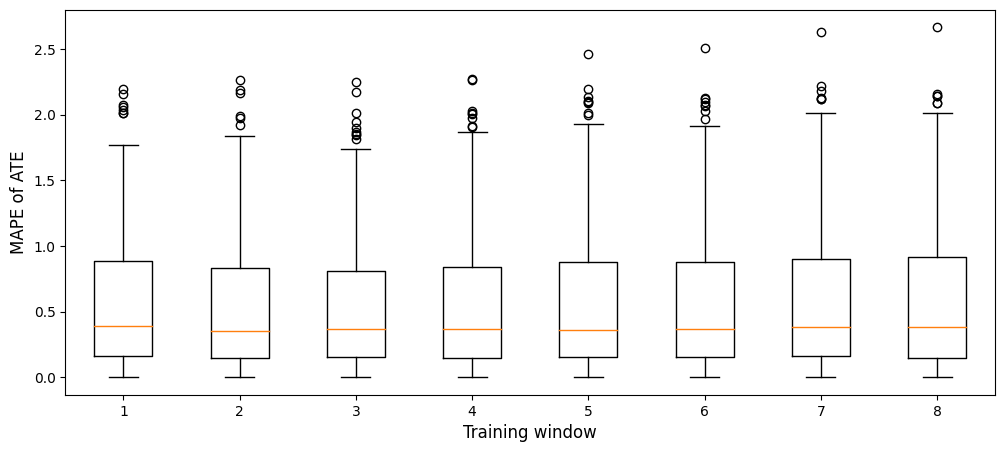

In [34]:
plt.rc('axes', labelsize=12)
plt.figure(figsize=(12,5))
result_window_dict = results_window.groupby(['window'])['rel_effect_diff'].apply(lambda x: list(x)).to_dict()
plt.boxplot(result_window_dict.values(), labels=result_window_dict.keys())
plt.xlabel('Training window')
plt.ylabel('MAPE of ATE')

Text(0, 0.5, 'MAPE of ATE')

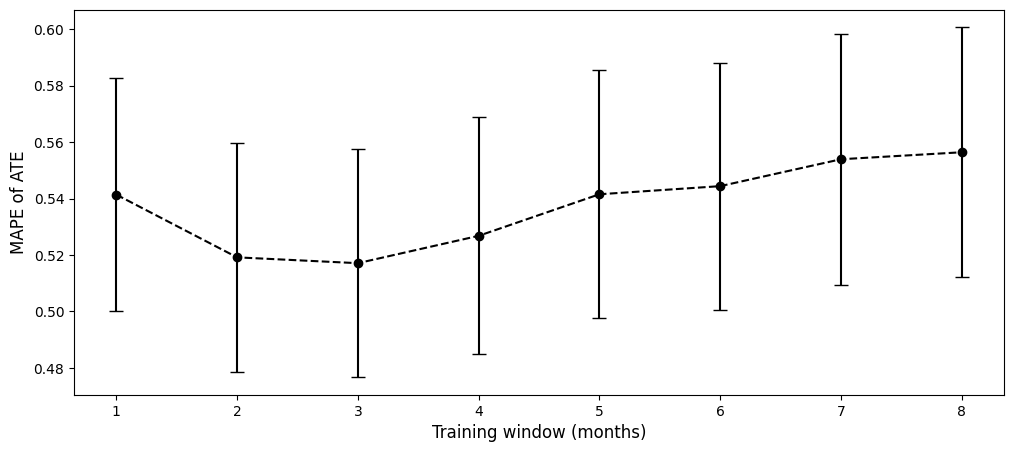

In [35]:
x = list(result_window_dict.keys())
y = list(result_window_dict.values())
y_mean = [np.mean(y_values) for y_values in y]
y_sem = [stats.sem(y_values) for y_values in y]
conf_interval = [1.96 * sem for sem in y_sem]

plt.rc('axes', labelsize=12)
plt.figure(figsize=(12,5))
plt.plot(x, y_mean, color='k', linestyle="--")
plt.xticks(x)
for i in range(len(x)):
    plt.errorbar([x[i]], y_mean[i], yerr=conf_interval[i], fmt='o', capsize=5, color='k')
plt.xlabel('Training window (months)')
plt.ylabel('MAPE of ATE')

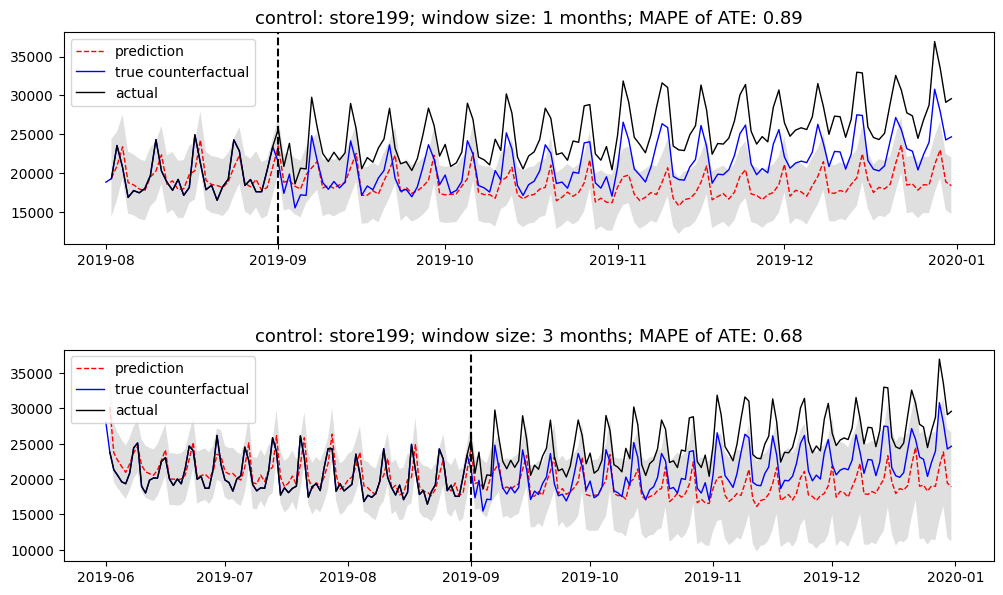

In [56]:
windows = [1,3]
data_inter = pd.to_datetime(cutoff_date_sc)

subplot_id = 1
plt.rc('axes', titlesize=13)
plt.figure(figsize=(12,11))
plt.subplots_adjust(hspace=0.5)
ctr_id = 'store199'
for window in windows:

  plt.subplot(3, 1, subplot_id)
  subplot_id += 1

  start_date_sc = (pd.to_datetime(cutoff_date_sc) + relativedelta(months=-window)).strftime('%Y-%m-%d')
  df_sc = df[['store', 'value']].pivot(columns=['store'], values='value')
  true_cf = df_sc.loc[start_date_sc:end_date_sc]['store1']
  inferences = ci_dict_window.get(window).get(ctr_id).inferences[1::]

  plt.plot(inferences.point_pred, "r--", linewidth=1, label="prediction")
  plt.plot(true_cf, "b", alpha=1, linewidth=1, label="true counterfactual")
  plt.plot(inferences.response, "k", linewidth=1, label="actual")

  plt.axvline(data_inter, c="k", linestyle="--")

  plt.fill_between(
      inferences.index,
      inferences.point_pred_lower,
      inferences.point_pred_upper,
      facecolor="gray",
      interpolate=True,
      alpha=0.25,
  )

  rel_effect_diff = results_window[(results_window['window']==window) & (results_window['ctr_id']==ctr_id)]['rel_effect_diff']
  rel_effect_diff = round(rel_effect_diff.values[0], 2)
  plt.legend(loc="upper left")
  plt.title(f"control: {ctr_id}; window size: {window} months; MAPE of ATE: {rel_effect_diff}")

## SC: Impact of control group size

In [37]:
start_date_sc = '2019-06-01'
cutoff_date_sc = '2019-09-01'
end_date_sc = '2019-12-31'
pre_period = [pd.to_datetime(i) for i in [start_date_sc, pd.to_datetime(cutoff_date_sc) - timedelta(days=1)]]
post_period = [pd.to_datetime(i) for i in [cutoff_date_sc, end_date_sc]]

tre_id = 'store'+str(1)
df_sc = df[['store', 'value']].pivot(columns=['store'], values='value')
df_sc = df_sc.loc[start_date_sc:end_date_sc]
df_sc.loc[cutoff_date_sc:, tre_id] = df_sc.loc[cutoff_date_sc:, tre_id]*1.2
pre_tre_actual = df_sc[tre_id].loc[start_date_sc:pre_cutoff_date_sc].values
pre_cutoff_date_sc = (pd.to_datetime(cutoff_date_sc) - timedelta(days=1)).strftime('%Y-%m-%d')

sample_size_ctr = 50
results_size = pd.DataFrame([])
ci_dict_size = dict({})

for n_ctr in range(1,11):

  pre_tre_acc_arr = []
  rel_effect_arr = []
  ci_dict = dict({})

  for sample_id in range(sample_size_ctr):

    np.random.seed(sample_id)
    ctr_sample = np.random.choice(range(2,N_groups+1), n_ctr, replace=False)
    ctr_id = ['store'+str(i) for i in ctr_sample]
    cols = [tre_id] + ctr_id

    ci = CausalImpact(df_sc[cols], pre_period, post_period)
    ci.run()
    ci_dict.update({sample_id: ci})

    summary_path = 'summary_'+str(n_ctr)+'_'+str(sample_id)
    ci.summary(path=summary_path)
    summary = pd.read_csv(summary_path)
    est = summary.loc[7][1].replace('%', '')


    pre_tre_pred = ci.inferences.point_pred.loc[start_date_sc:pre_cutoff_date_sc].values
    pre_tre_acc = mean_absolute_percentage_error(pre_tre_actual, pre_tre_pred)
    rel_effect = float(est)/100

    pre_tre_acc_arr.append(pre_tre_acc)
    rel_effect_arr.append(rel_effect)

  ci_dict_size.update({n_ctr: ci_dict})
  results_size = pd.concat([results_size,
                              pd.DataFrame({'n_ctr': [n_ctr]*sample_size_ctr,
                              'pre_tre_acc': pre_tre_acc_arr,
                              'rel_effect': rel_effect_arr,
                              'sample_id': list(range(sample_size_ctr))
                                            })])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17321             2113191
95% CI                  [12182, 22460]  [1486205, 2740176]
                                                          
Absolute Effect                   8101              988416
95% CI                   [13241, 2962]   [1615402, 361431]
                                                          
Relative Effect                  46.8%               46.8%
95% CI                  [76.4%, 17.1%]      [76.4%, 17.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18272             2229244
95% CI                   [9732, 26812]  [1187311, 327117

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21303             2599067
95% CI                  [16508, 26098]  [2014095, 3184038]
                                                          
Absolute Effect                   4119              502540
95% CI                    [8914, -675]   [1087512, -82430]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                  [41.8%, -3.2%]      [41.8%, -3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23152             2824603
95% CI                   [15275, 31029]  [1863557, 37

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21736             2651866
95% CI                   [15075, 28397]  [1839205, 3464527]
                                                           
Absolute Effect                    3686              449741
95% CI                   [10347, -2974]  [1262402, -362918]
                                                           
Relative Effect                   17.0%               17.0%
95% CI                  [47.6%, -13.7%]     [47.6%, -13.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21218             2588650
95% CI                  [17694, 24741]  [21

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18405             2245486
95% CI                  [12436, 24374]  [1517309, 2973662]
                                                          
Absolute Effect                   7017              856122
95% CI                   [12986, 1048]   [1584298, 127946]
                                                          
Relative Effect                  38.1%               38.1%
95% CI                   [70.6%, 5.7%]       [70.6%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18340             2237596
95% CI                   [9748, 26932]  [1189377, 328581

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22551             2751321
95% CI                   [14940, 30163]  [1822708, 3679933]
                                                           
Absolute Effect                    2871              350287
95% CI                   [10482, -4740]  [1278899, -578325]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [46.5%, -21.0%]     [46.5%, -21.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22469             2741238
95% CI                   [14697, 30241] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23015             2807897
95% CI                   [15903, 30127]  [1940234, 3675560]
                                                           
Absolute Effect                    2407              293711
95% CI                    [9519, -4704]  [1161374, -573951]
                                                           
Relative Effect                   10.5%               10.5%
95% CI                  [41.4%, -20.4%]     [41.4%, -20.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19221             2344980
95% CI                  [13604, 24837]  [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21548             2628950
95% CI                  [18171, 24925]  [2216930, 3040971]
                                                          
Absolute Effect                   3874              472657
95% CI                     [7251, 497]     [884677, 60637]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                   [33.7%, 2.3%]       [33.7%, 2.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19776             2412700
95% CI                  [17528, 22024]  [2138446, 268695

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23206             2831146
95% CI                   [16678, 29734]  [2034718, 3627574]
                                                           
Absolute Effect                    2216              270462
95% CI                    [8745, -4311]  [1066890, -525965]
                                                           
Relative Effect                    9.6%                9.6%
95% CI                  [37.7%, -18.6%]     [37.7%, -18.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20464             2496682
95% CI                  [16748, 24180]  [20

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21154             2580892
95% CI                  [16840, 25469]  [2054493, 3107290]
                                                          
Absolute Effect                   4268              520715
95% CI                     [8582, -46]    [1047114, -5682]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                  [40.6%, -0.2%]      [40.6%, -0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20015             2441890
95% CI                  [17383, 22647]  [2120805, 276297

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20584             2511265
95% CI                   [12697, 28470]  [1549080, 3473450]
                                                           
Absolute Effect                    4838              590342
95% CI                   [12725, -3047]  [1552527, -371842]
                                                           
Relative Effect                   23.5%               23.5%
95% CI                  [61.8%, -14.8%]     [61.8%, -14.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21688             2646032
95% CI                  [18168, 25208]  [22

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16996             2073599
95% CI                  [10297, 23695]  [1256311, 2890888]
                                                          
Absolute Effect                   8426             1028008
95% CI                   [15125, 1727]   [1845296, 210719]
                                                          
Relative Effect                  49.6%               49.6%
95% CI                  [89.0%, 10.2%]      [89.0%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19217             2344555
95% CI                  [15727, 22707]  [1918782, 277032

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22422             2735533
95% CI                   [16057, 28787]  [1959000, 3512067]
                                                           
Absolute Effect                    3000              366074
95% CI                    [9365, -3364]  [1142607, -410459]
                                                           
Relative Effect                   13.4%               13.4%
95% CI                  [41.8%, -15.0%]     [41.8%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18269             2228888
95% CI                  [12792, 23747]  [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22256             2715294
95% CI                   [16716, 27796]  [2039364, 3391225]
                                                           
Absolute Effect                    3166              386313
95% CI                    [8706, -2373]  [1062243, -289616]
                                                           
Relative Effect                   14.2%               14.2%
95% CI                  [39.1%, -10.7%]     [39.1%, -10.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21957             2678757
95% CI                   [15277, 28636] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22556             2751952
95% CI                   [16903, 28210]  [2062267, 3441638]
                                                           
Absolute Effect                    2866              349655
95% CI                    [8519, -2787]  [1039341, -340030]
                                                           
Relative Effect                   12.7%               12.7%
95% CI                  [37.8%, -12.4%]     [37.8%, -12.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16912             2063338
95% CI                  [11831, 21993]  [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20686             2523726
95% CI                  [18394, 22977]  [2244187, 2803266]
                                                          
Absolute Effect                   4736              577881
95% CI                    [7028, 2445]    [857420, 298341]
                                                          
Relative Effect                  22.9%               22.9%
95% CI                  [34.0%, 11.8%]      [34.0%, 11.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19353             2361104
95% CI                  [13109, 25596]  [1599408, 312280

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18758             2288561
95% CI                  [11804, 25712]  [1440143, 3136978]
                                                          
Absolute Effect                   6664              813047
95% CI                   [13618, -289]   [1661464, -35370]
                                                          
Relative Effect                  35.5%               35.5%
95% CI                  [72.6%, -1.5%]      [72.6%, -1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17747             2165207
95% CI                  [12499, 22995]  [1524957, 280545

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21218             2588602
95% CI                  [17533, 24902]  [2139122, 3038083]
                                                          
Absolute Effect                   4204              513005
95% CI                     [7889, 520]     [962485, 63524]
                                                          
Relative Effect                  19.8%               19.8%
95% CI                   [37.2%, 2.5%]       [37.2%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19348             2360499
95% CI                  [15597, 23099]  [1902868, 281813

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21153             2580698
95% CI                  [17091, 25215]  [2085160, 3076235]
                                                          
Absolute Effect                   4269              520910
95% CI                     [8331, 207]    [1016447, 25372]
                                                          
Relative Effect                  20.2%               20.2%
95% CI                   [39.4%, 1.0%]       [39.4%, 1.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         20962             2557416
95% CI                   [14049, 27874]  [1714083, 34

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18191             2219353
95% CI                  [12329, 24053]  [1504239, 2934468]
                                                          
Absolute Effect                   7231              882254
95% CI                   [13093, 1369]   [1597368, 167139]
                                                          
Relative Effect                  39.8%               39.8%
95% CI                   [72.0%, 7.5%]       [72.0%, 7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18537             2261628
95% CI                  [12711, 24364]  [1550825, 297243

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20788             2536146
95% CI                  [14411, 27164]  [1758177, 3314114]
                                                          
Absolute Effect                   4634              565462
95% CI                  [11011, -1741]  [1343430, -212506]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                  [53.0%, -8.4%]      [53.0%, -8.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17963             2191509
95% CI                  [11795, 24130]  [1439049, 294396

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21979             2681443
95% CI                   [16304, 27653]  [1989151, 3373736]
                                                           
Absolute Effect                    3443              420164
95% CI                    [9118, -2230]  [1112456, -272127]
                                                           
Relative Effect                   15.7%               15.7%
95% CI                  [41.5%, -10.1%]     [41.5%, -10.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18835             2297942
95% CI                  [13392, 24278]  [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21600             2635221
95% CI                   [14152, 29048]  [1726575, 3543867]
                                                           
Absolute Effect                    3822              466386
95% CI                   [11270, -3625]  [1375032, -442259]
                                                           
Relative Effect                   17.7%               17.7%
95% CI                  [52.2%, -16.8%]     [52.2%, -16.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22304             2721138
95% CI                   [15612, 28996] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19145             2335707
95% CI                  [13550, 24740]  [1653123, 3018291]
                                                          
Absolute Effect                   6277              765900
95% CI                    [11872, 682]    [1448484, 83317]
                                                          
Relative Effect                  32.8%               32.8%
95% CI                   [62.0%, 3.6%]       [62.0%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21161             2581751
95% CI                  [15045, 27278]  [1835503, 332799

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19849             2421587
95% CI                  [17624, 22073]  [2150153, 2693021]
                                                          
Absolute Effect                   5573              680020
95% CI                    [7798, 3349]    [951454, 408586]
                                                          
Relative Effect                  28.1%               28.1%
95% CI                  [39.3%, 16.9%]      [39.3%, 16.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20143             2457555
95% CI                  [17618, 22669]  [2149451, 276565

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20445             2494305
95% CI                  [16729, 24160]  [2041011, 2947599]
                                                          
Absolute Effect                   4977              607302
95% CI                    [8693, 1262]   [1060596, 154008]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                   [42.5%, 6.2%]       [42.5%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17758             2166478
95% CI                   [9137, 26378]  [1114794, 321816

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20978             2559354
95% CI                  [16084, 25872]  [1962315, 3156393]
                                                          
Absolute Effect                   4444              542253
95% CI                    [9338, -449]   [1139292, -54785]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [44.5%, -2.1%]      [44.5%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19133             2334282
95% CI                  [16132, 22133]  [1968220, 270034

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21196             2585966
95% CI                  [17636, 24756]  [2151680, 3020252]
                                                          
Absolute Effect                   4226              515641
95% CI                     [7786, 666]     [949927, 81355]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                   [36.7%, 3.1%]       [36.7%, 3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21643             2640540
95% CI                  [16469, 26817]  [2009302, 327177

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17718             2161656
95% CI                  [10733, 24703]  [1309444, 3013868]
                                                          
Absolute Effect                   7704              939951
95% CI                    [14689, 719]    [1792164, 87739]
                                                          
Relative Effect                  43.5%               43.5%
95% CI                   [82.9%, 4.1%]       [82.9%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17981             2193789
95% CI                  [12848, 23115]  [1567485, 282009

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22927             2797130
95% CI                   [16708, 29146]  [2038440, 3555821]
                                                           
Absolute Effect                    2495              304477
95% CI                    [8714, -3723]  [1063167, -454213]
                                                           
Relative Effect                   10.9%               10.9%
95% CI                  [38.0%, -16.2%]     [38.0%, -16.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20334             2480776
95% CI                  [16850, 23817]  [20

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22278             2717959
95% CI                   [16693, 27862]  [2036633, 3399284]
                                                           
Absolute Effect                    3144              383648
95% CI                    [8729, -2439]  [1064974, -297676]
                                                           
Relative Effect                   14.1%               14.1%
95% CI                  [39.2%, -11.0%]     [39.2%, -11.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23189             2829146
95% CI                   [15945, 30434] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21131             2578046
95% CI                  [15810, 26452]  [1928875, 3227217]
                                                          
Absolute Effect                   4291              523561
95% CI                   [9612, -1029]  [1172732, -125609]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                  [45.5%, -4.9%]      [45.5%, -4.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17418             2125074
95% CI                  [12379, 22457]  [1510336, 273981

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17473             2131725
95% CI                  [10931, 24015]  [1333596, 2929853]
                                                          
Absolute Effect                   7949              969883
95% CI                   [14491, 1407]   [1768011, 171754]
                                                          
Relative Effect                  45.5%               45.5%
95% CI                   [82.9%, 8.1%]       [82.9%, 8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20269             2472934
95% CI                  [18137, 22402]  [2212729, 273313

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22756             2776297
95% CI                   [13692, 31820]  [1670459, 3882135]
                                                           
Absolute Effect                    2666              325310
95% CI                   [11730, -6397]  [1431149, -780527]
                                                           
Relative Effect                   11.7%               11.7%
95% CI                  [51.5%, -28.1%]     [51.5%, -28.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20054             2446695
95% CI                  [14696, 25412]  [17

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         24754             3020064
95% CI                   [16981, 32527]  [2071780, 3968348]
                                                           
Absolute Effect                     668               81544
95% CI                    [8441, -7104]  [1029828, -866740]
                                                           
Relative Effect                    2.7%                2.7%
95% CI                  [34.1%, -28.7%]     [34.1%, -28.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19619             2393557
95% CI                  [13716, 25522]  [16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21837             2664176
95% CI                  [19600, 24074]  [2391283, 2937069]
                                                          
Absolute Effect                   3585              437431
95% CI                    [5822, 1348]    [710324, 164538]
                                                          
Relative Effect                  16.4%               16.4%
95% CI                   [26.7%, 6.2%]       [26.7%, 6.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21219             2588753
95% CI                  [17538, 24900]  [2139683, 303782

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18116             2210245
95% CI                  [14546, 21687]  [1774640, 2645849]
                                                          
Absolute Effect                   7306              891363
95% CI                   [10876, 3735]   [1326967, 455758]
                                                          
Relative Effect                  40.3%               40.3%
95% CI                  [60.0%, 20.6%]      [60.0%, 20.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20439             2493670
95% CI                  [14555, 26324]  [1775710, 321163

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19955             2434541
95% CI                  [17535, 22374]  [2139350, 2729733]
                                                          
Absolute Effect                   5467              667066
95% CI                    [7887, 3048]    [962258, 371874]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                  [39.5%, 15.3%]      [39.5%, 15.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20572             2509812
95% CI                  [13857, 27286]  [1690657, 332896

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20768             2533710
95% CI                  [15925, 25610]  [1942912, 3124508]
                                                          
Absolute Effect                   4654              567897
95% CI                    [9497, -187]   [1158696, -22900]
                                                          
Relative Effect                  22.4%               22.4%
95% CI                  [45.7%, -0.9%]      [45.7%, -0.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17875             2180863
95% CI                  [11941, 23810]  [1456831, 290489

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21234             2590606
95% CI                   [14677, 27791]  [1790704, 3390507]
                                                           
Absolute Effect                    4188              511002
95% CI                   [10745, -2368]  [1310903, -288899]
                                                           
Relative Effect                   19.7%               19.7%
95% CI                  [50.6%, -11.2%]     [50.6%, -11.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22559             2752312
95% CI                   [15558, 29561] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19044             2323471
95% CI                  [14116, 23973]  [1722204, 2924739]
                                                          
Absolute Effect                   6378              778136
95% CI                   [11306, 1449]   [1379403, 176868]
                                                          
Relative Effect                  33.5%               33.5%
95% CI                   [59.4%, 7.6%]       [59.4%, 7.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19898             2427559
95% CI                  [15510, 24285]  [1892274, 296284

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18066             2204090
95% CI                  [13576, 22555]  [1656366, 2751815]
                                                          
Absolute Effect                   7356              897517
95% CI                   [11846, 2867]   [1445241, 349793]
                                                          
Relative Effect                  40.7%               40.7%
95% CI                  [65.6%, 15.9%]      [65.6%, 15.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22648             2763057
95% CI                   [15950, 29345]  [1945980, 35

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17698             2159184
95% CI                  [10968, 24427]  [1338157, 2980212]
                                                          
Absolute Effect                   7724              942423
95% CI                    [14454, 995]   [1763450, 121396]
                                                          
Relative Effect                  43.6%               43.6%
95% CI                   [81.7%, 5.6%]       [81.7%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18108             2209273
95% CI                  [11933, 24283]  [1455909, 296263

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22357             2727621
95% CI                   [16606, 28108]  [2026022, 3429220]
                                                           
Absolute Effect                    3065              373987
95% CI                    [8816, -2685]  [1075585, -327611]
                                                           
Relative Effect                   13.7%               13.7%
95% CI                  [39.4%, -12.0%]     [39.4%, -12.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22975             2803035
95% CI                   [15784, 30167] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21638             2639925
95% CI                  [16277, 27000]  [1985845, 3294006]
                                                          
Absolute Effect                   3784              461682
95% CI                   [9145, -1577]  [1115763, -192398]
                                                          
Relative Effect                  17.5%               17.5%
95% CI                  [42.3%, -7.3%]      [42.3%, -7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19827             2419013
95% CI                  [15568, 24087]  [1899392, 293863

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20616             2515160
95% CI                  [15404, 25828]  [1879298, 3151021]
                                                          
Absolute Effect                   4806              586448
95% CI                   [10018, -405]   [1222309, -49413]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                  [48.6%, -2.0%]      [48.6%, -2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20046             2445710
95% CI                  [16697, 23396]  [2037106, 285431

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20230             2468130
95% CI                  [18115, 22345]  [2210065, 2726196]
                                                          
Absolute Effect                   5192              633477
95% CI                    [7307, 3077]    [891542, 375411]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                  [36.1%, 15.2%]      [36.1%, 15.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18543             2262292
95% CI                  [13070, 24015]  [1594656, 292992

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20188             2463047
95% CI                  [17476, 22900]  [2132176, 2793918]
                                                          
Absolute Effect                   5234              638560
95% CI                    [7946, 2522]    [969431, 307690]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                  [39.4%, 12.5%]      [39.4%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19287             2353062
95% CI                  [13464, 25110]  [1642627, 306349

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19107             2331166
95% CI                  [13042, 25173]  [1591196, 3071135]
                                                          
Absolute Effect                   6315              770441
95% CI                    [12380, 249]    [1510411, 30472]
                                                          
Relative Effect                  33.0%               33.0%
95% CI                   [64.8%, 1.3%]       [64.8%, 1.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19513             2380607
95% CI                  [17418, 21607]  [2125076, 263613

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20360             2483961
95% CI                  [16764, 23956]  [2045229, 2922693]
                                                          
Absolute Effect                   5062              617646
95% CI                    [8658, 1466]   [1056379, 178914]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                   [42.5%, 7.2%]       [42.5%, 7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21582             2633032
95% CI                  [16349, 26814]  [1994688, 327137

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17171             2094863
95% CI                  [10980, 23361]  [1339575, 2850151]
                                                          
Absolute Effect                   8252             1006744
95% CI                   [14442, 2061]   [1762033, 251456]
                                                          
Relative Effect                  48.1%               48.1%
95% CI                  [84.1%, 12.0%]      [84.1%, 12.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17289             2109361
95% CI                  [11436, 23143]  [1395270, 282345

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22450             2739020
95% CI                   [16113, 28788]  [1965789, 3512251]
                                                           
Absolute Effect                    2972              362588
95% CI                    [9309, -3365]  [1135819, -410643]
                                                           
Relative Effect                   13.2%               13.2%
95% CI                  [41.5%, -15.0%]     [41.5%, -15.0%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20390             2487628
95% CI                  [16913, 23867]  [20

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22274             2717435
95% CI                  [17043, 27504]  [2079283, 3355587]
                                                          
Absolute Effect                   3148              384172
95% CI                   [8379, -2081]  [1022324, -253979]
                                                          
Relative Effect                  14.1%               14.1%
95% CI                  [37.6%, -9.3%]      [37.6%, -9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21564             2630847
95% CI                   [15144, 27983]  [1847671, 34

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21371             2607328
95% CI                  [15453, 27289]  [1885329, 3329326]
                                                          
Absolute Effect                   4051              494280
95% CI                   [9969, -1866]  [1216278, -227718]
                                                          
Relative Effect                  19.0%               19.0%
95% CI                  [46.6%, -8.7%]      [46.6%, -8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19855             2422330
95% CI                  [17489, 22220]  [2133775, 271088

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18220             2222942
95% CI                  [13013, 23427]  [1587693, 2858192]
                                                          
Absolute Effect                   7202              878665
95% CI                   [12409, 1995]   [1513914, 243415]
                                                          
Relative Effect                  39.5%               39.5%
95% CI                  [68.1%, 11.0%]      [68.1%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19807             2416516
95% CI                  [15968, 23646]  [1948172, 288485

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20219             2466730
95% CI                  [18179, 22258]  [2217875, 2715586]
                                                          
Absolute Effect                   5203              634877
95% CI                    [7243, 3164]    [883733, 386021]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                  [35.8%, 15.6%]      [35.8%, 15.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                              Average          Cumulative
Actual                          25423             3101608
Predicted                       17311             2111981
95% CI                  [9337, 25285]  [1139114, 3084847]
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21900             2671921
95% CI                  [19694, 24107]  [2402768, 2941073]
                                                          
Absolute Effect                   3522              429687
95% CI                    [5728, 1315]    [698839, 160534]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                   [26.2%, 6.0%]       [26.2%, 6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23625             2882314
95% CI                   [16783, 30467]  [2047618, 3717010]
                                                           
Absolute Effect                    1797              219293
95% CI                    [8639, -5044]  [1053989, -615402]
                                                           
Relative Effect                    7.6%                7.6%
95% CI                  [36.6%, -21.4%]     [36.6%, -21.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19223             2345237
95% CI                  [16151, 22294]  [19

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19805             2416285
95% CI                  [13810, 25800]  [1684855, 3147716]
                                                          
Absolute Effect                   5617              685322
95% CI                   [11612, -377]   [1416752, -46107]
                                                          
Relative Effect                  28.4%               28.4%
95% CI                  [58.6%, -1.9%]      [58.6%, -1.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19400             2366911
95% CI                  [16515, 22285]  [2014937, 271888

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21630             2638937
95% CI                  [16683, 26577]  [2035382, 3242491]
                                                          
Absolute Effect                   3792              462670
95% CI                   [8739, -1154]  [1066225, -140883]
                                                          
Relative Effect                  17.5%               17.5%
95% CI                  [40.4%, -5.3%]      [40.4%, -5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20557             2508032
95% CI                  [15679, 25435]  [1912941, 310312

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19414             2368600
95% CI                  [13727, 25101]  [1674771, 3062429]
                                                          
Absolute Effect                   6008              733007
95% CI                    [11695, 321]    [1426836, 39178]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                   [60.2%, 1.7%]       [60.2%, 1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21640             2640119
95% CI                   [15100, 28179]  [1842283, 34

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23343             2847877
95% CI                   [16182, 30504]  [1974217, 3721536]
                                                           
Absolute Effect                    2079              253731
95% CI                    [9240, -5081]  [1127390, -619927]
                                                           
Relative Effect                    8.9%                8.9%
95% CI                  [39.6%, -21.8%]     [39.6%, -21.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19404             2367304
95% CI                  [14414, 24393]  [17

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21187             2584923
95% CI                  [16649, 25726]  [2031240, 3138607]
                                                          
Absolute Effect                   4235              516684
95% CI                    [8773, -303]   [1070368, -36999]
                                                          
Relative Effect                  20.0%               20.0%
95% CI                  [41.4%, -1.4%]      [41.4%, -1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18630             2272945
95% CI                  [13852, 23408]  [1690002, 285588

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23535             2871298
95% CI                   [16047, 31022]  [1957800, 3784795]
                                                           
Absolute Effect                    1887              230309
95% CI                    [9375, -5599]  [1143807, -683187]
                                                           
Relative Effect                    8.0%                8.0%
95% CI                  [39.8%, -23.8%]     [39.8%, -23.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18174             2217247
95% CI                  [11957, 24390]  [14

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18079             2205704
95% CI                  [12830, 23328]  [1565336, 2846071]
                                                          
Absolute Effect                   7343              895904
95% CI                   [12592, 2094]   [1536271, 255536]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                  [69.6%, 11.6%]      [69.6%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21121             2576864
95% CI                   [14594, 27648]  [1780572, 33

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21399             2610728
95% CI                  [16081, 26717]  [1961950, 3259506]
                                                          
Absolute Effect                   4023              490879
95% CI                   [9341, -1294]  [1139657, -157898]
                                                          
Relative Effect                  18.8%               18.8%
95% CI                  [43.7%, -6.0%]      [43.7%, -6.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20545             2506490
95% CI                  [17560, 23529]  [2142366, 287061

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18568             2265317
95% CI                  [13148, 23987]  [1604154, 2926480]
                                                          
Absolute Effect                   6854              836290
95% CI                   [12274, 1435]   [1497453, 175127]
                                                          
Relative Effect                  36.9%               36.9%
95% CI                   [66.1%, 7.7%]       [66.1%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19846             2421329
95% CI                  [13790, 25903]  [1682473, 316018

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20055             2446796
95% CI                  [16709, 23401]  [2038554, 2855038]
                                                          
Absolute Effect                   5367              654811
95% CI                    [8713, 2021]   [1063053, 246569]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [43.4%, 10.1%]      [43.4%, 10.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20135             2456530
95% CI                  [18080, 22190]  [2205868, 270719

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18729             2284954
95% CI                  [13426, 24031]  [1638075, 2931833]
                                                          
Absolute Effect                   6693              816654
95% CI                   [11996, 1391]   [1463533, 169775]
                                                          
Relative Effect                  35.7%               35.7%
95% CI                   [64.1%, 7.4%]       [64.1%, 7.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20639             2518078
95% CI                  [16572, 24707]  [2021845, 301431

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20042             2445213
95% CI                  [17775, 22310]  [2168600, 2721826]
                                                          
Absolute Effect                   5380              656394
95% CI                    [7647, 3112]    [933007, 379782]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [38.2%, 15.5%]      [38.2%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21971             2680551
95% CI                  [19439, 24504]  [2371588, 298951

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16471             2009508
95% CI                   [9828, 23114]  [1199037, 2819979]
                                                          
Absolute Effect                   8951             1092099
95% CI                   [15594, 2308]   [1902570, 281628]
                                                          
Relative Effect                  54.3%               54.3%
95% CI                  [94.7%, 14.0%]      [94.7%, 14.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19074             2327147
95% CI                  [13630, 24519]  [1662935, 299136

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19557             2386058
95% CI                  [17511, 21603]  [2136444, 2635672]
                                                          
Absolute Effect                   5865              715549
95% CI                    [7911, 3819]    [965163, 465936]
                                                          
Relative Effect                  30.0%               30.0%
95% CI                  [40.5%, 19.5%]      [40.5%, 19.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21028             2565420
95% CI                  [17291, 24764]  [2109620, 302122

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argu

                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17096             2085782
95% CI                  [11881, 22312]  [1449490, 2722074]
                                                          
Absolute Effect                   8326             1015825
95% CI                   [13541, 3110]   [1652118, 379533]
                                                          
Relative Effect                  48.7%               48.7%
95% CI                  [79.2%, 18.2%]      [79.2%, 18.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17863             2179328
95% CI                  [13540, 22185]  [1651971, 270668

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17811             2173018
95% CI                  [12808, 22814]  [1562681, 2783354]
                                                          
Absolute Effect                   7611              928590
95% CI                   [12614, 2608]   [1538926, 318253]
                                                          
Relative Effect                  42.7%               42.7%
95% CI                  [70.8%, 14.6%]      [70.8%, 14.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21919             2674146
95% CI                  [18177, 25660]  [2217707, 313058

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21043             2567264
95% CI                  [14645, 27441]  [1786718, 3347809]
                                                          
Absolute Effect                   4379              534344
95% CI                  [10777, -2018]  [1314890, -246201]
                                                          
Relative Effect                  20.8%               20.8%
95% CI                  [51.2%, -9.6%]      [51.2%, -9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20834             2541868
95% CI                  [16231, 25438]  [1980202, 310353

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18942             2311011
95% CI                  [13926, 23958]  [1699074, 2922949]
                                                          
Absolute Effect                   6480              790596
95% CI                   [11496, 1464]   [1402534, 178658]
                                                          
Relative Effect                  34.2%               34.2%
95% CI                   [60.7%, 7.7%]       [60.7%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22393             2732007
95% CI                  [17217, 27569]  [2100593, 336342

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21741             2652438
95% CI                   [15261, 28220]  [1861958, 3442918]
                                                           
Absolute Effect                    3681              449170
95% CI                   [10161, -2797]  [1239650, -341310]
                                                           
Relative Effect                   16.9%               16.9%
95% CI                  [46.7%, -12.9%]     [46.7%, -12.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20444             2494184
95% CI                  [17282, 23605]  [21

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19775             2412634
95% CI                  [17467, 22083]  [2131041, 2694227]
                                                          
Absolute Effect                   5647              688973
95% CI                    [7955, 3339]    [970566, 407380]
                                                          
Relative Effect                  28.6%               28.6%
95% CI                  [40.2%, 16.9%]      [40.2%, 16.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18214             2222218
95% CI                  [13016, 23413]  [1587961, 285647

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20658             2520350
95% CI                  [15363, 25954]  [1874309, 3166392]
                                                          
Absolute Effect                   4764              581257
95% CI                   [10059, -531]   [1227298, -64783]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [48.7%, -2.6%]      [48.7%, -2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20376             2485873
95% CI                  [18349, 22402]  [2238585, 273316

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average         Cumulative
Actual                           25423            3101608
Predicted                        15891            1938713
95% CI                   [7908, 23873]  [964821, 2912605]
                                                         
Absolute Effect                   9531            1162894
95% CI                   [17514, 1549]  [2136786, 189002]
                                                         
Relative Effect                  60.0%              60.0%
95% CI                  [110.2%, 9.7%]     [110.2%, 9.7%]
                                                         
P-value                           0.0%                   
Prob. of Causal Effect          100.0%                   
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20559             2508306
95% CI                  [16811, 24308]  [2050969, 2965643]
          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21790             2658494
95% CI                   [15122, 28459]  [1844924, 3472064]
                                                           
Absolute Effect                    3632              443113
95% CI                   [10300, -3036]  [1256683, -370456]
                                                           
Relative Effect                   16.7%               16.7%
95% CI                  [47.3%, -13.9%]     [47.3%, -13.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18355             2239393
95% CI                  [12718, 23993]  [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22060             2691431
95% CI                  [19975, 24146]  [2437001, 2945861]
                                                          
Absolute Effect                   3362              410176
95% CI                    [5447, 1276]    [664606, 155746]
                                                          
Relative Effect                  15.2%               15.2%
95% CI                   [24.7%, 5.8%]       [24.7%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21604             2635775
95% CI                   [15455, 27753]  [1885580, 33

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18543             2262276
95% CI                  [13889, 23196]  [1694532, 2830020]
                                                          
Absolute Effect                   6879              839331
95% CI                   [11533, 2226]   [1407075, 271588]
                                                          
Relative Effect                  37.1%               37.1%
95% CI                  [62.2%, 12.0%]      [62.2%, 12.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19882             2425605
95% CI                  [14647, 25116]  [1787015, 306419

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19235             2346759
95% CI                  [16684, 21786]  [2035565, 2657952]
                                                          
Absolute Effect                   6187              754849
95% CI                    [8738, 3636]   [1066042, 443656]
                                                          
Relative Effect                  32.2%               32.2%
95% CI                  [45.4%, 18.9%]      [45.4%, 18.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21364             2606414
95% CI                  [16986, 25741]  [2072348, 314048

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21038             2566743
95% CI                  [16674, 25403]  [2034287, 3099198]
                                                          
Absolute Effect                   4384              534865
95% CI                      [8748, 19]     [1067320, 2409]
                                                          
Relative Effect                  20.8%               20.8%
95% CI                   [41.6%, 0.1%]       [41.6%, 0.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19427             2370129
95% CI                  [13910, 24944]  [1697067, 3043191]
                                                          
Absolute Effect                   5995              731478
95% CI                    [11512, 478]    [1404540, 58416]
                                                          
Relative Effect                  30.9%               30.9%
95% CI                   [59.3%, 2.5%]       [59.3%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23950             2921953
95% CI                   [18631, 29268]  [2273093, 3570814]
                                                           
Absolute Effect                    1472              179654
95% CI                    [6791, -3845]   [828514, -469205]
                                                           
Relative Effect                    6.1%                6.1%
95% CI                  [28.4%, -16.1%]     [28.4%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22460             2740156
95% CI                   [16520, 28399] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18606             2269975
95% CI                  [13683, 23528]  [1669418, 2870531]
                                                          
Absolute Effect                   6816              831632
95% CI                   [11739, 1894]   [1432189, 231076]
                                                          
Relative Effect                  36.6%               36.6%
95% CI                  [63.1%, 10.2%]      [63.1%, 10.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20662             2520797
95% CI                  [15556, 25767]  [1897944, 3143650]
                                                          
Absolute Effect                   4760              580810
95% CI                    [9866, -344]   [1203663, -42041]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [47.7%, -1.7%]      [47.7%, -1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18509             2258172
95% CI                  [13699, 23319]  [1671388, 284495

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20350             2482701
95% CI                  [13446, 27253]  [1640489, 3324913]
                                                          
Absolute Effect                   5073              618906
95% CI                  [11976, -1830]  [1461118, -223304]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                  [58.9%, -9.0%]      [58.9%, -9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18715             2283298
95% CI                  [13363, 24067]  [1630368, 293622

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18225             2223532
95% CI                  [14189, 22261]  [1731121, 2715942]
                                                          
Absolute Effect                   7197              878076
95% CI                   [11233, 3161]   [1370486, 385665]
                                                          
Relative Effect                  39.5%               39.5%
95% CI                  [61.6%, 17.3%]      [61.6%, 17.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20315             2478469
95% CI                  [13820, 26810]  [1686065, 3270874]
                                                          
Absolute Effect                   5107              623138
95% CI                  [11602, -1387]  [1415542, -169266]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                  [57.1%, -6.8%]      [57.1%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22107             2697170
95% CI                  [17340, 26875]  [2115559, 3278781]
                                                          
Absolute Effect                   3315              404437
95% CI                   [8082, -1452]   [986048, -177173]
                                                          
Relative Effect                  15.0%               15.0%
95% CI                  [36.6%, -6.6%]      [36.6%, -6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20118             2454447
95% CI                  [17588, 22648]  [2145787, 276310

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18715             2283254
95% CI                  [13447, 23983]  [1640578, 2925929]
                                                          
Absolute Effect                   6707              818354
95% CI                   [11975, 1439]   [1461030, 175678]
                                                          
Relative Effect                  35.8%               35.8%
95% CI                   [64.0%, 7.7%]       [64.0%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21146             2579884
95% CI                   [14405, 27888]  [1757429, 3402339]
                                                           
Absolute Effect                    4276              521723
95% CI                   [11017, -2465]  [1344178, -300730]
                                                           
Relative Effect                   20.2%               20.2%
95% CI                  [52.1%, -11.7%]     [52.1%, -11.7%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20037             2444545
95% CI                  [16706, 23367]  [2038230, 2850860]
                                                          
Absolute Effect                   5385              657063
95% CI                    [8716, 2055]   [1063378, 250747]
                                                          
Relative Effect                  26.9%               26.9%
95% CI                  [43.5%, 10.3%]      [43.5%, 10.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20179             2461864
95% CI                  [18126, 22232]  [2211424, 2712304]
                                                          
Absolute Effect                   5243              639744
95% CI                    [7296, 3191]    [890184, 389304]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                  [36.2%, 15.8%]      [36.2%, 15.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18836             2298082
95% CI                  [14067, 23605]  [1716249, 2879916]
                                                          
Absolute Effect                   6586              803525
95% CI                   [11355, 1817]   [1385359, 221692]
                                                          
Relative Effect                  35.0%               35.0%
95% CI                   [60.3%, 9.6%]       [60.3%, 9.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20298             2476360
95% CI                  [17299, 23296]  [2110547, 284217

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20169             2460732
95% CI                  [18196, 22143]  [2219996, 2701468]
                                                          
Absolute Effect                   5253              640875
95% CI                    [7226, 3279]    [881611, 400139]
                                                          
Relative Effect                  26.0%               26.0%
95% CI                  [35.8%, 16.3%]      [35.8%, 16.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21504             2623553
95% CI                  [19009, 23999]  [2319132, 292797

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16977             2071225
95% CI                  [10559, 23395]  [1288246, 2854204]
                                                          
Absolute Effect                   8445             1030382
95% CI                   [14863, 2027]   [1813361, 247403]
                                                          
Relative Effect                  49.7%               49.7%
95% CI                  [87.6%, 11.9%]      [87.6%, 11.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19649             2397205
95% CI                  [14422, 24876]  [1759489, 303492

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19070             2326610
95% CI                  [16181, 21959]  [1974125, 2679095]
                                                          
Absolute Effect                   6352              774998
95% CI                    [9241, 3463]   [1127483, 422513]
                                                          
Relative Effect                  33.3%               33.3%
95% CI                  [48.5%, 18.2%]      [48.5%, 18.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21284             2596682
95% CI                  [18401, 24167]  [2244940, 294842

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21004             2562566
95% CI                  [16626, 25382]  [2028430, 3096702]
                                                          
Absolute Effect                   4418              539041
95% CI                      [8796, 40]     [1073177, 4905]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                   [41.9%, 0.2%]       [41.9%, 0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17190             2097236
95% CI                  [12000, 22380]  [1464027, 273044

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18085             2206403
95% CI                  [13183, 22987]  [1608372, 2804433]
                                                          
Absolute Effect                   7337              895205
95% CI                   [12239, 2435]   [1493235, 297175]
                                                          
Relative Effect                  40.6%               40.6%
95% CI                  [67.7%, 13.5%]      [67.7%, 13.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21034             2566256
95% CI                  [16922, 25147]  [2064571, 306794

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20621             2515812
95% CI                  [14516, 26726]  [1770958, 3260666]
                                                          
Absolute Effect                   4801              585795
95% CI                  [10906, -1303]  [1330649, -159058]
                                                          
Relative Effect                  23.3%               23.3%
95% CI                  [52.9%, -6.3%]      [52.9%, -6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20761             2532961
95% CI                  [16274, 25249]  [1985444, 308047

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19482             2376842
95% CI                  [14796, 24168]  [1805181, 2948504]
                                                          
Absolute Effect                   5940              724765
95% CI                   [10626, 1254]   [1296427, 153104]
                                                          
Relative Effect                  30.5%               30.5%
95% CI                   [54.5%, 6.4%]       [54.5%, 6.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22339             2725405
95% CI                  [17039, 27639]  [2078782, 337202

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21908             2672779
95% CI                   [15131, 28684]  [1846016, 3499541]
                                                           
Absolute Effect                    3514              428828
95% CI                   [10291, -3261]  [1255591, -397933]
                                                           
Relative Effect                   16.0%               16.0%
95% CI                  [47.0%, -14.9%]     [47.0%, -14.9%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19772             2412253
95% CI                  [16222, 23322]  [19

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19204             2342940
95% CI                  [17177, 21231]  [2095695, 2590185]
                                                          
Absolute Effect                   6218              758667
95% CI                    [8245, 4191]   [1005912, 511422]
                                                          
Relative Effect                  32.4%               32.4%
95% CI                  [42.9%, 21.8%]      [42.9%, 21.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18797             2293266
95% CI                  [13976, 23617]  [1705181, 288135

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21530             2626731
95% CI                  [15738, 27323]  [1920054, 3333408]
                                                          
Absolute Effect                   3892              474876
95% CI                   [9684, -1900]  [1181553, -231800]
                                                          
Relative Effect                  18.1%               18.1%
95% CI                  [45.0%, -8.8%]      [45.0%, -8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20318             2478899
95% CI                  [18315, 22322]  [2234453, 272334

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average         Cumulative
Actual                            25423            3101608
Predicted                         15856            1934469
95% CI                    [7878, 23834]  [961151, 2907787]
                                                          
Absolute Effect                    9566            1167139
95% CI                    [17544, 1588]  [2140457, 193821]
                                                          
Relative Effect                   60.3%              60.3%
95% CI                  [110.6%, 10.0%]    [110.6%, 10.0%]
                                                          
P-value                            0.0%                   
Prob. of Causal Effect           100.0%                   
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20432             2492801
95% CI                  [16716, 24148]  [2039472, 294613

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22190             2707231
95% CI                   [16610, 27769]  [2026533, 3387929]
                                                           
Absolute Effect                    3232              394376
95% CI                    [8812, -2346]  [1075074, -286321]
                                                           
Relative Effect                   14.6%               14.6%
95% CI                  [39.7%, -10.6%]     [39.7%, -10.6%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18555             2263820
95% CI                  [12707, 24404]  [15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21036             2566464
95% CI                  [19019, 23053]  [2320394, 2812534]
                                                          
Absolute Effect                   4386              535143
95% CI                    [6403, 2369]    [781214, 289073]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                  [30.4%, 11.3%]      [30.4%, 11.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21098             2573971
95% CI                  [15890, 26305]  [1938688, 320925

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18464             2252634
95% CI                  [14859, 22068]  [1812903, 2692365]
                                                          
Absolute Effect                   6958              848973
95% CI                   [10563, 3354]   [1288704, 409242]
                                                          
Relative Effect                  37.7%               37.7%
95% CI                  [57.2%, 18.2%]      [57.2%, 18.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18928             2309228
95% CI                  [13715, 24140]  [1673324, 294513

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20659             2520404
95% CI                  [16755, 24562]  [2044189, 2996619]
                                                          
Absolute Effect                   4763              581203
95% CI                     [8667, 860]   [1057418, 104988]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                   [42.0%, 4.2%]       [42.0%, 4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20919             2552141
95% CI                  [17205, 24632]  [2099117, 300516

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19052             2324441
95% CI                  [15288, 22817]  [1865157, 2783726]
                                                          
Absolute Effect                   6370              777166
95% CI                   [10134, 2605]   [1236450, 317882]
                                                          
Relative Effect                  33.4%               33.4%
95% CI                  [53.2%, 13.7%]      [53.2%, 13.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23987             2926512
95% CI                   [18674, 29301]  [2278263, 35

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21793             2658822
95% CI                  [18478, 25109]  [2254320, 3063323]
                                                          
Absolute Effect                   3629              442785
95% CI                     [6944, 313]     [847287, 38284]
                                                          
Relative Effect                  16.7%               16.7%
95% CI                   [31.9%, 1.4%]       [31.9%, 1.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17979             2193533
95% CI                  [12979, 22980]  [1583443, 280362

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20596             2512763
95% CI                  [15525, 25666]  [1894170, 3131357]
                                                          
Absolute Effect                   4826              588844
95% CI                    [9897, -243]   [1207437, -29748]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [48.1%, -1.2%]      [48.1%, -1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18329             2236228
95% CI                  [13501, 23157]  [1647218, 282523

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20674             2522259
95% CI                  [14257, 27091]  [1739354, 3305165]
                                                          
Absolute Effect                   4748              579348
95% CI                  [11166, -1668]  [1362253, -203556]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [54.0%, -8.1%]      [54.0%, -8.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19566             2387152
95% CI                  [14729, 24404]  [1796993, 297731

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18683             2279337
95% CI                  [15263, 22102]  [1862182, 2696492]
                                                          
Absolute Effect                   6739              822270
95% CI                   [10159, 3320]   [1239425, 405116]
                                                          
Relative Effect                  36.1%               36.1%
95% CI                  [54.4%, 17.8%]      [54.4%, 17.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20265             2472442
95% CI                  [14896, 25634]  [1817423, 312746

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22028             2687504
95% CI                  [17461, 26596]  [2130284, 3244725]
                                                          
Absolute Effect                   3394              414103
95% CI                   [7961, -1173]   [971324, -143116]
                                                          
Relative Effect                  15.4%               15.4%
95% CI                  [36.1%, -5.3%]      [36.1%, -5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20003             2440468
95% CI                  [18119, 21888]  [2210530, 267040

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19390             2365686
95% CI                  [14775, 24006]  [1802571, 2928801]
                                                          
Absolute Effect                   6032              735921
95% CI                   [10647, 1416]   [1299036, 172807]
                                                          
Relative Effect                  31.1%               31.1%
95% CI                   [54.9%, 7.3%]       [54.9%, 7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21129             2577740
95% CI                   [14385, 27872]  [1755058, 34

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20427             2492213
95% CI                  [17782, 23073]  [2169414, 2815012]
                                                          
Absolute Effect                   4995              609394
95% CI                    [7640, 2349]    [932193, 286595]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                  [37.4%, 11.5%]      [37.4%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21187             2584843
95% CI                  [18007, 24367]  [2196880, 297280

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19758             2410537
95% CI                  [14919, 24597]  [1820136, 3000938]
                                                          
Absolute Effect                   5664              691070
95% CI                    [10503, 825]   [1281472, 100669]
                                                          
Relative Effect                  28.7%               28.7%
95% CI                   [53.2%, 4.2%]       [53.2%, 4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20450             2495013
95% CI                  [17156, 23745]  [2093084, 289694

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20095             2451609
95% CI                  [18127, 22063]  [2211531, 2691687]
                                                          
Absolute Effect                   5327              649998
95% CI                    [7295, 3360]    [890076, 409920]
                                                          
Relative Effect                  26.5%               26.5%
95% CI                  [36.3%, 16.7%]      [36.3%, 16.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21658             2642373
95% CI                  [19174, 24142]  [2339307, 2945440]
                                                          
Absolute Effect                   3764              459234
95% CI                    [6248, 1280]    [762300, 156168]
                                                          
Relative Effect                  17.4%               17.4%
95% CI                   [28.8%, 5.9%]       [28.8%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16778             2047019
95% CI                  [10135, 23422]  [1236547, 285749

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19339             2359463
95% CI                  [13857, 24821]  [1690668, 3028258]
                                                          
Absolute Effect                   6083              742144
95% CI                    [11565, 601]    [1410939, 73350]
                                                          
Relative Effect                  31.5%               31.5%
95% CI                   [59.8%, 3.1%]       [59.8%, 3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19521             2381675
95% CI                  [16708, 22335]  [2038380, 272496

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21611             2636607
95% CI                  [18948, 24274]  [2311769, 2961444]
                                                          
Absolute Effect                   3811              465000
95% CI                    [6474, 1148]    [789838, 140163]
                                                          
Relative Effect                  17.6%               17.6%
95% CI                   [30.0%, 5.3%]       [30.0%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20242             2469638
95% CI                  [16105, 24380]  [1964837, 297444

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17253             2104941
95% CI                  [11755, 22752]  [1434118, 2775764]
                                                          
Absolute Effect                   8169              996666
95% CI                   [13667, 2670]   [1667489, 325843]
                                                          
Relative Effect                  47.3%               47.3%
95% CI                  [79.2%, 15.5%]      [79.2%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19223             2345323
95% CI                  [14940, 23507]  [1822756, 286788

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17984             2194110
95% CI                  [13032, 22936]  [1589961, 2798258]
                                                          
Absolute Effect                   7438              907498
95% CI                   [12390, 2486]   [1511646, 303349]
                                                          
Relative Effect                  41.4%               41.4%
95% CI                  [68.9%, 13.8%]      [68.9%, 13.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21089             2572910
95% CI                  [16957, 25221]  [2068806, 307701

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20788             2536223
95% CI                  [15279, 26297]  [1864141, 3208305]
                                                          
Absolute Effect                   4634              565384
95% CI                   [10143, -874]  [1237467, -106697]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                  [48.8%, -4.2%]      [48.8%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19624             2394202
95% CI                  [14364, 24884]  [1752482, 3035922]
                                                          
Absolute Effect                   5798              707405
95% CI                    [11058, 538]    [1349126, 65685]
                                                          
Relative Effect                  29.5%               29.5%
95% CI                   [56.3%, 2.7%]       [56.3%, 2.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20739             2530184
95% CI                  [14572, 26905]  [1777850, 3282519]
                                                          
Absolute Effect                   4683              571423
95% CI                  [10850, -1482]  [1323758, -180910]
                                                          
Relative Effect                  22.6%               22.6%
95% CI                  [52.3%, -7.2%]      [52.3%, -7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21941             2676845
95% CI                  [16701, 27180]  [2037632, 3316058]
                                                          
Absolute Effect                   3481              424762
95% CI                   [8721, -1757]  [1063975, -214450]
                                                          
Relative Effect                  15.9%               15.9%
95% CI                  [39.7%, -8.0%]      [39.7%, -8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21874             2668741
95% CI                   [16058, 27690]  [1959196, 3378287]
                                                           
Absolute Effect                    3548              432866
95% CI                    [9364, -2267]  [1142412, -276679]
                                                           
Relative Effect                   16.2%               16.2%
95% CI                  [42.8%, -10.4%]     [42.8%, -10.4%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19035             2322290
95% CI                  [17066, 21003]  [2082093, 2562486]
                                                          
Absolute Effect                   6387              779318
95% CI                    [8356, 4419]   [1019514, 539121]
                                                          
Relative Effect                  33.6%               33.6%
95% CI                  [43.9%, 23.2%]      [43.9%, 23.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19258             2349551
95% CI                  [17232, 21284]  [2102352, 2596750]
                                                          
Absolute Effect                   6164              752057
95% CI                    [8190, 4138]    [999256, 504858]
                                                          
Relative Effect                  32.0%               32.0%
95% CI                  [42.5%, 21.5%]      [42.5%, 21.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19678             2400764
95% CI                  [16207, 23149]  [1977303, 2824225]
                                                          
Absolute Effect                   5744              700843
95% CI                    [9215, 2273]   [1124304, 277382]
                                                          
Relative Effect                  29.2%               29.2%
95% CI                  [46.8%, 11.6%]      [46.8%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21169             2582643
95% CI                  [15478, 26859]  [1888403, 3276883]
                                                          
Absolute Effect                   4253              518964
95% CI                   [9944, -1436]  [1213205, -175275]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                  [47.0%, -6.8%]      [47.0%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20323             2479410
95% CI                  [18319, 22326]  [2234977, 2723843]
                                                          
Absolute Effect                   5099              622197
95% CI                    [7103, 3096]    [866630, 377764]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                  [35.0%, 15.2%]      [35.0%, 15.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17086             2084547
95% CI                  [10719, 23453]  [1307755, 2861338]
                                                          
Absolute Effect                   8336             1017060
95% CI                   [14703, 1969]   [1793852, 240269]
                                                          
Relative Effect                  48.8%               48.8%
95% CI                  [86.1%, 11.5%]      [86.1%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20319             2478965
95% CI                  [17114, 23523]  [2088008, 2869923]
                                                          
Absolute Effect                   5103              622642
95% CI                    [8308, 1899]   [1013599, 231684]
                                                          
Relative Effect                  25.1%               25.1%
95% CI                   [40.9%, 9.3%]       [40.9%, 9.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22435             2737082
95% CI                   [16583, 28286]  [2023163, 3451001]
                                                           
Absolute Effect                    2987              364525
95% CI                    [8839, -2863]  [1078444, -349393]
                                                           
Relative Effect                   13.3%               13.3%
95% CI                  [39.4%, -12.8%]     [39.4%, -12.8%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17919             2186132
95% CI                  [12326, 23511]  [1503828, 2868436]
                                                          
Absolute Effect                   7503              915475
95% CI                   [13096, 1911]   [1597779, 233172]
                                                          
Relative Effect                  41.9%               41.9%
95% CI                  [73.1%, 10.7%]      [73.1%, 10.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20980             2559668
95% CI                  [18964, 22997]  [2313687, 2805648]
                                                          
Absolute Effect                   4442              541939
95% CI                    [6458, 2425]    [787920, 295959]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [30.8%, 11.6%]      [30.8%, 11.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22429             2736422
95% CI                   [16073, 28786]  [1960937, 35

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18260             2227732
95% CI                  [14742, 21777]  [1798551, 2656913]
                                                          
Absolute Effect                   7162              873875
95% CI                   [10680, 3645]   [1303056, 444694]
                                                          
Relative Effect                  39.2%               39.2%
95% CI                  [58.5%, 20.0%]      [58.5%, 20.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18975             2315067
95% CI                  [13775, 24176]  [1680660, 294947

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20666             2521345
95% CI                  [16710, 24623]  [2038647, 3004043]
                                                          
Absolute Effect                   4756              580262
95% CI                     [8712, 799]    [1062961, 97564]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                   [42.2%, 3.9%]       [42.2%, 3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20780             2535186
95% CI                  [17339, 24220]  [2115425, 2954946]
                                                          
Absolute Effect                   4642              566421
95% CI                    [8083, 1202]    [986182, 146661]
                                                          
Relative Effect                  22.3%               22.3%
95% CI                   [38.9%, 5.8%]       [38.9%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21033             2566098
95% CI                  [16316, 25750]  [1990660, 314153

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23804             2904150
95% CI                   [18494, 29114]  [2256333, 3551967]
                                                           
Absolute Effect                    1618              197457
95% CI                    [6928, -3691]   [845275, -450359]
                                                           
Relative Effect                    6.8%                6.8%
95% CI                  [29.1%, -15.5%]     [29.1%, -15.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21437             2615325
95% CI                  [18093, 24780]  [22

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19089             2328912
95% CI                  [14410, 23768]  [1758119, 2899705]
                                                          
Absolute Effect                   6333              772696
95% CI                   [11012, 1654]   [1343489, 201903]
                                                          
Relative Effect                  33.2%               33.2%
95% CI                   [57.7%, 8.7%]       [57.7%, 8.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20933             2553929
95% CI                  [16515, 25352]  [2014869, 309298

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18340             2237557
95% CI                  [13586, 23094]  [1657609, 2817505]
                                                          
Absolute Effect                   7082              864050
95% CI                   [11836, 2328]   [1443999, 284102]
                                                          
Relative Effect                  38.6%               38.6%
95% CI                  [64.5%, 12.7%]      [64.5%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21672             2644038
95% CI                  [16938, 26406]  [2066475, 322160

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20300             2476714
95% CI                  [15693, 24908]  [1914580, 3038848]
                                                          
Absolute Effect                   5122              624893
95% CI                     [9729, 514]    [1187028, 62759]
                                                          
Relative Effect                  25.2%               25.2%
95% CI                   [47.9%, 2.5%]       [47.9%, 2.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19892             2426910
95% CI                  [17886, 21898]  [2182193, 2671627]
                                                          
Absolute Effect                   5530              674698
95% CI                    [7536, 3524]    [919415, 429980]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                  [37.9%, 17.7%]      [37.9%, 17.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20076             2449332
95% CI                  [14562, 25590]  [1776604, 3122059]
                                                          
Absolute Effect                   5346              652276
95% CI                   [10860, -167]   [1325003, -20451]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                  [54.1%, -0.8%]      [54.1%, -0.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21897             2671455
95% CI                  [17697, 26096]  [2159076, 318383

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20460             2496156
95% CI                  [18664, 22256]  [2277051, 2715261]
                                                          
Absolute Effect                   4962              605451
95% CI                    [6758, 3166]    [824556, 386346]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [33.0%, 15.5%]      [33.0%, 15.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18806             2294408
95% CI                  [14061, 23551]  [1715501, 287331

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21364             2606516
95% CI                   [14670, 28059]  [1789761, 3423271]
                                                           
Absolute Effect                    4058              495091
95% CI                   [10752, -2636]  [1311846, -321662]
                                                           
Relative Effect                   19.0%               19.0%
95% CI                  [50.3%, -12.3%]     [50.3%, -12.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20705             2526101
95% CI                  [18946, 22465]  [2311471, 2740732]
                                                          
Absolute Effect                   4717              575506
95% CI                    [6476, 2957]    [790136, 360875]
                                                          
Relative Effect                  22.8%               22.8%
95% CI                  [31.3%, 14.3%]      [31.3%, 14.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21128             2577729
95% CI                  [17788, 24469]  [2170169, 298529

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19504             2379547
95% CI                  [14613, 24395]  [1782871, 2976222]
                                                          
Absolute Effect                   5918              722061
95% CI                   [10809, 1027]   [1318736, 125385]
                                                          
Relative Effect                  30.3%               30.3%
95% CI                   [55.4%, 5.3%]       [55.4%, 5.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22281             2718318
95% CI                  [20147, 24415]  [2457944, 297869

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20131             2456102
95% CI                  [18213, 22050]  [2222053, 2690152]
                                                          
Absolute Effect                   5291              645505
95% CI                    [7209, 3372]    [879555, 411455]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                  [35.8%, 16.8%]      [35.8%, 16.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21075             2571223
95% CI                  [18631, 23519]  [2273099, 2869346]
                                                          
Absolute Effect                   4347              530385
95% CI                    [6791, 1903]    [828508, 232261]
                                                          
Relative Effect                  20.6%               20.6%
95% CI                   [32.2%, 9.0%]       [32.2%, 9.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16795             2049068
95% CI                  [10434, 23156]  [1272985, 282515

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20035             2444295
95% CI                  [15771, 24299]  [1924081, 2964509]
                                                          
Absolute Effect                   5387              657312
95% CI                    [9651, 1123]   [1177526, 137098]
                                                          
Relative Effect                  26.9%               26.9%
95% CI                   [48.2%, 5.6%]       [48.2%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20608             2514259
95% CI                  [18652, 22565]  [2275572, 2752946]
                                                          
Absolute Effect                   4814              587348
95% CI                    [6770, 2857]    [826035, 348661]
                                                          
Relative Effect                  23.4%               23.4%
95% CI                  [32.9%, 13.9%]      [32.9%, 13.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20460             2496131
95% CI                  [18557, 22362]  [2264011, 2728252]
                                                          
Absolute Effect                   4962              605476
95% CI                    [6865, 3060]    [837597, 373355]
                                                          
Relative Effect                  24.3%               24.3%
95% CI                  [33.6%, 15.0%]      [33.6%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20138             2456904
95% CI                  [16484, 23792]  [2011094, 290271

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16818             2051887
95% CI                  [11435, 22201]  [1395186, 2708589]
                                                          
Absolute Effect                   8604             1049720
95% CI                   [13987, 3221]   [1706421, 393019]
                                                          
Relative Effect                  51.2%               51.2%
95% CI                  [83.2%, 19.2%]      [83.2%, 19.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19735             2407670
95% CI                  [15205, 24264]  [1855025, 296031

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18581             2266908
95% CI                  [13949, 23213]  [1701778, 2832039]
                                                          
Absolute Effect                   6841              834699
95% CI                   [11474, 2209]   [1399829, 269568]
                                                          
Relative Effect                  36.8%               36.8%
95% CI                  [61.8%, 11.9%]      [61.8%, 11.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21042             2567146
95% CI                  [16896, 25187]  [2061418, 307287

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20412             2490311
95% CI                  [15701, 25123]  [1915598, 3065024]
                                                          
Absolute Effect                   5010              611296
95% CI                     [9721, 299]    [1186009, 36584]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                   [47.6%, 1.5%]       [47.6%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19594             2390496
95% CI                  [14366, 24822]  [1752659, 302833

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20866             2545691
95% CI                  [14539, 27192]  [1773852, 3317531]
                                                          
Absolute Effect                   4556              555916
95% CI                  [10883, -1769]  [1327756, -215923]
                                                          
Relative Effect                  21.8%               21.8%
95% CI                  [52.2%, -8.5%]      [52.2%, -8.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22002             2684280
95% CI                  [16861, 27142]  [2057119, 331144

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21890             2670664
95% CI                  [18170, 25611]  [2216762, 3124565]
                                                          
Absolute Effect                   3532              430944
95% CI                    [7252, -188]    [884845, -22957]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                  [33.1%, -0.9%]      [33.1%, -0.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19588             2389778
95% CI                  [16249, 22927]  [1982412, 2797143]
                                                          
Absolute Effect                   5834              711829
95% CI                    [9173, 2495]   [1119195, 304464]
                                                          
Relative Effect                  29.8%               29.8%
95% CI                  [46.8%, 12.7%]      [46.8%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19159             2337449
95% CI                  [15445, 22873]  [1884381, 279051

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19680             2401046
95% CI                  [16208, 23152]  [1977491, 2824601]
                                                          
Absolute Effect                   5742              700561
95% CI                    [9214, 2270]   [1124116, 277006]
                                                          
Relative Effect                  29.2%               29.2%
95% CI                  [46.8%, 11.5%]      [46.8%, 11.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21311             2600026
95% CI                  [15548, 27074]  [1896917, 3303135]
                                                          
Absolute Effect                   4111              501581
95% CI                   [9874, -1651]  [1204690, -201526]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                  [46.3%, -7.8%]      [46.3%, -7.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20392             2487906
95% CI                  [18425, 22359]  [2247952, 2727860]
                                                          
Absolute Effect                   5030              613701
95% CI                    [6997, 3063]    [853655, 373747]
                                                          
Relative Effect                  24.7%               24.7%
95% CI                  [34.3%, 15.0%]      [34.3%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18248             2226296
95% CI                  [13600, 22896]  [1659219, 2793372]
                                                          
Absolute Effect                   7174              875312
95% CI                   [11822, 2526]   [1442388, 308235]
                                                          
Relative Effect                  39.3%               39.3%
95% CI                  [64.8%, 13.8%]      [64.8%, 13.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19938             2432483
95% CI                  [16490, 23386]  [2011852, 285311

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22174             2705241
95% CI                  [16840, 27507]  [2054587, 3355895]
                                                          
Absolute Effect                   3248              396366
95% CI                   [8582, -2084]  [1047021, -254287]
                                                          
Relative Effect                  14.7%               14.7%
95% CI                  [38.7%, -9.4%]      [38.7%, -9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18589             2267921
95% CI                  [13361, 23817]  [1630152, 2905690]
                                                          
Absolute Effect                   6833              833687
95% CI                   [12061, 1605]   [1471456, 195918]
                                                          
Relative Effect                  36.8%               36.8%
95% CI                   [64.9%, 8.6%]       [64.9%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20585             2511417
95% CI                  [18609, 22561]  [2270306, 2752527]
                                                          
Absolute Effect                   4837              590191
95% CI                    [6813, 2861]    [831301, 349080]
                                                          
Relative Effect                  23.5%               23.5%
95% CI                  [33.1%, 13.9%]      [33.1%, 13.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21406             2611629
95% CI                  [17160, 25653]  [2093581, 3129677]
                                                          
Absolute Effect                   4016              489978
95% CI                    [8262, -230]   [1008026, -28069]
                                                          
Relative Effect                  18.8%               18.8%
95% CI                  [38.6%, -1.1%]      [38.6%, -1.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19499             2378974
95% CI                  [17591, 21408]  [2146111, 2611838]
                                                          
Absolute Effect                   5923              722633
95% CI                    [7831, 4014]    [955497, 489769]
                                                          
Relative Effect                  30.4%               30.4%
95% CI                  [40.2%, 20.6%]      [40.2%, 20.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19186             2340761
95% CI                  [13926, 24446]  [1699004, 2982518]
                                                          
Absolute Effect                   6236              760846
95% CI                    [11496, 976]   [1402604, 119089]
                                                          
Relative Effect                  32.5%               32.5%
95% CI                   [59.9%, 5.1%]       [59.9%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20529             2504605
95% CI                  [16484, 24574]  [2011081, 2998129]
                                                          
Absolute Effect                   4893              597002
95% CI                     [8938, 848]   [1090526, 103478]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                   [43.5%, 4.1%]       [43.5%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21138             2578843
95% CI                  [17527, 24748]  [2138369, 3019318]
                                                          
Absolute Effect                   4284              522764
95% CI                     [7895, 674]     [963238, 82290]
                                                          
Relative Effect                  20.3%               20.3%
95% CI                   [37.4%, 3.2%]       [37.4%, 3.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21028             2565449
95% CI                  [16172, 25884]  [1973040, 3157858]
                                                          
Absolute Effect                   4394              536158
95% CI                    [9250, -461]   [1128567, -56249]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                  [44.0%, -2.2%]      [44.0%, -2.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19243             2347761
95% CI                  [15971, 22516]  [1948507, 2747016]
                                                          
Absolute Effect                   6179              753846
95% CI                    [9451, 2906]   [1153100, 354592]
                                                          
Relative Effect                  32.1%               32.1%
95% CI                  [49.1%, 15.1%]      [49.1%, 15.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23169             2826701
95% CI                   [18085, 28253]  [2206463, 3446939]
                                                           
Absolute Effect                    2253              274906
95% CI                    [7337, -2830]   [895144, -345331]
                                                           
Relative Effect                    9.7%                9.7%
95% CI                  [31.7%, -12.2%]     [31.7%, -12.2%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21459             2618055
95% CI                  [17940, 24978]  [2188701, 3047409]
                                                          
Absolute Effect                   3963              483552
95% CI                     [7482, 444]     [912906, 54199]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                   [34.9%, 2.1%]       [34.9%, 2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19389             2365509
95% CI                  [14999, 23779]  [1829981, 2901038]
                                                          
Absolute Effect                   6033              736098
95% CI                   [10423, 1644]   [1271626, 200570]
                                                          
Relative Effect                  31.1%               31.1%
95% CI                   [53.8%, 8.5%]       [53.8%, 8.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21004             2562510
95% CI                  [16505, 25502]  [2013657, 3111362]
                                                          
Absolute Effect                   4418              539098
95% CI                     [8917, -79]    [1087950, -9754]
                                                          
Relative Effect                  21.0%               21.0%
95% CI                  [42.5%, -0.4%]      [42.5%, -0.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18555             2263727
95% CI                  [13721, 23388]  [1674003, 2853451]
                                                          
Absolute Effect                   6867              837880
95% CI                   [11701, 2034]   [1427605, 248156]
                                                          
Relative Effect                  37.0%               37.0%
95% CI                  [63.1%, 11.0%]      [63.1%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21912             2673288
95% CI                  [17243, 26581]  [2103677, 324289

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20273             2473352
95% CI                  [15420, 25126]  [1881270, 3065434]
                                                          
Absolute Effect                   5149              628255
95% CI                    [10002, 296]    [1220337, 36173]
                                                          
Relative Effect                  25.4%               25.4%
95% CI                   [49.3%, 1.5%]       [49.3%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19962             2435440
95% CI                  [18008, 21916]  [2197076, 2673804]
                                                          
Absolute Effect                   5460              666167
95% CI                    [7414, 3506]    [904531, 427803]
                                                          
Relative Effect                  27.4%               27.4%
95% CI                  [37.1%, 17.6%]      [37.1%, 17.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19907             2428750
95% CI                  [14207, 25608]  [1733301, 312419

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20420             2491349
95% CI                  [18625, 22216]  [2272297, 2710400]
                                                          
Absolute Effect                   5002              610259
95% CI                    [6797, 3206]    [829310, 391207]
                                                          
Relative Effect                  24.5%               24.5%
95% CI                  [33.3%, 15.7%]      [33.3%, 15.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18837             2298230
95% CI                  [14015, 23660]  [1709859, 2886601]
                                                          
Absolute Effect                   6585              803377
95% CI                   [11407, 1762]   [1391748, 215006]
                                                          
Relative Effect                  35.0%               35.0%
95% CI                   [60.6%, 9.4%]       [60.6%, 9.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         21333             2602678
95% CI                   [15012, 27653]  [1831578, 3373777]
                                                           
Absolute Effect                    4089              498930
95% CI                   [10410, -2230]  [1270030, -272169]
                                                           
Relative Effect                   19.2%               19.2%
95% CI                  [48.8%, -10.5%]     [48.8%, -10.5%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19459             2374096
95% CI                  [15342, 23576]  [1871824, 2876368]
                                                          
Absolute Effect                   5963              727512
95% CI                   [10080, 1846]   [1229784, 225239]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                   [51.8%, 9.5%]       [51.8%, 9.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21284             2596756
95% CI                  [18491, 24077]  [2256020, 293749

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19887             2426318
95% CI                  [15216, 24559]  [1856391, 2996246]
                                                          
Absolute Effect                   5535              675289
95% CI                    [10206, 863]   [1245216, 105362]
                                                          
Relative Effect                  27.8%               27.8%
95% CI                   [51.3%, 4.3%]       [51.3%, 4.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22465             2740733
95% CI                  [20418, 24511]  [2491008, 2990458]
                                                          
Absolute Effect                   2957              360874
95% CI                     [5004, 911]    [610599, 111149]
                                                          
Relative Effect                  13.2%               13.2%
95% CI                   [22.3%, 4.1%]       [22.3%, 4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19731             2407244
95% CI                  [17831, 21631]  [2175502, 2638987]
                                                          
Absolute Effect                   5691              694363
95% CI                    [7591, 3791]    [926105, 462621]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                  [38.5%, 19.2%]      [38.5%, 19.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20594             2512567
95% CI                  [16421, 24768]  [2003378, 302175

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18516             2259071
95% CI                  [13654, 23379]  [1665900, 2852241]
                                                          
Absolute Effect                   6906              842536
95% CI                   [11768, 2043]   [1435707, 249366]
                                                          
Relative Effect                  37.3%               37.3%
95% CI                  [63.6%, 11.0%]      [63.6%, 11.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20407             2489727
95% CI                  [16360, 24454]  [1995964, 2983491]
                                                          
Absolute Effect                   5015              611880
95% CI                     [9062, 968]   [1105643, 118116]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                   [44.4%, 4.7%]       [44.4%, 4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20161             2459683
95% CI                  [18302, 22019]  [2232953, 2686412]
                                                          
Absolute Effect                   5261              641924
95% CI                    [7120, 3403]    [868654, 415195]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                  [35.3%, 16.9%]      [35.3%, 16.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19738             2408117
95% CI                  [17857, 21619]  [2178649, 2637585]
                                                          
Absolute Effect                   5684              693490
95% CI                    [7565, 3803]    [922958, 464022]
                                                          
Relative Effect                  28.8%               28.8%
95% CI                  [38.3%, 19.3%]      [38.3%, 19.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20248             2470319
95% CI                  [16686, 23810]  [2035771, 2904867]
                                                          
Absolute Effect                   5174              631288
95% CI                    [8736, 1612]   [1065836, 196740]
                                                          
Relative Effect                  25.6%               25.6%
95% CI                   [43.1%, 8.0%]       [43.1%, 8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        16943             2067140
95% CI                  [11489, 22397]  [1401754, 273252

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19383             2364773
95% CI                  [14466, 24300]  [1764874, 2964673]
                                                          
Absolute Effect                   6039              736834
95% CI                   [10956, 1122]   [1336733, 136935]
                                                          
Relative Effect                  31.2%               31.2%
95% CI                   [56.5%, 5.8%]       [56.5%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18936             2310288
95% CI                  [14731, 23141]  [1797267, 2823310]
                                                          
Absolute Effect                   6486              791319
95% CI                   [10691, 2281]   [1304341, 278297]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                  [56.5%, 12.0%]      [56.5%, 12.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20985             2560282
95% CI                  [17357, 24614]  [2117574, 3002989]
                                                          
Absolute Effect                   4437              541326
95% CI                     [8065, 808]     [984034, 98618]
                                                          
Relative Effect                  21.1%               21.1%
95% CI                   [38.4%, 3.9%]       [38.4%, 3.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20355             2483377
95% CI                  [15648, 25063]  [1909064, 305769

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20819             2540000
95% CI                  [15572, 26067]  [1899820, 3180180]
                                                          
Absolute Effect                   4603              561607
95% CI                    [9850, -644]   [1201787, -78571]
                                                          
Relative Effect                  22.1%               22.1%
95% CI                  [47.3%, -3.1%]      [47.3%, -3.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21557             2630028
95% CI                  [17245, 25869]  [2104008, 3156048]
                                                          
Absolute Effect                   3865              471579
95% CI                    [8177, -446]    [997599, -54440]
                                                          
Relative Effect                  17.9%               17.9%
95% CI                  [37.9%, -2.1%]      [37.9%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21760             2654729
95% CI                  [18099, 25420]  [2208158, 3101300]
                                                          
Absolute Effect                   3662              446878
95% CI                       [7323, 2]       [893449, 307]
                                                          
Relative Effect                  16.8%               16.8%
95% CI                   [33.7%, 0.0%]       [33.7%, 0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19586             2389538
95% CI                  [16245, 22927]  [1981913, 2797163]
                                                          
Absolute Effect                   5836              712069
95% CI                    [9177, 2495]   [1119694, 304444]
                                                          
Relative Effect                  29.8%               29.8%
95% CI                  [46.9%, 12.7%]      [46.9%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18977             2315227
95% CI                  [17070, 20883]  [2082622, 2547832]
                                                          
Absolute Effect                   6445              786380
95% CI                    [8352, 4539]   [1018985, 553775]
                                                          
Relative Effect                  34.0%               34.0%
95% CI                  [44.0%, 23.9%]      [44.0%, 23.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19871             2424378
95% CI                  [17032, 22711]  [2077962, 2770795]
                                                          
Absolute Effect                   5551              677229
95% CI                    [8390, 2711]   [1023646, 330812]
                                                          
Relative Effect                  27.9%               27.9%
95% CI                  [42.2%, 13.6%]      [42.2%, 13.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21230             2590085
95% CI                  [15642, 26818]  [1908368, 3271803]
                                                          
Absolute Effect                   4192              511522
95% CI                   [9780, -1395]  [1193240, -170195]
                                                          
Relative Effect                  19.7%               19.7%
95% CI                  [46.1%, -6.6%]      [46.1%, -6.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20248             2470359
95% CI                  [18287, 22210]  [2231071, 2709647]
                                                          
Absolute Effect                   5174              631248
95% CI                    [7135, 3212]    [870537, 391960]
                                                          
Relative Effect                  25.6%               25.6%
95% CI                  [35.2%, 15.9%]      [35.2%, 15.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19541             2384033
95% CI                  [15070, 24011]  [1838627, 292943

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19248             2348287
95% CI                  [14487, 24008]  [1767519, 2929055]
                                                          
Absolute Effect                   6174              753320
95% CI                   [10935, 1414]   [1334088, 172552]
                                                          
Relative Effect                  32.1%               32.1%
95% CI                   [56.8%, 7.3%]       [56.8%, 7.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22168             2704545
95% CI                  [16874, 27462]  [2058665, 3350425]
                                                          
Absolute Effect                   3254              397062
95% CI                   [8548, -2039]  [1042943, -248817]
                                                          
Relative Effect                  14.7%               14.7%
95% CI                  [38.6%, -9.2%]      [38.6%, -9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17844             2176987
95% CI                  [12492, 23195]  [1524069, 2829905]
                                                          
Absolute Effect                   7578              924620
95% CI                   [12930, 2227]   [1577539, 271702]
                                                          
Relative Effect                  42.5%               42.5%
95% CI                  [72.5%, 12.5%]      [72.5%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20097             2451903
95% CI                  [17638, 22557]  [2151843, 2751964]
                                                          
Absolute Effect                   5325              649704
95% CI                    [7784, 2865]    [949765, 349644]
                                                          
Relative Effect                  26.5%               26.5%
95% CI                  [38.7%, 14.3%]      [38.7%, 14.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20668             2521596
95% CI                  [16523, 24814]  [2015847, 3027345]
                                                          
Absolute Effect                   4754              580011
95% CI                     [8899, 608]    [1085760, 74262]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                   [43.1%, 2.9%]       [43.1%, 2.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18964             2313654
95% CI                  [15777, 22151]  [1924809, 2702498]
                                                          
Absolute Effect                   6458              787954
95% CI                    [9645, 3271]   [1176799, 399109]
                                                          
Relative Effect                  34.1%               34.1%
95% CI                  [50.9%, 17.3%]      [50.9%, 17.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19641             2396305
95% CI                  [15000, 24282]  [1830108, 2962502]
                                                          
Absolute Effect                   5781              705302
95% CI                   [10422, 1140]   [1271500, 139105]
                                                          
Relative Effect                  29.4%               29.4%
95% CI                   [53.1%, 5.8%]       [53.1%, 5.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20853             2544090
95% CI                  [16523, 25182]  [2015916, 3072264]
                                                          
Absolute Effect                   4569              557517
95% CI                     [8899, 240]    [1085692, 29343]
                                                          
Relative Effect                  21.9%               21.9%
95% CI                   [42.7%, 1.2%]       [42.7%, 1.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21967             2679975
95% CI                  [17750, 26183]  [2165613, 3194338]
                                                          
Absolute Effect                   3456              421632
95% CI                    [7672, -760]    [935994, -92730]
                                                          
Relative Effect                  15.7%               15.7%
95% CI                  [34.9%, -3.5%]      [34.9%, -3.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20918             2552005
95% CI                  [16062, 25774]  [1959565, 3144445]
                                                          
Absolute Effect                   4504              549602
95% CI                    [9361, -351]   [1142042, -42836]
                                                          
Relative Effect                  21.5%               21.5%
95% CI                  [44.8%, -1.7%]      [44.8%, -1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19056             2324892
95% CI                  [15842, 22270]  [1932814, 2716970]
                                                          
Absolute Effect                   6366              776715
95% CI                    [9580, 3152]   [1168794, 384637]
                                                          
Relative Effect                  33.4%               33.4%
95% CI                  [50.3%, 16.5%]      [50.3%, 16.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         22482             2742850
95% CI                   [16996, 27968]  [2073553, 3412147]
                                                           
Absolute Effect                    2940              358758
95% CI                    [8426, -2545]  [1028055, -310538]
                                                           
Relative Effect                   13.1%               13.1%
95% CI                  [37.5%, -11.3%]     [37.5%, -11.3%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20111             2453544
95% CI                  [16451, 23770]  [2007134, 2899955]
                                                          
Absolute Effect                   5311              648063
95% CI                    [8971, 1652]   [1094473, 201652]
                                                          
Relative Effect                  26.4%               26.4%
95% CI                   [44.6%, 8.2%]       [44.6%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19312             2356090
95% CI                  [14979, 23644]  [1827536, 2884643]
                                                          
Absolute Effect                   6110              745518
95% CI                   [10443, 1778]   [1274071, 216964]
                                                          
Relative Effect                  31.6%               31.6%
95% CI                   [54.1%, 9.2%]       [54.1%, 9.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21025             2565158
95% CI                  [16472, 25578]  [2009692, 3120624]
                                                          
Absolute Effect                   4397              536449
95% CI                    [8950, -155]   [1091916, -19016]
                                                          
Relative Effect                  20.9%               20.9%
95% CI                  [42.6%, -0.7%]      [42.6%, -0.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19718             2405712
95% CI                  [14523, 24914]  [1771876, 3039548]
                                                          
Absolute Effect                   5704              695895
95% CI                    [10899, 508]    [1329731, 62059]
                                                          
Relative Effect                  28.9%               28.9%
95% CI                   [55.3%, 2.6%]       [55.3%, 2.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21888             2670389
95% CI                  [17257, 26519]  [2105406, 3235371]
                                                          
Absolute Effect                   3534              431219
95% CI                   [8165, -1096]   [996201, -133763]
                                                          
Relative Effect                  16.1%               16.1%
95% CI                  [37.3%, -5.0%]      [37.3%, -5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20230             2468167
95% CI                  [15364, 25097]  [1874453, 3061881]
                                                          
Absolute Effect                   5192              633440
95% CI                    [10058, 325]    [1227154, 39727]
                                                          
Relative Effect                  25.7%               25.7%
95% CI                   [49.7%, 1.6%]       [49.7%, 1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19718             2405710
95% CI                  [17774, 21663]  [2168481, 2642940]
                                                          
Absolute Effect                   5704              695897
95% CI                    [7648, 3759]    [933127, 458667]
                                                          
Relative Effect                  28.9%               28.9%
95% CI                  [38.8%, 19.1%]      [38.8%, 19.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22175             2705385
95% CI                  [20279, 24070]  [2474119, 2936651]
                                                          
Absolute Effect                   3247              396222
95% CI                    [5143, 1352]    [627488, 164957]
                                                          
Relative Effect                  14.6%               14.6%
95% CI                   [23.2%, 6.1%]       [23.2%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21122             2576975
95% CI                  [16819, 25426]  [2051968, 3101981]
                                                          
Absolute Effect                   4300              524633
95% CI                      [8603, -3]     [1049639, -373]
                                                          
Relative Effect                  20.4%               20.4%
95% CI                  [40.7%, -0.0%]      [40.7%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20558             2508171
95% CI                  [18767, 22350]  [2289576, 2726767]
                                                          
Absolute Effect                   4864              593436
95% CI                    [6655, 3072]    [812031, 374841]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [32.4%, 14.9%]      [32.4%, 14.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18833             2297718
95% CI                  [14091, 23575]  [1719166, 2876271]
                                                          
Absolute Effect                   6589              803889
95% CI                   [11331, 1847]   [1382442, 225337]
                                                          
Relative Effect                  35.0%               35.0%
95% CI                   [60.2%, 9.8%]       [60.2%, 9.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20919             2552194
95% CI                  [14994, 26844]  [1829308, 3275080]
                                                          
Absolute Effect                   4503              549413
95% CI                  [10428, -1421]  [1272299, -173472]
                                                          
Relative Effect                  21.5%               21.5%
95% CI                  [49.9%, -6.8%]      [49.9%, -6.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20284             2474718
95% CI                  [16205, 24363]  [1977087, 2972348]
                                                          
Absolute Effect                   5138              626890
95% CI                    [9217, 1059]   [1124520, 129259]
                                                          
Relative Effect                  25.3%               25.3%
95% CI                   [45.4%, 5.2%]       [45.4%, 5.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20645             2518728
95% CI                  [17162, 24127]  [2093841, 2943614]
                                                          
Absolute Effect                   4777              582880
95% CI                    [8260, 1295]   [1007766, 157993]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                   [40.0%, 6.3%]       [40.0%, 6.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19756             2410316
95% CI                  [16339, 23173]  [1993462, 2827170]
                                                          
Absolute Effect                   5666              691292
95% CI                    [9083, 2249]   [1108145, 274438]
                                                          
Relative Effect                  28.7%               28.7%
95% CI                  [46.0%, 11.4%]      [46.0%, 11.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22062             2691613
95% CI                  [20043, 24081]  [2445272, 2937954]
                                                          
Absolute Effect                   3360              409994
95% CI                    [5379, 1341]    [656335, 163653]
                                                          
Relative Effect                  15.2%               15.2%
95% CI                   [24.4%, 6.1%]       [24.4%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20045             2445512
95% CI                  [18188, 21902]  [2218965, 2672059]
                                                          
Absolute Effect                   5377              656095
95% CI                    [7234, 3520]    [882642, 429548]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [36.1%, 17.6%]      [36.1%, 17.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20322             2479284
95% CI                  [16200, 24443]  [1976499, 298206

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19412             2368331
95% CI                  [14300, 24524]  [1744668, 2991993]
                                                          
Absolute Effect                   6010              733277
95% CI                    [11122, 898]   [1356939, 109614]
                                                          
Relative Effect                  31.0%               31.0%
95% CI                   [57.3%, 4.6%]       [57.3%, 4.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20404             2489369
95% CI                  [16112, 24696]  [1965744, 3012993]
                                                          
Absolute Effect                   5018              612239
95% CI                     [9310, 726]    [1135863, 88614]
                                                          
Relative Effect                  24.6%               24.6%
95% CI                   [45.6%, 3.6%]       [45.6%, 3.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20354             2483201
95% CI                  [16523, 24184]  [2015847, 2950554]
                                                          
Absolute Effect                   5068              618407
95% CI                    [8899, 1238]   [1085760, 151053]
                                                          
Relative Effect                  24.9%               24.9%
95% CI                   [43.7%, 6.1%]       [43.7%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20942             2554965
95% CI                  [17692, 24191]  [2158524, 2951405]
                                                          
Absolute Effect                   4480              546643
95% CI                    [7730, 1231]    [943083, 150202]
                                                          
Relative Effect                  21.4%               21.4%
95% CI                   [36.9%, 5.9%]       [36.9%, 5.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19547             2384818
95% CI                  [16648, 22446]  [2031146, 2738490]
                                                          
Absolute Effect                   5875              716789
95% CI                    [8774, 2976]   [1070462, 363117]
                                                          
Relative Effect                  30.1%               30.1%
95% CI                  [44.9%, 15.2%]      [44.9%, 15.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17351             2116930
95% CI                  [12374, 22328]  [1509736, 2724125]
                                                          
Absolute Effect                   8071              984677
95% CI                   [13048, 3094]   [1591872, 377482]
                                                          
Relative Effect                  46.5%               46.5%
95% CI                  [75.2%, 17.8%]      [75.2%, 17.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19865             2423638
95% CI                  [15382, 24349]  [1876640, 2970637]
                                                          
Absolute Effect                   5557              677969
95% CI                   [10040, 1073]   [1224968, 130971]
                                                          
Relative Effect                  28.0%               28.0%
95% CI                   [50.5%, 5.4%]       [50.5%, 5.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18718             2283704
95% CI                  [14062, 23375]  [1715593, 2851814]
                                                          
Absolute Effect                   6704              817903
95% CI                   [11360, 2047]   [1386014, 249793]
                                                          
Relative Effect                  35.8%               35.8%
95% CI                  [60.7%, 10.9%]      [60.7%, 10.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20844             2543069
95% CI                  [17202, 24487]  [2098697, 2987441]
                                                          
Absolute Effect                   4578              558539
95% CI                     [8220, 935]   [1002911, 114167]
                                                          
Relative Effect                  22.0%               22.0%
95% CI                   [39.4%, 4.5%]       [39.4%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20703             2525767
95% CI                  [15981, 25424]  [1949689, 3101846]
                                                          
Absolute Effect                   4720              575840
95% CI                      [9441, -1]     [1151919, -238]
                                                          
Relative Effect                  22.8%               22.8%
95% CI                  [45.6%, -0.0%]      [45.6%, -0.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19066             2326064
95% CI                  [15084, 23047]  [1840284, 2811844]
                                                          
Absolute Effect                   6356              775543
95% CI                   [10338, 2375]   [1261324, 289763]
                                                          
Relative Effect                  33.3%               33.3%
95% CI                  [54.2%, 12.5%]      [54.2%, 12.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20647             2518962
95% CI                  [15514, 25779]  [1892819, 3145105]
                                                          
Absolute Effect                   4775              582646
95% CI                    [9908, -356]   [1208789, -43497]
                                                          
Relative Effect                  23.1%               23.1%
95% CI                  [48.0%, -1.7%]      [48.0%, -1.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21752             2653783
95% CI                  [17475, 26028]  [2132034, 3175531]
                                                          
Absolute Effect                   3670              447825
95% CI                    [7947, -605]    [969573, -73923]
                                                          
Relative Effect                  16.9%               16.9%
95% CI                  [36.5%, -2.8%]      [36.5%, -2.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21309             2599792
95% CI                  [17998, 24620]  [2195828, 3003756]
                                                          
Absolute Effect                   4113              501815
95% CI                     [7424, 802]     [905779, 97851]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                   [34.8%, 3.8%]       [34.8%, 3.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20006             2440783
95% CI                  [18093, 21918]  [2207464, 2674101]
                                                          
Absolute Effect                   5416              660824
95% CI                    [7329, 3504]    [894143, 427506]
                                                          
Relative Effect                  27.1%               27.1%
95% CI                  [36.6%, 17.5%]      [36.6%, 17.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19174             2339313
95% CI                  [17272, 21076]  [2107304, 2571322]
                                                          
Absolute Effect                   6248              762294
95% CI                    [8150, 4346]    [994303, 530286]
                                                          
Relative Effect                  32.6%               32.6%
95% CI                  [42.5%, 22.7%]      [42.5%, 22.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19848             2421472
95% CI                  [16716, 22979]  [2039426, 2803518]
                                                          
Absolute Effect                   5574              680135
95% CI                    [8706, 2443]   [1062182, 298089]
                                                          
Relative Effect                  28.1%               28.1%
95% CI                  [43.9%, 12.3%]      [43.9%, 12.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21315             2600466
95% CI                  [15677, 26952]  [1912694, 3288238]
                                                          
Absolute Effect                   4107              501141
95% CI                   [9745, -1529]  [1188913, -186630]
                                                          
Relative Effect                  19.3%               19.3%
95% CI                  [45.7%, -7.2%]      [45.7%, -7.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19205             2343021
95% CI                  [14921, 23489]  [1820368, 286567

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19571             2387756
95% CI                  [15110, 24033]  [1843482, 2932029]
                                                          
Absolute Effect                   5851              713851
95% CI                   [10312, 1389]   [1258125, 169578]
                                                          
Relative Effect                  29.9%               29.9%
95% CI                   [52.7%, 7.1%]       [52.7%, 7.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19198             2342164
95% CI                  [14416, 23979]  [1758789, 2925538]
                                                          
Absolute Effect                   6224              759443
95% CI                   [11006, 1443]   [1342818, 176069]
                                                          
Relative Effect                  32.4%               32.4%
95% CI                   [57.3%, 7.5%]       [57.3%, 7.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21822             2662400
95% CI                  [17331, 26314]  [2114411, 3210390]
                                                          
Absolute Effect                   3600              439207
95% CI                    [8091, -891]   [987196, -108782]
                                                          
Relative Effect                  16.5%               16.5%
95% CI                  [37.1%, -4.1%]      [37.1%, -4.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18457             2251845
95% CI                  [13779, 23135]  [1681139, 2822551]
                                                          
Absolute Effect                   6965              849762
95% CI                   [11643, 2287]   [1420468, 279056]
                                                          
Relative Effect                  37.7%               37.7%
95% CI                  [63.1%, 12.4%]      [63.1%, 12.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20056             2446915
95% CI                  [17452, 22660]  [2129262, 2764569]
                                                          
Absolute Effect                   5366              654692
95% CI                    [7970, 2762]    [972346, 337039]
                                                          
Relative Effect                  26.8%               26.8%
95% CI                  [39.7%, 13.8%]      [39.7%, 13.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20904             2550354
95% CI                  [16721, 25088]  [2039963, 3060744]
                                                          
Absolute Effect                   4518              551254
95% CI                     [8702, 334]    [1061644, 40863]
                                                          
Relative Effect                  21.6%               21.6%
95% CI                   [41.6%, 1.6%]       [41.6%, 1.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18988             2316557
95% CI                  [15794, 22181]  [1926923, 2706191]
                                                          
Absolute Effect                   6434              785050
95% CI                    [9628, 3241]   [1174684, 395416]
                                                          
Relative Effect                  33.9%               33.9%
95% CI                  [50.7%, 17.1%]      [50.7%, 17.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19663             2398946
95% CI                  [14991, 24335]  [1828981, 2968911]
                                                          
Absolute Effect                   5759              702661
95% CI                   [10431, 1087]   [1272626, 132696]
                                                          
Relative Effect                  29.3%               29.3%
95% CI                   [53.0%, 5.5%]       [53.0%, 5.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20163             2459896
95% CI                  [15876, 24449]  [1936979, 2982813]
                                                          
Absolute Effect                   5259              641711
95% CI                     [9546, 973]   [1164628, 118794]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [47.3%, 4.8%]       [47.3%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22450             2738979
95% CI                  [18365, 26536]  [2240550, 3237408]
                                                          
Absolute Effect                   2972              362629
95% CI                   [7057, -1113]   [861058, -135800]
                                                          
Relative Effect                  13.2%               13.2%
95% CI                  [31.4%, -5.0%]      [31.4%, -5.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20977             2559224
95% CI                  [16093, 25861]  [1963388, 3155060]
                                                          
Absolute Effect                   4445              542383
95% CI                    [9329, -438]   [1138219, -53452]
                                                          
Relative Effect                  21.2%               21.2%
95% CI                  [44.5%, -2.1%]      [44.5%, -2.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18928             2309229
95% CI                  [15915, 21940]  [1941690, 2676769]
                                                          
Absolute Effect                   6494              792378
95% CI                    [9507, 3482]   [1159917, 424839]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                  [50.2%, 18.4%]      [50.2%, 18.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average          Cumulative
Actual                            25423             3101608
Predicted                         23413             2856395
95% CI                   [17633, 29192]  [2151277, 3561513]
                                                           
Absolute Effect                    2009              245212
95% CI                    [7789, -3769]   [950330, -459905]
                                                           
Relative Effect                    8.6%                8.6%
95% CI                  [33.3%, -16.1%]     [33.3%, -16.1%]
                                                           
P-value                            0.0%                    
Prob. of Causal Effect           100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20346             2482252
95% CI                  [16637, 24054]  [2029835, 2934669]
                                                          
Absolute Effect                   5076              619355
95% CI                    [8785, 1368]   [1071772, 166939]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                   [43.2%, 6.7%]       [43.2%, 6.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19490             2377864
95% CI                  [15125, 23855]  [1845356, 2910372]
                                                          
Absolute Effect                   5932              723743
95% CI                   [10297, 1567]   [1256251, 191235]
                                                          
Relative Effect                  30.4%               30.4%
95% CI                   [52.8%, 8.0%]       [52.8%, 8.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20332             2480536
95% CI                  [15280, 25383]  [1864239, 3096833]
                                                          
Absolute Effect                   5090              621072
95% CI                     [10142, 39]     [1237368, 4775]
                                                          
Relative Effect                  25.0%               25.0%
95% CI                   [49.9%, 0.2%]       [49.9%, 0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20027             2443312
95% CI                  [15224, 24830]  [1857348, 3029276]
                                                          
Absolute Effect                   5395              658295
95% CI                    [10198, 592]    [1244259, 72331]
                                                          
Relative Effect                  26.9%               26.9%
95% CI                   [50.9%, 3.0%]       [50.9%, 3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21814             2661387
95% CI                  [17553, 26076]  [2141480, 3181295]
                                                          
Absolute Effect                   3608              440220
95% CI                    [7869, -653]    [960127, -79686]
                                                          
Relative Effect                  16.5%               16.5%
95% CI                  [36.1%, -3.0%]      [36.1%, -3.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20532             2504905
95% CI                  [16560, 24503]  [2020390, 2989421]
                                                          
Absolute Effect                   4891              596702
95% CI                     [8862, 919]   [1081217, 112187]
                                                          
Relative Effect                  23.8%               23.8%
95% CI                   [43.2%, 4.5%]       [43.2%, 4.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19365             2362555
95% CI                  [17447, 21282]  [2128586, 2596523]
                                                          
Absolute Effect                   6057              739053
95% CI                    [7975, 4140]    [973021, 505084]
                                                          
Relative Effect                  31.3%               31.3%
95% CI                  [41.2%, 21.4%]      [41.2%, 21.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22171             2704931
95% CI                  [20275, 24067]  [2473665, 2936196]
                                                          
Absolute Effect                   3251              396677
95% CI                    [5147, 1355]    [627942, 165411]
                                                          
Relative Effect                  14.7%               14.7%
95% CI                   [23.2%, 6.1%]       [23.2%, 6.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21172             2583052
95% CI                  [16881, 25463]  [2059532, 3106572]
                                                          
Absolute Effect                   4250              518555
95% CI                     [8541, -40]    [1042076, -4964]
                                                          
Relative Effect                  20.1%               20.1%
95% CI                  [40.3%, -0.2%]      [40.3%, -0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20476             2498189
95% CI                  [18686, 22267]  [2279714, 2716665]
                                                          
Absolute Effect                   4946              603418
95% CI                    [6736, 3155]    [821893, 384943]
                                                          
Relative Effect                  24.2%               24.2%
95% CI                  [32.9%, 15.4%]      [32.9%, 15.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19429             2370355
95% CI                  [14540, 24317]  [1773950, 2966761]
                                                          
Absolute Effect                   5993              731252
95% CI                   [10882, 1105]   [1327658, 134846]
                                                          
Relative Effect                  30.8%               30.8%
95% CI                   [56.0%, 5.7%]       [56.0%, 5.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19986             2438352
95% CI                  [14660, 25312]  [1788568, 3088136]
                                                          
Absolute Effect                   5436              663256
95% CI                    [10762, 110]    [1313040, 13472]
                                                          
Relative Effect                  27.2%               27.2%
95% CI                   [53.8%, 0.6%]       [53.8%, 0.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20274             2473451
95% CI                  [16074, 24473]  [1961107, 2985795]
                                                          
Absolute Effect                   5148              628156
95% CI                     [9348, 949]   [1140500, 115812]
                                                          
Relative Effect                  25.4%               25.4%
95% CI                   [46.1%, 4.7%]       [46.1%, 4.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20082             2450053
95% CI                  [16517, 23647]  [2015157, 2884950]
                                                          
Absolute Effect                   5340              651554
95% CI                    [8905, 1775]   [1086450, 216658]
                                                          
Relative Effect                  26.6%               26.6%
95% CI                   [44.3%, 8.8%]       [44.3%, 8.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19939             2432668
95% CI                  [16615, 23264]  [2027105, 2838231]
                                                          
Absolute Effect                   5483              668939
95% CI                    [8807, 2158]   [1074502, 263376]
                                                          
Relative Effect                  27.5%               27.5%
95% CI                  [44.2%, 10.8%]      [44.2%, 10.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        22549             2750981
95% CI                  [20585, 24512]  [2511447, 2990515]
                                                          
Absolute Effect                   2873              350626
95% CI                     [4837, 910]    [590160, 111092]
                                                          
Relative Effect                  12.7%               12.7%
95% CI                   [21.5%, 4.0%]       [21.5%, 4.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19991             2438953
95% CI                  [18134, 21848]  [2212435, 2665471]
                                                          
Absolute Effect                   5431              662654
95% CI                    [7288, 3574]    [889172, 436136]
                                                          
Relative Effect                  27.2%               27.2%
95% CI                  [36.5%, 17.9%]      [36.5%, 17.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19807             2416534
95% CI                  [15309, 24305]  [1867780, 2965288]
                                                          
Absolute Effect                   5615              685074
95% CI                   [10113, 1117]   [1233828, 136320]
                                                          
Relative Effect                  28.3%               28.3%
95% CI                   [51.1%, 5.6%]       [51.1%, 5.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19498             2378874
95% CI                  [14390, 24607]  [1755655, 3002093]
                                                          
Absolute Effect                   5924              722733
95% CI                    [11032, 815]    [1345952, 99514]
                                                          
Relative Effect                  30.4%               30.4%
95% CI                   [56.6%, 4.2%]       [56.6%, 4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20366             2484759
95% CI                  [15999, 24734]  [1951885, 3017634]
                                                          
Absolute Effect                   5056              616848
95% CI                     [9423, 688]    [1149723, 83973]
                                                          
Relative Effect                  24.8%               24.8%
95% CI                   [46.3%, 3.4%]       [46.3%, 3.4%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20159             2459402
95% CI                  [16488, 23829]  [2011579, 2907225]
                                                          
Absolute Effect                   5263              642205
95% CI                    [8934, 1593]   [1090028, 194382]
                                                          
Relative Effect                  26.1%               26.1%
95% CI                   [44.3%, 7.9%]       [44.3%, 7.9%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20548             2506883
95% CI                  [17855, 23241]  [2178317, 2835448]
                                                          
Absolute Effect                   4874              594725
95% CI                    [7567, 2181]    [923290, 266159]
                                                          
Relative Effect                  23.7%               23.7%
95% CI                  [36.8%, 10.6%]      [36.8%, 10.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19461             2374348
95% CI                  [16411, 22512]  [2002154, 2746542]
                                                          
Absolute Effect                   5961              727259
95% CI                    [9011, 2910]   [1099453, 355065]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                  [46.3%, 15.0%]      [46.3%, 15.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        17432             2126711
95% CI                  [12270, 22593]  [1496996, 2756427]
                                                          
Absolute Effect                   7990              974896
95% CI                   [13152, 2829]   [1604612, 345180]
                                                          
Relative Effect                  45.8%               45.8%
95% CI                  [75.5%, 16.2%]      [75.5%, 16.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19913             2429430
95% CI                  [15409, 24417]  [1879942, 2978918]
                                                          
Absolute Effect                   5509              672177
95% CI                   [10013, 1005]   [1221666, 122689]
                                                          
Relative Effect                  27.7%               27.7%
95% CI                   [50.3%, 5.1%]       [50.3%, 5.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20127             2455516
95% CI                  [14876, 25377]  [1814958, 3096074]
                                                          
Absolute Effect                   5295              646091
95% CI                     [10546, 45]     [1286649, 5533]
                                                          
Relative Effect                  26.3%               26.3%
95% CI                   [52.4%, 0.2%]       [52.4%, 0.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20804             2538100
95% CI                  [17190, 24417]  [2097246, 2978953]
                                                          
Absolute Effect                   4618              563508
95% CI                    [8232, 1005]   [1004361, 122654]
                                                          
Relative Effect                  22.2%               22.2%
95% CI                   [39.6%, 4.8%]       [39.6%, 4.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20242             2469526
95% CI                  [15354, 25129]  [1873297, 3065756]
                                                          
Absolute Effect                   5180              632081
95% CI                    [10068, 293]    [1228311, 35851]
                                                          
Relative Effect                  25.6%               25.6%
95% CI                   [49.7%, 1.5%]       [49.7%, 1.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19033             2322074
95% CI                  [14981, 23085]  [1827695, 2816453]
                                                          
Absolute Effect                   6389              779533
95% CI                   [10441, 2337]   [1273912, 285154]
                                                          
Relative Effect                  33.6%               33.6%
95% CI                  [54.9%, 12.3%]      [54.9%, 12.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20676             2522524
95% CI                  [15526, 25826]  [1894242, 3150806]
                                                          
Absolute Effect                   4746              579084
95% CI                    [9896, -403]   [1207366, -49198]
                                                          
Relative Effect                  23.0%               23.0%
95% CI                  [47.9%, -2.0%]      [47.9%, -2.0%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21397             2610526
95% CI                  [17749, 25046]  [2165439, 3055612]
                                                          
Absolute Effect                   4025              491082
95% CI                     [7673, 377]     [936168, 45995]
                                                          
Relative Effect                  18.8%               18.8%
95% CI                   [35.9%, 1.8%]       [35.9%, 1.8%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21553             2629570
95% CI                  [17922, 25184]  [2186586, 3072554]
                                                          
Absolute Effect                   3869              472038
95% CI                     [7500, 238]     [915022, 29054]
                                                          
Relative Effect                  18.0%               18.0%
95% CI                   [34.8%, 1.1%]       [34.8%, 1.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        20192             2463519
95% CI                  [18288, 22097]  [2231137, 2695902]
                                                          
Absolute Effect                   5230              638088
95% CI                    [7135, 3325]    [870471, 405706]
                                                          
Relative Effect                  25.9%               25.9%
95% CI                  [35.3%, 16.5%]      [35.3%, 16.5%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19096             2329803
95% CI                  [17211, 20982]  [2099792, 2559813]
                                                          
Absolute Effect                   6326              771805
95% CI                    [8211, 4440]   [1001815, 541794]
                                                          
Relative Effect                  33.1%               33.1%
95% CI                  [43.0%, 23.3%]      [43.0%, 23.3%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19906             2428574
95% CI                  [16917, 22894]  [2063995, 2793152]
                                                          
Absolute Effect                   5516              673034
95% CI                    [8505, 2528]   [1037612, 308455]
                                                          
Relative Effect                  27.7%               27.7%
95% CI                  [42.7%, 12.7%]      [42.7%, 12.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21197             2586125
95% CI                  [16074, 26321]  [1961051, 3211200]
                                                          
Absolute Effect                   4225              515482
95% CI                    [9348, -898]  [1140557, -109592]
                                                          
Relative Effect                  19.9%               19.9%
95% CI                  [44.1%, -4.2%]      [44.1%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19344             2360006
95% CI                  [14932, 23756]  [1821771, 2898240]
                                                          
Absolute Effect                   6078              741602
95% CI                   [10490, 1666]   [1279836, 203367]
                                                          
Relative Effect                  31.4%               31.4%
95% CI                   [54.2%, 8.6%]       [54.2%, 8.6%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        19471             2375539
95% CI                  [15019, 23923]  [1832410, 2918667]
                                                          
Absolute Effect                   5951              726069
95% CI                   [10403, 1499]   [1269197, 182940]
                                                          
Relative Effect                  30.6%               30.6%
95% CI                   [53.4%, 7.7%]       [53.4%, 7.7%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        18934             2310012
95% CI                  [14168, 23700]  [1728585, 2891440]
                                                          
Absolute Effect                   6488              791595
95% CI                   [11254, 1722]   [1373023, 210167]
                                                          
Relative Effect                  34.3%               34.3%
95% CI                   [59.4%, 9.1%]       [59.4%, 9.1%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    
                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21819             2661935
95% CI                  [17338, 26299]  [2115329, 320854

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
results_size['rel_effect_diff'] = abs(results_size['rel_effect'] - 0.2)/0.2

Text(0, 0.5, 'MAPE of ATE')

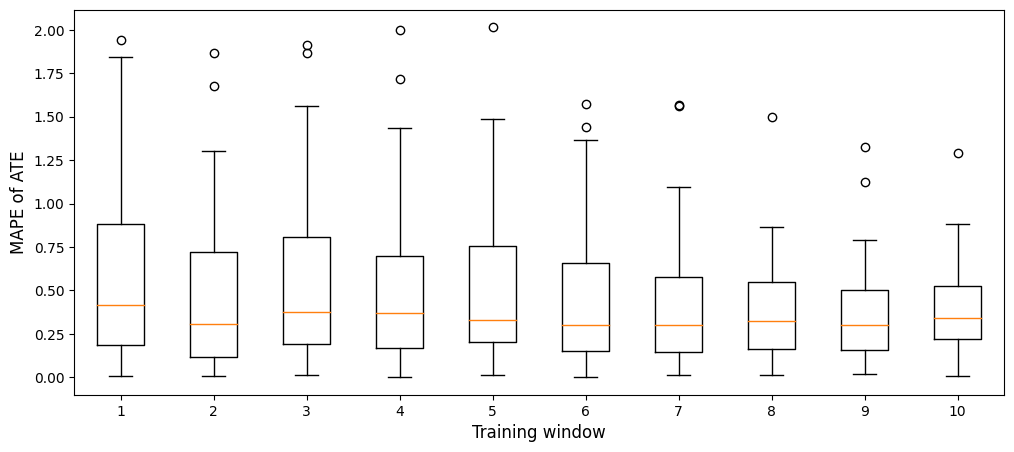

In [58]:
plt.rc('axes', labelsize=12)
plt.figure(figsize=(12,5))
result_size_dict = results_size.groupby(['n_ctr'])['rel_effect_diff'].apply(lambda x: list(x)).to_dict()
plt.boxplot(result_size_dict.values(), labels=result_size_dict.keys())
plt.xlabel('Training window')
plt.ylabel('MAPE of ATE')

Text(0, 0.5, 'MAPE of ATE')

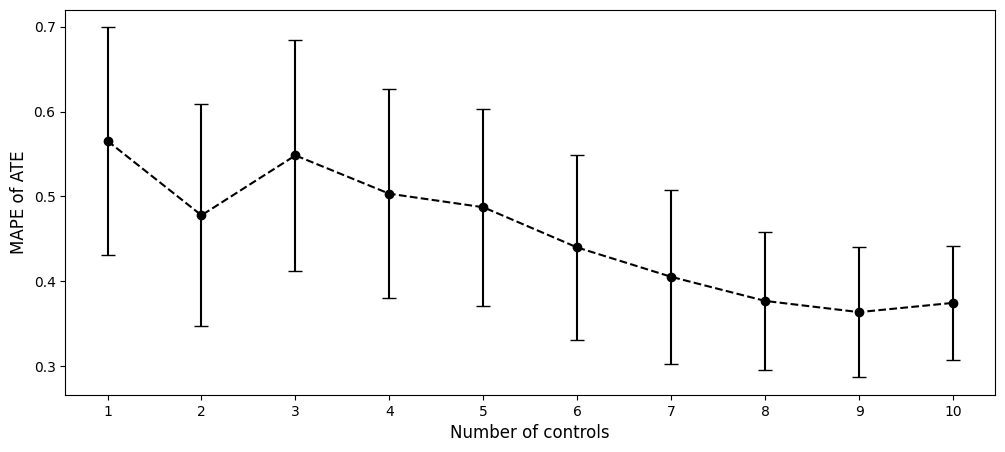

In [57]:
x = list(result_size_dict.keys())
y = list(result_size_dict.values())
y_mean = [np.mean(y_values) for y_values in y]
y_sem = [stats.sem(y_values) for y_values in y]
conf_interval = [1.96 * sem for sem in y_sem]

plt.rc('axes', labelsize=12)
plt.figure(figsize=(12,5))
plt.plot(x, y_mean, color='k', linestyle="--")
plt.xticks(x)
for i in range(len(x)):
    plt.errorbar([x[i]], y_mean[i], yerr=conf_interval[i], fmt='o', capsize=5, color='k')
plt.xlabel('Number of controls')
plt.ylabel('MAPE of ATE')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21931             2675611
95% CI                  [17513, 26348]  [2136699, 3214522]
                                                          
Absolute Effect                   3491              425997
95% CI                    [7909, -925]   [964908, -112914]
                                                          
Relative Effect                  15.9%               15.9%
95% CI                  [36.1%, -4.2%]      [36.1%, -4.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               Average          Cumulative
Actual                           25423             3101608
Predicted                        21447             2616632
95% CI                  [19221, 23673]  [2345076, 2888189]
                                                          
Absolute Effect                   3975              484975
95% CI                    [6201, 1749]    [756531, 213418]
                                                          
Relative Effect                  18.5%               18.5%
95% CI                   [28.9%, 8.2%]       [28.9%, 8.2%]
                                                          
P-value                           0.0%                    
Prob. of Causal Effect          100.0%                    


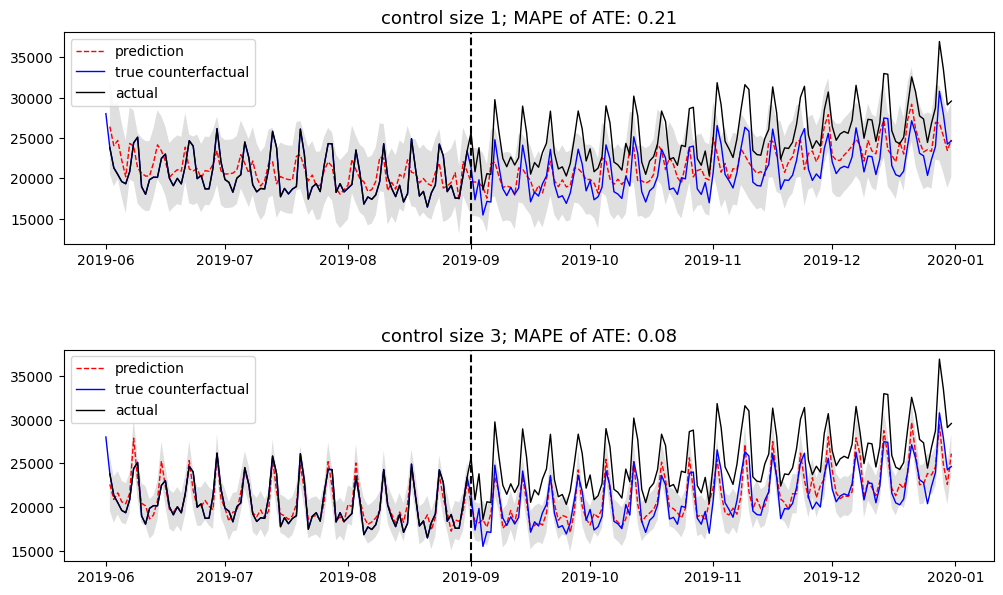

In [55]:
df_sc = df[['store', 'value']].pivot(columns=['store'], values='value')
df_sc = df_sc.loc[start_date_sc:end_date_sc]
tre_id = 'store1'
ctrs = [['store311'], ['store310', 'store311', 'store312']]
true_cf = df_sc[tre_id].copy()
df_sc.loc[cutoff_date_sc:, tre_id] = df_sc.loc[cutoff_date_sc:, tre_id]*1.2
data_inter = pd.to_datetime(cutoff_date_sc)

subplot_id = 1
plt.rc('axes', titlesize=13)
plt.figure(figsize=(12,11))
plt.subplots_adjust(hspace=0.5)
for ctr_id in ctrs:

  plt.subplot(3, 1, subplot_id)
  subplot_id += 1

  cols = [tre_id] + ctr_id

  ci = CausalImpact(df_sc[cols], pre_period, post_period)
  ci.run()
  inferences = ci.inferences[1::]

  summary_path = 'summary_'+str(len(ctr_id))
  ci.summary(path=summary_path)
  summary = pd.read_csv(summary_path)
  est = summary.loc[7][1].replace('%', '')

  rel_effect = float(est)/100

  plt.plot(inferences.point_pred, "r--", linewidth=1, label="prediction")
  plt.plot(true_cf, "b", alpha=1, linewidth=1, label="true counterfactual")
  plt.plot(inferences.response, "k", linewidth=1, label="actual")

  plt.axvline(data_inter, c="k", linestyle="--")

  plt.fill_between(
      inferences.index,
      inferences.point_pred_lower,
      inferences.point_pred_upper,
      facecolor="gray",
      interpolate=True,
      alpha=0.25,
  )

  rel_effect_diff = abs(rel_effect - 0.2)/0.2
  rel_effect_diff = round(rel_effect_diff, 2)
  plt.legend(loc="upper left")
  plt.title(f"control size {len(ctr_id)}; MAPE of ATE: {rel_effect_diff}")